In [4]:
pwd

'/home/xoxai/gis_vehicles_ds_challenge'

In [5]:
ls -la | grep -i 'vehicle1'

-rw-r--r--  1 xoxai users  115178 окт  5 12:28 vehicle19_fuelLevel_public.csv
-rw-r--r--  1 xoxai users  137894 окт  5 12:28 vehicle19_ingection_public.csv
-rw-r--r--  1 xoxai users    1315 окт  5 12:29 vehicle19_refueling2_public.csv
-rw-r--r--  1 xoxai users  164495 окт  5 12:29 vehicle19_speedAndHeight_public.csv
-rw-r--r--  1 xoxai users  163542 окт  5 12:29 vehicle19_tachometer_public.csv
-rw-r--r--  1 xoxai users  527136 окт  5 12:20 vehicle1_fuelLevel_public.csv
-rw-r--r--  1 xoxai users 2148219 окт  5 12:20 vehicle1_ingection_public.csv
-rw-r--r--  1 xoxai users    5895 окт  5 12:21 vehicle1_refueling2_public.csv
-rw-r--r--  1 xoxai users 2639781 окт  5 12:21 vehicle1_speedAndHeight_public.csv
-rw-r--r--  1 xoxai users 2390163 окт  5 12:22 vehicle1_tachometer_public.csv


In [2]:
import pandas as pd
# 1 vehicle: 
# -- fuelLevel (T), ingection (T), refueling2 (T), speedAndHeight (T), tachometer (T)

In [5]:
# данные по зажиганию (бинарный признак)
df_test = pd.read_csv('./vehicles_dataset_public/vehicle1_fuelLevel_public.csv', sep=';')

FileNotFoundError: [Errno 2] File b'./vehicles_dataset_public/vehicle1_fuelLevel_public.csv' does not exist: b'./vehicles_dataset_public/vehicle1_fuelLevel_public.csv'

In [8]:
# данные по зажиганию (бинарный признак)
pd.read_csv('./vehicle1_refueling2_public.csv', sep=';')

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"
...,...,...,...,...,...
98,1,2020-06-26 17:13:03,2020-06-26 18:57:03,"49,3","39,2"
99,1,2020-06-26 18:57:03,2020-06-26 19:04:00,"39,2","59,7"
100,1,2020-06-26 19:04:00,2020-06-26 21:20:41,"59,7","32,2"
101,1,2020-06-26 22:00:39,2020-06-27 00:11:16,"32,2","7,3"


In [9]:
cat readme.txt



























В названиях файлов TSID означает идентификатор ТС.

In [10]:
# Скорость, ключ зажигания (бинарный признак), высота над уровнем моря и скорость передвижения
# , скорость вращения двигателя (об/мин), 

In [12]:
import os
import pandas as pd
os.chdir('./vehicle_dataset_public')

In [13]:
# get all files with vehicle word in name
filenames = [filename for filename in os.listdir() if filename.find('vehicle') != -1]

In [14]:
def get_unique_vehicles_sensors(filenames):
    vehicles, sensors = set(), set()
    for filename in filenames:
        vehicle_name, sensor_type, _ = filename.split('_')
        vehicles.add(vehicle_name)
        sensors.add(sensor_type)
    return list(vehicles), list(sensors)

In [15]:
vehicles, sensors = get_unique_vehicles_sensors(filenames)

In [16]:
vehicles

['vehicle5', 'vehicle1', 'vehicle28', 'vehicle19', 'vehicle3']

In [17]:
sensors

['refueling2', 'speedAndHeight', 'ingection', 'tachometer', 'fuelLevel']

In [18]:
vehicles_data = pd.Series()
for vehicle_name in vehicles:
    vehicle = pd.Series()
    for sensor in sensors:
        sensor_df = pd.read_csv('_'.join([vehicle_name, sensor, 'public.csv']), sep=';')
        vehicle[sensor] = sensor_df
    vehicles_data[vehicle_name] = vehicle

In [19]:
vehicles, sensors

(['vehicle5', 'vehicle1', 'vehicle28', 'vehicle19', 'vehicle3'],
 ['refueling2', 'speedAndHeight', 'ingection', 'tachometer', 'fuelLevel'])

In [20]:
for vehicle in vehicles:
    vehicles_data[vehicle].fuelLevel.BEVALUE = vehicles_data[vehicle].fuelLevel.BEVALUE.str.replace(',', '.').astype('float')

In [21]:
for vehicle in vehicles:
    vehicles_data[vehicle]['max_fuel'] = vehicles_data[vehicle].fuelLevel.BEVALUE.max()

In [25]:
# for vehicle in vehicles:
#     print(vehicles_data[vehicle].max_fuel)

vehicles_data['vehicle1']

refueling2             TSID            STARTDATE              EN...
speedAndHeight                         DTIME  SPEED  HEIGHT
0   ...
ingection                              DTIME  BEVALUE
0      202...
tachometer                             DTIME  BEVALUE
0      202...
fuelLevel                              DTIME  BEVALUE
0      202...
max_fuel                                                         60
dtype: object

Анализ максимального уровня топлива в баках за весь предоставленный период времени может свидетельствовать о том, что vehicle28 и vehicle1 с максимальным объемом в 60 литров с больой вероятностью являются легковыми автомобилями.

Таким же является vehicle5 с максимальным объемом в 73,5 литра.

Транспортное средство с идентификатором vehicle19 относится к типу (???)

vehicle3 -- фура с самым большим из представленных баков, предназначена для транспортировки грузов на дальние расстояния, магистральный тягач типа MAN, 279.8 (280) литров.

In [28]:
for vehicle in vehicles:
    vehicles_data[vehicle].speedAndHeight.DTIME = vehicles_data[vehicle].speedAndHeight.DTIME.astype('datetime64')
    # vehicles_data[vehicle].speedAndHeight.SPEED = vehicles_data[vehicle].speedAndHeight.SPEED.str.replace(',', '.').astype('float')
    vehicles_data[vehicle].speedAndHeight.HEIGHT = vehicles_data[vehicle].speedAndHeight.HEIGHT.str.replace(',', '.').astype('float')

AttributeError: Can only use .str accessor with string values!

In [27]:
for vehicle in vehicles:
    df = vehicles_data[vehicle].speedAndHeight
    vehicles_data[vehicle]['max_height'] = df.HEIGHT.max()
    vehicles_data[vehicle]['min_height'] = df.HEIGHT.min()
    vehicles_data[vehicle]['avg_height'] = df.HEIGHT.mean()
    vehicles_data[vehicle]['height_range'] = df.HEIGHT.max() - df.HEIGHT.min()

TypeError: Could not convert -9,3-9,3-9,3-9,3-9,3-9,3-9,3-9,3-9,322,823,116,29,510,3139,99,38,88,78,69,29,19,69,79,91111,81212,110,38,46,66,87,17,14,22,92,93,33,74,955,55,55,86,15,712,312,512,512,91313,46,615,1141414,514,814,714,91416,718,418,418,518,717,216,31716,116,115,715,919,919,918,217,116,515,916,416,316,716,717,217,41717,517,617,81818,318,515,916,517,926,624,122,421,720,820,11916,115,816,419,322,623,423,623,121,721,120,42019,618,516,515,514,714,814,712,513,110,68,15,95,45,46,97,39,211,714,616,317,317,918,518,518,719,220,321,121,922,522,42120,125,227,830,432,633,833,43332,832,632,632,832,932,531,730,730,329,729,229,433,835,336,437,451,254,562,766,269,56360,958,155,15247,746,743,740,237,434,631,328,326,222,422,122,425,433,927,124,721,7139,62,3-0,7-2,6-4-5,2-4-3,5-3,3-3,5-4,5-5,2-6,3-7-8,1-9,5-7-5,4-3,3-1,42,68,310,913,215,718,220,523,130,631,932,733,232,732,131,43130,329,528,327,426,224,723,522,421,820,218,217,517,417,117,217,517,618,11916,111,310,810,49,47,88,58,26,86,76,86,66,25,95,24,73,93,22,3-1,3-3,6-5,9-6,1-4,824,4-2,3-3-4-5,2-6,2-6,7-6,8-7,9-10,5-11,2-10,4-10,1-9,5-8,3-7,4-6,1-6,3-6,1-6-6-4,8-3,8-2,8-2,2-2,1-1,9-1,7-0,60,10-0,20,72,42,93,53,94,94,84,64,54,33,63,32,72,11,61,3-0,3-0,6-0,5-0,5-0,3-0,6-0,8-0,8-0,817,313,113,912,111,11197,46,265,95,74,43,94,15,14,953,42,32,519,875,8-13,7-4,3-5-2,5-0,82,12,82,60,1-0,9-1,1-1,50,70,80,40,82,41,71,51,6-0,1-0,71,711,9-0,7-0,3-0,60,72,43,64,87,97,87,67,476,73,93,93,83,63,332,70,80,40,20,20,3-0,9-0,344,84,45,26,36,67,916,616,516,215,614,915,515,615,815,817,217,718,419,119,619,82020,320,320,320,620,720,520,520,821,122,520,618,917,315,613,411,24,82,80,7-1,4-4,6-18,4-16,7-15,1-14,9-14,7-14,3-13,8-13,5-13,2-12,8-11,7-11,9-11,2-9,9-7,50,78,71519,226,334,435,233,530,426,922,518,818,11920,121,523,224,526,128,130,332,635,33842,949,461,261,964,668,271,178,77674,372,169,869,667,366,365,765,565,966,668,47072,875,57881,247,94038,836,131,225,225,626,22727,227,125,724,322,922,220,519,418,817,917,416,715,813,311,78,45,34,84,54,26,513,112,110,943,42,92,53,66,810,811,31211,18,36,64,22,51,31,1-0,41,36,3666,46,88,210,711,413,714,214,614,1127,51,9-1,3-2,2-1,9-51,4-46,4-41,9-2,80,67,77,77,57,87,98,27,55,85,55,45,85,64,53,93,32,93,63,33,33,33,33,63,63,24,55,67,57,47,16,76,55,96,266,26,25,86,25,32,748,210,81212,813,212,710,17,46,76,46,25,654,94,65,25,55,25,86,46,76,77,27,47,98,210,710,710,2109,68,17,910,39,78,89,210,911,111,616,415,613,35,14,63,73,23,44,54,64,955,65,76,46,46,99,512,214,616,916,114,515,414,512,910,58,77,56,86,86,910,311,814,415,516,316,817,317,517,517,317,818,219,720,621,719,517,81821,423,726,828,631,731,732,332,833,334,234,333,332,430,928,927,427,129,832,734,335,744,549,1536062,666,668,35754,751,74946,443,640,838,135,63330,226,924,123,122,323,931,329,827,62315,94,40,8-1,8-3,3-4,6-4,9-5,2-4,9-4,5-4,4-4,3-4,8-4,7-4,9-1,90,11,9411,914,316,819,321,824,428,23333,533,131,929,829,328,828,528,728,728,628,327,827,226,625,624,323,821,520,720,220,220,420,320,52122,216,616,115,714,714,114,51511,311,111,411,311,311,211,1111211,912,515,715,113,412,913,113,916,221,121,919,416,6161514,714,914,613,712,711,910,78,68,187,87,994,70,3-0,5-0,50,10,40,50,70,91,82,11,81,51,82,22,332,92,72,53,33,43,96,510,311,39,84,93,52,62,643,63,22,933,63,332,71,50,90,51,31,50,5-0,4-1,2-2,1-4,6-6,1-6,4-3,8-2,26,91113,713,212,913,521,923,824,121,118,517,516,714,814,51413,614,114,515,116,416,923,123,624,725,825,223,620,620,921,822,123,421,620,621,722,919,21921,323,324,224,925,525,430,23030,52928,428,227,521,619,320,220,923,923,423,32124,6252525,225,12424,227,828,129,529,629,33134,63533,231,52925,717,314,413,61311,410,3109,79,59,39,29,38,78,76,1-2,4-2,313,719,622,530,941,445,245,44543,638,629,422,721,62120,115,911,34,13,73,63,94,24,53,721,84,77,28,79,28,23,624,94,45,97,688,99,49,99,410,61110,510,410,57,15,65,67,611,211,813,714,315,816,818,318,61613,311,17,26,97,57,63,51,80,7-0,2-0,6-1,1-0,81,334,85,58,58,88,28,69,19,39,616,116,817,217,21717,117,217,617,818,819,820,621,421,922,422,623,223,323,223,223,623,72323,323,724,124,222,921,420,11917,313,810,38,25,73,30-15,8-15,7-15,9-15,7-14,9-14,5-14,1-13,7-13,3-11,2-10,8-10,8-9,4-6,8-0,85,218,120,924,235,228,425,62320,413,812,511,511,913,315,718,319,922,325,328,430,736,444,948,155,75864,567,471,374,975,97779,279,279,579,779,78079,979,479,579,580,180,98282,783,682,44539,336,333,725,823,223,924,626,32726,925,824,523,22221,120,319,718,918,517,917,1161511,37,66,85,54,75,57,993,12,63,42,72,813,217,718,218,920,721,120,518,11614,112,811,79,710,387,46,95,85,88,910,812,313,212,811-2,2-1,50,82,92,72,72,8510,211,515,520,121,42425,12624,524,524,524,524,524,524,524,524,57,12,72,51,83,75,65,44,25,35,25555512,915,71714,912,4108,87,365,254,53,53,73,95,95,82,16,76,910,311,611,511,19,66,51,91,20,1-0,2-0,5-1,7-2,1-2-1,9-1,400,51,41,92,32,11,2-0,5-0,4-4,4-3,9-3,2-2-0,82,63,63,42,93,121,61,122,65,58,28-1,4-1,3-1,2-0,61,13,84,44,64,74,95,24,74,26,2811,48,98,23,821,81,81,820,9-0,100,30,60,10,10,30,80,60,50,20,716,119,815,712,68,74,2-0,6-0,6-0,6-0,8-0,5-0,8-1,5-1,4-1-0,30,888,18,57,87,96,53,53,84,44,3522,82,92,52,82,4-2,3-4,6-6,9-11,6-17,3-12,9-10,5-10,7-10,7-10,3-9,7-8,1-7,3-6,1-5,4-3,6-1,5-0,80,50,80,91,40,40,3-0,9-0,40,90,80,80,40,20,1-0,11,11,52,22,732,93,13,13,33,33,744,24,13,93,744,14,34,55,36,47,58,18,38,58,68,78,88,999,19,39,69,610,310,611,311,811,711,911,911,811,611,511,311,411,411,411,511,712,112,412,512,812,913,313,513,614,114,31413,411,811,711,311,211,411,611,411,7127,976,565,96,16,36,65,85,86,98,28,19,99,58,76,77,276,86,87,17,27,47,98,18,69,810,210,511,510,8111320,121,822,118,317,917,11614,913,916,818,416,51715,313,611,410,39,376,56,66,64,73,93,63,73,66,289,210,411,411,59,92,51,73,610,313,312,11110,99,69,49,199,110,310,310,410,710,19,39,510,512,512,512,512,59,89,89,84,36,211,712,913,113,31312,411,611,110,69,98,98,87,65,85,55,34,85,15,86,16,66,265,75,78,28,48,38,79,79,810,19,39,79,71010,49,89,91415,516,215,812,48,95,34,74,54,77,98,58,38,17,57,27,47,17,210,916,718,118,817,915,913,213,413,412,812,111,910,29,38,69,511,813,714,615,214,912,411,611,411,111,311,411,57,36,86,97,16,44,13,44,112,114,511,413,114,12021,621,421,115,814,914,714,312,48,56,56,15,42,81,11,42,78,39,59108,88,27,97,33,93,94,34,755,14,85,16,16,67,28,58,38,3-1,6-26,6351713,210,69,87,97,56,555,84,43,83,73,73,433,133,43,95,15,25,75,96,27,27,14,54,44,54,45,43,84,1-4-2,5-1,12,24,53,344,23,63,22,7-0,2-1,1-0,81,20-0,5-1,8-3,3-3,7-6,7-9,8-12,8-17,7-19,2-15,9-13,1-9,1-3,81,31,63,244,13,32,46,77,410,611,410,89,48,78,25,94,3-0,11,42,45,37,88,899,39,298,88,58,287,87,67,48,272,81,94,37,97,67,63,32,31,3-0,1-2,1-0,324,87,59,6109,97,75,92,92,12,31,14,13,53,33,13,66,28,49,610,511,110,48,8-2,8-3,2-3,1-2,5-2,1-2,22,24,34,33,83,73,84,36,24,64,95,45,87,37,89,212,313,4171712,312,712,712,712,71,9-18,1-17,5-17,1-15,5-14,4-14-13,5-12,56,97,10,30,51,222,52,12,12,32,11,41,61,61,81,41,30,90,80,70,71,10,50,811,11,11,31,3-10,5-1,4-1,2-0,50,40,60,50,70,80,600,60,71,51,71,58,28,166,57,86,36,6761,31,410,90,50,2-1,5-1,7-1,9-2-2,4-2,40,9-0,52,3343,93,42,62,50,70,40,40,51,71,91,81,91,51,31,41,4-32,1-32,3-32,9-31,6-24,4-16,5-13-13,1-13,6-13,2-14,7-13,5-11,5-10,6-10,5-11,2-11,2-10,5-10,4-10,4-10,3-10,9-12,9-13,5-14,3-13,3-9,4-6,9-6,7-6,3-4-2,4-1,7-7,7-7,5-5,4-5,6-8,2-7,6-3,6-2,5-2-0,711,83,23,53,95,86,46,26,96,76,565,35,35,43,42,93,13,43,75,15,35,35,23,622,52,32,62,31,92,42,64,74,74,92,52,11,71,821,81,41,20,3-0,5-1,4-2-2,11,34,13,920,200,50,2-0,5-4,5-9,2-10,1-10,4-3,7-3,1-3,2-3,3-2,6-2,2-2,1-2,4-2,7-2,7-3,2-3,23,53,92,41,91,21,61,41,31,62,83,64,24,12,920,60,1-0,4-0,5-0,8-0,7-1,1-2,25,24,312,613,1-1,11,92,83,85,45,96,27,67,77,17,37,37,15,65,75,85,96,16,69,414175,96,36,67,66,56,26,15,95,95,766,46,96,86,75,75,35,35,65,95,76,26,45,25,225,45,76,36,97,58,39,62,13,953,73,51,10,800,70,60,62,52,73,13,64,34,74,74,42,64,612,515,111,22,70,40,5-4,3-4,6-5,2-5,1-4-4,1-2,5-0,6-0,8-0,5-0,10,50,2-0,3-0,6-0,400,1-1,2-1,4-1,8-1,9-0,90,11,83,63,33,12,21,423,33,86,85,254,84,74,532,41,51,5-2,6-2,4-2,3-0,64,9-3,4-2,700,97,19,69,78,999,29,49,39,18,78,18,18,88,98,98,98,68,47,87,98,187,77,57,57,67,47,36,53,86,66,97,17,57,78,99,610,41110,911,210,710,49,910,310,710,710,610,610,410,410,310,51111,712,913,213,513,112,112,115,617,420,625,929,528,125,223,823,422,522,121,521,220,820,520,119,819,519,719,45,7-0,61,42,70,80,411,42,22,2-3,5-3,8-1,9-0,13,43,62,81,50-0,9-0,7-0,6-0,24,64,74,13,62,32,60,50,8-0,3-0,5-0,7-1,8-1,30,70,92,41,43,22,80,80,50,70,91,42,86,78,79,710,210,29,57,16,63,1-0,2-2,6-2,5-0,71,32,84,34,54,62,61,91,71,513,33,33,37,90,8-4,3-5,1-5,6-6,4-6,5-6,7-7,5-7,9-7-6,6-6,5-4,8-4,8-3,9-4,6-4,9-6,2-5,2-5-4,1-5,8-6,2-61,23,23,94,54,44,44,44,34,54,54,33,10,8-3,1-3,6-3,3-1,50,92,55,910,710,29,69,89,310,19,94,95,66,430,41,11,10,91,41,51,41,10,74,687,6-3,40,10,20,1-0,21,62,13,13,53,93,63,43,94,39,810,375,75,369,79,96,43,21,31,63,43,84,20,4-1,8-1,1-1,1-0,9-1-1-0,8-0,21,62,84,24,24,23,83,83,83,846,26,26,77,47,88,26,96,15,55,75,44,64,63,83,93,52,5-4-3,50,13,14,94,54,84,32,7-1-1,7-2-2,6-3-2,7-3,5-3,4-3,3-2,7-2,5-2-1,5-0,8-0,300,50,81,31,50,80,2-0,8-1,1-1-0,30,64,66,17,17,45,13,27,416,31614,45,85,85,45,25,813,914,215,11616,917,417,819,620,32121,321,922,820,820,92120,820,520,119,51918,718,618,317,416,515,314,814,213,913,412,912,512,312,412,211,611,31111,812,31313,514,618,120,317,421,622,924,826,227,528,931,432,3323129,827,724,82220,319,216,915,114,514,413,914,214,214,414,615,215,917,418,520,421,42326,331,830,326,522,217,2141313,614,113,913,813,313,313,313,413,613,913,813,913,81414,414,715,215,114,914,814,61511,810,77,77,36,66,98,19,49,69,79,49,61010,910,911,11110,910,810,510,911,212,410,710,39,598,78,89,310,39,98,68,48,58,38,28,68,77,89,510,310,811,511,811,911,911,911,812,112,112,412,913,91314,413,613,313,213,313,813,71311,89,99,610,210,210,59,79,7109,99,69,710,210,711,111,61212,212,112,312,613,113,212,812,612,512,113,912,113,213,410,81110,910,61111,110,212,913,213,113,213,213,213,313,51413,413,213,11212,211,111,412,111,61212,313,913,814,314,614,614,114,215,316,220,7293333,433,833,433,433,132,731,931,430,330,129,42928,528,227,427,326,626,225,925,72524,824,324,123,923,823,723,823,623,523,623,62322,621,721,520,920,720,219,919,319,118,918,718,3181817,817,717,3199,55524,417,917,717,717,718,218,618,618,518,418,418,318,3181818181817,617,31716,916,716,516,216,216,116,116,216,316,11615,815,615,91616,116,216,216,316,316,316,21615,915,715,815,215,515,615,916,116,116,51717,317,918,118,519,5181817,515,715,315,715,614,414,814,714,113,71413,113,212,512,312,613,113,211,11112,11211,916,617,322,420,121,32118,818,417,216,513,813,91413,913,812,912,311,410,610,510,710,811,511,711,912,211,510,59,410,210,812,51313,413,614,714,815,315,515,415,615,115,115,213,414,111,210,311,611,912,814,613,613,713,613,112,812,512,412,711,310,410,19,89,499,39,49,79,911,21210,19,29,49,69,69,79,910,411,411,513,513,613,214,314,414,514,413,813,413,51312,712,311,911,711,912,112,412,71313,113,213,313,512,412,312,211,811,812,213,113,213,213,313,213,11313,313,414,113,913,813,513,313,213,313,613,715,217,821,625,829,63434,234,429,126,725,224,624,42423,623,222,521,921,621,220,519,71817,315,914,814,614,314,514,915,415,515,616,917,517,718,118,318,518,818,8191921,222,523,525,128,929,129,128,827,72623,922,320,419,117,916,815,815,214,614,313,61312,612,311,811,49,910,211,111,813,917,316,113,211,911,38,810,912,212,412,912,913,814,314,39,310,811,512,21312,712,513,114,817,615,614,713,512,912,512,813,613,914,214,314,41519,319,818,717,416,315,415,315,215,315,415,61616,617,417,817,819,221,222,924,626,628,629,930,63130,329,328,427,225,523,520,519,723,118,618,317,717,617,317,217,117,217,417,316,816,716,616,416,416,516,61615,114,71413,414,716,116,416,717,217,317,617,617,617,717,918,418,518,218,719,41919,319,520,120,419,719,820,320,219,618,919,119,119,419,719,41918,718,418,418,318,619,320,120,520,921,822,323,12425,728,430,632,13333,733,730,421,620,820,720,420,920,920,820,620,320,320,12018,919,319,519,218,720,820,918,12020,120,621,321,622,323,223,924,124,624,824,324,324,224,123,723,824,224,425,12524,724,324,824,725,325,329,731,933,133,834,83535,937,237,838,539,140,444,946,850,350,650,950,650,349,749,349,65050,650,653,567,167,766,965,663,962,56261,661,961,758,658,558,358,55958,959,1595754,248,24847,446,344,841,5413836,536,235,935,234,73433,634,234,934,933,434,535,235,635,736,136,636,837,137,636,936,435,634,934,534,534,835,43635,729,72823,923,822,522,222,322,322,422,220,521,624,724,523,821,921,420,818,61716,615,513,712,410,998,27,67,67,68,99,31010,510,29,89,43,524,524,825,322,823,123,524,125,225,320,819,81918,518,319,219,421,220,720,621,121,321,521,823,425,526,426,925,728,429,730,231,231,732,933,432,432,332,132,735,639,439,640,340,841,842,442,642,742,942,842,842,440,340,340,24039,839,739,438,438,540,740,840,741,642,142,540,739,538,437,937,836,934,132,830,929,626,726,325,624,824,223,12321,319,818,718,618,618,422,222,624,124,325,325,425,725,625,820,520,119,820,5212424,925,926,426,528,229,430,532,132,932,834,639,942,249,148,648,246,145,445,244,743,943,844,437,738,235,228,827,827,32721,120,920,120,319,216,616,816,719,121,222,523,227,536,337,737,43736,936,635,935,134,533,833,332,631,53129,228,626,420,720,420,120,320,520,620,319,718,817,917,617,917,11716,917,117,818,418,8191918,918,718,518,418,517,117,3171719,417,818,118,718,618,21716,716,717,116,316,316,216,817,417,81821,225,930,330,329,928,928,226,624,222,420,919,719,41918,417,917,417,116,816,516,415,515,314,914,714,714,514,214,815,315,214,814,814,314,614,214,61515,814,51413,813,313,313,112,812,613,113,814,614,613,912,71211,4111111,111,311,111,111,311,111,211,110,91111,11212,713,213,614,316,616,516,516,117,720,521,923,725,326,827,428,128,728,927,927,125,824,321,920,418,616,813,91413,913,513,413,112,812,612,612,514,315,817,31920,123,825,92625,825,324,222,319,618,717,416,31514,514,213,913,613,212,912,71110,910,810,911,71316,215,312,413,217,21817,615,315,315,315,515,61515,314,113,913,813,112,18,58,37,810,911,415,113,611,110,79,610,510,510,9111111,913,814,11413,913,312,912,612,913,313,413,914,816,120,521,223,227,328,827,323,518,614,613,81110,610,110,310,410,410,510,29,99,910,210,311,211,811,711,711,610,810,710,810,710,810,510,19,99,99,810,110,110,210,610,810,210,910,810,710,19,89,69,69,69,39,59,98,48,287,8888,18,18,28,58,67,57,27,17,88,28,58,38,89,310,110,310,19,910,31111,51212,111,711,911,910,29,510,310,610,811,811,912,411,611,811,810,710,189,18,68,388,28,58,78,79,19,29,5111111,412,216,316,617,215,814,314,314,21414,214,215,11514,914,614,221,921,417,218,2171615,612,612,813,313,11313,112,412,113,313,313,813,91414,214,514,915,115,115,11515,11514,814,714,714,8151515,116,716,816,616,614,414,615,813,715,219,221,419,718,118,216,716,716,516,915,815,715,413,413,413,213,113,313,814,114,714,611,311,210,610,310101010,510,811,911,511,611,9121211,511,411,415,213,113,413,2131313,113,313,912,813,813,41312,510,69,18,787,47,17,17,58,28,89,39,29,59,39,29,810,210,310,310,29,911,711,812,913,113,413,714,213,913,814,314,514,414,414,714,814,714,915,415,91616,717,120,225,92932,226,523,92321,620,617,617,416,816,817,317,717,717,818,118,218,719,420,722,12426,127,228,729,630,130,730,529,327,426,124,322,420,423,820,519,518,617,817,216,816,71717,317,818,117,517,317,316,916,115,715,415,716,216,415,615,51717,21818,118,319,319,719,519,820,120,421,521,821,521,421,42120,520,520,22019,819,519,719,920,120,520,620,820,720,720,520,420,621,121,321,521,621,521,922,223,124,125,626,830,131,331,731,731,330,229,228,527,323,121,620,11918,217,617,11716,925,626,727,331,434,438,639,239,439,641,842,648,151,151,752,662,16261,561,662,264,865,168,370,380,681,182,787,192,19595,793,592,992,492,499,7103,4104,6105102,9102,7102,3101105105,2106,5107,7107,6107,7108,9109,4109,1108,9108,4107,4107,6106,1104103,5103,3103,2103,4103,7104,1105,9108,6113,2113,5113,7113,5113,3145,9132,5132,4132,2130129123,4113,7113105,8107,5107,4107,4106,6106,5107,2110,4110110,1108,6110,3110,3110,4110,2110,1109,6109108106,4105,5105,3105,2105,3104,7103,8105,1109,6110,7111,1111110,7109,5109,5109107,1106,3105,7108,3109,9112,3113,9109,2107,1106,6107,2108,1108107,6107106,6103,3103,6103,6104,2105,4105,5107107,7108,8108,1107,5107,5108,2108,2108,1108,1108,3107,4107,7107,9107,4107,7108106,8106,8106,6106,6106,1105,7105,3105,1105104,5104,4104,6105105,3105,2104,7104,4104,4105,9106,8106,8107,2106,7106100,3148,9125,8123,5102,2106,8108,5109,1109,2109,1109,2109,3109,2109109108,8108,8108,8108,9109,1109,1109,1109,2109,2109,1108,8108,7108,6108,7108,7108,4107,9107,3106,2102,5100,2100,1100,1100,4100,297,89695,996,39695,59595,295,695,494,694,794,894,894,894,493,292,291,692,291,791,692,191,991,390,488,587,186,987,287,688,89092,793,994,494,994,191,991,59494,695,29899,8100,4101,499,396,996,496,796,996,896,295,893,59392,391,891,291,992,893,197,998,3107,9114,7114,8119,9120120,5120,6121,5122,9124125,1125,9126,2126126,1126,1126125,6125,3124,9124,5124,4124123,6124,4126,9127,2126,2123,1123,7124,6128,7129129129,1129,5129,9130,3130130,2130,9131,7132,5132,7132,6131,1131,6131,5131,2131,1131,2131,4130,5129,6128,2128,8128,8130129,6133,9134,6136,2136,3136,3137137,2137,1135,8135,1140,1144,5150,4150,6148,2145,5145144,6141,3140,7137,1134,4134134,3134,4135,4135,8135,4135,2135,7135,9135,4135,5135,7135,8136,4137,2137,4140,1141,1142,5142,5139,1139138,7138,9138,8138,9138,8137,5138,3139,7143,8145,2145,7145,8145,9146,4146,3146,2147,3149,4148,8144,4143,6143,2142,8140,7137,6138,4138,5138,5140,8140,4139,3137,8137,4135,4134,8134132,4131,9132,2133,6133,6133,8133,6133,5133,9134,5132,3131,5131,1129,9129,7130,4131,6131,3131131,7131,8132,2133133,6133,1133,3133,1133,5134,8134,8134,5134,3133,9133,8133,9136,2141,8146,6145,8146,6147,1149,8150,8150,6150,6151,6151,4151149,2149,2148,8148,7149,3149,9150,3149,6149148,6148,1148,3148,3148,2148,1148,1147,4147,2147,3147,6147,7147146,9146,2145,2141,6142,3143,4143,4142,8142,8143,5144,1145,3148,2148,8148,6148,3148147146,5145,7145,7145,1144,8145145,9146,6146,7146,4148,9149,3149,3148,4148147,5146,4145,5145,4145,3145,1144,1143,8142,2141,6138,1138,3136,1135,7135134,4133,1131,9131,7129,9129,4129,6129,7130,7129,8129,7130,8131,3130,3129,8129,8130,1130,3130,9131,7132132,3133,2132,5132,7132,9133,5133,9133,7133,7133,5134133,9133,9134,3135,3135,6136,3136,8136,9137,1135,5135,8135,4134,5134,2135135,4136,8137,3137,4136,8135134,5134,6135,3137,8137,6137,9137,9137,8136,9135,7135,9135,2135135,3134,9133,8133,3133,1133,3133,3133,4133,3134,4132,2132,5132,4132,3132,1132,1130,3130,4130,1128,3127,8127,9127,9127,8128,8130,3130,9131,4132,3132,9131,9131,4130,7131,2131131132,5134,4137,1138,9138,2131,3132,5132,6131,8129,8132,6136,6136,8126,4126125,3125,8126,2126125,9125,1125,2125,3125,6125,7126127,3127,7126,7126,3125,1124,3123,1121,3122124,3123,5123,6123,5123,9125,1126,8127127,3127,7127,5127,5126,8125,7124,1122,8123,6123,9123,4122,8121,5121,7121,8121,5122,9125,3126,7127,3127,2127,1126,8126,9127,3127,7127,8126,2126,9128,2126,2121,3119,2118,9110,5109,2107,5104,6102,599,799,6100,3100,3101,2101,8101,499,199,2102,1101,7104,293,793,694,295,295,195,192,693,69492,687,887,78685,983,975,872,672,572,672,870,770,667,967,966,164,865,364,764,365,466,17074,870,26659,15757,156,556,856,656,355,25251,851,552,749,849,849,449,549,349,549,549,549,750,550,856,95959,162,663,260,160,96160,960,555,953,854,554,652,452,252,155,260,362,157,155,853,952,849,85250,649,849,448,747,546,642,442,642,342,141,746,647,647,547,9484847,545,845,144,543,743,242,44243,948,445,844,144,345,245,34646,847,246,847,54744,143,845,245,145,542,342,442,641,142,142,242,44039,632,722,12221,617,417,417,517,517,617,917,116,815,515,315,114,815,115,516,21615,816,415,915,815,515,915,915,915,715,715,915,91615,913,913,713,713,413,412,812,412,111,510,212,311,411,511,612,312,813,714,113,311,912,412,712,814,815,615,714,915,315,615,816,415,815,215,114,414,714,214,9172013,613,214,716,116,316,71716,916,815,814,814,414,614,615,617,42019,316,815,715,61613,713,713,914,215,114,414,314,415,113,713,913,815,216,515,116,216,316,916,814,313,813,412,512,312,211,811,210,81111,111,411,311,211,211,511,310,9108,88,17,67,78,411,29,79,79,69,59,49,39,510,91111,211,110,610,49,710,19,89,91010,310,210,210,310,71111,212,212,412,211,911,711,711,41110,49,510,611,712,512,51313,613,413,21313,113,413,813,713,713,513,41313,513,813,614,517,722,925,628,430,424,423,22120,620,219,519,218,117,116,216,215,614,413,312,61212,112,11211,911,811,412,413,815,516,217,418,418,719,32020,521,621,823,524,224,726,928,92928,728,12724,921,920,819,518,51817,11716,716,416,116,315,513,112,311,911,410,110,711,21215,317,815,212,1111111,21213,414,414,413,411,48,18,79,59,48,87,16,710,112,814,311,810,69,49,18,58,79,710,211,112,412,619,5201917,716,315,414,613,913,914,114,314,414,614,614,315,216,117,31921,423,526,127,929,530,330,630,22928,126,825,223,420,318,320,414,814,11413,413,413,313,313,313,112,612,111,611,211,111,11110,810,810,810,911,912,413,513,31414,714,71515,115,315,415,114,714,6151616,216,116,516,816,816,816,916,516,517,617,517,617,517,217,817,717,718,218,418,719,219,619,519,519,720,120,62121,3222324,926,929,230,631,432,132,430,618,318,117,817,416,916,416,215,915,715,715,816,316,817,718,220,921,320,620,119,820,423,72320,22122,422,321,62221,620,620,12019,819,519,419,418,51817,717,517,317,418,419,420,52121,521,521,922,924,826,228,128,829,829,73030,430,931,933,234,334,734,634,333,532312524,12424,124,124,123,522,125,428,340,546,847,348,65050,55151,553,353,653,452,547,145,643,236,83736,435,535,334,232,632,130,929,726,225,725,324,42221,720,419,619,820,122,923,9232221,721,521,421,320,620,921,418,616,316,614,712,18,67,87,76,15,45,35,76,611,31416,918,219,920,120,220,22017,414,512,13,42,93,219,423,724,925,225,327,13031,532,333,934,234,434,434,435,840,741,443,749,24949,148,946,946,445,844,444,344,342,843,140,239,83028,429,326,125,124,624,423,521,520,119,118,218,219,620,624,628,63635,835,735,535,334,633,532,832,231,73130,329,929,629,728,222,321,520,920,119,618,818,418,318,518,518,819191918,818,819,120,120,720,920,820,720,620,820,721,121,922,12221,720,320,724,123,120,92121,52121,422,121,921,120,62019,519,219,119,122,427,229,532,332,932,230,929,727,825,423,121,520,520,12019,819,919,819,419,619,519,619,919,119,11918,618,418,117,617,517,417,215,415,415,314,914,314,214,314,815,616,115,714,414,313,813,813,913,212,611,910,29,28,78,57,47,37,488,58,59,19,39,49,61010,310,710,810,91111,311,811,711,712,112,619,419,620,62122,423,925,62728,32929,729,628,527,325,523,120,818,516,213,112,912,512,112,212,212,11211,912,214,115,817,6192022,923,723,523,423,322,621,519,11716,214,913,411,810,810,39,79,71010,19,58,68,48,798,68,58,710,211,514,915,313,89,59,79,911,510,912,913,710,910,711,511,111,211,412,613,713,211,111,211,210,610,810,710,410,510,3109,610,39,99,29,81214,612,19,68,17,16,76,66,76,86,87,810,711,211,511,411,210,910,410,51111,512,312,913,514,21618,225,426,524,119,314,512,512,312,612,913,113,313,213,112,813,113,213,31313,313,312,512,312,312,412,712,212,112,111,811,41110,498,17,77,77,87,67,498,98,41010,412,312,312,111,91212,212,512,712,312,412,212,311,410,710,29,69,59,39,38,68,48,17,17,57,77,87,87,77,67,688,38,39,21098,88,899,19,59,89,910,610,911,111,91111,510,610,610,910,710,710,710,610,710,511,213,613,713,413,813,312,812,711,58,5887,97,98,38,18,59,29,49,58,78,68,48,28,27,87,17,77,910,810,710,213,213,814,211,611,411,712,812,712,212,111,811,512,675,244,535,632,827,522,322,12216,516,416,4171413,613,513,413,812,411,711,611,615,916,516,52022,422,82220,318,420,51817,817,11615,315,115,115,31515,515,817,919,422,32626,527,928,930,328,127,526,324,222,121,921,119,819,619,619,218,418,318,217,915,714,312,913,213,515,212,212,312,312,111,210,710,59,88,9910,111,411,61212,713,914,515,315,615,515,515,715,615,214,91414,213,815,117,116,215,815,413,413,312,912,812,612,712,612,613,113,213,513,914,213,913,91414,514,614,714,915,11514,21413,615,216,216,617,317,51819,52121,421,922,522,521,221,225,725,624,319,418,318,218,116,116,116,117,71818,219,419,619,619,324,818,51716,418,214,814,714,614,21413,113,813,914,314,514,815,816,517,219,426,426,22625,321,221,121,821,622,221,421,221,422,725,424,924,123,923,924,324,926,928,128,929,630,630,429,729,529,930,133,734,634,434,434,83635,835,534,331,93233,234,133,733,533,332,932,932,732,632,332,432,432,432,23233,534,935,635,835,835,134,534,534,435,535,735,835,933,632,832,230,23029,728,82929,731,231,932,133,835,44347,350,153,256,157,357,25757,458,758,859,459,660,260,661,56262,262,463,966,767,467,767,465,364,864,368,568,566,666,165,163,958,25553,953,253,354,455,955,955,654,554,454,554,353,852,552,352,351,45150,751,65251,650,45050,350,651,452,854,155,155,655,254,352,452,25251,451,351,45252,452,952,652,953,253,754,754,95453,652,651,250,650,249,349,255,356,656,73652,255,455,754,353,652,752,451,351,251,451,250,351,451,851,651,34949,950,249,649,350,451,451,551,852,15250,350,150,15050,250,651,151,953,960,356,356,656,856,956,155,355,355,455,255,155,655,657,457,85860,960,959,459,859,960,160,560,968,969,873,773,572,865,364,96565,666,265,870,773,37270,468,268,368,66867,967,766,96667,36868,7696564,965,265,365,56666,266,767,167,267,268,368,868,665,865,767,968,769,169,570,170,771,174,374,574,474,777,981,681,380,279,478,577,576,575,974,974,474,373,973,570,967,567,967,86868,668,969,371,871,57272,372,272,572,873,373,272,872,973,57474,174,474,374,474,675,575,376,877,878,178,278,183,187,488,183,581,68180,680,881,681,881,682,282,68585,285,586,286,486,386,185,985,885,685,987,287,387,58888,689,189,690,880,580,68181,380,980,778,579,276,167,770,271,17273,176,685,987,990,19595,295,495,294,690,589,291,292,392,192,292,392,89397,498,298,794,692,291,991,491,491,590,48887,888,285,482,68281,282,381,875,675,474,974,448,163,463,767,579,483,68484,886,987,486,285,48584,784,785,488,890,190,491,29291,891,890,789,288,186,984,884,78484,68585,485,483,379,679,178,775,974,674,574,273,672,175,377,479,379,879,677,675,374,473,973,779,382,583,18382,281,581,581,38691,989,99089,990,786,689,291,791,390,192,292,592,493,896,496,296,49797,49899,2100,9100,499,399,19896,596,497,7102,7103,3104,1105,3106,3108,2109,7110,2108,6108,4107,4107,2106,2107107,7110,1110,3112112112111109,2108,9107,3105,1103,5102,4101,7101,499,899,599,4101,6102,6101,7100,395,689,588,591,291,792,392,891,691,190,189,18988,288,689,690,49191,593,693,493,492,992,791,590,288,185,383,382,982,381,183,487,688,989,189,389,880,580,980,377,876,87776,57981,286,688,488,685,482,982,983,283,383,383,584,285,58686,786,887,387,787,684,984,282,582,18281,48180,179,58181,283,185,885,885,584,58483,28382,382,182,582,384,585,485,286,586,787,185,482,281,582,182,883,592,392,493,497,5104,4105,5105,7101,6100,399,79894,790,188,285,381,980,279,979,579,379,379,178,978,979,179,680,281,281,181,381,781,881,280,78079,778,47779,481,180,679,879,578,78080,181,581,582,184,484,485,686,285,585,886,388,388,788,487,38787,487,988,589,590,690,991,89292,394,796,498,596,894,193,795,595,198,698,597,698,5101,297,187,268,363,556,355,954,553,954,354,15656,655,954,953,651,95046,939,135,932,529,426,823,718,317,11514,514,213,713,713,11212,212,413,414,616,320,123,325,927,32725,623,420,518,41614,113,112,912,812,412,111,811,11010,410,510,811,211,511,611,511,612,112,713,313,11312,912,813,91413,914,115,216,222,821,715,512,712,37,77,178,29,19,59,19,59,39,39,79,39,29,27,811,211,111,111,71212,513,413,712,312,713,212,812,413,514,313,113,312,712,913,312,812,512,712,615,315,614,614,414,5-10,6-2,23,96,15,89,910,21113,112,9131313,313,213,212,411,511,511,512,512,713,313,712,913,113,212,111,411,311,212,112,712,311,410,910,810,911,713,114,615,410,189,812,812,61313,212,811,711,411,211,511,713,214,916,217,318,519,119,419,82019,817,311,79,89,910,210,210,11010,410,510,911,411,61213,614,214,113,813,613,513,413,413,212,913,113,513,713,81414,413,913,61413,713,213,113,113,616,817,919,618,115,21514,913,511,910,39,59,28,88,58,911,815,210,49,28,398,9912,413,413,21313,213,113,414,315,616,817,517,317,116,212,71210,912,31315,315,715,91615,916,115,71514,113,713,512,412,512,712,512,111,911,511,511,511,511,511,511,610,19,18,98,88,99,510,110,610,812,11211,912,512,713,313,413,914,214,414,31413,713,713,313,513,813,91413,713,713,713,413,613,613,413,313,613,112,812,612,813,713,613,714,114,214,214,91514,81514,815,414,614,516,117,821,426,827,922,721,220,319,719,51918,818,417,415,814,813,812,411,210,810,49,69,38,27,87,16,86,87,276,76,66,97,68,38,68,79,110,213,114,615,216,61920,521,221,32018,716,514,914,112,811,310,39,89,59,39,38,576,96,86,86,57,78,213,813,112,19,58,47,59,311,211,711,912,213,21311,911107,511,515,317,416,614,813,512,212,212,612,913,213,814,217,419,219,218,817,915,815,815,114,714,414,915,515,615,315,215,717,319,221,924,726,427,228,529,830,731,131,130,830,328,726,923,222,121,8201817,216,716,516,115,615,915,915,515,214,914,61413,412,61211,911,811,711,711,110,711,411,912,412,713,213,413,914,314,91514,91616,917,117,217,217,117,317,416,91717,11717,417,216,717,117,617,917,918,218,318,318,318,418,51919,319,920,420,420,320,321,423,224,626,928,629,830,630,529,219,716,91716,416,616,716,716,516,516,817,317,618,921,121,622,121,922,121,822,42323,922,822,923,124,124,524,223,522,822,622,121,921,821,220,319,819,318,91919,319,920,621,522,923,323,923,723,723,725,928,329,13232,133,134,43637,138,338,939,741,7485050,951,151,45150,349,848,948,147,547,747,848,962,264,465,56563,962,561,260,359,659,458,657,455,756,255,354,553,152,451,151,352,152,752,953,25351,651,249,146,945,14443,242,241,440,44039,940,341,542,442,94337,235,534,2343433,733,233,133,533,231,829,424,3232322,722,822,816,220,423,927,227,727,223,623,323,223,524,123,522,72223,922,720,519,718,42423,52322,621,319,819,820,121,221,621,821,822,127,630,934,334,334,234,434,133,833,633,633,532,832,732,532,431,130,730,130,630,930,630,430,433,434,333,833,934,735,235,435,23534,93535,135,635,836,237,237,938,63938,838,838,538,338,925,926,92725,425,527,128,229,530,131,13130,629,629,829,328,32727,126,726,625,925,825,121,822,722,822,82323,524,527,429,930,732,432,632,832,732,745,444,139,736,235,735,521,926,526,827,327,828,130,132,132,13333,733,934,335,439,539,840,443,146,746,446,246,145,645,144,643,74342,941,641,839,131,427,5293131,132,53230,829,126,225,927,927,726,626,225,725,124,324,122,922,825,326,935,437,837,237,337,137,136,836,135,635,234,533,532,832,432,533,43329,92826,826,125,424,924,624,223,422,521,520,820,720,720,821,321,521,922,522,823,123,423,923,823,422,922,321,320,921,320,720,823,521,722,62322,320,219,51920,320,320,420,520,420,421,12224,434,735,43635,634,633,530,929,126,725,524,824,624,624,924,824,524,224,224,624,624,523,523,122,722,22221,921,92221,921,521,520,621,121,82222,322,723,123,523,722,320,620,320,721,421,821,5212018,91817,817,916,916,817,618,218,518,317,817,517,217,217,217,317,517,717,918,21817,71818,318,819,927,326,527,229,130,231,632,734,234,634,634,834,934,433,131,529,72724,922,721,320,820,62019,819,519,218,918,617,918,218,719,922,324,325,128,829,429,128,728,627,826,624,422,721,219,91918,718,518,118,118,518,417,315,916,216,816,917,116,616,517,517,619,222,120,515,613,913,513,814,314,614,516,616,4161615,11616,416,517,41515,115,215,114,813,31312,812,812,912,912,812,912,813,111,610,710,61111,411,812,212,712,913,6141518,417,118,221,318,916,114,413,112,812,81313,213,313,61717,817,717,316,816,716,315,815,615,515,415,516,817,419,328,63134,931,227,723,118,916,617,216,916,116,116,116,116,316,416,516,817,21717,317,517,617,817,316,816,516,416,817,615,614,914,71514,714,815,815,615,815,814,716,116,416,616,516,516,216,115,815,716,617,817,214,414,21413,913,913,813,513,613,613,912,912,712,61313,113,313,613,713,412,611,911,713,714,214,813,413,313,11312,712,712,913,213,413,814,813,911,39,29,39,59,69,69,39,41010,61111,413,614,415,115,816,616,114,513,413,313,613,312,911,411,110,610,19,79,79,49,58,68,78,78,78,38,210,78,68,38,28,48,68,89,59,711,611,811,911,812,211,81212,31414,614,915,816,215,915,415,91514,513,313,113,314,414,314,815,215,114,914,713,913,913,813,814,113,913,813,814,114,114,114,214,514,614,714,714,712,513,713,914,714,915,615,214,314,113,213,113,512,8121211,81110,610,810,910,810,391111,412,212,812,812,111,211,311,712,812,813,112,912,712,712,712,511,810,99,89,89,89,710109,58,58,489,19,810,39,310,311,111,111,612,51415,419,419,516,516,116,517,217,417,818,218,318,419,420,320,920,95,518,222,924,127,527,427,827,827,226,328,443,144,945,445,74543,5454443,943,444,447,447,446,445,544,243,743,544,445,648,851,251,65047,446,746,24545,445,645,646,146,647,949,550,551,652,553,354,34947,346,145,242,641,63836,832,631,831,83332,73234,433,933,834,634,7353637,537,634,837,535,835,434,833,431,132,232,332,732,533,233,633,828,12727,535,633,83736,435,13433,633,933,733,634,434,634,934,332,532,731,533,734,134,234,434,836,336,733,333,831,832,434,735,934,334,836,74141,142,843,24547,250,650,550,555,257,257,256,355,554,453,151,75049,148,347,245,944,544,845,446,647,248,948,748,548,151,552,956,857,458,458,760,35959,859,158,75754,554,654,655,955,549,447,346,446,144,644,542,142,442,442,542,442,141,245,546,847,94745,538,637,641,240,740,640,139,739,639,539,33939,13939,440,341,541,840,940,840,540,941,441,441,641,540,440,437,931,427,327,328,830,530,431,134,53838,438,53837,838,138,838,938,438,438,738,537,737,73838,639,740,441,846,446,647,247,748,14841,840,940,74041,341,742,443,344,14443,443,144,448,75152,252,852,752,753,453,954,85757,457,157,257,156,956,656,656,678,166,85452,151,949,949,149,950,450,450,450,952,852,852,451,752,9545756,756,456,354,553,953,853,651,249,949,249,24949,449,450,351,252,152,353,152,852,952,250,950,249,649,248,948,447,847,747,247,347,34746,84441,94138,838,738,237,937,336,23635,636,135,534,934,534,434,535,135,936,336,637,13739,740,140,237,437,336,236,938,538,638,738,939,240,240,64142,443,544,244,444,244,543,743,342,54241,439,641,441,441,542,543,646,95050,849,946,443,240,239,640,442,643,243,745,746,346,746,446,145,244,544,144,144,244,345,745,946,349,950,948,242,541,14444,245,145,745,345,345,345,24341,441,141,241,141,341,642,443,242,842,942,541,938,236,13229,429,329,528,929,930,93130,328,428,128,128,128,328,629,126,122,722,622,622,219,919,519,419,318,818,918,919,119,719,31919,82020,120,320,520,119,519,118,618,618,718,518,318,517,917,517,717,617,717,716,516,915,416,416,115,715,514,514,814,314,114,414,214,115,615,315,115,214,61413,713,512,714,314,213,912,812,91313,81514,314,113,91414,314,31414,113,913,814,214,414,815,415,615,315,215,214,514,115,315,616,316,317,61819,620,721,621,720,720,820,421,219,817,117,717,616,216,315,215,214,414,113,413,513,914,113,814,212,126,727,928,519,616,915,316,116,11615,513,713,814,815,214,614,815,715,81514,915,51820,520,618,517,316,616,215,41513,813,312,511,811,911,812,112,912,913,313,515,219,51813,912,113,220,219,117,415,81312,912,613,714,916,716,716,416,316,116,116161615,91616,316,516,516,316,416,316,42125,125,525,726,8282421,61916,715,915,816,116,316,216,517,118,221,821,921,821,320,418,116,716,215,915,615,315,515,314,914,914,614,515,616,917,719,722,124,725,226,727,427,42725,32422,321,219,615,214,317,117,212,911,711,411,411,812,411,911,811,210,910,811,111,311,311,110,710,810,910,810,510,610,51111,412,612,21212,111,511,61212,112,113,613,71312,81313,313,312,913,113,914,114,514,11414,214,214,514,514,91515,115,715,91616,116,816,917,117,918,419,921,923,726,428,830,230,329,726,923,816,316,11616,316,515,81616,416,415,715,511,711,41312,913,113,818,11615,81616,416,215,615,916,316,817,718,218,318,318,618,817,617,417,216,916,716,816,616,818,118,218,919,820,32019,921,222,127,127,93031,232,633,434,434,434,634,73642,344,945,445,144,844,543,843,743,543,644,145,14646,865,465,965,663,862,861,76160,86161,558,458,358,958,657,357574847,346,445,743,438,237,837,536,236,135,834,934,333,932,931,932,432,833,332,533,133,433,433,533,333,233,533,233,34242,237,936,134,132,832,733,133,233,1333332,933333333,133,230,930,128,225,623,82426,829,930,231,632,633,43434,334,133,43331,831,531,228,627,326,625,224,12424,323,820,219,71918,21818,318,319,42424,824,824,924,924,924,924,839,439,138,137,137,137,635,232,632,332,232,533,634,434,935,736,537,337,64042,144,846,755,355,255,355,554,854,754,853,351,749,848,845,63529,426,321,319,218,32020,720,720,820,820,320,620,821,521,623,833,534,137,837,837,537,137,136,936,736,235,835,334,634,234,334,531,730,126,826,325,42524,124,223,32221,821,42120,519,819,218,41818,218,11818,318,81919,419,519,518,919,119,318,318,42118,718,1181817,917,31716,918,218,418,218,117,817,316,816,51716,627,529,829,929,62928,527,225,423,622,321,120,620,420,320,320,620,720,320,319,818,818,317,617,317,117,217,617,918,618,918,218,519,119,219,319,419,219,920,219,217,616,516,415,816,31615,415,415,315,315,515,515,916,215,31514,914,313,913,813,713,814,414,81515,315,314,914,713,814,214,414,615,417,11918,922,924,926,428,330,131,431,732,433,332,931,429,927,324,422,721,419,318,518,317,917,417,216,716,215,615,51718,219,619,722,624,124,32423,422,220,217,916,415,114,113,312,612,111,410,69,89,410,19,39,910,411,211,812,414,514,815,820,918,517,516,913,813,614,71211,813,114,116,116,116,316,317,417,417,817,917,917,917,917,517,817,717,517,41820,322,324,120,919,618,717,216,516,416,216,218,919,719,51918,317,716,916,616,316,516,916,917,117,725,728,727,622,717,913,811,712,113,614,314,514,514,314,314,21413,613,513,914,615,315,115,215,3151515,21515,215,614,713,412,61211,811,711,71210,710,510,210,110,210,210,410,710,910,810,810,911,813,513,313,413,212,912,812,2121212,11211,811,511,310,710,510,410,310,39,99,79,710,110,812,112,312,31211,911,811,511,511,91211,911,913,113,713,914,414,614,715,115,916,1161514,813,91313,513,311,811,611,711,512,21211,811,110,810,410,810,410,411,111,110,98,910,411,111,111,813,514,810,610,210,510,811,212,112,512,912,712,614,514,214,115,215,515,415,615,615,61615,616,31718,918,718,518,418,418,418,318,217,816,215,614,814,614,914,814,715,315,414,213,113,413,613,613,213,913,513,613,71312,812,612,812,212,312,323,221,91818,117,817,718,318,418,518,417,81717,617,116,817,919,822,322,325,227,928,32932,429,42828,228,629,328,628,629,630,133,935,440,9373838,236,335,433,636,137,438,238,739,339,6404040,240,74140,640,139,438,738,338,434,833,132,932,732,33231,129,328,527,324,123,923,823,623,321,521,321,121,321,121,221,221,625,125,624,72524,225,326,225,925,424,423,72727,231,531,832,33027,626,425,624,81615,114,514,213,111,79,38,213,114,315,719,92019,919,820,419,719,719,325,618,819,221,222,223,424,324,924,82321,821,221,118,816,816,916,813,312,712,912,611,911,51212,312,413,114,313,513,59,410,312,212,412,110,510,910,710,79,69,28,687,36,26,899,712,914,616,814,814,714,815,114,714,614,614,9151515,615,816,116,216,816,816,716,616,41,58,411,219,320,120,320,6212121,621,924,431,729,228,327,126,525,321,821,521,121,321,420,819,518,511,59,46,85,15,14,84,43,32,12,23,467,17,55,75,77,78,48,48,98,77,27,37,67,87,97,97,98,18,29,29,59,510,110,811,714,514,916,21615,715,414,713,713,712,912,612,613,112,512,212,21414,414,113,713,914,915,114,713,712,410,79,79,510,211,912,211,911,611,310,910,610,4108,48,38,27,97,788,38,287,77,77,88,28,710,710,911,111,512,412,612,99,88,810,111,412,513,313131313,313,513,613,913,613,413,413,213,31415,314,313,813,51415,618,321,72324,725,72624,223,921,520,819,718,818,117,716,916,917,71819,218,218,417,418,218,518,319,219,520,220,419,619,619,920,320,520,42221,821,720,519,217,917,618,118,320,621,722,522,823,723,7145,9131,4116,4105,299,781,561,248,241,740,536,434,13331,929,826,92524,322,120,719,415,417,217,317,717,717,417,217,918,318,718,618,519,319,920,121,622,425,527,529,627,826,622,721,721,520,520,119,919,718,717,51715,914,41211,2108,88,99,59,48,56,31010,410,512,614,714,91514,714,513,813,513,411,911,61110,410,29,710,311,411,611,210,79,49,29,18,38,18,27,610,111,411,611,912,111,912,311,612,613,313,413,412,711,911,710,19,79,49,69,79,79,48,899,18,98,47,78,18,17,97,47,77,98,68,39,48,99,39,298,68,16,95,45,14,74,344,14,34,15,25,377,37,67,57,376,96,877,47,788,18,410,110,110,710,910,710,59,79,99,810,311,811,811,210,59,26,74,93,744,238,427,317,818,417,818,318,218,218,217,416,115,917,319,622,325,223,921,2201917,917,215,915,61514,313,813,813,91413,811,911,511,611,711,211,511,611,311,311,511,910,810,69,87,66,864,64,13,54,35,867,68,28,899,19,38,98,98,58,58,1888,38,28,58,88,98,99,39,19,18,388,28,17,88,57,67,46,76,25,95,55,25,24,83,83,233,34,54,84,95,45,55,2555,15,35,75,86,76,75,55,15,46,16,999,89,89,910,210,310,810,610,610,210,29,69,58,69,19,610,19,7109,69,47,3443,533,22,52,22,12,82,82,93,43,33,12,52,834,44,23,83,54,64,64,454,13,83,93,42,52,43,54,75,34,63,83,73,63,53,12,81,72,435,87,17,26,86,65,65,44,94,74,65,11,62,54,655,66,49,28,710,810,91111,612,916,416,315,915,616,315,614,714,312,87,66,47,68,48,91010,411,11920,621,823,225,730,232,837,537,637,837,93838,43939,139,139,940,140,239,538,838,537,235,935,130,835,236,835,538,635,434,531,829,527,726,726,125,825,725,224,624,423,927,729,229,530,129,126,921,116,916,61717,316,617,518,718,418,418,517,815,715,615,21313,112,81418,819,520,221,221,722,322,72220,62019,217,916,215,21414,916,217,318,217,515,414,511,51111,212,713,513,713,513,71414,514,614,514,113,913,613,112,912,912,913,11312,912,712,212,512,512,91413,913,613,613,814,415,215,515,116,316,516,917,11817,517,617,617,617,817,717,818,216,116,116,817,816,71615,214,213,112,312,412,911,911,811,411,412,111,610,89,99,28,68,788,78,610,312,413,813,613,713,713,813,612,912,411,711,414,116,218,316,814,713,512,611,7108,88,48,48,68,88,98,68,28,2910,211,411,611,71212,412,712,813,315,319,319,720,12018,917,415,213,713,112,812,713,113,513,513,313,213,813,915,116,318,420,122,524,726,12727,227,326,625,32320,118,217,814,917,915,613,913,512,912,71211,912,212,412,713,614,815,816,717,418,118,418,417,917,116,615,61413,612,912,711,210,983,82,40,7-0,3-2,4-4,6-7,3-6,1-5,1-3,5-0,26,611,713,112,511,710,36,25,65,23,74,34,34,64,46,48,410,111,211,710,88,33,22,22,63,95,36,25,745,24,95,66,56,56,35,74,73,83,53,63,53,73,12,52,54,54,53258,7-3228,2-3195,8-3162,9-2986,4-2934,3-2861,313,3-2,1157,7157,4156,8155149,4144,3137,6128,7103,274,84721,76,64,83333,43,52,52,82,72,82,82,72,52,52,42,22,63,43,75,86613,913,818,419,919,616,114,114,213,51314,917,316,816,516,81717,7191919,219,720,319,518,118,218,518,618,518,117,416,715,614,613,512,110,79,48,58,57,97,36,96,97,27,67,77,98,49,210,210,311,111,913,115,815,718,820,722,724,125,928,331,832,733,433,23230,227,524,421,620,117,715,414,313,913,412,912,912,612,612,612,813,41516,718,319,621,823,729,32621,219,214,812,39,710,611,511,61211,911,911,711,811,711,51212,612,612,312,412,913,313,413,112,812,612,912,19,88,38,99,69,49,38,710,610,41111,711,611,511,21212,312,412,211,711,510,511,312,810,19,79,79,39,19,29,19,29,410,310,310,610,310,1109,99,79,710,610,711,511,611,611,912,112,112,212,312,312,212,212,612,712,913,112,41211,912,112,512,412,311,811,210,610,69,499,69,69,99,79,69,59,59,59,710,410,611,211,31111,511,812,21110,710,210,310,410,712,911,310,99,89,59,39,69,49,69,59,69,51010,611,511,912,513,413,613,415,414,21413,612,412,812,812,512,212,112,112,712,613,213,413,814,114,214,514,814,213,813,914,314,917,718,418,618,618,718,918,818,718,719,119,219,319,319,216,222,322,324,222,32323,223,223,423,623,523,723,823,823,623,423,423,523,523,623,623,423,423,323,323,314,213,413,313,613,814,114,114,11414,113,913,91414,314,514,614,81515,5161616,316,316,416,516,816,917,117,117,517,516,415,915,415,615,916,31716,917,817,717,817,918,318,218,318,418,114,914,112,912,913,413,715,716,81716,215,314,714,514,112,812,51312,211,910,81111,211,411,310,711,411,611,812,112,412,913,113,613,914,414,514,614,614,814,714,614,815,715,915,916,518,31919,519,919,920,220,520,823,524,626,826,322,220,818,411,610,910,39,79,39,29,78,99,398,188,71010,310,89,510,19,810,610,910,811,19,811,812,212,513,313,313,214,215,415,916,315,515,513,313,816,817,717,717,31921,518,816,313,612,711,911,31110,610,79,79,18,68,39,29,510,410,410,910,712,7171411,910,28,98,96,85,75,56,96,565,95,55,96,17,810,911,49,66,66,46,56,36,17,27,88,48,899,613,715,916,716,715,814,514,11413,913,813,613,913,913,913,612,913,615,217,118,820,923,124,625,125,625,324,623,621,920,118,414,716,717,413,613,212,712,512,211,311,110,910,610,410,39,598,78,716,418,42020,721,520,617,66,77,999,19,39,18,38,28,48,29,18,989,510,66,265,54,54,43,82,92,31,41,10,60,40,2-0,1-0,5-0,9-2,9-3,6-3,12,42,52,93,54,830,9-0,7-1,9-4,3-6-7,2-10,3-7,5-5,7-4,4-1,7-1,3-0,8-0,7-1-2,1-2,4-0,7-3,9-2,9-2-1,9-2,3-3-0,1-0,1-0,1-0,1-0,1-24,8-14,9-13,8-7,5-3,7-3,4-3,3-2,6-2,7-2-1,4-2-2,2-4,9-7,8-6,5-4,6-20,41,25,710,112,612,512,812,812,712,911,711,811,410,57,514,610,1-4,5-6,3-5,4-2,9-1,9-1,3-1,4-1,7-1,8-1,9-2,9-2,9-0,6-0,5-0,5252,4222,133,416,313,77,24,7-0,8-3,9-6,8-10-16,2-15,2-14,1-13,4-11,6-12,1-11,1-6,3-6,6-8,7-7,8-7,7-7,9-7,8-7,4-7,4-7,5-6,7-7,1-7,3-5,5-1,90,423,75,46,98,49,49,43-0,41,41,42,22,23,13,73,84,55,16,18,210,310,49,99,89,49,39,29,49,49,38,47,86,85,65,255,25,35,96,67,88,68,89,59,99,99,8101010,210,811,71314,816,519,121,222,12321,612,91110,810,710,610,310,19,89,69,29,610,911,211,310,910,19,18,45,34,54,6777,89,410,111,311,712,713,413,413,81312,512,211,611,711,811,711,811,711,411,310,59,99,49,18,61112,714,315,115,115,616,417,218,321,124,534,537,438,338,738,638,437,737,637,737,137,137,236,938,953,653,753,151,350,14948,347,447,548,54947,147,445,845,54543,239,134,433,833,132,230,928,828,428,428,32827,928,930,829,527,726,625,32422,922,320,819,113,410,1109,59,79,810,513,515,516,416,316,316,316,316,324,129,129,12825,62524,124,424,524,323,323,323,423,623,923,827,327,82929,731,732,533,234,535,435,73635,636,139,941,647,149,849,348,647,847,346,946,845,545,638,63128,926,622,921,72121,421,621,622,724,126,729,839,841,840,940,540,439,939,238,137,336,636,135,334,133,632,332,130,827,326,32625,624,623,723,222,823,123,123,122,922,321,621,221,82221,821,621,621,420,420,320,120,12019,819,819,919,122,422,522,522,321,119,72019,519,319,218,918,518,518,418,318,518,921,331,73434,133,832,831,529,927,725,523,622,722,522,32221,320,720,12019,218,918,819,119,419,619,619,519,51918,517,51716,616,115,716,116,316,516,416,416,316,317,317,515,915,515,114,914,614,513,812,811,511,311,811,71110,29,69,18,89,19,19,29,69,810,110,110,210,210,410,712,51314,214,615,520,418,418,620,922,623,925,527,4293030,530,429,528,225,825,523,622,219,91815,315,114,91412,812,512,512,813,114,115,617,619,725,926,827,127,327,226,624,923,222,221,119,718,417,817,217,117,51817,716,71615,615,615,115,816,619,621,119,415,214,213,513,413,214,315,516,116,216,521,819,61111,511,4119,27,47,57,47,57,77,77,98,18,38,38,18,38,48,89,39,69,710,510,910,510,210,510,911,511,314,51715,513,613,211,613,313,614,113,813,915,515,515,415,214,814,614,213,913,51312,612,512,51312,713,118,421,228,627,122,520,717,414,413,216,917,918,118,117,917,817,817,817,817,91817,417,116,91716,9171716,4161616,216,716,914,3131211,611,511,711,711,211,411,912,213,413,313,513,613,413,713,513,513,313,614,612,612,111,511,110,39,99,59,28,999,59,710,510,510,711,211,712,112,91313,214,814,41414,214,414,314,113,713,713,813,513,313,113,212,210,510,111,418,218,816,816,516,214,614,614,814,914,514,412,210,7117,36,26,77,513,813,713,813,719,218,617,617,717,217,416,916,916,7-12,55,225,753,640,934,133,429,226,424,924,324,223,320,721,521,520,920,218,316,916,316,316,916,917,11717,617,817,917,818,218,518,919,119,419,620,120,721,221,321,922,222,921,818,11619,617,115,115,215,216,217,316,615,915,816,116,115,715,716,217,118,416,216,716,416,214,914,914,712,612,111,210,71111,111,111,311,511,511,411,710,610,610,510,510,19,79,19,49,810,912,713,612,810,411,411,711,411,111,411,511,812,712,912,912,712,612,712,713,112,712,512,512,412,312,312,512,6131313,113,113,213,313,513,213,21312,812,212,21312,812,512,512,512,612,612,312,112,312,312,312,312,312,5131311,814,218,523,427,629,82624,318,417,816,915,914,213,513,413,112,812,512,512,712,812,914,716,21820,721,824,126,328,929,126,822,820,819,518,217,216,315,513,5131313,614,615,915,815,214,814,212,712,712,51214,317,918,418,518,518,418,218,318,218,218,218,21817,917,817,717,617,517,417,317,21716,716,616,516,616,516,616,516,416,516,516,516,616,716,717,217,617,617,617,717,91818,218,118,218,418,618,618,718,718,618,618,618,818,818,918,818,618,718,618,718,718,517,917,216,716,316161616,316,817,317,617,417,316,315,415,616,116,417,216,816,716,315,414,71414,5151514,413,613,21313,313,914,414,915,616,917,518,719,722,32119,818,417,617,417,116,817,317,817,91817,817,717,516,816,616,516,516,115,313,912,7131413,914,614,715,816,116,216,616,516,216,516,917,317,418,718,31818,117,918,118,418,218,118,418,217,917,917,917,918,318,218,518,318,318,218,118,318,318,719,319,920,521,121,723,32526,928,53031,131,931,128,320,619,819,319,319,319,72020,320,420,620,521,421,421,921,521,321,722,121,922,322,42323,924,725,426,526,727,227,426,825,524,523,824,224,22525,325,325,825,82626,326,426,426,426,830,732,235,636,737,538,738,939,139,540,340,546,94748,549,449,95050,15049,548,648,448,748,849,36364,765,464,863,461,360,859,959,157,655,954,554,454,253,653,753,350,440,940,640,439,13836,333,93332,933,338,940,340,24039,946,746,746,745,739,932,531,230,93131,940,439,641,245,245,946,346,747,35152,253,454,555,657,257,457,858,559,359,860,16058,95753,951,350,148,947,34643,741,641,241,141,44242,442,742,938,737,335,835,234,333,933,933,633,733,433,231,228,723,323,423,518,617,317,818,619,922,722,823,222,423,223,122,72423,923,924,224,82625,825,623,821,820,420,420,52120,921,521,922,522,92425,726,928,32929,429,631,131,332,332,732,331,932,132,433,534,437,238,237,432,734,135,737,137,938,539,33938,739,940,240,240,240,540,840,740,941,141,140,539,238,437,836,43636,437,938,835,134,13330,530,129,82928,427,32726,425,825,525,826,426,426,125,825,525,324,5242423,723,222,822,924,926,926,826,92727,628,428,628,427,827,827,626,826,626,426,325,825,625,625,625,82524,826,626,630,846,150,649,867,177,369,662,558,556,153,538,735,735,234,934,537,64044,144,54545,344,944,844,444,243,943,944,747,152,752,852,352,151,850,849,949,447,64746,445,54443,844,144,745,546,247,649,551,954,556,957,157,757,557,457,457,457,958,358,459,260,761,563,362,963,263,664,566,368,169,270,169,269,359,852,25251,951,95251,851,451,451,75251,85146,946,844,838,13736,936,436,135,23533,432,632,231,731,331,331,331,231,131,431,733,435,535,838,756,757,352,646,445,245,846,846,846,65150,957,157,458,365,265,665,765,465,769,578,778,979,279,780,281,581,882,584,586,287,688,792,593,996,5100,9103,4105,7106,2109109,9110,6111,2111,3111,8114,7124,4126,6127,4127,4127,2127,8128,1127,6127122,8116,4119,6119119,3119,4119,6118,4106104,5101,399,797,296,396,696,796,8100,1100,5100,9103,7103,9102,3105,5107,8109,9108,6108,6108,1107,5106,8106,7107,5108,3108,8110,6111,8111,9111,7111,3111,2111,6112108,7109,1108,8108,3107,9107,3107104,4104,1104104,4105,2104,8104,7104103,5103,5103,5103,8103,9103,2103,9103,8103,9104103,6107,9108,1108,9108,9108,8108,7108,1107,9107,8107,6107,6107,2106,2106,7107107,3107,6107,6107,3107,1107106,8105,9105,3105,5105,6105,7105,8105,8105,5105,6105,8105,9106,3106,7106,8105,7105,9106,4106105,5104,9104,4103,9103102100,3100,199,899,699,499,3100,1102102,1101,5101,7101,9102,1102,5102,9106,8108,6108,7108,9107,3107,4108,1110,2109,8109,2109,8110,6111,3111,8111,4111,2111,3111,1112,4112,4110109,2105,9105,2103,599,199,3100,3105,2100,299,399,599,9100100,1100,6100,7100,499,999,599,598,4101,7100,999,998,497,898,798,899,499,499,499,79291,89193,793,591,286,283,679,964,460,15756,756,255,85656,556,95451,449,248,647,542,238,233,632,631,324,322,722,521,819,217,917,517,317,217,31820,32121,421,52222,719,416,816,215,415,114,914,81413,713,613,312,812,412,412,612,813,513,513,112,712,812,311,812,112,813,813,712,912,512,312,512,512,512,512,211,811,811,611,211,712,212,512,71313,313,813,613,413,513,213,213,213,513,914,214,614,814,815,217,419,317,419,921,722,124,226,128,529,731,432,532,832,431,830,628,32521,618,616,816,215,915,615,515,315,615,615,415,917,318,118,820,121,722,131,329,527,524,722,919,71715,214,814,314,214,114,113,913,713,212,811,911,510,99,89,810,310,811,712,512,813,113,51414,414,713,112,411,310,510,11010,41110,910,910,91111,11110,911,111,210,89,812,310,810,910,91110,710,610,310,310,110,610,810,510,19,79,89,910,510,21110,39,79,810109,99,89,69,39,29,510,310,611,71213,313,513,813,413,614,314,816,515,817,617,817,51714,913,512,91211,712,613,514,614,614,214,114,513,313,313,413,212,514,316,717,516,716,41716,816,716,118,418,918,71816,215,614,31514,914,811,410,41010,410,811,411,911,611,210,712,412,713,513,713,413,213,113,113,516,316,816,814,413,613,61413,913,813,913,814,112,711,311,111,511,311,811,911,812,112,11313,213,614,315,315,515,815,815,11413,913,513,31312,712,412,513,413,513,112,611,611,211,210,910,710,39,79,39,19,18,99,711,711,81212,716,421,323,425,32018,117,817,216,815,915,815,114,413,61311,911,211,11110,28,98,78,78,48,28,711,812,613,11414,515,115,516,316,917,617,417,719,519,921,621,821,721,220,419,518,117,116,315,214,113,813,413,513,412,812,310,39,79,19,19,38,9910,912,316,418,515,21413,612,111,1131413,814,915,715,915,915,314,914,816,518,917,515,813,913,212,711,611,712,613,314,414,822,121,921,120,52018,417,717,117,217,217,317,217,217,418,118,819,219,620,522,42527,129,431,132,332,932,632,531,530,128,225,723,220,218,916,616,516,616,416,316,416,416,716,716,716,315,815,715,415,21514,814,814,814,614,714,71616,9171817,717,317,317,517,917,717,517,217,717,917,917,617,217,317,718,418,919,621,421,621,821,621,821,922,122,222,121,821,721,521,621,621,922,322,923,623,924,425,227,32931,632,333,733,932,72120,220,119,71918,618,218,118,218,117,617,417,818,618,719,319,41918,418,121,819,819,820,120,319,720,120,320,821,121,42120,920,720191817,917,717,717,617,717,517,217,317,818,41919,921,326,328,430,733,534,134,735,736,136,336,33637,144,846,247,548,549,249,549,64948,247,947,647,347,447,947,948,449,964,66665,263,462,161,560,459,85958,958,657,257,356,956,355,655,755,455,353,350,349,748,947,54542,140,540,239,837,937,637,236,536,435,73433,633,432,431,229,729,529,128,327,926,825,823,723,422,721,620,820,420,420,320,320,223,423,323,423,223,223,223,223,223,423,323,323,330,125,826,126,819,421,922,925,926,127,528,930,932,233,433,332,734,23638,54646,546,646,544,14443,442,642,442,442,541,834,331,431,52925,525,22422,621,920,321,521,220,319,919,421,322,82731,637,736,436,335,83534,233,632,932,632,331,830,830,128,926,825,723,422,121,120,520,119,61918,418,318,118,117,817,617,517,617,918,919,619,419,719,319,519,519,719,719,219,51918,322,418,918,718,618,317,216,917,417,817,71818,418,318,31817,717,818,418,818,830,531,230,529,628,526,523,922,521,42119,919,619,519,419,519,31918,818,217,517,317,217,2171717,116,917,317,717,717,617,617,717,818,118,318,519,119,619,517,717,817,917,918,118,217,617,11716,516,515,514,514,413,913,913,512,812,11211,611,511,81211,811,81212,714,217,115,47,45,56,37,59,59,310,312,717,119,326,427,229,528,524,723,519,718,513,912,8106,2-1-0,60,70,2-2,1-5-5,5-5,7-5,7-5,8-5,8-5-2,90,47,58,910,812,113,214,315,315,815,915,5108,67,99,21010,610,810,911,512,112,512,412,413,11414,31413,913,813,813,813,814,114,715,615,915,915,91616,516,616,516,916,816,216,216,216,316,416,91717,518,318,619,320,121,923,726,328,730,331,131,129,825,423,118,717,717,717,717,116,817,317,217,318,118,617,317,217,817,716,716,719,817,117,217,517,417,617,91818,519,119,620,320,420,520,420,219,819,619,419,118,918,919,118,818,919,619,820,62121,321,62222,127,430,23131,932,732,733,734,535,93739,440,645,247,147,647,447,347,146,646,947,246,94746,946,947,961,763,563,963,261,560,559,959,358,958,657,256,757,457,45756,956,455,354,15454,254,254,154,55555,656,156,656,756,757,257,958,657,360,162,869,355,25558,259,654,153,960,563,864,565,666,767,969,670,363,259,758,657,756,856,655,956,557,658,96262,359,358,357,456,556,854,948,147,949,2454444,449,649,348,547,846,143,943,444,445,446,669,269,58081,182,182,983,687,287,287,788,992,1105,5108,9134,2133,9133,9133,4132,2132,1143,9141138,5136,6136,2135,8136136,5136,6136,9135,3134,7134,8134,2134133,7132,6131,6128,6133,4134134,8135,9136,3138,1137,8138137,8137136134,6134,5134,8135,3135,3135,6135,5135,8136,5136,5136,5136135,8135,8136,2136,3136,5135,8135,3135135134,4133,5133,7133,3133,4133,9134,6135,6137,3138,2139,2140,4141,3142,1142141,6140,6139,4138,2135,5134,5131,8132,2133,5132,6131,9131,8129,3127,6126,1127,8131,8132,2132,8133,7133,1132,8132,7132,6132,3135,1135133,9133,1133,6134,1135,7136,4137,8138,1137,9137,9137135,4134,4134,4134,4134,6134,8135,1135,1135,7136136,2136,2137,1137,7138138,4138,3138,5140,2143,5145,9148,5148,7149,6149,7149,7150150,4150,7150,7150,6149,4148,8148,4147,2145,1144,7143,1142,3141,7141140,1139,4140,9143,4141,6141141141141,7141,9141,8141,7141,4140,5139,8137,1135,9134,7133,6132,2129,3123,6122120,2116,985,665,564,76462,961,960,257,756,355,755,957,262,966,467,870,275,379,381,182,48383,583,984,487,990,194,4116,8119,2120,7121,7122,7124125,2130,1131,3127,7127128,7128,8129,1129,3129,9130,3130,1130,9132133,2134,6135,1135,5137,9139,5139,5139,7139,8140,5141,1141,2142,4142,6142,2142,2140,5140139,1137,8137,7137,1136,8134,9134,8134,5133,4133,7133,8133,7132,4131,7131,3130,8129,8128,9128127,7127,7127,7126,6126125,2125,4125,5125,8126122,9122,7122,8123125125124,8124,5123,9121,2120,4120,1119,8119,4118,9116,1109,9109,3108,8108108,6108,4108,4108,8109,1110,5110,3111,9111,8112,7112,4101,297,691,389,775,990,894,297,397,59898,499,499,7102,5101,8100,8103,1105,1106,4106,9103,6102,798,389,878,275,67475,677,575,374,671,166,364,547,146,745,945,544,141,939,839,539,540,140,340,741,842,642,341,541,441,744,945,652,855,479,780,281,284,685,786,486,18686,486,386,885,783,782,782,178,882,181,581,481,380,980,479,778,877,876,875,572,771,773,475,773,972,872,272,67373,171,971,170,168,767,666,463,463,362,761,459,558,458,258,157,757,157,2575858,856,556,456,155,755,65453,653,653,652,951,751,751,45254,756,55858,765,370,369,167,56664,564,664,963,363,163,163,467,568,669,669,869,869,666,96057,656,255,254,654,654,654,153,150,851,65251,94443,743,24141,140,440,540,540,740,640,641,241,541,739,639,636,933,526,822,719,317,117,317,418,318,120,226,32625,62524,724,624,524,724,424,22420,420,42019,818,717,617,818,417,816,816,716,516,616,716,515,815,815,915,515,918,219,920,220,120,220,119,518,418,719,619,720,121,122,523,224,6242424,520,320,626,927,426,327,62928,928,92929,129,930,130,732,433,232,530,228,327,327,726,625,823,32017,816,415,714,712,812,410,89,39,216,32,54,47,37,37,78,214,914,816,517,818,921,625,126,227,527,827,527,426,726,826,825,725,325,224,824,221,422,522,52325,625,625,52624,523,42221,521,22120,420,420,320,420,720,820,520,7212120,720,821,421,621,922,122,422,522,722,822,622,622,822,9232323,123,223,623,523,723,523,223,223,323,423,423,623,623,723,823,52323,223,322,822,923,122,922,822,923,526,127,628,128,22927,330,330,832,232,732,932,63232,133,236,740,943,652,554,45252,151,654,956,264,565,566,265,865,465,264,86565,66868,469,170,576,475,874,473,773,572,471,470,770,169,468,968,668,167,567,467,467,467,367,768,668,871,270,77070,171,272,674,974,562,861,160,760,159,357,156,757,45858,358,759,259,560,160,361,461,86264,163,862,962,763,563,864,56463,963,563,865,164,66768,569,169,470,371,47374,67575,475,877,178,879,977,177,779,479,779,779,679,479,680,681,28284,58687,287,685,383,582,382,583,3888887,686,686,88787,186,185,184,884,566,96148,646,645,244,644,244,244,244,143,741,453,251,548,747,346,947,249,650,651,251,952,151,856,365,367,172,874,178,987,387,986,485,985,186,190,3108,6109,6111,9115112,6108,6103,4103,7104105,4103,9103,5103102,6102,5102,199,698,576,779,180,58283,690,6102,1104,1111,5113,8117,3115,7114,5114,2114,6114,8114,7113113112,8112,8112,8114120,1120,3120,3121,2124,6126,9127,1127,5127,9129,2129,7129,3129128,9128,7127,6127,9128,2128,3127,4127,6127,5127,4127,2127,3127,4127,7128,2128,7129,5130,2130,8132,3133,9135,1135,1134,7134,7134,9134,5134,3134,9134,7135,1136,5136,6136136136,3136,4138,9139,2139,5140,4140,9140,5140,1140139,6139,1137,8135,9135,5135,9136,2137,2136,6135131,9131,8131,7131,2131,2130,4129,6128,3127,5106,8101,898,991,389,488,688,589,289,188,784,983,98366,964,660,959,858,257,958,259,360,260,962,568,273,875,589,199,6102,4106,2109,7120,9122,1123,6125,4128,5131,4133,1134,3135135,6136,4138,9139,4140,1141,8142,9144,9144,4142142142,1142,5142,7143144144,9145,9146,7147,8150,1151,9152,7153,9156,4158,8159,3159,3159,1153150,5147,5146,4146,1142,3139,9135,9134,3133,3132,6132,5132,7132,3132,7134,4134,3133,8133,9135,9136,2136,8137136,7135,2135135134,3134,6134,7132131,4132132,1131,8131,7131,6131,9132129,8128,8128,4128128,3129,8129,2128,8129,6129,6131,2133,3139,9141,8142,4142,9142,2140,6139,9139,2138,7137,7136,5135,7135,3135134,9136136,2136,5136,6136,8136,8136,5136,6135,8134,1133,9133,7133,4133,4133,6133,5132,5131,2130,8130,2130129,9129,9132,3132,8134,2134,9135,4136,1136,2135,7132,8132,1130,9123123,8125,2126,2126,5127,4127,8128,4130,3131,9114103,5102,497,795,593,990,888,586,585,283,782,281,179,972,670,757,856,355,55350,348,247,548,149,250,150,649,848,8495253,956,960,658,959,159,159,460,26460,459,157,957,358,959,458,757,366,275,875,17472,972,672,271,765,158,758,252,954,255,858,960,269,173,677,475,3706968,567,766,765,560,259,358,758,358,157,857,157,556,75858,658,758,958,858,859,159,860,361,161,260,248,344,34342,54242,243,243,844,445,446,24747,446,946,444,439,43736,235,434,934,734,233,432,931,428,92524,223,622,822,321,921,120,920,620,520,520,320,220,520,420,220,520,620,22019,919,519,519,61918,317,918,517,117,320,919,819,62020,520,921,321,221,522,122,322,322,622,823,22322,923,432,132,132,131,730,529,52725,224,222,22120,219,819,9202019,619,419,819,619,118,918,71918,918,818,818,818,718,518,318,11817,918,218,118,619,119,519,918,918,51817,216,916,616,215,915,414,716,116,615,915,815,214,714,21413,813,714,214,6151616,61819,821,421,924,518,46,97,36,66,26,59,811,411,912,813,614,714,113,913,312,812,81314,514,414,514,815,118,520,422,523,725,326,226,827,227,225,717,717,618,218,217,918,518,618,919,519,218,718,918,618,418,319,219,819,719,820,320,521,4212121,321,821,721,321,220,820,921,221,220,819,619,319,419,619,919,820,120,921,52222,823,223,724,725,927,728,829,930,731,731,121,322,122,321,521,120,119,419,218,918,818,718,818,618,518,518,417,316,918,616,617,216,817,918,318,818,918,91919,419,620,120,220,420,22019,519,52020,420,320,620,619,920,721,12222,72425,232,233,735,436,536,537,237,837,737,938,238,245,44547,146,846,345,845,645,645,545,846,447,247,847,755,761,662,762,762,361,159,658,657,857,35857,954,854,554,253,953,953,953,65150,349,748,245,341,640,239,137,836,63635,434,734,43433,832,332,431,730,430,23029,628,325,927,227,829,429,629,429,62928,628,529,13028,12624,72423,823,623,62423,52322,924,925,82626,426,226,22625,926,226,526,326,323,917,615,915,514,914,414,414,415,116,716,916,416,919,923,823,924,22425,226,929,630,731,331,231,631,73232,933,132,732,532,231,831,230,729,436,335,334,933,434,836,736,737,137,738,439,540,1434458,961,261,160,860,460,159,658,257,456,455,354,654,253,953,251,650,750,851,151,551,652,453,553,654,456,757,257,257,257,757,95960,762,262,662,150,146,94747,147,448,148,449,249,950,451,251,448,8494339,738,437,136,535,935,334,333,33228,726,523,723,223,12322,821,921,821,521,621,82222,32221,922,423,423,423,724,123,523,723,723,422,922,622,622,521,420,42120,419,819,820,220,118,919,819,419,820,320,520,620,821,221,521,321,624,631,235,53635,234,132,830,327,825,724,423,322,922,322,422,321,921,721,320,920,618,818,217,817,617,517,417,317,417,817,716,816,716,716,516,71717,417,518,118,517,317,217,317,718,518,718,718,518,217,516,916,916,415,914,313,813,913,713,212,812,712,813,413,713,713,713,814,817,621,89,89,40,51,52,688,98,76,6-0,5-2,4-8,1-4,2-1,7-0,4-0,7-0,50,10,40,61,11,92,32,72,733,23,744,54,85,45,86,57,69,216,417,618,619,720,821,822,623,123,323,222,216,313,513,713,713,51413,212,712,412,612,412,212,613,113,315,81513,913,113,213,81413,914,314,414,414,314,4151515,315,415,915,515,616,215,916,116,316,416,617,117,217,71819,521,723,82628,430,131,331,528,720,620,820,820,420,12019,418,918,818,618,418,718,618,517,817,517,818,318,116,616,917,717,417,61818,519,319,319,819,6202019,61918,918,618,919,119,119,720,420,821,121,222,122,322,623,325,827,52829,731,431,833,333,534,535,736,43737,743,146,346,246,145,745,144,344,144,244,144,544,54554,561,862,76260,859,558,958,858,85958,859,155,956,356,15655,354,653,752,95352,952,652,753,153,653,954,354,755,155,656,358,757,860,462,763,464,270,358,256,857,754,750,750,956,657,459,160,361,464,569,360,956,258,558,357,456,954,95657,159,958,557,256,856,35658,85551,548,54548,949,348,948,347,345,643,344,246,948,149,266,468,268,978,880,181,783,585,286,888,288,989,490,693,197,1104,8116,2129,1132,5136,8136,7136,6135,9134,8134,1136,4132,6137,5139,4143,4142,9142,8143,3143,8144,7144,1142,5141138,6137,5135,8134,4128,4131,5133,3134,2134,6136,9137,5137,5136,1135,2132,2130129,7129,7129,8130,3130,7130,8131,4131,9132,3132,6132,5132,2132,3132,3132,2132132,4132,4132132131,6131,6131,6131,4132,2132,9133,5133,7134,7136137,4138,4140,1141,4141,8146,8149,1148,5147,2145,8143,8139,5138,4138,2136,4134,3135,8135,8135,9135,8135,3133,8132,4130,6131134,4135135,5136,1137138,6138,4141,1141,7142,3142,9142,7142,5142,5143,2143,1143140,5138,5137,5137,2137,3136,7136,5136,4136,4136,4136,7137,2137,8138,1138,6138,6138,9139139,4141144,1147,5147,8150,7151,2151,3151,6151,4150,2150,3149,6147,8145,6145144,4144,1142,9140,6139,6138,7137,5136,6134,8134,6136,6136,4135,5136,2137137,5137,9137,6137,6137,7137,8137,4135,6134,3133,3132,4131,1128125,3122,8121119,3110,582,363,462,762,161,360,359,55856,75655,756,166,368,772,276,783,285,686,987,887,687,589,391,294118,5121,8123,2124,5125,6126,6128,9131,3132133,5134,3135,3135,7135135,1136,3136,3137,2138,6141,3141,9142,5142,9143,7144144,3145,9146143,5143143142,4142139,1136,2134,2133133,2133,4133,4132,6131,7130,5128,8128,7129,1129,1129,1129,2129,1128,1127127,3127,5127,7128,1128,8128,5128,3127,9127,7127,2126,7126,9126,8126,9127,8128,5127,6127,2126,1124,9121,6122,1123,3123,3125,7123,3123,5124,9125,5125,9126,1126,2126,3126,4126,4126,2126,1126,1126125,6125,6125,5125,5125,6125,6125,9125,8126,1126,2126,3131,6131,9131,9132,5132,7132,9132,9132,8132,8132,9133133,1133,1133,1133,2133133,1133,2133,4133,5133,7133,5132,6135,6139,8140,1140,1137,6134131,7131,2130,9129,5126,6126,3125,7125,4125,1124,9124,9125124,5124,5124,9124,9125,1125,3121,7121,4119,3118,6118,1117,7116,4112,5110,7109,2109108,8108,7108,2107,3109109,2109,5109,7110,1113,5115116,9117,1117,4116,3115,399,39989,989,388,281,97474,18290,194,99493,79495,39696,796,69898,797,396,296,499,4101102,7101,4100,895,387,678,875,873,472,773,676,275,474,37266,765,360,246,344,944,143,342,742,341,138,838,538,940,340,541,341,541,94241,9424348,150,355,676,177,883,984,685,486,187,287,688,189,488,887,484,683,682,880,88382,281,981,380,38079,879,178,477,977,577,179,179,878,777,576,876,376,276767472,872,271,27068,765,864,162,56159,959,458,858,458,357,957,757,958,656,456,155,855,153,853,653,352,952,752,852,152,252,55353,454,955,956,957,564,769,768,266,866,465,464,964,764,56665,865,164,366,667,568,368,66970,67165,463,662,158,958,658,25857,857,259,36058,557,5464544,143,843,743,643,242,441,538,330,426,723,521,220,819,317,816,314,416,816,315,815,714,88,99,29,111,51212,612,613,514,916,619,119,519,118,61817,416,516,116,316,114,210,66,44,84,34,13,799,398,99,28,326,426,526,226,425,321,320,218,719,419,419,31919,119,319,419,318,818,720,62323,825,125,626,828,430,629,827,225,424,418,218,118,819,319,720,319,818,918,518,318,218,319,219,520,319,817,717,214,913,712,29,69,610,210,210,510,52,314,21514,9-5,2-1,67,414,41718,11919,621,420,920,419,718,517,717,617,517,416,515,716,216,316,313,121,924,224,324,223,925,225,424,72423,322,921,2212222,522,823,123,523,820,319,419,519,31918,618,418,218,318,416,58,48,38,48,810,3111110,612,514,71514,91514,414,21414,113,91413,813,413,413,313,413,213,213,113,21312,61313,213,513,412,912,913,112,912,912,512,512,613,113,213,413,113,113,211,210,910,911,611,913,114,114,811,110,49,110,114,61715,717,223,922,322,521,922,622,422,322,222,322,422,521,220,920,319,218,819,619,819,619,319,619,920,120,520,523,220,422,322,722,922,722,722,123,83232,833,531,234,338,841,641,741,341,541,441,741,942,748,256,259,761,662,471,471,769,168,368,167,167,768,169,57575,172,671,670,869,468,868,267,464,66463,462,561,660,859,860,361,162,663,563,763,463,264,466,369,658,656,356,155,555,154,853,953,851,752,953,35352,953,153,854,555,155,859,260,259,459,559,659,660,159,96060,461,36365,168,969,770,47171,772,773,674,173,773,573,975,176,572,373,473,373,974,174,575,276,177,178,179,480,680,780,679,778,879,980,681,685,986,386,686,385,985,586,286,88786,986,67168,664,850,8494746,646,546,346,145,245,143,742,942,541,641,842,14344,945,948,656,659,961,464,966,46870,778,378,777,876,677,279,283,19696,7101,4100,799,492,491,99393,593,990,99191,891,991,992,192,893,491,973,573,777,779,28194,495,2105106,9112,7112,9112,6110,9109,8109,2108,5107,9105,6104,8104,8105,3105,5105,6105,8106,1106,3107,5113113,4114,1115,2122,8123,1122,7122,4122,4122,5122,4122121,7121,4121119,4118,9118,8119,3118,9118,7126,7114116,5117,7121,4123,3123,1122,3122,2122,5123,1124,6125,1125,8126,1126,2126,3126,9127,9128,3128,3128,2127,9128,3128,1130,6131,3132,1133,3133,8133,6136,2136,7137,3139,1138,9137136,4136,6136,9137,2136,8136,8136,5136,3136,6136,6138,2136137137,8137,3136,3136135,1120,9118,2116,2110,2109107,7106,2103,6100,8100,192,389,988,187,185,77371,267,967,567,867,767,968,468,869,470,573,483,598,2101,7103,8107,1113116,9118,1119,4121,4125128,1129130130,4130,6131,1133,7134,4135,9136,2138,6142,2143,4143,8143,2143,1143143143,1143,3143,7143,8143,7143,9145,2145,7146145,9145,8145,8146146,1145,9142,9137,2136,5136,3135,7134,1133,8133,5132,7132,7132,1130,7130129128,2127,4127126,7127,2128,7131,2131,6131,8132,7132,8132,4132,5132,4132,3132,7133,6132,9133,4133,2132,9132,3131,6130,9129,9126,5125,2125123,9125,5127128,6128,1128,2129,8130,1130132132,8134,1135,4137,7138,4140,1140,9141,9142,3140,5138,7138,4137,7137,2136134,5133,8133,3133133,7133,8133,6133,5133,5133,6133,6133,9134,2134,7134,9134,7133,9134,4133,9133,7133,7134,2133,2132,7132,8132,9132,7132,8132,7131,8131,3132133132,9132,8132,8133132,8132,3130,9125,7122,8124,7126,7127,5128,4129,2128,7128,4128,5131,5131,9132,7132,6132132131,5131128,8123,5114,5111,1106,8106,5106,5106,2106,9107107,1107,3108,2111,3111,9112,8115,7125126,2127129,9129,6133,2132,8131,3126,7123,1121,4118,1109,4108107106,4105103,3102101,1100,896,897,197,497,999,899,899,699,599,799,9100,1100,1100,2100,3100,4100,7100,8101,1101,1101100,399,29997,596,895,594,792,992,291,591,290,390,290,290,492,386,48579,279,178,876,665,462,458,657,549,657,15961,363,965,965,464,864,363,762,362,562,662,361,561,467,572,271,370,369,568,568,167,163,857,15757,662,265,765,865,975,377,87473,266,565,564,563,36255,955,35452,852,652,352,752,75354,754,155,356,156,556,656,657,15859,861,862,862,66045,845,345,345,345,345,645,745,845,745,946,745,644,145,143,83736,736,336,436,235,334,733,431,728,727,225,321,821,321,42120,720,519,819,418,918,517,917,917,717,417,317,518,118,118,318,217,817,717,717,416,616,617,217,317,419,216,816,215,11514,31515,615,415,315,215,315,415,315,517,717,9262828,328,427,926,6252321,620,42019,919,419,118,117,516,516,116,216,416,115,715,214,614,313,913,312,612,412,21313,613,613,613,412,912,812,612,512,411,911,310,2109,79,79,59,29,610,310,711,11211,911,811,711,711,210,810,3109,59,59,79,910,311,513,51618,622,420,712,314,414,110,96,87,58,527,127,63828,228,834,138,940,138,333,935,536,840,140,339,639,94137,436,536,73635,135,335,435,635,735,133,620,818,61713,91312,212,212,311,911,510,910,310,210,412,412,612,412,212,112,111,911,511,411,612,71312,91312,512,112,712,913,113,714,514,71515,215,315,615,916,316,8171818,720,522,725,627,429,730,731,832,324,418,117,817,417,317,117,117,217,918,218,117,617,617,617,617,416,616,616,215,915,916,116,817,519,220,120,821,421,721,921,821,521,220,420,22020,320,420,320,120,920,921,521,321,522,122,622,92323,72424,228,328,428,728,829,530,331,23232,833,735,237,347,348,551,151,250,95049,248,147,246,646,345,644,844,45960,460,860,559,358,157,356,656,556,756,857,456,656,556,856,554,754,353,551,847,541,940,840,339,537,834,933,232,630,730,229,829,229,427,625,42322,322,322,322,321,519,314,614,312,612,411,811,411,211,212,312,312,312,312,312,312,212,329,930,132,14847,9484849,551,250,749,75049,648,64847,345,445,245,745,946,847,347,949,149,943,153,360,260,560,660,560,159,659,759,859,859,959,960,159,960,259,958,457,65655,455,655,957,158,658,460,760,460,260,360,661,361,864,466,467,767,865,551,451,751,65251,751,752,152,653,153,65454,15244,340,639,138,939,839,339,239,138,13736,431,931,330,927,126,826,926,22626,225,724,724,223,923,223,523,723,422,923,323,624,124,524,524,122,922,72221,421,219,119,12124,623,42323,22119,720,319,218,618,418,618,618,317,918,119,22020,3323230,930,429,328,52724,823,321,920,920,620,520,520,921,121,421,421,321,12120,420,12019,919,519,219,219,419,117,317,517,818,118,318,218,919,319,918,317,917,517,317,316,816,316,314,713,713,813,613,612,412,813,313,313,213,112,913,213,613,313,413,713,914,214,414,414,214,414,815,616,42021,418,418,620,521,623,625,127,128,629,530,129,327,425,622,920,718,416,314,813,913,713,312,912,511,911,310,810,712,714,215,617,11822,823,323,22322,621,31917,115,714,212,611,310,41010,310,39,48,47,57,47,67,78,98,97,97,88,710,212,515,312,511,96,89-3,11,52,7-0,5-0,8-1,2-2-2,2-2,1-0,61,63,74,755,75,86,26,377,27,47,67,988,28,48,68,79,199,410,69,712,115,315,313,912,712,610,910,911,311,611,612,512,212,111,911,911,611,210,710,59,89,59,29,299,514,216,720,923,921,318,714,710,58,28,39,211,512,112,111,711,311,111,311,511,511,21110,710,210,410,810,8111111,311,511,611,611,613,19,39,59,39,89,8107,16,86,56,15,255,85,85,96,56,97,17,37,27,48,28,48,38,17,87,57,376,97,47,98,87,975,75,965,95,865,64,54,14,75,35,75,9665,95,95,86,36,78,28,89,810,410,510,59,49,6107,76,96,55,66,44,14,24,33,83,32,93,23,84,14,24,75,37,69,49,910,510,810,410,1109,610,211,411,510,810,343,921,820,220,319,717,416,11616,215,9161613,413,212,713,113,713,712,70,814,617,12021,421,519,718,116,916,716,620,120,318,817,414,21413,311,81212,111,61211,111,113,113,512,212,512,812,213,111,811,411,41212,112,913,413,414,714,714,714,711,611,711,410,79,88,97,87,98,28,58,8-326,9-163,7-24,6-2,7-0,9-0,122,63,23,74,34,75,35,66,46,77,588,68,79,19,49,69,810,310,510,810,910,811,111,611,611,611,49,712,313,514,615,315,816,518,218,518,919,819,820,620,520,119,119,819,419,319,217,716,917,117,117,217,116,51615,815,415,515,415,415,415,414,414,715,616,21616,115,615,41515,714,213,513,413,11311,511,511,410,612,512,67,97,88,76,47,27,48,78,37,96,66,16,26,977,37,312,614,616,323,224,219,917,316,916,113,213,112,912,312,111,711,511,210,911,68,388,77,98,18,58,91011,511,412,112,312,21212,112,212,312,412,410,410,610,610,610,29,69,49,410,510,89,48,99,51010,310,71111,111,811,710,71111,711,812,512,312,813,214,715,815,815,515,315,41515,115,114,914,614,214,114,413,913,41312,613,915,815,515,114,71413,813,813,313,313,213,513,513,513,713,813,713,614,414,717,220,725,230,432,627,522,821,920,718,716,315,815,615,815,916,216,316,116,416,416,116,217,218,820,322,92526,126,827,327,126,826,225,324,52321,818,319,416,615,815,615,21514,814,614,314,113,813,813,213,112,51211,511,411,711,712,312,412,412,912,913,413,713,613,613,513,713,613,513,515,715,615,31514,814,614,814,614,716,116,215,815,415,315,315,61616,316,416,917,117,417,717,817,81818,318,719,320,321,222,92426,127,828,228,629,129,429,629,529,127,523,321,720,419,31816,715,814,91514,620,721,321,923253031,136,442,949,351,655,458,559,96466,364,262,762,462,662,664,768,472,279,280,983,492,193,896,395,294,19495,398,4104,1104,6104,4104,4104,3104,2102,9102,8104,7105,1102,4103,9104,1104,3104,7105,8105,8105,9105,2104,4105,499,7100101,9103103,4103,3104,3106,7106,3106,1106,5108107,7107,5107,4105,2102,3102,6100,398,999,298,799,699,7100,7100,9101,7104,9105,3105,5105,8106,4105,8106,8106,1105,1105,4105,3105,4105,9105,5105,3106,4107,5107,5107,6108,1107,8107,4107105,5105,4105,5105,2105,2105,2105,2104,9104,6105,4105,6105104,7104,4104,3103,7103,4103,3102,3102,2101,4101,4101,6101,2101100,9100,7100,7107,7108,2108,1108,5108,4108,7109108,9108,6108,3107,5106,3105,2101,299,598,597,799,2100,7102,3106,4107107107107,2108108,5108,4108,2107,8107,8107,6107,2106,9106,2106,5106,3106,2105,6105,6106107,8107,6107,2106,8106,7107,5108,1108,8109,9111110,1108,3108,3108,6109108,7107,2108,7109,2109107,7107,2106,9105,9109,9109,2110,7110,7110,7110,2108,8109,5110,3110,2109,7109,5109,5109,4109,5109,6106105,1105,2105,4105,6105,3105,1105104,6104,2103,4103,1102,9103,3104,7103,7102,6100,5101,3102,2102,1101,9103,2103,3102,495,690,390,290,192,591,988,485,783,380,171,569,664,261,657,157,356,856,95860,36055,353,851,55144,840,139,237,133,626,522,522,222,419,218,215,914,714,615,216,217,421222324,326,223,319,218,117,617,316,716,315,815,414,814,714,514,414,314,414,515,116,216,416,616,516,516,11616,116,112,911,811,311,611,611,711,311,512,112,613,713,613,613,413,113,213,713,813,813,913,813,613,613,81414,214,615,416,116,717,317,818,519,321,822,623,925,627,829,731,432,33332,831,930,228,42623,421,119,417,516,616,215,815,515,215,315,415,415,618,319,220,821,423,431,227,924,420,116,714,313,713,615,415,515,715,915,21514,814,614,213,813,913,713,212,91313,212,812,512,31212,310,410,19,69,49,39,410,911,111,111,813,113,213,112,61211,911,411,11111,4131312,812,912,712,511,911,511,211,210,911,911,311,711,911,811,811,411,111,310,910,910,110,610,310,710,8111111,211,511,911,91212,212,512,814,114,214,314,715,315,214,913,510,310,58,75,35,75,96,86,97,68,18,51118,420,420,820,821,121,219,519,820191919,118,117,917,21716,816,416,316,116,216,317,217,216,315,314,614,715,116,919,318,917,31613,813,513,31410,612,213,714,314,714,815,512,914,714,913,724,224,519,318,418,117,917,417,317,720,32528,621,317,816,416,115,614,614,213,91414,214,314,614,714,714,714,514,314,614,714,814,714,815,215,215,415,916,821,822,722,220,919,21816,716,516,516,71717,117,1171716,616,516,617,418,71920,522,224,126,828,32928,827,42624,72422,420,91917,217,717,614,714,213,813,313,313,213,313,413,614,915,416,818,6202122,623,723,122,220,919,918,417,917,415,814,113,18,96,95,65,14,31,63,28,812,515,417,717,814,612,810,74,53,13,24,53,63,43,74,64,65,37,99,510,110,810,89,870,30,32,82,81,71,71,73,36,48,29,212,31414,214,714,714,914,915,215,215,215,215,215,215,215,215,215,214,714,714,714,714,714,714,714,714,714,714,714,714,714,714,715,34,82,31,80,1-1,70,81,81,72,52,31,71,6-0,7-2,7-4,3-9-12,4-13,2-12,6-11,7-11,3-11,2-10,7-10,9-11,4-8,2-1,33,63,93,2-0,1-4,1-3,9-4-4,4-0,80,51,92,74,55,15,454,84,33,93,83,33,73,32,39,65,62,93,34,58,3833,23,53,53,64,34,24,10,80,50,81,12,1-1-1,3-1,9-1,96,23,17,18,18,48,38,18,48,28,58,28,28,28,28,39,19,69,49,28,78,78,78,78,98,17,97,88,78,78,75,3-4,7-4,2-4,4-4-2,2-0,4-0,1-0,11,20,91,10,82,24,34,87,98,48,98,17,574,34,45553,72,22,22,9711,46,877,176,96,56,89,110,611,812,212,412,29,911,611,81210,69,910,710,78,5-9,8-1,9-0,10,31,12,44,16,49,87,97,55,67,78,78,89,78,98,27,37,37,56,96,56,46,55,69,611,512,312,312,110,98,13,832,31,91,61,51,61,81,92,52,633,644,44,855,45,45,45,75,95,85,966,36,97,17,687,57,46,45,34,95,29,812,913,17,36,95,74,94,54,777,16,96,765,97,59,21114,620,418,413,910,37,97,47,57,77,67,89,410,812,615,616,717,217,41818,418,418,51919,52021,221,921,219,11724,626,529,731,531,531,231,231,331,531,631,531,130,429,528,326,524,824,124,530,332,232,633,640,448,35359,162,667,366,554,952,148,845,642,839,835,632,829,126,423,821,318,218,821,925,132,625,722,718,21,9-0,4-3,6-5,3-5,8-6,7-6,2-6-6,2-6,2-6,1-6,6-7,2-7-7,4-14-14,1-4,9-2,40,12,55,69,912,213,8161820,322,923,630,429,128,227,42625,825,224,523,622,822,121,321,120,720,219,61918,216,816,516,216,216,516,917,918,919,619,811,21097,77,57,61,31,11,31,51,61,61,30,90,70,2-22,48,98,73,40,71,44,18,78,1-0,5-2,2-4,2-5,4-6,4-7,2-8,1-6,9-4,2-2,6-1,9-1,3-1,3-1,7-1,10,91,11,41,41,41,10,50,2-0,2-0,6-1,2-1,8-1,42,63,21,7-0,1-0,4-0,1-0,10,60,60,70,20,10,20,20,30,91,21,210,911,21,21,21,40,3-0,2-0,7-1-0,8-1,1-1,5-0,40,90,80-0,122,83,53,22,80,20,91,61,92,32,12,32,83,13,22,322,11,8221,91,71,41,41,3-3,13,53,13,33,83,94,34,34,34,54,74,44,44,44,24,34,24,1443,83,94,34,44,34,24,94,95,25,25,85,45,15,35,35,45,76,677,17,165,425,28,98,88,410,79,610,18,75,24,34,24,14,75,15,96,46,56,75,75,65,866,26,15,75,654,75,24,84,144,14,45,65,96,26,36,66,57,27,588,18,38,18,11114,816,312,21110,19,798,999,29,18,78,68,35,87,38,58,58,910,510,945,122,223,734,729,130,930,931,731,631,430,129,228,428,428,52827,726,626,626,926,825,225,224,72422,621,720,619,919,218,918,317,616,616,114,614,213,41312,312,311,811,510,810,29,69,48,86,36,23,32,8-1,1-3,9-4,5-4,1-4,2-4,2-2,5-2,7-2,3-2,4-2,8-3,8-3,8-3,2-2,3-2,3-0,9-1,1-1,1-1,2-1,6-1,9-2,2-2,8-4,4-4,6-4,9-4,4-2,9-1,31,70,90,70,70,2-1-1-1,3-1,6-1,6-1,9-2,2-2,1-1,6-1,4-1-1-1,1-1,2-1,4-1,4-1,4-1,2-1,4-1,2-0,8-0,8-0,3-0,20,20,40,62,42,72,63,64,65,354,64,13,94,24,44,444,14,15,56,16,26,76,73,93,83,21,80,80-0,3-1,1-1,4-0,91,82,71,82,32,32,25,85,96,17,28,499,71010,513,613,714,214,81515,616,213,311,59,69,184,54,54,72,2-1,1-2,5-3,2-3,6-3,7-3,9-4,1-4,6-5,4-5,4-5-4,52,54,46,37,19,210,513,320,621,221,821,620,920,119,718,918,318,418,619,219,119,319,720,220,521,121,522,122,923,423,724,225,425,926,325,824,222,821,219,417,315,510,88,15,63,10,2-16,9-18,5-17,3-16,3-15,3-13,8-12,4-11,5-10,6-10,2-7,9-7,3-7,6-7,5-6,5-4,20,919,62328,737,334,832,12923,521,219,718,317,217,418,219,822,52526,829,431,949,961,363,967,47171,774,380,482,983,38486,284,283,583,784,484,282,982,782,783,383,383,684,485,685,953,342,537,934,129,529,229,229,328,928,828,727,52726,425,424,823,723,122,822,722,421,820,218,7149,89,48,58,49,611,16,13,72,91,50,1-2,31,45,66,27,888,27,64,630-2-1,9-1,9-1,3-1,8-1,7-2-1,2-0,41,73,24,55,86,45,742,3-1,7-1,9-1,1-1,10,5247,26,34,73,95,35,85,76,46,46,16,57,88,99,19,18,48,48,48,998,98,88,68,38,287,27,37,87,77,57,47,57,67,57,37,16,96,96,96,86,63,75,35,76,16,27-6,3-6,1-5,9-5,610,522,820,519,322,123,220,11,8-0,50,11,21,23,93,43,63,6555,14,63,22,933,23,12,82,62,92,92,913,313,714,814,714,614,113,210,810,29,59,59,38,78,28,69,5910,913,81718,819,319,717,814,413,512,511,8119,58,98,57,67,98,48,38,17,77,988,59,110,312,712,311,710,79,99,610,310,811,211,31212,111,613,620,720,218,69,98,98,48,48,610,710,810,29,58,57,87,46,96,79,515,316,413,813,911,99,18,17,78,898,998,97,37,27,41012,314,915,415,613,313,11312,912,91216,220,626,523,31610,66,14,62,63,44,34,36,410,48,96,76,25,355,24,99,84,84,91,72,11,61,61,21,63,93,83,810,813,611,810,39,79,910,911,311,211,211,210,810,57,97,88,79,79,642,940,8-24,3-25,2-33,4-24,1-19-11,2-9,8-4,4-4,3-4,1-3,20,33,85,750,6-1,6-3,7-2,76,74,84,64,69,99,910,910,38,67,16,910,913,514,614,614,914,8124,340,62,32,32,52,52,83,43,60,8-0,4-1,6-3,3-3,812,64,34,75,37,210,310,27,62,40,4-1,6-3,6-3,20,95,25,66,36,67,27,47,17,18,69,29,59,88,78,89,98,47,77,77,87,66,86,65,9764,64,74,344,35,666,56,56,53,1-9,9-15,1-14,9-11,8-6,5-1,3-2,4-3,2-6,1-5,8-5,3-4,6-4,3-2,9-2,500,20,20,30,62,90,80,2-2,2-3,2-8,4-9,3-10,5-10-10,1-10,3-9,5-6,8-6,6-6,4-5,2-3,1-21,13,410,6-23,54,29,71011,412,61413,612,912,311,310,99,79,29,39,38,98,68,37,87,45,64,58,112,614,414,510,39,17,66,75,33,88,69,11011,211,8129,38,26,23,700,310,10,20,10,33,14,96,26,85,93,9-3,8-8-6,6-3,9-2,3-2,6-2,7-3,2-4,7-4,7-3,8-4,4-6,1-7,7-8,5-8,5-7,2-5,7-4,7-4,5-4,4-4,4-4,5-4,5-4,5-4,5-4,5-4,5-4,5-4,5-4,5-4,5-3,4-1,32,32,12,52,52,83,14,13,54,14,95,15,14,53,955,866,56,464,63,32,63,16,78,79,79,69,38,56,84,61,31,423,54,26,57,48,39,710,210,811,111,611,911,811,510,910,810,810,59,46,76,15,55,25,44,83,94,14,24,85,377,17,78,28,28,28,17,97,66,10-0,6-1,2-1,5-0,80,51,29,421,824,321,719,717,515,914,313,213,912,911,911,711,811,612,813,414,718,222,120,921,823,323,724,525,727,528,830,131,431,330,929,427,725,824,121,919,818,217,715,214,41413,512,912,412,212,112,213,613,713,814,314,514,715,415,715,615,615,315,21515,117,91919,518,918,92124,524,117,315,715,517,216,815,715,715,715,515,115,113,613,411,217,718,717,6151513,812,91212,713,112,713,713,512,112,112,71313,91412,812,914,614,414,314,714,915,415,716,720,521,331,237,939,740,440,639,73939,339,939,739,741,142,843,944,143,441,839,93836,937,838,641,343,945,243,941,541,140,839,939,741,141,942,44343,543,845,1494341,748,445,64238,937,436,133,532,431,53028,927,326,225,424,724,324,424,42526,930,330,730,4313130,529,426,92727,327,127,527,527,427,427,411,52728,628,6282828,428,427,325,84140,739,538,838,137,837,13736,436,235,735,435,334,331,530,726,927,227,528,52929,230,431,331,130,430,229,529,327,126,822,821,921,520,920,824,425,826,427,128,329,530,73131,532,232,732,633,535,939,744,842,441,843,844,144,144,144,34544,443,943,343,444,144,847,250,351,644,643,541,942,342,341,94243,743,542,539,939,238,339,338,839,839,238,537,839,139,136,734,619,318,813,913,714,6151414,214,714,813,712,812,611,812,112,212,512,812,512,514,216,316,917,617,21818,618,117,817,818,818,516,716,818,519,322,722,921,114,213,613,714,414,1201918,816,11818,520,421,320,21817,318,218,217,117,516,616,917,818,619,522,828,724,321,420,419,719,118,217,51716,816,416,316,516,415,815,115,616,120,321,719,514,91412,81517,317,315,817,617,516,416,917,418,318,918,619,72220,32018,418,116,815,316,116,817,117,217,516,916,82020,420,219,217,315,515,31515,515,915,615,214,815,315,315,515,516,317,721,123,926,227,528,427,526,725,724,322,921,320,318,31819,621,818,317,416,61615,915,916,115,314,914,613,513,213,414,224,226,727,827,927,625,422,917,28,57,18,68,799,5109,710,510,19,810,510,614,213,913,813,913,312,512,412,512,512,813,113,513,412,19,910,711,213,41413,511,911,17,88,88,77,26,577,47,65,35,65,44,65,36,58,19,410,611,511,5102,22,62,92,84,44,54,95,45,66,38,48,48,58,58,55,55,56,16665,95,95,95,95,95,95,966625,824,624,924,924,824,925,222,82013,110,57,114,815,519,17,77,87,86,76,15,44,54,143,93,44,44,74,54,73,93,63,84,15,56,38,78,88,17,57,97,78,387,46,65,87,27,38,67,68,211,812,112,411,412,413,313,21312,513,1141515,916,416,315,814,414,313,911,68,850,100-0,40,3-1,3-1,3-1,5-0,5-0,5111,91,82,14,24,34,34,32-4,4-18,6-25,8-26-20,2-20,4-4,6-1,8-1,4-1,6-1,5-0,9-0,40,20,6-0,2-0,8-1-2,2-1,4-1,40,53,15,86,35,85,45,23,63,13,43,53,82,821,51,21,41,71,93,63,73,84,14,75,85,9666,16,16,16,26,57,37,67,37,67,477,411,314,218,618,312,15,14,431,90-0,9-1,2-2-3-4,1-4-5,7-6,1-3,111,918,11716,514,914,912,912,411,911,211,21212,113,815,617,117,818,118,518,518,818,718,819,119,319,219,519,519,214,813,222,323,725,827,828,62929,53030,231,131,831,730,929,828,326,525,924,52428,229,831,733,849,352,355,86063,36760,85552,750,347,644,741,940,137,635,132,729,927,22521,921,421,222,226,235,827,725,220,514,98,11,9-1,3-3,2-3,7-4,8-4,6-4,7-4,7-4,5-4,4-5,3-5,4-6,3-10,4-11,5-8,5-3,5-2-0,11,93,911,113,8161820,122,12429,629,829,329,128,426,826,425,825,42524,423,823,122,221,520,920,319,81918,418,518,318,218,318,61919,315,611,410,29,58,57,97,78,98,97,54,64,64,95,35,34,73,93,32,50,5-0,5-8,1-9-8,9-9,5-9,2-7,4-1,4-0,97,7210,2-0,2-0,6-0,5-0,4-0,6-0,12,83,74,74,84,83,93,53,22,623,63,63,43,43,23,12,62,42,11,60,622,755,45,55,24,13,74,14,754,84,64,9544,54,854,94,84,85,15,54,756,48,58,48,18,68,38,38,3-3,2-5,111,910,910,710,19,88,47,16,654,74,54,44,33,93,32,92,40-0,2-0,2-1,4-1,7-2,4-1,8-1,8-1,5-1,2-1,1-1-1,5-1,5-2,1-2,3-1,9-1,7-1,40,10,50,71,42,132,32,31,91,50,60,70,50,42,733,33,81,30,4-0,6-5,5-5,8-5,1-4-32,93,711,41,21,31,10,50,50,50,40,204,315,14,43,25,14,74,442,35,6-18,7-17,7-16,4-12,3-6,9-6,6-6,1-4,2-3,6-3-2,7-2,2-2-1,9-1,3-0,7-0,9-0,4-0,200,50,91,62,7332,71,73,312,311,911,411,912,212,213,21521,120,820,420,620,319,719,719,319,120,521,121,922,122,823,42424,524,924,824,725,125,42525,125,124,121,319,317,516,214,410,96,44,12,41,8-0,7-5,8-11,3-12,5-10,2-10,2-9,8-9,9-9,6-9,3-9,1-8,6-8,5-8,9-9,4-8,2-6,7-3,9119,822,626,537,832,830,12723,220,219,218,719,220,621,623,725,82830,532,935,942,246,551,652,254,458,259,456,856,656,455,954,154,655,255,75656,657,959,965,46769,573,17262,642,339,93832,52422,223,324,625,325,725,624,723,622,320,519,319,318,918,417,817,516,915,413,28,36,56,26,17,29,512,512,47,16,96,45,853,12,24,579,39,810,611,211,410,69,97,57,28,76,265,65,64,96,889,310,19,88,96,51,7-0,30,514,917,717,810,57,98,17,54,43,8-4,1-5,1-7-7,5-6,6-5,9-4,6-4,4-4,7-5,2-5,3-5,31,61,61,61,61,61,61,61,61,61,61,61,61,623,823,626,52827,82419,411,410,26,94,131,2-2,9-5,2-6-8,3-13,9-13,6-12,5-2,50,63,35,15,44,42,80,60-0,8-0,61,11,73,33,233,64,64,912,212,91519,520,117,813,213,114,415,916,717,718,518,515,514,712,71211,611,311,110,4107,455,114,314,36,15,6811,813,715,116,117,11818,418,314,97,65,822,32,71,71,32,94,44,84,95,45,56,78,18,27,88,38,68887,76,777,27,37,38,38,48,89,29,48,799,51010,510,510,6111112131415,717,519,520,822,323,323,924,423,422,998,187,37,16,97,68,78,58,59,710,310,110,71110,210,110,1109,89,99,710,111,912,712,813,513,813,814,314,714,714,515,215,415,515,515,215,615,114,214,113,614,815,316,720,220,722,421,721,621,822,323,32424,525,225,725,724,521,218,817,718,920,62119,513,813,612,915,515,616,120,325,138,13940,141,741,441,742,24343,242,642,441,641,135,835,430,830,429,527,425,92522,920,919,819,71918,915,614,513,512,314,313,11313,723,124,62933,233,333,533,628,528,72929,930,935,237,33838,238,239,138,836,535,235,23534,934,834,734,934,534,234,132,931,931,43130,630,630,931,331,731,330,927,826,926,726,526,225,823,22221,620,12020,520,420,221,8212018,818,318,217,416,916,416,115,716,116,416,216,11619,220,32019,719,620,421,62120,619,21817,617,617,817,71818,318,620,630,130,53131,431,130,430,830,630,730,730,632,132,131,831,231,33029,328,528,528,430,630,931,431,631,931,430,430,230,13030,228,62826,826,225,625,725,725,725,422,826,727,427,225,824,323,623,623,422,622,222,622,622,722,72918,528,225,525,225,62626,528,32928,428,529,230,831,732,332,732,832,832,833,133,333,533,736,236,540,541,941,540,836,851,854,355,154,159,661,361,168,65755,855,448,948,648,654,857,85961,162,665,969,174,868,16463,362,761,860,960,858,558,759,363,263,859,558,257,356,355,856,358,455,65455,550,653,252,450,748,646,346,247,949,650,970,972,574,478,783,384,685,687,289,29194,294,795,697,799,5107,3112,9121,1133,9136135,7134,4133,8133132,6130,3135,4134,8133,8134,5135,3135,6135,8136134,9134,4134,1134,3134,3133,8133,1130,2134,1134,3135,2136,2136,9138,7138,5138137,6136,8135,9134,5134,1134,1134,6134,8134,9135,1135,3136,1138137,6136,7135,9135,6135,6136,2136,9137,6137,4137,2136,8136,6136134,9133,9134,1134,2134,2134,6135,9137,3138,4139,8140,6145,1146,2145,8144,4144,4143,1141,1138,1134,1134,2131,4132,8133,9133,1132,9129,4126,1125,8126,3127,1128,9129,2129,3129,6130,3130129,4132,7132,8132,6132132,1132,3133,6134,1134,2134,2134,2134,5132,9130,5130,2130129,8130130130129,1128,9128,9128,6128,5129,6130,5132,4133,1134,3139,5142,7146,5147,6148,1148,5148,8148,2148,3148,1147,8146,5144,8143,7142,7140139,3138,5138,1137,4136,5135,8137,4137,5139,3137,8136,9136,6136,7136,8136,9137136,9136,5135,7132,1130,6129,5128,6126,5123,5120,8117,8116,1114,271,964,163,863,763,462,561,760,258,757,256,657,461,964,966,36969,37576,978,479,980,882,986,689,397,1114,4117,8119,3120,2122,6124,5126,9126,8126,3128131,1131,4131,8132,2132,3135136,6137,3137,6137,4137,5137,7137,5137,7138,3138,4138,2137,2136135,6134,8134,6134,3133,7129,7129,1127,6127,4127,6127,6127,2126,2124,8123,6122,6122,1122122,1122,2122,9123,2123,2123,3123,4123,4124122,9121,4121,4121,7123,2123,1122,6122,2121,7121,4118,9115,7115,5115,4115,2113,9112,1106105,3105,1104,9104,3104,8105,5105,7105,8106,1109,9111,6115,3115,4114,1109,597,794,788,386,474,774,488,293,892,592,692,792,793,193,49393,595,495,49799,3104,7101,1100,296,893,98880,578,3767576,478,478,275,572,468,164,162,244,144,143,943,843,442,941,841,439,238,638,338,138,238,638,939,539,539,639,94245,247,250,164,96769,572,774,977,47979,679,980,581,98281,78180,278,581,581,481,481,180,279,377,877,276,676,374,574,169,668,871,670,170,168,268,268,668,467,367,266,56665,164,160,259,358,157,756,956,256,255,554,754,253,652,453,355,554,854,353,953,252,852,95352,852,652,353,854,254,255,255,75656,557,666,768,766,864,562,860,961,561,662,561,861,561,265,46666,567,367,567,665,260,85856,756,356,355,654,854,353,853,352,651,850,952,153,853,745,845,444,544,342,842,241,441,541,541,541,341,240,540,640,639,238,535,432,4302926,625,925,92626,523,923,723,324,221,924,826,528,127,426,626,12626,226,325,925,425,224,724,522,92221,321,22120,220,119,116,215,1161615,615,114,714,614,414,415,315,716,216,51717,31818,918,617,717,417,31716,520,220,320,62222,122,234,827,227,227,126,590,746,341,73732,331,128,224,224,124,624,524,724,223,223,623,925,52828,729,428,527,827,424,523,123,223,22322,722,721,820,320,120,12019,919,919,6186,64,74,23,31,92,92,82,82,82,72,72,211,71,81,92,32,42,53,43,62,92,61,61,41,2-0,1-1,6-2,3-1,9-2,3-2,8-2,9-2,8-1,9-1,3-0,90,61,42,12,21,51,41,11,41,61,92,96,97,513,815,416,319,922,421,721,319,418,712,310,69,23,43,33,34,24,54,54,95,25,35,25,253,83,91,81,61,21,22,14,54,64,13,44,45,57,98,67,777,47,66,15,45,76,16,66,46,36,27,27,67,77,46,51,922,82,71,10,80,3-0,3-0,3-0,20,12,644,53,63,53,33,33,13,54,24,74,655,15,14,24,44,33,93,632,31,31,71,61,61,60-2,5-3,1-0,87,79,612,716,418,218,618,418,418,116,916,215,414,514,4141414,515,115,416,316,816,817,818,319,620,621,52221,220,82222,722,822,722,722,822,82322,721,523,623,830,53233,529,127,327,427,126,325,720,820,420,521,422,423,123,923,823,523,222,924,624,52424,121,521,221,421,82322,422,321,117,715,811,46,76,44,34,44,54,642,72,22,52,62,31,81,71,51,41,42,93,73,53,43,63,84,243,33,73,53,84,87,37,47,87,36,97,37,68,17,87,57,38,18,812,413,517,621,624,922,922,622,622,422,421,6212121,421,82120,921,121,421,220,820,420,320,217,517,817,918,21919,62020,220,220,92121,121,220,319,719,217,616,315,614,612,11313,813,913,613,412,311,611,511,210,98,98,68,19,69,89,28,77,73,3-0,8-0,7-0,21,82,52,92,52,31,622,93,76,77,7-3,20,62,64,75,96,19,21065,56,376,86,97,187,26,564,73,63,64,54,63,22,73,23,23,40,80,50,51,82,81,51,71,822,22,32,72,92,85,34,73,41,62,92,92,920-0,30,21,31,61,41,92,62,93,34,13,23,13,13,53,93,73,83,63,51,6-1,90,90,1-5,5-6-6,5-7,4-6,2-5-4,2-4,10,30,50,80,90,7-0,4-1,3-1,4-0,7-0,9-1,4-0,9-0,3-0,3-0,5-1,6-1,8-2,5-1,5-60,5-61,7-38,4-33,7-21,45,15,96,57,58,28,599,49,69,89,89,6109,613,314,315,315,514,214,515,318,919,519,922,422,622,42221,620,92220,514,813,513,17,36,66,66,87,66,665,85,75,54,641,20,1-0,6-0,2000-0,5-0,60,84,34-2,20,93,72,83,62824,117,811,912,111,27,97,74,93,73,63,64,84,84,63,84,143,73,22,22,52,21,91,72,92,32,42,72,72,84,88,315,119,220,926,426,226,326,125,322,822,822,221,921,922,924,424,524,724,724,824,825,325,525,725,726,226,426,92727,627,928,929,229,729,429,328,851,343,5434343,141,33935,334,133,432,431,731,531,429,924,922,119,211,710,39,68,98,46,55,55,46,46,36,911,616,417,417,918,518,618,415,9-19,8-19-14,9-10,5-9,8-9-3,7-3-0,2-0,31,22,31,31,710,217,721,823,92833,629,6103,43,74,14,74,355,35,455,16,58,1-48,6-26,7-15,2-15,2-11,5-6,6-6,4-5,6-5-4,9-3,54,1101415,518,521,714,67,26,14,13,32,42,93,63,43,32,12,320,4-2,2-6,4-6,8-7,8-8,2-9,2-7,5-7,1-6,9-6,8-7,9-8,4-7,8-7-6,5-4,5-3,7-1,82,23,66,612,412,612,21316,217,122,923,924,424,624,424,723,924,123,122,319,119,11918,918,718,718,818,618,518,518,418,418,518,61919,820,320,820,72122,823,623,824,124,32522,92120,416,33,12,62,73,13,64,86,67,78,18,697,37,177,27,87,77,67,77,37,19,99,47,36,14,54,95,15,166,18,28,48,36,266,16,35,93,22,21,74,74,955,45,86,76,36,57,89,914,614,111,3107,57,37,47,57,78,38,78,798,810,511,714,214,414,615,916,417,519,621,521,823,329,729,93030,43432,632,732,935,234,132,427,227,320,118,71715,41515,112,612,212,613,914,415,615,915,715,415,516,216,315,712,710,79,69,49,48,55,64,13,33,53,63,73,23,43,633,63,33,53,32,82,62,72,52,43,23,12,82,72,83,64,44,45,35,76,27,27,79,611,719,82025,338,538,534,631,430,22926,324,824,224,324,524,724,424,424,325,523,624,927,928,832,234,935,735,43534,734,333,923,122,322,122,522,622,922,522,623,32221,821,822,22221,82123,824,324,324,124,325,92626,726,926,126,626,326,526,327,630,530,832,131,730,931,130,426,426,120,520,620,72122,823,324,525,325,526,124,824,124,125,225,825,52523,119,316,51515,515,819,321,221,221,118,918,116,415,814,814,816,716,415,9148,87,66,15,13,94,44,721,320,720,2-67,34,18,91012,313,113,413,613,513,614,615,717,119,622,722,622,621,321,623,623,72321,919,819,419,11995,66,76,76,743,620,618,916,615,31310,19,910,81115,71616,416,416,215,513,911,46,565,45,567,55,87,99,4013,514,81515,615,514,615,915,816,116,317,121,622,32221,721,521,221,121,221,422,122,322,923,624,525,42625,626,825,523,921,821,220,620,319,819,920,621,121,521,621,220,919,318,417,814,813,911,910,58,17,87,37065,65,85,84,95,855,35,255,25,45,84,33,83,43,94,45,55,34,54,74,14,13,83,94,13,33,53,73,42,92,722,62,62,72,31,82,12,74,14,912,214,615,916,714,514,213,811,55,83,12,41,61,300,22,52,42,52,52,32,32,52,42,22,23,43,14,44,64,856,37,18,58,59,49,310,410,511,911,305,75,87,18,187,88,28,57,75,95,58,18,28,18,16,56,66,46,76,25,42,9-0,3-1-1,8-1,2-1-1,1-0,3-1,2-1,9-3,3-1,7-1-0,8-0,7-1-1,1-1-0,7-0,8-0,9-1-1,9-2,1-1,9-1,9-1,8-1,5-1,5-0,61,32,12,42,73,24,66,711,714,716,821,222,622,722,622,321,820,319,618,417,41716,916,616,716,516,7171715,513,311,71111,913,815,617,117,217,31817,417,419,119,419,421,424,128,8021,4222221,516,415,112,43,743,63,33,23,23,33,53,63,83,83,94,13,9005,55,75,85,85,85,65,45,25,25,45,65,60-0,80,30,30,60,9110,70,60,50,60,60,50,403,62,82,62,62,62,72,6332,92,8333,1010,67,17,37,27,57,57,77,97,98,28,18,28,100,600,20,60,80,811,31,62,12,144,255,76,75,88,514,618,521,1026,728,528,128,127,827,727,727,927,928,128,428,62929,729,830,230,630,731,327,425,224,724,626,728,92928,826,426,42625,625,524,324,124,524,32525,22524,824,624,524,42424,123,923,523,423,3232322,922,822,723,123,223,523,523,723,924,124,123,924242423,82424,324,124,725,225,726,326,826,525,125,22524,924,923,21815,810,88,85,54,35,15,15,15,46,289,59,59,49,89,810,310,210,19,97,16,76,66,66,56,366,13,332,72,22,21,91,81,62,83,53,74,14,34,44,14,8554,43,33,33,43,84,14,65,25,56,46,96,76,27,177,47,98,589,89,49,49,77,97,97,37,27,48,28,76,15,15,55,65,55,45,45,76,26,86,66,59,910,416,31918,818,621,222,114,710,85,74,84,255,7603,943,22,62,51,70,30,60,91,82,34,23,43,43,63,22,5233,232,92,92,72,52,42,62,62,32,42,62,42,53,12,42,22,33,84,34,95,98,47,115,216,318,319,120,12121,822,423,418,717,91817,517,317,718,8016,317,116,215,715,616,918,318,719,319,719,62020,520,620,921,920,920,2191919-28,316,322,523,923,823,923,824,424,624,525,326,227,126,729,93232,132,332,331,931,431,130,730,529,72928,528,126,824,418,416,314,71514,501516,616,816,918,61816,816,616,417,519,521,121,422,22320,319,919,417,717,316,917,516,816,817,517,117,818,518,919,219,119,113,511,911,99,67,16,55,86,37,111,212,114,614,616,816,715,615,115,214,215,115,71717,517,818,417,916,401312,61212,111,311,811,415,711,511,511,511,522,519,517,415,815,816,116,817,617,717,617,918,118,2171615,117,415,611,711,712,113,618,919,320,324,631,333,833,732,931,929,629,628,928,821,922,222,522,822,923,4232017,114,29,632,82,944,55,511,6121211,911,511,310,610,311,211,512,112,91313,114,51518,418,618,317,817,617,317,417,117,622,227,928,929,129,114,822,121,321,421,920,720,419,719,220,32121,222,12222,724,825,425,625,626,726,927,227,526,926,826,626,626,528,429,430,335,33636,335,434,533,527,126,125,625,725,625,425,325,1252423,12222,522,722,421,922,322,223,723,523,824,124,425,425,625,625,625,625,3-62,5-26,8-17,16643,33937,936,53633,83435,935,935,935,33432,625,819,120,921,723,924,725,22732,93944,447,544,944,9454544,844,85360,661,461,458,659,660,260,760,96161,2616263,771,569,268,367,767,566,666,666,766,966,766,665,765,565,86666,968,169,869,971,573,37474,574,275,476,978,580,565,763,962,56055,855,45756,756,756,557,358,860,760,760,76060,361,860,959,560,76161,962,662,863,363,664,466,667,268,869,670,270,770,770,872,374,876,977,478,179,179,981,476,578,679,179,179,379,379,679,980,781,583,683,783,683,380,980,381,582,283,486,986,889,289,188,989,589,889,588,584,483,98275,266,260,945,84543,34343,14342,541,841,841,341,341,542,342,843,243,643,850,86162,764,973,576,681,683,782,681,882,685,39195,398101,6102,7104,7108,7108,699,898,89594,193,390,590,59191,794,99594,172,97381,683,38694,1101,4111,1111,4112,4115,1114,6111,7109108,6108,6108,9109,3109,7111,1111,2110,9110,2109,3108,8113113,1113,3113,4113,6115,5123,5125,3125,6125,8126126,6127126,2125,8125,5124,5124,1123,9123,6122,7121120,7119,6119,3119,7120123,3124,1123,5122,6122,6122,4120,7119,7119122,1123,7122,3121,9122,1121,9122,2123,3123,9124,7125,2127,6127,9126,4126,1124,7124,7124,2123,6123,9124,2123,4123,5123,9124,4124,6125,2126,3127,3128,9129,2131,1131130,8131,3131,8131,1131,1131131,1131,1131,6132,3135,7135,8136,8137137,1137136,7136,6134132,9133133,7133,6133,5133,4133,7133,9134,2134,4134,4134,5134,6134,6134,7134,9134,7135138,4140,9141140,8138,9135,6134,7134132,9132,8132,4131,5130,4129,3128,5126,7105,3101,196,992,391,891,290,589,789,28880,679,278,767,564,563,161,760,961,161,561,661,561,764,271,881,4102,4106,2110,3114,9123,2126,2128129,7131,7134,6134,8135,2135,4136136,7137,3137136,8139,1144,8145,2143,4143,2142,8142,6142,2141,3140,8140,8140,3140,4140,6141,8143,2144,2144,8145,1145,6145,8145,9145,8145,5145,2145,2144,4138,6137,8136,2134131,1126,4125,7125,4126,2126,8126,7128,8130,4131,1131130,9130,8131,2131,2131,3131,3130,9129,6129,1128,4127,4126,6127,3125,8125,3125,2125,1125124,3123,6123,2122,9121,5120,9120,3121,5122,5125,9128,2128128126,6129,5131,4135,4136,7137,6138,8138,6136,9136,2135,6135,2134,8133,9133,7133,8133,4133,1132,9133,3133,5133,8134133,8134,3135,4135,8135,8134,9133,7133,7133,9134,9134,9133,4132,6132,3132,6132,8133132,9132,4130127,9128,5129,2130,4130,7131,3131,3130,2128,7127,8121,3118,8120,6122,1122,9123,3123,5123,3124,8124,6122108,2102,591,88885,684,9838078,17674,672,971,266,96459,958,948,344,943,942,640,238,639,941,743,544,945,842,944,145,547,151,550,650,450,650,851,654,255,660,869,566,962,159,957,753,649,849,749,651,351,149,249,853,955,855,855,35553,952,946,545,94542,944,144,75154,367,666,462,358,244,337,735,631,731,830,52928,327,926,525,723,822,721,821,319,519,82019,619,119,420,119,919,219,11918,918,216,917,517,625,923,922,211,49,810,913,61918,916,115,916,617,817,918,218,318,415,114,398,68,48,48,810,310,710,813,113,812,69,68,27,97,78,68,89,17,811,57,97,16,97,18,212,913,418,818,718,418,317,816,515,314,814,313,813,9141414,313,412,711,410,48,28,19,69,78,48,29,29,38,989,58,99,29,39,38,58,99,29,29,810,15,45,77,37,37,24,23,53,53,988,78,99,19,62,20,50,30,52,32,433,3331,61,61,101,50,40,18,93,21,11,52,30,80,30,91,76,27,110,41110,87,589,610,310,310,9-14,87,48,48,77-7,1-9,7-10,4-12,5-12,8-13,4-6,9-6,1-12,3-11,6-10,1-9,6-8,4-6,1-1,3-0,8-0,7-1,4-1,2-0,40,111,43,74,54,14,44,74,85,156,26,28,914,515,313,519,321,318,817,216,69,86,465,34,43,2351011,413,515,81719,819,819,819,8333333333,84,65,55,45,15,35,75,74,96,97,56,22,32,39,822,28,28,18,68,38,17,974,610,911,611,711,712,219,118,21817,217,416,712,811,911,79,66,46,27,56,59,212,512,412,412,211,79,810,210,511,111,111,811,111,110,910,610,310,310,410,210,11010,110,310,310,410,410,410,310,510,610,71111,111,111,211,411,511,81212,212,412,712,91313,213,814,114,714,915,515,615,615,816,116,316,717,117,517,81818,118,318,414,714,614,312,71210,710,411,111,611,812,111,912,312,614,114,713,713,59,28,69,29,49,710,211,211,412,213,514,515,817,117,617,416,213,412,38,27,676,36,68,38,78,59,89,89,810,610,510,1109,88,98,98,58,48,88,88,81010101010101040,634,125,523,422,621,621,420,819,318,817,616,114,412,811,29,35,53,23,12,80,71,62,63,64,255,78,687,57,25,34,95,46,666,68,79,79,91011,110,53,433,84,35,35,717,618,119,620,22123,624,224,524,42524,324,524,32423,523,122,82221,220,319,518,617,9171615,414,715,215,315,715,816,216,317,61818,419,219,823,720,321,121,423,324,626,127,629,331,131,832,132,231,529,828,226,324,221,519,11614,713,712,711,711,41110,910,811,812,214,115,817,22025,627,926,324,421,720,818,216,115,815,415,114,514,514,514,514,31414,113,113,11312,512,212,312,412,612,91312,711,110,510,410,110,711,211,613,313,613,213,31416,416,11615,815,715,114,112,914,314,413,813,313,112,712,412,212,412,813,11312,512,613,513,413,513,714,114,314,615,315,417,117,217,217,217,317,718,118,117,817,317,216,415,813,212,312,513,412,813,61414,213,914,314,213,913,313,213,113,113,315,415,915,815,415,315,115,115,315,714,914,914,314,114,313,913,713,913,212,311,510,911,110,510,39,499,29,298,17,88,17,37,37,510,911,41212,61211,211,311,71415,716,617,517,516,215,515,4151413,913,513,615,215,816,416,616,916,916,416,416,919,119,820,420,320,320,220,320,220,12019,919,919,919,919,619,519,319,219,319,219,419,519,319,419,319,319,219,119,419,419,419,419,519,519,519,4191918,818,718,518,518,418,318,318,318,518,618,618,618,518,318,518,218,118,218,418,618,418,418,218,218,218,318,117,717,517,517,617,617,617,817,817,617,917,918,518,919,519,419,119,118,9191918,715,415,415,215,215,11514,814,614,614,513,813,5131313-88,316,81516,2168,58,48,57,611,512,312,512,311,311,511,211,111,511,811,912,612,612,212,411,59,59,29,39,49,299,810,310,912,312,311,910,29,39,29,19,19,39,19,18,88,7988,69,29,710,811,112,48,27,26,44,94,13,85,25,65,66,97,176,97,17,77,17,37,17,27,77,88,48,587,56,16,76,14,85,25,86,26,36,36,35,95,45,75,44,64,44,23,73,63,85,56,35,25,25,96,17,17,89,27,17,17,47,788,48,58,68,47,67,47,47,27,27,57,77,888,399,39,57,47,78,28,38,28,18,38,98,98,99,59,29,19,910,19,89,79,89,69,48,88,79,110,312,814,916,417,419,218,39,57,98,88,58,376,15,75,242,94,56,47,387,96,45,96,56,66,86,87,47,46,266,15,84,31,51,61,21,31,955,56,76,86,66,6666,47,18,38,39,19,59,51010,610,811,211,311,610,39,88,27,87,47,3794,8117146,87111,67,71,4-2,1-7,6-25,5-9,3-9,3-9,3-49,7-28,6-17,2-14,6-13,5-9,4-8,4-7,2-6,3-3,5-2,4-0,423,24,24,54,74,46,56,27,29,111,511,311,51211,812,213,313,814,617,517,516,115,114,414,715,513,211,49,510,59,68,97,367,78,28,511,611,914,815,115,717,620,924,726,33030,530,730,529,627,12119,417,917,115,615,415,214,411,812,412,712,512,612,312,212,212,412,512,513,215,213,71312,912,912,812,912,91313,113,213,213,913,313,313,513,613,413,413,914,415,114,412,513,514,514,614,814,71515,916,817,117,717,116,91718,117,317,91818,318,618,318,618,91817,61615,814,61413,913,413,513,914,414,614,81514,714,414,31414,614,514,415,716,11618,41615,915,715,515,115,315,615,716,316,819,419,520,421,121,420,520,92020,3202020,720,219,919,718,819,120,320,220,420,620,520,720,820,920,620,520,620,619,920,521,926,7272726,626,325,12423,52119,619,118,518,218,218,717,416,716,515,514,814,615,115,418,619,219,519,720,620,820,820,821,921,521,621,721,421,421,721,421,421,421,422,222,422,121,42120,720,420,420,32021,623,123,82424,825,325,525,726,426,324,622,721,321,621,718,218,216,416,115,713,912,812,412,612,412,912,81313,414,714,414,714,815,114,613,913,512,51414,315,316,317,317,617,919,418,917,91716,716,519,122,925,721,918,616,212,411,711,711,912,212,21211,311,210,510,410,911,512,31617,116,914,713,712,212,412,112,511,912,41925,827,127,930,428,527,529,530,431,526,72421,319,619,318,718,61919,620,120,723,625,224,822,521,11918,517,116,216,416,716,716,51717,617,518,319,522,22527,329,431,532,833,13331,63028,327,125,423,320,419,622,716,91615,314,714,213,713,413,213,21313,113,313,413,212,913,413,213,213,51415,216,316,316,216,817,217,21817,917,717,516,716,416,31818,317,81818,118,318,819,419,619,9202019,819,72019,920,119,619,620,220,52121,221,52222,623,123,324,225,426,228,430,331,532,833,53431,621,82120,620,120,120,320,420,320,119,719,61919,619,118,518,718,317,917,71821,619,518,418,718,419,62021,421,721,721,421,721,521,621,621,821,921,220,320,120,220,721,521,522,122,72323,223,123,724,72525,426,731,233,234,935,236,336,737,137,538,13939,346,747,149,75050,15049,148,147,547,347,347,347,348,165,466,467,567666564,564,163,963,562,262,258,957,857,256,956,255,444,643,943,342,440,337,937,334,534,234,53535,234,934,334,5353533,133,534,434,534,233,419,319,124,825,325,627,628,932,534,835,435,535,835,635,635,335,435,536,33735,134,73433,733,933,933,632,430,124,324,324,123,52322,722,422,522,522,622,821,822,266,866,670,570,570,169,927,72726,225,825,124,423,621,420,620,420,520,322,823,724,625,426,927,62929,73132,833,133,7343536,541,142,94648,350,650,850,750,349,24746,245,943,846,346,142,6353431,730,928,925,323,622,122,320,420,220,119,616,213,719,32224,42835,836,638,638,338,137,737,636,836,235,334,233,132,231,430,630,128,628,726,225,523,322,52221,421,421,420,620,420,320,220,220,720,420,520,520,420,220,620,620,719,619,219,319,118,81919,419,919,420,722,422,619,819,920,321,120,62020,520,620,620,420,319,619,519,519,219,219,12127,831,231,431,230,529,327,725,624,122,721,520,720,219,919,819,819,719,619,418,917,717,217,317,116,916,916,816,716,516,416,515,415,615,615,115,215,315,515,815,914,714,514,214,214,814,213,513,413,112,611,51212,411,711,711,511,912,112,212,412,612,612,312,212,112,412,812,712,612,713,313,714,514,714,916,420,118,318,220,822,123,82527,128,629,630,530,930,629,728,326,123,520,417,615,813,312,712,312,112,212,312,412,713,113,315,716,919,220,82226,427,727,626,625,32422,920,11917,916,415,514,814,4141414,114,213,712,511,611,311,111,312,213,313,815,318,818,417,314,313,113,214,615,815,314,215,414,715,311,49,88,27,76,45,95,96,56,977,67,88,38,38,99,19,39,39,49,49,39,49,69,711,113,113,213,813,814,114,114,112,611,51315,512,611,11110,410,1109,99,89,811,912,612,913,212,912,111,611,211,311,51212,61313,613,914,518,820,928,127,225,322,822,418,915,211,110,21010,610,310,1109,99,69,398,88,99,19,29,39,69,79,49,29,18,68,39,69,188,28,388,68,58,79,811,211,311,611,811,611,199,49,69,69,49,18,98,37,99,410,488,17,67,78,18,38,48,58,58,58,487,26,76,86,76,97,47,688,79,710,110,410,3109,89,89,910109,910,411,310,711,211,110,69,89,79,810,2109,98,38,38,78,78,68,88,69,610,21010,19,28,97,47,711,411,510,711,111,111,611,711,511,911,711,729,628,928,526,72322,822,122,623,622,522,221,720,814,612,912,912,712,512,612,712,712,812,412,312,21212,112,112,611,311,71114,413,913,813,616,614,513,913,813,412,712,812,612,18,91010,310,69,99,77,68,19,110,211,311,210,811,211,311,511,611,811,711,811,913,112,712,512,31212,212,313,113,713,915,413,613,513,71414,714,814,714,915,214,412,713,313,513,512,312,212,412,712,411,611,711,91211,711,611,611,511,41110,911,311,311,110,710,39,59,710,810,39,89,498,98,68,58,28,28,27,97,97,97,989,59,6111316,320,122,926,92423,121,621,320,920,318,918,418,118,518,117,71716,816,716,916,516,216,617,819,421,82426,328,629,73029,528,627,325,52422,318,718,821,717,917,116,716,316,115,114,914,213,713,613,513,514,214,414,314,213,813,513,512,910,71010,911,311,91212,813,113,413,313,315,615,415,515,315,415,315,515,515,41615,815,515,315,415,515,816,216,3161616,316,917,51818,318,819,319,62020,420,922,82425,627,628,128,428,628,828,828,227,526,623,220,318,917,516,315,314,313,81414,818,422,619,717,415,919,625,132,632,933,636,84051,553,355,461,359,158,258,358,16060,279,481,583,283,993,594,696,696,195,995,3103,5102,8102101,9102,5103,6103,5103,7103,9104,1105105,6105,7105,9105,7105,2104,9104,6104,6105104,3101,8101,4101,1101,4101,5101,9102,7104,3104,8110109,2109,5109,6109,5109,1108,7107,4107,3107,1107,2107,1107,1106,7106,6106,6106,6106,5106,4106,3106,3106,1106,1105,9108120,6123,2124,7125,7119,3112,6111,9107,7107,2108107,9107,7107,5108,3111,5110,5109,9109,4109,5109,3108,9108,7108,5108,2107,4106,1105,7105,7105,8106,1105,8104,6107,4107,8107,9107,9108107,8107,3107,1106,8106,3106,3105,3105,3104,3104,5106,1105104,8105,3105,7106,2106,5105,8106,3106,7106,8106,7104,9104103,1103103,8103,8103,6104,9103,4104,4104,2104,2103,5103,3103,1103,4103,3103,2102,4102,1102102102101,898,898,298,498,69999,198,898,698,398,798,9999998,598,597,49796,99798,498,898,998,798,69999,599,699,599,4100100,2100,1100,4100,1100,2100,5100,8101,2101,2101,2101,3100,899,899,399,299,298,998,698,499,499,699,8100,2100,5100,7100,9101,3101,8101,9101,8101,8101,2101100,9100,699,2100,6100,6101101101,3101,5101,5101,4105,1103102,7103,9103,5103,7102,7102,4102,5102,7103,8103,8104,1104,6104,4104,3106,9107,6109,8103,1100,7100,89998,798,898,497,196,296,295,995,895,596,896,998105,2112112,6117,6117,6117,5119,2124,3127,1130131,2130,2128,9128,6128,6128,7129,2129,3129,3129,2129,6129,7129,7129129,2129,2128,3128127,5127,5127,3126,1126,1126,3125,5124,6124,1125,4123,8123,5128129,5129,1129,4129,5129,5129,1129,6129,9129,9129,9129,6128,8128,3128,4129,5130129,7129,4129,2130,9132,4131,6130,8130,9134,1134,1134,4134,2134,5134,3134,6135,6135,4135,6135,2136,1136,3136,5136,7136,7133,6133,6133,2132,4132,3129,9130130,7131133133,8134,7135,3135,6136,6136,9137,1137136,4135,7135,4135,4135,3134134,1134,8133,5133130,2128,8128,5128,7130,1130,6130,6131,2131,5131,6131,4131,9132132,2132,3132,4132,5132,5133,7134,6134,8136,1137137,8138,4138,9139,3140,3141,3141,3140,7139,8138,6138,4138,4137,7139,1138,9138,5138137,7137138,2138,5144,9144,8140,4139,7138,6137,6137,4137,5137,9142,8143,8144,8146,8147,9147,5147,2146,3144,9143,4142141,6138,3137,4137,4137137,2137,3138138,4138,8139139,7137,9137,1138,3139,4140,8140,3140,3140,1140,9140,6139,9139,9140140,6142142,5142,7142,5141,6140,7140,2139,2138,4140,1139,9140,6137,9137,9138,2139,7139,1139,5139,9140141,8142,1141139,9138,3137,6137137,5137,8138,3137,7137,7138138138,6140,2140,9142,8143,1142,7142,6142,5142,1141,7141,5140139,7139,6139,5139,7139,9139,8140140,3140,7140,7140,9140,6140140,1139,7138,4138,1137136,6136,7136,2139,1139138,6138,4140,1139,8138,9138,1138,4138,1138137,7137,2137,2137,3137,6137,9137,6137136,7136,5134,8134,7135135,3133,8133,3133132,6132,5132,2131,8130,9130,9130,5131,5131,8131,8132,4134,2133,7133,4133,5133,7133,5132,8132,8132,6132,6135,4136,5137,9138,7138,6138,9138,9138,7138,5138,7138,4138,8138,5138,1137,6137,3137,2137,1137,1137,2137,4137,3137,4137,5137,7137,7137,8137,7137,8138,1138,3138,3138,7138,6138,3138,2138,3138,3138,2138,2138137,9137,7137,7137,7137,7137,6137,8138,1138138,1138137,9137,6137,4137,4137,3137,3137137136,9136,8136,7136,7136,9136,9136,6136,5136,6136,7136,7136,7136,6136,7137137,1137,6137,7138138,1138,8139,1139,2139,2139,4139,6140,1140,2140,3140,4140,4140,3140,4140,6140,7140,8140,9141141141,1141,2141,2141,2141,1141,2141,3141,3141,3141,2141,2141,2141,2141,1141,1141,3141,3141,3141,4141,6141,5141,6141,6142142,1142,1141,9141,1140,7139,7139,5139,7139,6138,8139,4139,7141,4143,1142,3140,8140,8140,3139,5138,4137,9137,7137137,4137,3137,6138,2138138137,6137,6137,6137,3136,9136,2135,1135,2135,2135,5135,5135,1135,4135,6136,3136,4136136,3132,9132131,2131,2131,4131,2131,9134,7136,1137,4136,1135,7134,9134,9134,3133,3133,6136,2139,5139,6141141,2139,3138,8137,9137,5136,6136,4135,4136,4136,1135,1125,4125,2126,2126,5120,8122,6125,3123,9119,4117,8118118,6119121,6121,6121,5121,7121,8122,8123,4124,5124,5123,7123,1122,6121,6117,1117,6117119,2118,4119,2119,3120121,6123,5123,4123,2121,9120,6119,7119,5119118117,3115,2115,5116,2116116,2115,8116115,9115,5118119,2121,1121120,8120,6121122,2122,9122,3122,1120,8120,8111,7111,8111,7109,1104,3103,6102,1102,1101,3101,9101,5102,1102,298,897,39898,698,695,393,996,996,395,795,788,287,186,98787,887,186,986,887,487,287,2109,811199,6100,499,29998,498,99796,795,693,48987,986,783,679,379,878,478,678,485,279,367,165,264,965,463,863,764,164,164,965,263,465,665,466,869,375,475,267,365,963,863,263,861,961,260,860,160,760,660,360,360,258,656,755,256,954,853,653,453,353,754,153,153,754,158,859,259,759,358,858,360,56262,562,663,162,76058,453,351,951,650,550,350,350,252,155,556,155,554,353,651,45252,15049,647,644,442,343,248,247,847,948,248,747,445,344,143,943,643,443,345,34742,3434444,545,14645,745,644,142,942,742,743,443,243,843,94342,844,140,939,532,922,222,117,116,218,720,221,32323,122,621,821,621,621,421,220,420,118,918,618,318,318,518,31817,216,815,915,114,71414,214,514,513,813,112,512,211,610,610,510,711,111,710,510,510,45,95,64,84,53,92,121,611,34,37,47,69,212,614,514,514,415,516,415,91413,413,211,713,713,823,725,927,427,928,327,827,624,624,924,52525,627,524,916,415,315,115,418,117,717,116,115,713,814,214,115,118,920,615,81819,117,216,314,713,613,212,6119,79,19,59,28,78,48,18,37,66,97,67,77,87,87,67,77,688,510,28,89,39,79,48,78,27,87,57,37,27,47,37,16,86,76,96,97,27,787,377,17,68,38,69,19,28,98,17,96,56,35,95,555,25,57,810,911,411,7121211,912,412,713,113,313,313,113,113,313,615,314,61719,724,225,324,923,823,121,119,81918,518,117,316,41615,414,413,11211,911,411,210,410,39,68,48,38,91010,811,111,211,612,112,312,312,613,614,314,915,216,421,321,922,522,92322,922,722,622,622,221,721,22120,920,720,720,419,918,917,61715,81513,51212,112,215,316,212,511,6111099,39,910,310,19,28,28,38,47,46,55,88,211,310,49,28,98,28,48,89,59,810,1109,48,49,29,49,49,39,398,58,88,79,29,49,18,791012,313,815,71819,821,823,625,626,526,626,325,123,622,821,419,817,914,812,412,211,410,79,99,68,57,45,654,14,74,85,24,94,75,15,66,36,87,57,77,88,78,27,98,99,39,29,81011,21212,312,612,913,71716,81615,915,715,315,315,314,915,515,515,214,915,61616,416,216,41716,917,217,417,417,417,417,61818,118,318,819,922242627,528,729,529,31514,614,514,314,113,713,313,714,114,514,714,715,314,714,11312,91314,415,115,717,717,417,818,318,819,519,418,818,818,316,815,915,414,914,214,815,615,715,716,116,717,918,619,720,722,52728,730,531,432,332,231,431,331,832,539,740,438,838,838,94040,540,940,740,640,740,941,641,841,654,959,260,86160,859,658,958,558,257,456,65552,551,951,751,250,650,450,850,248,648,247,846,841,840,138,236,23432,532,331,230,730,527,327,125,924,621,821,320,820,720,518,619,119,419,82020,320,821,421,921,120,222,730,830,830,930,927,622,718,412,53,43331,931,631,435,336,733,835,136,7373838,438,638,638,53837,340,943,349,554,554,154,854,853,85351,544,441,940,239,4342727,529,429,42927,926,525,92320,120,120,918,117,516,716,417,223,927,437,340,840,139,739,138,137,136,235,434,333,132,231,830,226,826,523,422,422,622,522,522,722,321,521,120,920,620,420,419,619,419,619,519,719,920,419,719,419,118,918,81918,817,11722,121,922,522,221,720,920,821,221,220,820,821,121,520,720,220,319,919,618,427,628,429,629,829,829,428,42725,323,622,221,421,220,720,42019,619,619,218,61815,815,215,415,816,216,316,216,51717,517,717,817,617,917,617,417,718,118,715,314,113,413,1131313,313,613,812,914,314,714,815161616,116,11615,815,615,615,415,515,21514,714,814,715,31618,418,518,52122,424,125,726,928,830,631,832,431,929,929,527,224,421,418,91716,316,416,61717,217,217,217,217,217,218,420,221,722,824,430,230,33029,528,727,825,824,122,621,220,41917,917,91817,817,716,9171716,215,414,6141414,215,319,215,511,611,211,413,415,914,414,113,513,313,212,712,712,512,813,412,412,111,811,81211,811,811,711,611,311,611,611,811,112,211,816,118,518,514,613,211,610,411,111,110,911,411,712,714,114,414,313,512,411,711,611,612,212,813,313,914,415,217,6222627,524,921,117,21612,811,712,812,812,612,913,313,614,114,614,714,214,514,314,314,314,414,313,913,31313,612,912,48,77,899,59,810,512,212,412,312,312,91313,112,513,113,513,613,31312,812,713,412,712,411,911,411,31110,811,311,510,310,911,110,710,410,810,910,510,611,911,713,213,213,1131312,712,912,812,912,913,113,112,912,413,612,912,812,41212,312,311,811,611,311,911,611,911,912,913,814,31514,413,412,712,311,711,611,712,212,412,512,512,416,717,616,513,712,811,811,811,99,723,629,231,631,9-54-1,40,40,82,25,99,28,89,210,212,111,710,6108,97,86,85,84,94,95,86,58,69,49,71010,812,813,413,413,11312,111,17,26,76,76,76,365,56,56,977,28,28,78,899,19,19,19,610,79,712,713,113,713,814,114,213,91414,214,214,11413,813,713,413,313,313,313,213,213,313,413,613,613,713,914,314,414,614,41413,813,813,61414,314,614,714,914,915,315,415,615,615,91616,216,316,716,816,816,816,916,917,11717,21712,711,88,28,28,68,999,29,19,29,410,410,510,210,210,510,91111,812,312,91314,71515,114,914,515,115,213,813,313,21313,713,41517,218,318,518,517,217,918,318,517,416,41616,116,514,914,815,114,514,514,414,515,916,917,246,946,446,447,143,340,940,538,734,126,725,623,818,316,216,617,117,717,618,518,817,817,917,61312,313,213,112,113,413,513,412,612,912,212,612,914,213,213,113,614,614,314,112,413,113,413,91312,412,21211,911,81112,615,714,814,413,914,614,314,215,316,61617,118,218,317,816,715,514,713,913,913,212,712,612,812,812,712,613,113,413,61614,614,313,413,513,31313,213,313,81516,216,716,416,316,516,21514,914,21414,214,514,715,315,61721,222,72424,625,225,313,91211,411,311,51212,21112,812,510,91214,714,21310,48,88,68,89,39,110,310,48,99,18,29,510,2912,515,215,812,114,115,916,116,316,716,814,114,214,31413,71310,610,38,388,18,6-1,71,13,53,81,6-38,9-18,9-13-11,6-9,8-7,31,92,43,642,11,92,73,85,64,94,74,45,26,36,97,68,510,410,310,110,19,69,57,96,86,56,45,44,63,32,4220,813,113,213,413,513,713,713,613,413,113,21313,112,812,812,69,66,26,56,46,93,52,70,90,50,30,51,52,62,844,47,45,554,44,33,83,63,23,63,84,44,32,845,29,411,21,51,523,63,912,713,112,81312,211,711,313,514,121,223,424,826,928,729,830,127,525,925,523,220,417,616,615,613,712,914,917,62227,330,530,825,223,823,622,521,520,717,616,916,416,616,917,61817,617,818,217,317,117,518,920,823,425,727,929,530,530,630,529,228,226,924,723,220,818,921,41715,415,51514,514,31413,613,113,212,91312,812,713,614,114,314,414,213,913,813,91413,113,614,614,914,614,414,915,415,815,615,515,315,717,117,917,416,616,216,116,416,616,816,916,916,717,517,817,717,617,41818,418,918,818,718,61919,419,62020,220,620,6212222,223,424,226,527,129,631,432,633,934,830,920,919,419,519,218,918,51918,818,919,720,723,225,425,324,924,323,724,120,119,719,219,820,321,522,22323,624,124,123,52322,521,622,122,42324,824,82525,625,726,12727,327,226,726,728,230,631,732,332,933,535,135,93839,340,441,843,946,849,250,551,956,355,854,753,652,852,151,951,952,252,352,366,569,270,168,565,263,562,561,660,759,859,257,554,354,654,753,753,252,952,752,550,648,848,44847,246,544,644,544,543,142,539,538,437,637,736,935,232,131,731,731,231,13132,232,332,231,630,729,128,329,231,530,530,129,930,130,122,524,325,525,827,328,83135,139,24039,941,646,247,249,950,656,458,257,956,155,454,554,153,352,55247,94341,940,739,833,230,129,928,2293030,931,433,334,835,33536,543,546,84847,847,146,245,344,843,943,242,5424139,837,234,432,128,227,726,526,425,725,624,624,123,122,822,521,921,521,52222,722,922,822,923,123,423,523,623,823,522,822,322,121,819,919,223,223,322,922,622,621,721,520,820,220,319,419,419,619,92020,220,420,52122,330,933,834,133,833,63331,429,427,62624,322,821,921,521,420,920,420,219,919,919,819,819,719,819,218,918,317,617,617,717,817,417,417,417,817,41717,518,218,11716,31615,915,714,714,31413,31414,213,61211,811,110,610,510,610,610,711,111,411,411,712,814,316,51922,54,33,12,63,3-6,7-7,9-5,2-3,6-2,20,311,511,912,111,598,16,56,610,911,112,612,511,611,611,711,711,91211,711,711,711,811,911,811,611,611,611,811,611,511,110,810,710,59,78,98,57,5-1,7-2,71,22,94,45,97,38,38,78,88,26,91,71,41,93,18,69,39,810,111,31212,112,412,412,713,513,61312,412,31212,112,212,412,613,613,913,913,813,713,713,813,813,613,212,311,61110,41010,110,410,811,111,612,413,314,316,218,320,822,5242526,427,426,118,718,618,718,818,618,318,218,11818,11817,516,71615,414,614,116,51313,413,814,715,31616,717,517,518,118,61918,919,219,619,419,419,419,619,819,31918,718,618,518,919,319,419,62222,424,324,725,426,527,127,627,827,828,929,731,541,542,545,946,146,145,945,645,345,345,245,145,245,545,647,362,463,463,662,861,560,159,458,858,357,657,255,354,75555,555,154,253,65454,95555,556,256,957,157,457,758,358,558,859,559,159,660,1616466,253,751,84947,24856,157,458,960,261,362,864,953,349,850,950,650,550,150,150,750,951,552,95759,758,357,256,855,953,854,254,753,448,848,142,644,544,443,742,741,640,440,642,344,145,64951,766,169,471,372,573,574,775,879,281,883,3848688,295,295,9100,5115,7126,8128,6129,2129,3129,3129,5129,5128,9128,8157,6148,8141,7140,1139,3138137,6133,6130,8129,1129,2129,1128,7127,7126,1122,8127,4128,6129,6131,3132,7132,9133,6135,1135,6135,3134,6133,6133,4133,5133,4133,7133,7133,5133,5133,3132,5132,8132,8133,1133,4133132,8132,5132131,9132,5133,2135,6136,6136,3135,5135,1134,9134,2134134,2134,8135136,1136,7137,3137,8138,7139,4139,4139,7139,8138,6137,7136,2134,7131,7129,4125,9126,4127128,9128,7127,6127,4124,4123,7123,4124,8124,4123,9123,9124,3124,3123,9129,7130,9130,9131,3132,9133,6134135,2135,1135,2135,3135,5133132,2132,1131,9132,2132,3131,9131,1130,5130129,4128,5129,4129,8130,6130,9131,9133,2138,7143,3144,4144,4144,8144,8144,8144,4144,7144,9144,6144,4144,1143,3141,5141,1140,8140,5140,6140,3140,2140140,5140,5138,4135,4133,6134,1135,1135,6135,5135134,5134,1132131,1129,3128,6128,1127,5126,9124,2121118,8115,9112,885,963,462,562,36260,459,659,356,855,85554,559,46162,765,369,975,478,279,681,182,383,787,789,892,399102115,5118,3119,9121122,7124,4128,9127,6129,4131,6131,6132132,3132,7132,8134,6134,9135,4136136,8137,8138,2138,7140,6140,4140138,9136,2135,2134,7134,7134133,3132,8132,7132,1131,9136135,6134,8134,4133,7132,5131,7131,1131130,4129,8128,8127,3127,1126,5124,5124,2123,9123,8127,1128,7129,3129,8131130,8130,6130,7130,3129,5126,6123,7123,3122,1121,4121,3121,3119,9114,8114,1113,4112,8112,4110,3109,4109,5110110,3110,9114,1117,6118,5115,6115,3115,1110,6101,196,49290,989,382,474,575,786,888,592,291,591,291,393,494,310099,598,9101,2103,1107,7105,2102,8102,7100,179,876,974,673,274,876,773,872,26563,661,156,847,843,943,142,141,540,137,23636,638,239,239,539,740,240,34039,338,838,845,350,468,572,373,575,577,478,278,979,680,681,682,585,684,28381,278,781,481,981,981,781,280,379,87978,277,276,475,77573,580,880,678,877,978,779,379,98077,676,775,87573,672,967,666,464,963,963,262,561,861,661,261,160,659,859,961,659,55958,958,457,256,655,956,356,856,85657,256,956,356,66162,863,563,463,865,772,571,77170,370,871,27170,36968,668,669,274,174,674,974,97573,265,162,760,659,359,459,860,660,460,260,261,761,960,359,151,149,649,34948,247,546,746,54648,348,448,346,245,544,540,23831,928,42625,928,128,228,527,927,123,326,329,829,930,329,829,729,729,729,829,929,930,530,630,830,73030,230,130,730,630,530,8302928,920,922,622,221,721,822,62429,429,529,529,529,228,928,528,128,132,1373831,931,731,129,123,916,316,416,817,317,818,3181818,920,521,723,223,210,212,916,617,617,717,316,917,617,116,913,814,617,519,520,320,620,920,820,419,720,520,32019,919,819,419,319,118,82021,221,721,922,923,623,425,525,424,724,42424,322,22216,41919,820,721,32222,921,620,720,219,318,416,516,516,416,114,914,213,111,811,110,78,97,85,85,45,35,75,8-17,9-7,1-12,48,29,213,414,615,617,318,117,917,416,215,315,515,315,717,91817,817,115,31824,223,923,92424,427,527,827,427,126,826,12521,121,120,720,620,520,420,420,520,118,117,616,91615,915,815,714,611,910,69,57,87,16,422,81314,414,411,512,914,81515,115,316,116,116,423,524,224,824,624,32218,119,92124,125,827,530,735,243,142,842,543,544,444,44444,244,454,358,458,95958,359,159,760,560,360,460,561,562,56468,872,170,87069,368,568,26868,167,764,764,363,963,763,263,162,863,865,166,667,567,166,566,668,469,7645958,858,45856,955,954,453,953,953,753,955,755,456,156,255,855,755,656,356,857,257,456,758,15855,856,356,556,857,157,658,659,76162,463,864,965,166,467,167,769,471,471,771,671,672,574,375,671,771,77474,174,374,575,476,17777,9798383,383,482,481,48282,786,588,588,487,487,186,78787,788,187,986,385,77168,261,450,749,848,748,548,14847,947,847,44745,244,844,34545,746,246,746,847,147,556,963,865,167,473,176,38685,584,183,483,985,999,6104,7105,6106,5109,7107,6104,9101,5101,799,798,798,397,89795,87778,679,581,287,698,8108,6110,9114,7114,8114,8114,3113111,9111,6111,3110,8109,5108,6107,6107,4107,2107,4111,6111,7112,5112,9113,2114,6122,5123123,8123,7123,6121,6121,8121,8121,7122,3122,4122,1122122,2123,5125,3126,5127,8128127,7126,7126,9126,9133,7129,6129,6123,5121,9121,5121,7121,7122,4123,6123,9123,1122,3122121,6121121121,9124,1125,7125,4124,7123,6123,6123,9125,5123,2122,4122121,7121,8121,9122,4120119,8119,6119,8120,4120,8122,5126,9127,7127,6126,9126,8127128128,373,974,279,784,4101,4103,9105,1108,9112,2117,7117,6118,1118,5119,8122122,4122,4122,4122,7122,5124,2123,9123,3122,9122,4120,5119,1116,4115,9115,8115,5115,1114,5113,6110,2109,9109,6109,3108,2105,9104,1104,3104,5104,9106,2110,1112,1111110105,6103,395,391,390,187,483,571,886,793,293,192,592,492,592,895,298,798,797,3100,7104,7101,6100,480,677,574,772,571,871,971,768,566,559,757,35538,437,437,337,237,13736,135,13535,736,437,639,440,941,641,541,44243,348,950,151,370,271,47475,176,277,479,179,679,983,383,179,278,577,275,577,877,577,276,676,175,774,872,972,271,971,971,472,173,174,873,972,271,271,271,471,369,668,868,367,865,964,763,961,761,160,559,45958,957,656,756,355,955,855,452,55150,750,750,950,749,649,348,948,547,248,748,148,451,251,752,453,253,753,85769,167,56663,561,160,459,959,960,359,859,960,163,964,865,666,566,865,559,957,956,153,753,353,153,153,152,952,551,754,555,154,950,438,137,534,734,135,535,736,236,236,637,136,236,236,436,431,229,526,522,815,413,212,212,312,411,97,44,12,99,9109,79,910,19,79,59,89,39,17,176,36,79,312,61414,314,81619,419,720,221,620,318,71922,727,329,329,429,73026,726,429,833,140,943,143,343,342,941,845,648,654,955,856,455,856,656,65655,856,158,459,260,561,967,469,168,267,266,164,761,159,758,857,955,454,453,853,65454,556,858,159,360,864,464,564,163,863,764,666,363,359,157,857,255,453,554,455,157,157,858,658,658,358,258,158,559,459,4595959,457,757,858,258,559,259,660,161,162,365,367,467,968,870,47171,572,673,673,973,273,474,67677,77576,877,978,278,278,579,479,980,380,581,281,381,581,780,978,178,478,879,483,18382,982,98383,483,482,881,781,480,878,863,558,645,8454443,343,343,243,24342,141,238,938,337,138,139,540,741,842,242,250,35960,666,468,671,478,779,575,975,976,983,798,699,1105,8106,198,196,796,19393,292,992,194,294,391,474,380,280,8828590,295,3102,7111,9114,1118,1118114,9113,1112,3111109,5103,6102,2101,9101,6101,1101106,8106,9107,1107,3109,9117,7118,9118,7118,7118,2116,7114,8114,6114,6115,6113,9113,5113,2113,4120120121,2122122,3123,2124,8125,1125,3125,2125124,9125,2125,5125122,6121,9120119,9120,2119,4119,4119,6120,5121120,8121,2123124,2124,7125,9128,7128,4127,9126,9127,1127,3127,2127,3128,1129,2129,5129,1129,1129,2129,8129,1128127,9129,6130,7131,3130,8130,1129127,2124,6120,8115,8108,895,992,489,68583,782,380,676,674,869,867,264,963,66051,349,648,647,346,546,747,548,549,35051,559,463,190,394,797,4100105,4113,7116,2117,6119121,3123,3128,2129,2129,9130,4131,4132,2133,2133,3133,3134,3135,3136,5137137137,3137,4137137137,1137,5138,4138,4138138,4141,3142,3143,3143,8143,7143,7143,7143,8143,6139,7132,9131,1130,9130,5128,7127,7125,6125124,4123,4123122,5122,2123,2123,2123,5123,1126,8127128,4128,7128,5128,2127,8125,2125,1123,9124,1124124,2124,9124,9124,7124,7121,9121,1120,9121,4122,8124,9126126,6126,7126,7124,9125,4126,2128,1132,3132,9133,6134,9137,5137,1136,7136135134,2133132131,7131,7131,4130,9127,6127,7127,9128128,1128,9129,1130,2130,4130,4130,1129,1128,2128,3128,5129,6129,6129,4129,5129,7129,9129,8129,8130,1130,5130,6130,3127,8125,2124,8123,8123,2122,5120,8120,5120119,7119,9112,7112,6112,6114,4115,5116,5117,1117,9117,4116,3117,8119,4117,9115,899,693,984,681,179,978,977,173,271,67068,366,464,658,647,24341,640,539,237,836,636,737,337,638,640,540,139,138,9394243,650,654,354,85555,255,65961,263,265,662,160,859,758,155,755,555,355,254,553,857,966,368,468,768,16766,265,363,655,548,647,24852,557,460,66769,762,858,257,256,355,754,450,750,349,448,64847,246,947,247,347,849,150,151,351,351,450,9515254,455,956,956,541,741,641,541,140,64141,141,342,242,643,443,944,243,344,144,443,942,137,937,537,637,236,536,134,933,83330,529,125,925,324,924,42424,124,123,922,721,720,519,919,619,219,4191918,118,118,118,11818,218,118,62020,622,920,62019,819,917,516,716,716,816,816,716,716,516,316,316,316,817,116,425,627,428,228,928,728,42826,424,52322,121,721,621,220,620,419,619,319,21918,617,717,116,115,415,214,814,51515,417,417,817,917,617,417,41717,417,617,615,514,713,713,613,413,212,712,813,512,81413,11312,512,111,511,11110,910,710,610,711,411,711,811,711,713,315,618,9177,12,33,3-2,5-2,4030,50,8-1,3-1,5-5,6-7,6-29,9-39,4-51,1-50,7-36,2-33-32,3-34-33-17,4-9,74,67,61113,5161819,620,921,822,121,613,310,711,712,913,914,713,512,913,41312,813,413,613,515,916,616,816,616,416,116,416,216,516,816,916,916,916,616,416,516,516,516,51717,918,919,420,420,72121,121,221,622,123,624,324,52627,629,53131,531,625,119,518,518,217,315,814,915,315,916,516,116,517,118,619,118,818,317,717,719,520,518,417,717,318,418,71918,819,119,318,81817,517,517,417,116,917,317,818,217,918,119,219,720,321,422,523,424,225,732,735,636,437,738,438,739,440,540,841,641,944,645,447,848,248,44847,647,246,645,545,545,445,646,461,764,664,462,860,959,457,956,856,155,253,152,752,952,351,851,551,145,54039,438,737,835,434,232,73334,535,937,36158,852,749,648,246,444,642,941,539,539,84139,938,338,839,638,635,835,334,734,434,333,632,832,231,233,333,63433,833,135,435,536,236,336,135,636,335,735,536,136,736,435,634,83434,534,334,233,931,23026,726,126,427,127,427,927,827,927,827,327,327,627,611,544,843,842,741,140,440,538,337,537,838,438,338,738,838,938,538,638,439,239,44042,845,149,254,155,355,455,355,756,255,854,753,151,450,744,841,440,935,828,528,328,527,723,822,422,42120,420,822,423,323,323,523,431,838,537,236,235,735,334,734,434,334,133,63332,53231,631,130,628,828,327,626,723,223,423,122,922,221,821,520,920,319,819,118,117,817,718,218,218,418,518,919,519,419,819,919,919,819,119,218,818,921,318,618,518,418,618,817,717,91819,119,11919,319,419,219,119,419,519,620,421,424,53334,334,734,433,331,328,926,725,324,623,823,32322,22221,821,521,220,419,720,12019,719,218,618,618,318,618,61919,319,419,619,419,319,4202018,818,518,318,21817,917,316,916,816,115,714,914,614,113,212,712,111,711,511,911,711,81212,312,512,612,71312,8131313,413,814,114,219,916,818,219,821,723,425,427,229,130,63130,730,228,826,623,921,519,517,917,315,615,515,415,515,71616,316,416,618,119,420,821,222,124,629,429,729,729,929,727,626,124,823,322,221,220,52020,220,320,320,219,818,818,418,21815,214,714,615,118,516,314,310,6109,89,79,510,912,714,212,57,69,210,610,39,86,26,16,26,66,86,977,88,27,79,51012,716,216,213,411,911,110,610,210,911,211,411,711,511,914,215,115,715,815,61514,614,815,215,716,316,917,518,118,823,525,62926,723,11812,69,58,710,29,69,59,79,89,910,110,110,19,99,69,89,810,19,49,28,78,48,59,99,38,17,97,677,27,999,81086,37,46,56,86,97,47,57,78,18,69,310,110,210,210,310,410,510,19,68,98,58,37,47,37,17,16,976,96,97,16,97,47,48,18,28,498,999,39,810,510,410,310,1109,610,210,19,59,49,38,68,58,68,98,98,88,77,67,46,876,96,56,25,55,36,26,876,677,47,57,67,68,69,49,39,89,28,510,111,813,223,324,626,327,126,325,317,517,316,516,4151211,810,89,68,26,76,576,45,85,654,74,45,76,46,87,68,99,29,61112,612,912,811,811,811,911,811,46,15,65,55,25,45,96,26,86,97,27,47,77,98,18,28,38,79,19,29,69,810,29,910,51212,712,412,311,911,111,712,813,214,414,415,215,715,815,617,317,518,919,424,625,325,728,128,826,926,626,626,727,227,52726,927,728,933,435,340,435,335,834,43428,330,43234,235,235,936,737,437,938,440,84241,941,841,841,540,940,44034,632,832,131,731,531,630,228,227,126,926,826,326,225,22423,923,723,718,519,718,218,224,331,831,527,727,828,929,228,528,328,730,831,832,833,535,636,436,73736,633,630,428,727,626,321,920,919,718,717,915,612,313,414,516,424,825,924,724,424,122,5222120,420,620,720,520,418,518,518,317,716,816,614,214,516,716,316,316,316,114,715,61615,212,41313,413,413,914,615,817,117,415,314,414,313,913,517,41715,917,119,118,818,618,718,618,818,919,118,318,719,421,122,522,722,522,524,324,225,927,127,527,727,727,7111,3107,1102,497,165,557,453,345,840,928,628,226,926,726,422,921,719,318,61817,116,616,516,315,615,41512,812,913,213,313,613,914,814,814,915,315,414,214,112,311,611,912,112,212,312,81312,612,912,913,213,513,914,414,715,316,619,719,817,81716,91716,617,418,919,119,419,31918,417,917,917,517,317,116,515,215,114,314,113,814,115,417,417,718,118,317,515,313,913,712,912,612,512,612,613,315,515,414,813,812,912,312,111,812,112,712,611,812,712,812,99,811,11313,714,316,316,716,616,71719,219,720,320,320,520,921,42222,921,421,823,425,327,63029,729,629,328,828,327,527,126,325,926,426,827,726,926,326,626,525,524,22421,921,722,620,92221,218,61919,319,419,920,521,122,722,92322,320,220,11919,218,519,520,220,52121,321,621,618,920,22121,822,421,721,622,524,426,829,831,93636,736,735,731,330,630,229,627,226,924,821,219,517,817,116,415,814,217,517,517,716,914,815,615,615,815,515,515,514,314,314,614,21515,215,816,716,615,614,412,412,21211,3108,16,76,46,55,86,16,28,29,59,89,68,66,8-0,1-2,1-1-0,50,25,15,254,23,94,65,367,27,27,27,17,63,12,93,13,333,34,14,45,14,84,23,84,46,16,45,25,366,96,754,63,12,82,10,70,4-0,2-0,4-0,6-0,6-0,40,20,50,20,2-0,7-1,20,11,52,222,12,12,93,54,655,45,36,66,45,85,34,14,14,14,35,56,97,38,49,311,913,811,911,31110,8121312,912,612,411,911,911,812,112,512,512,913,113,613,714,214,21413,513,212,713,314,720,424,825,830,324,624,223,423,122,422,121,120,518,818,61817,516,41615,515,216,116,918,318,518,217,517,116,916,515,815,616,416,215,415,415,215,41616,81718,218,217,716,714,310,510,911,51211,4113,14,25,65,75,75,75,36,777,47,27,47,78,17,24,53,83,43,33,93,63,83,73,83,51,82,32,52,32,510,50,4-0,2-0,4-0,2-0,5-0,7-0,7-0,80,11,522,72,22,52,21,71,31,81,81,211,32,22,42,42,42,12,12,52,52,633,34,43,93,83,43,43,74,24,84,64,44,34,34,54,34,44,54,85,65,97,17,45,14,34,75,17,47,58,68,78,88,78,77,57,27,67,98,38,49,49,38,27,97,37,16,96,86,165,75,966,87,77,57,57,37,47,57,78,48,58,58,48,48,48,710,212,813,113,113,913,91412,611,89,28,88,45,45,243,83,644,65,97,17,88,99,69,67,37,38,59,2121211,810,711,111,311,712,212,816,116,215,814,615,316,416,415,614,511,33,63,23,94,34,95,86,78,913,11516,5181921,725,22728,32929,229,529,12928,828,829,43031,834,233,933,432,73231,428,126,923,525,327,329,428,528,231,125,924,218,917,716,315,415,214,714,11413,915,317,620,219,518,51818,217,918,218,21818,318,418,217,516,113,711,310,110,610,811,89,99,37,77,26,66,45,95,44,64,54,55,35,74,44,85,75,85,23,73,32,92,53,23,41,91,11,41,50,92,13,83,65,77,77,88,38,88,78,37,516,62229,625,624,320,717,215,815,616,217,617,619,918,616,713,512,310,78,98,79,19,199,199,19,38,88,58,89,1998,78,38,58,79,411,612,111,210,38,87,46,765,75,85,85,55,25,24,33,94,45,35,66,26,910,212,413,615,716,716,21614,212,911,610,89,99,610,311,312,911,610,49,88,887,6777,47,78,59,39,811,411,813,215,817,917,717,516,715,814,212,911,410,41010,18,94,63,41,5-0,2-2,5-4,60,53,64,16,25,72,2-0,9-3,3-6,2-9,1-8,2-5,5-0,7-1,3-1,4-2-2,1-0,81,22,83,74,34,63,9-3-4,7-5,5-3,4-0,73,917,719,318,417,316,115,514,610,610,710,29,79,28,88,58,58,88,88,88,88,88,88,88,88,88,88,88,88,88,88,84,95,56,97,55,74,53,232,21,40,3-0,3-0,8-0,8-0,6-0,20,31,822,53,54,46,511,911,512,51211,411,611,912,112,313,216,317,718,514,413,913,813,919,219,620,822,123,524,52525,827,227,723,523,724,124,223,623,122,621,820,920,620,119,218,818,117,416,716,416,216,416,916,917,217,617,617,417,517,918,618,218,318,920,321,322,922,325,327,128,630,63233,534,735,635,634,332,429,827,324,121,52018,817,917,216,415,515,915,7151514,814,915,316,417,718,22124,324,524,424,223,522,721,719,217,216,11514,212,912,211,310,59,810,110,89,99,79,48,89,212,213,816,318,222,121,820,217,716,417,717,318,11919,218,317,514,314,3141413,416,619,817,916,314,813,814,114,614,614,714,51414,715,816,115,815,314,314,114,214,915,51616,817,71924,83126,321,717,113,612,21312,512,311,911,2111110,91110,911,211,311,511,912,212,612,812,813,313,213,413,814,110,810,610,39,59,69,39,310,29,99,89,61111,111,110,810,19,99,79,510,211,712,512,712,711,811,110,3109,49,198,79,912,812,812,612,411,711,210,18,78,38,28,59,39,510,210,410,510,510,610,911,311,811,810,410,310,410,710,19,68,37,67,26,45,75,44,54,34,45,24,144,44,54,74,95,96,77,78,58,89,39,710,310,710,910,8109,99,710,211,512,612,21110,89,19,910,410,811,211,711,712,312,813,113,212,812,812,512,312,710,29,598,68,91010,310,810,910,910,611,111,512,312,912,312,612,91211,511,16,26,56,46,66,877,27,77,67,87,98,17,97,9888,18,38,58,58,58,88,99,19,19,49,59,910,210,911,411,811,913,515,922,523,926,728,231,632,132,232,431,42523,721,219,717,21615,311,410,69,18,685,95,55,44,64,14,34,64,34,64,74,84,64,34,75,65,86,46,60,74,54,95,65,86,37,48,910,312,112,719,720,322,233,43330,129,128,519,518,51817,917,217,415,714,914,214,113,4118,46,377,277,37,77,887,686,76,86,97,27,16,75,55,14,14,455,35,410,513,213,416,91716,416,315,715,314,814,614,31413,212,712,311,410,910,810,710,410,2108,58,38,69,212,913,514,815,916,61716,916,615,714,814,211,91110,49,89,69,69,59,49,4108,88,99,915,119,615,414,214,214,715,315151616,917,217,616,814,112,511,710,59,63,33,74,22,70,7-0,9-1,5-0,82,24,45,76,67,68,79,29,49,49,29,39,58,68,5810,610,310,410,41111,311,61213,114,314,615,716,716,616,214,515,315,916,216,21615,714,814,313,212,812,411,711,611,611,812,312,212,412,412,312,312,511,910,910,19,69,48,98,87,67,77,98,19,29,61012,212,212,111,711,511,811,610,710,710,49,610,28,28,26,66,97,27,36,36,46,97,17,67,98,17,26,96,36,87,88,18,58,38,810,110,3-1,749,349,958,61212,212,112,512,714,114,415,115,314,414,413,614,414,814,814,814,614,914,714,914,213,814,414,113,614,614,713,312,411,911,81212,711,911,912,512,711,510,310,410,599,410,210,210,1109,57,29,68,38,88,287,610,311,612,112,512,913,813,712,711,21010,410,510,610,410,310,510,711,413,818,418,117,513,213,613,81414,5141413,913,813,413,312,410,911,510,39,58,78,78,79,69,610,510,79,51110,910,910,9111110,810,98,68,68,899,69,910,610,81111,81313,411,611,711,411,211,11111,111,611,611,712,412,512,212,112,111,911,911,310,410,110,310,610,711,61212,212,512,712,412,412,712,61211,511,411,610,910,810,510,510,510,51111,211,110,810,810,710,710,710,710,310,910,912,717,42327,631,124,824,121,920,819,818,41615,314,91515,615,815,816,115,91616,918,2212325,6262830,330,728,825,923,421,620,219,318,918,113,910,810,710,412,813,313,413,814,214,615,216,216,116,716,716,916,616,59,410,910,710,210,913,113,513,613,514,412,612,212,913,214,315,514,412,211,39,9109,59,58,78,58,89,19,298,79,510,11110,58,71,52,25,18,48,59,16,96,977,411,610,810,61621,72527,630,530,833,228,721,620,720,219,118,618,417,817,116,716,916,916,91615,415,713,315,715,515,515,816,217,21716,215,615,315,315,115,216,216,517,317,117,421,716,415,514,714,513,613,112,812,712,512,512,412,21211,811,911,711,611,611,611,611,912,71315,215,11616,116,717,317,216,716,116,116,116,316,217,818,318,417,817,617,718,218,51919,219,720,120,320,219,519,619,519,519,519,620,120,921,221,421,822,122,422,822,923,423,824,325,127,428,730,331,832,332,730,420,719,618,818,218,118,218,819,619,919,719,419,120,320,219,919,119,118,920,220,820,120,420,720,620,219,619,519,420,120,120,820,720,320,720,720,620,420,821,221,721,521,721,722,122,423,123,324,625,625,825,7303032,833,634,735,736,437,438,839,541,143,345,245,547,949,850,350,650,349,849,148,347,747,74847,860,362,563,763,762,36261,260,259,258,157,457,25756,554,854,55453,152,852,450,548,742,241,340,438,938,436,836,235,535,135,335,835,935,935,835,635,535,335,534,732,832,432,232,532,532,431,631,333,817,724,425,92626,527,8313232,132,933,533,733,533,233,834,333,633,533,73434,334,732,928,724,223,823,32221,921,421,220,819,722,122,722,521,320,419,718,918,216,916,915,814,613,68,47,96,25,95,85,354,54,64,85,35,55,75,96,4-45-43,4-40,1-37,7-35,9-34,2-34,4-35,1-34,6-37,1-34,2-18,5-14,5-10,3-2,81,215,218,72121,120,621,123,324,422,61817,818,11818,4191918,718,920,223,728,631,732,433,534,435,335,836,737,337,938,538,438,938,638,738,83938,838,137,137,638,438,639,54039,839,839,83937,234,434,433,833,63331,530,530,530,228,227,925,925,322,320,32019,919,218,818,419,920,320,921,923,220,520,525,721,121,222,924,925,928,130,432,934,735,435,335,738,438,841,141,244,645,945,24544,742,842,542,542,643,743,345,24544,536,53427,826,125,926,22522,620,520,218,318,4202019,62222,124,234,939,939,338,838,237,63736,435,835,134,534,33433,129,926,225,225,124,824,924,824,524,624,724,624,32423,523,122,722,722,623,523,92424,525,124,524,524,724,324,324,224,223,425,122,822,121,621,722,222,422,422,422,222,222,121,921,922,222,223,526,636,136,837,136,836,134,332,229,828,226,725,625,424,824,724,223,723,723,623,322,421,921,120,619,71918,718,417,617,617,616,916,916,81716,916,616,817,417,315,114,514,113,913,613,713,613,815,114,615,315,313,513,313,413,613,713,213,213,714,314,614,614,514,8151515,316,417,117,718,219,722,92022,424,326,227,629,331,532,73434,333,932,330,628,326,423,620,919,517,616,716,11615,515,315,2151515,116,11819,821,522,924,928,528,828,828,127,22624,822,72220,819,718,417,316,716,516,916,916,716,315,916,41718,619,319,820,921,724,428,12318,317,92019,220,319,919,124,524,224,22318,217,316,915,413,411,710,510,610,81112,513,115,816,116,916,816,716,816,716,616,616,416,416,416,414,513,316,31714,713,612,71313,313,713,814,616,818,719,119,118,918,217,317,417,21716,616,517,117,918,921,427,732,232,933,127,924,72118,613,911,210,19,79,69,910,310,410,410,610,911,712,312,712,913,112,912,812,712,212,112,212,713,713,412,211,811,511,11110,91110,911,811,611,310,811,311,811,310,911,311,411,411,210,611,211,712,212,812,712,612,712,612,31212,112,412,51212,213,213,313,613,213,413,212,711,712,612,712,111,311,611,912,112,312,312,412,612,812,912,712,612,21110,610,4999,19,610,19,99,89,58,48,48,19,29,49,710,210,510,610,49,19,610,19,6109,99,69,79,69,39,51010,210,210,410,510,811,111,11111,111,111,111,111,111,411,312,511,812,312,513,413,21111,210,910,810,19,98,48,88,9116,76,16,26,26,26,36,16,26,46,56,55,45,88,49,28,98,78,89,19,59,91112,213,313,413,21315,416,416,91717,417,61818,217,416,213,512,410,78,87,97,67,57,67,811,416,511,911,61414,414,38,98,59,411,514,414,515,115,316,71918,918,918,818,818,617,42020,520,52019,517,115,114,213,412,612,110,910,310,29,79,29,69,69,69,79,99,89,79,79,810,311,211,311,412,514,41515,115,516,519,720,521,822,92424,524,624,524,420,720,720,22021,222,422,822,722,123,524,124,725,125,930,530,932,43332,332,332,832,632,532,132,332,433,63434,333,934,234,234,23534,834,333,833,535,435,436,436,535,435,234,933,533,533,733,333,432,731,730,229,928,828,928,9292927,828,128,528,127,527,927,627,627,728,128,529,831,934,440,544,547,451,254,957,457,558,259,559,86060,761,161,361,661,862,363,366,168,76968,967,665,663,463,463,463,66362,361,861,260,556,251,950,349,348,249,450,851,249,849,248,648,147,246,144,844,744,844,244,446,246,446,14645,946,246,547,146,847,14948,648,647,946,946,346,246,947,347,147,247,847,948,649,147,748,649,550,450,750,950,85151,350,950,950,650,450,550,850,850,95151,251,351,851,952,352,148,748,949,25354,658,955,554,452,952,651,946,946,546,847,447,947,547,74847,647,146,946,346,545,845,945,44646,748,650,750,851,251,451,751,851,850,948,750,150,247,648,249,75050,551,953,153,854,854,753,553,753,853,956,457,957,457,356,556,857,157,262,262,665,566,26662,459,459,861,76465,965,263,360,860,962,26464,864,864,865,167,467,567,666,965,865,865,463,362,562,963,565,366,968,168,268,467,867,267,769,470,773,274,974,173,873,872,47474,273,873,674,376,881,18281,979,578,177,376,676,175,674,773,472,471,871,471,169,369,266,966,160,560,961,461,561,561,561,562,263,663,864,164,163,662,761,961,160,760,562,263,163,763,9646463,962,962,762,361,961,660,459,960,36164,166,467,272,668,967,865,164,165,566,568,16969,870,271,973,574,174,875,675,9767676,677,177,879,780,280,881,28282,883,58484,284,475,573,97372,972,872,672,376,475,166,967,669,268,467,265,964,666,36668,970,670,770,97170,769,275,977,477,578,580,881,581,581,180,981,982,282,581,681,28180,680,180,480,480,380,68178,679,176,672,972,171,171,198,895,491,989,987,684,983,582,784,887,488,388,488,588,689,890,290,991,693,393,994,89696,296,189,889,289,190,1898886,885,885,585,785,985,885,985,878,778,977,671,971,87270,969,270,87680,481,78383,684,485,985,484,486,793,993,894,29494,29587,295,5969797,397,496,696,194,793,393,292,992,695,1100,7101,3102,1102,2101,5100,7100,199,8104,4104,5104,3103102,6103,8106107,9110,1109,5109,7110,1110,4111,3111,4111,4111,1110,9109,5109,6109,9110,2107,7106,1104,6104,4112,7114,7114,9114,7115,7116116116,4116,7116,8115,9113,3112,9113,6113,3113,8116,7118,3119,4121,1122,3123,2122,9122,8121,9120,2120,2113,6107,4107106,9106,4103,4102,6101,7102,2102,5102,4100,895,693,192,695,395,996,196,294,693,291,488,68989,789,990,290,791,794,893,292,591,891,392,485,889,189,989,789,589,789,589,689,689,689,589,589,589,689,789,689,589,489,490,791,59291,991,890,586,886,688,289,189,286,386,786,686,385,684,684,483,285,886,787,487,488,188,588,58786,785,784,484,184,182,381,881,179,279,784,688,689,187,986,185,383,98383,484,384,288,391,593,192,792,892,388,888,287,489,590,49191,893,194,692,695,3100,7102,8103,1102,8101,9102,2102,3104,5106105,2101,297,596,395,894,992,28886,386,285,7858180,278,87877,877,877,777,577,176,777,377,377,577,778,178,979,279,178,677,876,278,383,18480,279,679,482,584,584,582,481,583,385,687,487,488,188,387,786,686,586,285,385,586,28788,189,99192,594,495,597,597,7100,3104,5102,298,990,991,190,991,99192,4918969,858,353,75249,748,747,347,247,147,548,148,952,95554,954,453,852,250,346,936,532,829,726,623,821,510,515,21618,318,5191918,918,718,218,518,919,219,520,322,325,427,828,227,525,722,520,618,516,313,31311,110,49,69,29,59,79,81010,310,71111,111,311,411,711,710,810,19,89,79,79,18,89,29,39,310,613,71915,410,910,38,88,99,29,99,47,26,26,36,4910,21312,687,57,38,19,913,213,413,513,813,714,213,914,414,814,714,314,214,814,314,214,31414,416,918,119,220,820,921,321,321,321,32120,820,720,520,420,420,319,718,518,519,119,420,220,119,722,322,62323,923,723,522,521,221,21716,514,611,810,59,69,38,78,88,89,19,29,710,210,710,811,512,512,111,911,610,513,714,211,48,79,310,211,812,613,813,913,81413,413,212,712,512,712,612,612,512,512,412,612,512,2121211,912,112,212,312,417,719,821,829,630,431,830,429,728,726,826,52728,128,72929,229,329,329,429,128,427,322,821,716,415,112,810,59,99,68,99,810,510,310,312,113,614,513,814,41515,414,615,115,114,91514,614,71413,611,711,411,211,312,714,515,620,218,115,713,612,111,511,110,510,81110,910,910,810,59,89,49,510,310,411,114,216,81514,19,71010,311,512,313,715,515,416,119,72019,721,921,718,215,814,112,913,313,513,61414,214,915,31619,818,417,917,315,915,113,112,912,912,71414,915,215,415,316,217,417,819,120,622,323,925,12626,526,926,424,922,620,519,21614,517,314,812,611,711,711,511,511,511,110,810,710,611,111,111,511,411,311,311,211,311,311,311,914,414,615,116,316,716,816,716,916,616,21616,11618,318,318,118,318,218,418,518,818,617,817,818,118,418,218,718,717,917,917,717,517,517,517,71818,318,819,920,821,321,822,122,322,723,625,327,228,53030,63129,91716,515,315,315,415,315,615,91616,115,115,316,316,416,115,718,816,316,316,717,31717,818,719,319,520,120,42019,919,218,618,61919,720,320,620,22020,420,320,120,120,821,622,625,530,330,530,530,630,63131,632,633,935,838,342,24648,448,247,947,246,746,445,945,645,245,14544,643,959,260,36059,659,758,957,857,756,953,95250,649,448,949,149,448,745,544,74443,141,13936,936,635,434,133,33332,829,328,126,725,62423,322,922,218,317,117,11617,417,41716,717,71819,220,12122,726,427,428,631,231,432,533,233,233,241,340,238,937,738,143,53837,337,135,529,627,225,3262828,830,131,732,733,333,334,137,838,646,646,346,545,944,543,842,941,241,744,344,845,344,831,52922,921,818,315,515,914,814,814,414,614,915,516,520,622,831,237,236,736,736,435,834,833,833,332,632,231,931,831,631,43130,625,724,222,622,722,121,821,620,71918,817,516,91716,616,415,915,115,215,615,815,916,416,316,617,818,21716,816,516,41517,219,819,118,218,219191919,118,617,717,517,317,617,717,717,919,819,731,232,132,431,730,528,726,825,123,12119,818,817,817,217,11716,115,615,414,914,614,514,2141414,314,114,114,414,714,714,814,413,913,71415,215,212,511,711,511,71212,31212,312,31212,413,213,813,713,513,513,713,713,713,212,512,712,512,512,612,613,213,713,513,713,814,61515,218,318,421,423,124,626,428,229,430,130,530,329,929,228,125,923,420,818,415,711,911,511,311,411,311,611,912,112,113,515,117,518,72126,326,225,925,324,322,520,2191816,815,214,113,313,112,912,9131211,411,210,810,510,49,89,29,49,410,71514,711,17,86,36,4810,911,29,14,43,93,72,47,29,78,67,26,24,63,84,67,29,612,413,612,110,29,89,49,59,298,98,36,87,27,27,16,453,52,82,521,61,51,51,411,419,720,719,214,910,46,34,55,36,76,8777,176,86,66,46,87,27,27,88,188,28,18,188,28,69,910,49,38,68,68,898,999,411,21111,211,612,612,411,211,21110,710,610,610,410,210,210,110,910,810,710,2109,798,48,38,68,775,85,255,25,666,66,38,38,38,998,78,78,48,27,98,48,288,28,611,19,29,110,110,210,18,97,97,46,35,94,94,84,10,4-5,3-5,3-5,1-5,4-4,5-0,71,91,92,34,74,53,84,43,9-1-3-2,7-1,4-0,42,41,30,90,43,64,35,25,56,4-21,1-6,53,86,19,29,510,313,213,413,713,513,411,211,611,81210,69,910,510,711,911,811,11111,211,511,511,611,6121212,312,412,412,312,112,111,911,912,312,212,612,612,712,713,313,413,313,313,313,313,513,513,613,513,813,816,918,62226,825,922,920,818,417,116,616,115,214,613,812,611,912,312,612,612,512,112,813,111,711,611,110,19,78,27,95,96,56,577,27,67,87,48,78,48,998,88,587,87,87,58,211,7109,59,39,49,398,88,88,810,412,112,11212,512,913,813,613,513,312,912,612,312,212,513,41414,214,114,21413,212,512,111,711,41110,79,59,79,28,98,98,78,48,38,17,87,676,46,56,677,27,68,27,38,711,415,620,225,320,815,815,315,515,814,413,51312,913,813,914,214,51312,411,210,411,312,712,812,813,214,816,317,919,922,624,224,221,317,616,81513,411,911,410,7109,611,511,811,911,911,39,78,71718,62119,916,917,316,816,816,616,216,11615,615,915,917,116,917,213,815,116,116,116,216,216,316,316,316,416,516,716,816,91717,117,417,7181818,218,318,718,919,119,219,419,419,11918,918,81919,119,119,118,918,918,918,818,918,818,818,718,919,119,319,119,220,321,421,520,520,820,821,221,120,820,31716,416,518,118,61817,617,216,816,515,715,915,816,316,817,117,31716,917,317,618,219,219,619,619,317,92217,416,61615,514,814,214,11413,613,112,412,112,1121212,11212,312,612,512,41313,113,413,813,513,713,813,713,913,71414,114,614,815,817,518,11919,118,918,718,818,617,617,918,718,418,318,218,819,118,918,91919,119,62020,220,119,819,92019,920,421,823,12527,12829,129,830,526,92018,617,116,916,916,916,8171716,917,217,117,31718,318,217,617,618,218,519,919,820,120,621,521,521,421,321,42121,221,421,621,82120,920,621,221,521,821,922,222,42323,3242525,425,325,7273232,233,73434,535,936,637,33838,840,345,748,949,249,249,349,249,148,748,648,949,24948,948,559,563,464,364,963,262,261,661,661,461,160,960,458,558,45958,957,657,657,248,548,147,546,244,543,441,240,140,139,239,142,843,243,840,941,843,544,144,344,830,251,942,839,239,740,344,544,647,447,146,94750,652,353,454,554,956,456,756,757,257,85856,554,752,350,748,648,346,545,342,940,539,539,4404142,343,544,243,639,236,836,135,534,533,432,631,731,23130,831,328,519,519,418,52022,222,422,522,422,321,421,821,922,322,222,9232322,72221,72222,523,623,222,722,522,422,321,921,921,421,521,821,621,521,521,421,422,122,824,624,724,824,925,125,225,625,525,625,826,527,128,635,136,737,439,441,141,942,242,943,543,543,5444444,344,54545,345,946,146,546,446,246,246,846,545,643,64342,640,734,33331,827,527,226,726,123,722,82220,920,52019,519,118,618,418,417,717,517,116,515,815,615,415,917,819,719,819,819,922,423,12423,823,522,922,122,422,522,322,521,12222,623,327,727,727,526,525,928,531,832,93333,333,634,234,935,235,936,637,945,745,645,645,445,244,844,444,344,144,243,943,74443,543,743,644,946,248,649,452,35455,555,956,156,657,156,957,158,159,159,760,561,261,460,760,961,161,561,863,264,665,465,264,556,151,151,25150,850,349,648,94948,949,549,749,546,846,947,141,540,839,838,737,836,936,736,135,434,833,232,932,227,527,427,32726,726,225,925,424,924,223,622,921,92120,319,920,621,721,821,921,721,421,121,120,520,420,521,320,220,520,820,720,119,617,417,417,217,117,718,618,919,319,319,620,420,7212232,432,934,735,435,5353432,630,228,227,126,526,125,424,624,424,524,424,424,223,722,321,821,12120,820,420,320,12019,919,819,819,719,919,920,120,521,822,321,320,520,420,219,919,518,718,318,318,116,916,215,515,314,914,414,113,913,713,61414,614,915,817,219,5-12,7-12,8-8,3-4,8-4,1-1,7-0,2-1,5-2,6-2,3-3-1,7-1,8-3,1-4,4-4-3,3-5,6-7,2-2,3121,90-3,1-4,2-6,7-6,4-5,8-6,5-5,7-0,1-1,2-1,9-3,70-16,4-13,9-12,4-12,2-11,9-11,6-1-1,1-11,58,58,97,9-1,5-2-1,9-1,71,602,44,94,53,53,33,23,12,72,83,20,90,8-0,1-2,8-2,6-3,1-2,81,30,80,3-0,80,80,10,30,30,108,18,313,513,915,717,226,429,531,2313543,338,333,727,518,615,413,612,912,211,78,67,66,55,33-0,8-1,8-2,8-3,4-3,7-4,6-4,2-3,2-2,2-0,4-0,5-3,3-8,9-9,3-9,8-10,6-10,9-11-11,4-11,4-11,6-12-12,1-13,1-11,2-9,7-9,5-9,8-10,6-11-11,6-11,8-11-9,5-7,6-8-7,5-7,2-7,5-7,5-7,8-8,5-11,3-11,2-11,5-7,4-7,6-8,2-8,2-6,8-5,4-6-6,5-6,7-6,5-4,6-2,1-1,9-0,90,92,24,96,66,366,57,29,510,612,714,411,210,415,315,816,917,819,518,918,618,619,423,727262524,123,723,223,122,922,822,121,621,419,51918,217,51716,116,118,920,223,924,124,625,526,126,226,625,323,923,323,822,122,32221,821,921,820,618,316,516,815,814,512,311,511,411,211,110,111,212,613,2-5,5-1-308,89,59,19,29,59,99,89,79,1-9,2-82,5-63,6-19,9-11,6-8,8-6,5-1,2-0,43,35,57,77,99,19,29,39,28,87,73,13,13,113,335,629,426,227,427,427,326,626,626,327,225,822,622,42221,622,924,529,229,329,930,731,1333434,535,235,235,735,93640,141,646,150,349,449,448,546,746,245,545,145,645,845,133,833,128,627,524,723,521,921,820,127,627,228,631,430,223,322,821,921,323,329,631,34448,247,846,846,445,94544,142,941,739,63937,935,533,729,623,122,221,320,820,7201919,319,118,718,518,417,717,517,617,317,518,319,119,419,920,319,819,718,518,41818,117,615,31515,81515,215,814,414,714,814,514,5151515,315,215,316,117,118,919,230,231,431,430,129,42825,523,623,121,620,519,418,718,418,318,318,418,218,318,117,917,517,316,716,31615,915,715,916,216,216,416,216,316,316,31718,119,219,516,415,615,415,515,915,815,915,715,314,613,613,612,211,511,211,111,111,111,111,511,611,511,61212,613,114,114,615,215,816,81717,819,421,62223,624,826,728,530,531,732,632,631,930,929,227,225,323,721,618,817,616,715,914,513,513,313,514,215,616,317,918,519,421,426,726,826,525,924,623,821,92119,71918,117,216,81615,915,715,414,21312,913,113,213,913,915,716,617,422,321,318,816,514,614,313,614,71518,937,131,734,233,132,131,226,626,226,226,126,124,723,423,222,822,722,622,522,523,724,124,623,423,123,921,521,42120,920,920,920,620,92121,120,720,621,324,527,629,327,725,424,821,621,320,920,219,92021,12222,222,321,921,320,920,420,220,320,721,322,122,82426,727,125,722,317,915,613,312,913,714,914,915,215,415,615,515,315,215,216,116,416,41615,815,916,216,516,616,916,916,717,914,914,915,115,21616,515,11514,913,213,313,613,81414,113,913,312,81313,313,814,815,515,114,814,714,915,215,415,715,815,715,715,615,115,115,215,315,215,415,813,813,913,913,613,313,513,814,414,514,714,714,816,516,71616,516,616,71615,615,515,115,315,61615,615,615,415,315,21514,614,414,514,514,61617,215,814,914,214,114,31414,516,216,316,916,816,315,414,712,512,411,511,611,612,612,913,21414,715,415,918,618,720,320,922,223,323,523,723,122,821,821,721,120,119,819,319,1181818,819,419,619,919,919,92020,221,721,421,521,520,517,71716,61616,11616,115,818,520,422,424,328,728,724,523,918,918,119,122,523,22322,822,721,821,822,219,718,818,21817,417,317,215,812,210,810,510,39,910,19,79,911,211,711,711,912,212,211,71314,315,816,516,816,917,117,315,515,314,514,3141414,114,614,213,911,310,711,31110,11010,19,79,499,615,115,114,713,412,311,912,112,413,116,215,415,315,816,215,715,515,515,816,315,615,215,515,81616,116,21615,715,415,515,819,518,215,414,914,714,915,115,114,814,814,815,715,915,915,915,816,215,715,41615,214,91414,414,214,113,914,714,815,519,521,622,82425,420,818,913,311,48,29,512,714,313,513,413,714,51412,913,714,214,611,410,810,511,39,89,78,28,49,210,197,27,46,46,37,77,98,79,711,78,288,58,25,34,89,212,912,49,78,45,85,77,67,37,28,58,19,19,49,59,810,49,79,8109,99,89,38,98,58,88,716,716,116,316,316,32932,732,832,832,8-13,5-15-16,1-16,9-17,8-16,9-14,4-12,1-8,9-5,6-3,6-3,2-3,1-3,1-2,9-16,18,89,511,112,611,712,713,513,912,811,711,410,910,89,810,210,410,81111,111,110,811,59,68,28,4-0,62,93,33,44,45,76,58,69910,210,510,111,510,59,57,66,28,58,57,86,799,16,277,74,82,3-14,9-15,3-19-22,6-24,7-23,9-11,2-5,80,43,66,58,18,98,77,15,65,44,743,73,43,979,89,79,910,81110,910,910,2109,99,79,49,810,210,79,98,68,37,86,66,3666,46,25,96,66,265,55,355,45,99,710,111,210,8109,59,3987,988,69,58,57,59,99,810,410,410,29,67,97,57,16,55,65,45,15,45,75,55,45,33,73,83,95,26,17,37,57,77,88,17,78,210,110,410,410,310,710,69,886,72,4-0,4-1,3-2-1,9-1,8-1,7-1,3-1,42,95,15,25,35,85,56,48,69,110,19,78,78,88,58,48,59,69,29,510,711,212,413,114,214,31413,713,112,311,912,312,812,312,3-27,4-15,510,310,411,111,812,71314,114,214,1036,26,16,36,46,66,76,8-15,5-4,84,34,34,64,64,54,64,75,15,25,65,766,16,36,46,87,17,37,78,18,38,68,88,98,99,19,29,49,51010,110,610,811,411,511,711,912,11211,911,711,611,51110,810,310109,99,79,69,910,411,111,711,711,6119,68,476,97,76,97,17,77,87,56,36,15,77,58,910,611,413,413,313,113,713,314,414,513,913,512,814,115,315,515,516,71717,117,217,617,918,118,217,917,817,718,318,520,119,619,41817,21920,32220,820,620,420,720,92121,420,621,12018,217,916,416,41513,713,311,211,611,911,91210,61011,712,413,414,115,215,514,414,515,712,613,91618,719,62020,325,225,626,724,524,521,518,818,317,717,719,322,529,730,930,529,526,526,125,122,421,721,721,721,721,821,721,220,519,619,419,219,119,319,519,319,419,519,419,324,624,92524,724,223,121,520,820,520,12019,218,918,718,618,718,919,520,622,324,426,628,629,930,330,229,828,627,42725,223,621,616,419,218,817,816,515,815,414,714,113,713,613,713,914,115,116,618,319,520,122,32321,520,218,817,916,715,613,811,911,48,66,34,93,82,81,70,3-1,97,310,713,414,81514,79,47,74,81,5-0,6-1-0,7-0,2-0,3-0,5-0,7-0,21,13,667,48,89,69,48,64-0,1-0,20,53,93,14,668,29,89,81010,298,78,510,410,711,211,812,612,612,68,58,513,411,48,65,40,9-1,4-3-3,2-3,6-4-7,6-4,7-6,1-7,3-7,3-7,2-6,7-5,4-3,5-3,4-3,6-4-3,8-3,9-3,9-4,2-4,4-4,3-5,4-5,8-5,8-5,5-5-4,5-3,9-3,5-4,1-5-5,4-5,2-4,7-4,8-4,9-5,6-9,5-10,3-11-11,9-12,7-13-13,5-13,5-13,6-12,9-11,5-10,1-8,5-7,3-6,2-5,8-4,8-3,9-2,7-0,31,61,622,42,42,43,13,22,41,81,1-0,5-0,10,322,66,31423,224,517,76,66,56,96,96,96,66,46,96,86,86,45,74,82,72,21,51,821,51,82,12,12,31,51,21,51,71,92,21,61,81,91,921,92,854,73,932,22,32,51,92,43,13,943,53,233,83,82,62,62,83,42,92,31,5-0,7-1,1-1,3-2-2,7-2,9-3,4-3,8-3,7-3,6-2,97,670,2-0,9-1,4-1,6-1,3-0,9-0,80,4-4,2-5-5,2-10-11,5-12,9-16,7-17,4-17,7-18,1-18,4-17,8-16,5-15-13,2-9,3-9,3-9,3-17,4-17,422,422,522,522,533,133,834,236,737,237,82319,617,813,48,27,71,50,90-0,3-0,3-0,6-1,8-2,3-2,12,53,91520,819,519,210,67,1-0,7-1,6-1,6-1,7-1,5-1,3-1,1-0,9-0,9-1,2-1,4-1,7-2,7-3-3-3,3-3,3-3-23,966,71110,59,78,66,82,11,40,90,3-0,3-1,4-1,66,28,63,82,30,6-7,2-6,6-6-3,4-3,3-3,7-3,5-4,2-5,8-6,2-5-4,8-5,4-5,8-4,5-5,1-4,1-4,7-5,2-5,6-7,5-7,7-7,9-7,5-6,8-6,7-5,2-3,2-2,3-1,9-1,80,82,92,92,82,21,117,611,61517,61819,22020,32221,921,721,823,521,320,518,918,618,516,214,413,713,312,17,86,96,11,60,8-0,7-3,6-4,5-4,7-5,4-5,5-5-4,3-4,9-11,7-13-14,1-13,1-13-14,1-13,9-13,7-12,9-11,6-11,3-11,5-10,5-8,9-9,2-9,3-10,7-11,3-10-9,8-9,8-9,6-9,1-7,2-4,1-3-1-0,9-1,1-1,3-7,2-7-5,4-5,4-7-7,1-6,4-6,4-4,5-1,900,9-0,6-0,4-0,7-0,6-0,8-0,3-0,9-0,51,618,934,737,335,736,229,625,925,724,724,726,443,748,354,455,655,755,862,744,138,629,42927,326,824,518,1127,7104,250,819,9-23,2-29,6-39,6-47,7-44,4-32,6-31,9-30,6-29,5-26,7-26,2-24,9-24,8-24,4-24,2-19-17,4-16,2-14,4-13,2-10,4-9-8,4-8,2-7,5-8,1-10-10,6-10,4-10,4-9,9-9,3-8,3-7,7-5,70,93,43,94,14,64,95,35,85,85,34,743,13,77,97,27,68,87,55,2-2,2-3,8-0,2-0,38,699,18,69,710,410,710,810,69,18,78,56,65,86,15,95,62,42,42,43,27,99,512,312,912,412,914,114,1222227,823,12317,91615,614,613,213,112,71110,510,410,510,610,911,311,912,512,913,313,413,51413,411,21212,114,112,99,98,38,212,313,313,616,11517,410,710,69,922,928,632,325,12833,128,127,3292926,218,21311,64,71,60,34,36,911,412,515,416,519,922,720,51514,314,112,913,915,4141313,41310,57,86,66,76,25,97,25,955,45,55,86,67,488,66,97,811,410,88,98,28,16,87,88,64,64,32,633,33,84,14,63,52,2-2,5-3-3,8-4,7-6,7-7,2-7,3-7,4-7,3-7-8,3-5,5-5,6-5,4-5-5,1-4,7-4-3,6-3-2,5-1,6-0,9-0,6-0,600,22,31,90,91,20,50,2-1,9-2,5-3-23,36,87,910,915,415,414,913,412,894,2-0,3-0,10,20,60,71,43,32,82,94,56,78,38,17,26-3-5,3-7,7-7,7-8-6,3-3,2-5,9-8,3-4,1-35,111,916,819,22123,623,624,1241914,811,59,95,64,84,84,55,45,86,27,37,57,77,98,28,697,27,47,87,98,18,57,77,47,16,96,34,93,3-5,3-5,8-6,2-6,2-6,4-6,2-5,6-5,9-6,4-7,1-7,4-6,7-7-6,6-6,5-6,5-5,1-4,7-4,4-2,3-1,7-3,1-2,4-2,90,50,40,9-0,2-2,1-2,3-2,4-1,8-1,6-1,4-3,2-3,3-3,3-3,3-3,7-4,7-5,4-4,8-3,8-1,9-0,3-0,6-1,2-1,8-2,4-3-5,4-8,6-13,3-12,6-12-11,6-10,5-5,6-5,5-4,8-4,4-4,2-4,5-4,9-5,7-6,5-6,3-4,7-4,7-4,9-5,6-7,6-7,8-7,5-5,9-5,4-3-2,8-2,1-2-1,9-1,3-0,11,10,3-0,4-0,3-1-1,6-1,8-2,3-2,2-2,8-2,4-3,5-3,8-3,6-3,1-2,70,40,30,40,5-0,40,11513,311,911,911,911,811,711,611,812,312,713,117,317,317,312,211,50,3-1-3,2-5,6-5,9-5,7-5,7-6,3-6,5-6,5-6,8-6,8-6,6-6,4-6,3-6,5-8,4-8,6-8,6-8,3-10-11,5-11,9-11,3-9,6-9,2-9-7-6,4-6-4,8-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-4,2-3,71,18,734,131,129,929,729,32726,126,126,226,326,226,319,6-4,7-17,4-36,1-36,5-35,5-36-37,6-39,1-35,9-31,2-32,2-32,2-39,1-39,12,5-0,42,72,93,13,63,73,84,14,44,46,86,98,18,99,510,411,39,88,38,48,68,58,17,77,35,54,95,55,864,22,622,11,92,32,435,45,55,142,12,12,61,51,30,90,81,31,92,12,73,22,62,21,71,4-3,9-3,9-4,3-6,6-5,6-4,9-4,9-4,8-4,6-4,3-4,1-4,2-4,4-4,4-3,9-3,9-3,1-3,1-2,7-2,4-1,9-1,2-2,3-3,1-3,3-3,3-3-1,7-0,8-0,5-0,4-0,30,91,51,72,62,63,23,42,12,93,25,17,210,312,713,411,310,19,47,77,27,27,26,76,87,27,16,86,45,53,63,32,85,76,86,66,25,99,711,612,81312,511,28,44,73,12,62,31,300,51,11,92,52,93,33,94,14,44,64,54,65,28,610,110,911,111,110,911,110,811,210,79,89,610,110,710,81114,415,816,114,310,610,29,99,311,814,415,617,517,718,319,420,421,121,522,322,619,9191918,51817,817,317,11717,517,316,315,91513,712,611,911,410,810,3109,59,59,49,38,47,68,48,68,99,110,312,412,112,212,913,21417,418,319,119,718,217,416,615,914,714,61514,213,912,111,612,312,614,214,114,915,516,417,617,817,51718,219,119,520,419,118,317,517,317,31816,616,216,216,416,716,817,818,317,918,617,217,317,41716,616,515,31412,912,713,31414,817,821,921,420,72019,219,319,422,822,418,318,618,818,317,717,217,417,417,317,318,820,221,722,923,724,226,828,227,827,927,525,524,924,223,422,717,615,613,311,69,673,92,812,313,715,215,213119,68,88,68,78,46,35,14,94,84,968,710,311,512,413,3138,48,213,617,32124,223,121,220,614,714,113,513,512,913,314,114,114,114,314,615,621,116,61114,819,51813,711,85,42,32,21,71,2-0,40,20,955,47,47,36,33,33,233,43,73,735,47,96,56,97,17,57,89,610,511,412126,86,84,34,24,23,22,427,19,312,311,111,111,313,39,99,89,8-6,7-7,2-0,44,74,77,29,110,210,811,27,77,37,16,86,277,77,910,713,413,212,312,813,112,913,713,513,212,712,512,412,813,41515,115,414,613,612,912,712,612,311,65,63,94,45,61819,321,224,634,13326,426,226,326,726,325,824,222,321,521,421,721,617,616,612,411,911,58,387,46,36,56,99,79,610,613,213,513,211,911,69,99,59,49,794,84,10,73,94,84,75,40,30,31,97,46,24,78,821,521,721,919,312,41212,322,42727,928,737,546,746,945,938,433,928,62119,819,51918,618,818,81922,521,722,42322,823,122,521,518,717,617,116,515,512,412,512,512,312,111,811,511,410,29,710,410,811,212,812,712,730,56,89,210,212,112,412,612,413,213,314,313,611,310,910,51111,410,410,710,910,710,210,410,310,312,49,54,54,23,33,72,64,77,25,31,7-2,3-6,4-5,2-4,32,86,86,76,76,87,512,914,415,616,215,614,113,71110,39,38,69,710,510,59,79,58,7-0,3-5-5-4,9-4,7-4,1-3,6-2,32,12,52,6360,431,214,612,47,17,27,47,67,77,27,67,88,28,48,25,65,57,97,78,37,76,57,23,63,53,31,64,56,17,48,210,310,811,19,99,79,810,111,210,77,96,86,36,36,372,3-81,3-90,3-88,9-43,4-17,9-21-22,6-20,2-17-14,8-13,8-12,3-9,9-7,9-6-4,3-3,8-4,4-4,8-7,542,52,53,13,93,21,82,84,95,655,24322,621,42120,818,716,213,71413,713,210,910,510,411,311,5119,97,77,37,37,47,47,47,47,47,47,415,52010,110,19,99,89,210,66,96,85,56,36,56,97,74,54,54,24,44,57,46,74-8,8-14,2-15,5-17,2-17,4-17-16,2-15,4-15,2-14,7-12-11,2-7,8-6,3-4,4-2,8-1,6-0,6-0,8-0,9-1,40,72,58,311,811,912,710,86,7552,11,30,60,2-0,9-2,10,30,81,423,940,8-1,1-1,4-0,30,19,716,316,818,621,722,724,928,63029,828,928,92827,626,627,126,71815,513,912,611,38,687,87,87,464,38,69,311,111,610,81110,49,29,110,69,79,99,36,44,51,821,71-1,7-1,8-2-1,9-1,7-1,6-2-2,1-2,3-2,7-3,2-3,6-0,802,36,48,18,39,413,817,114,412,912,86,35,65,55,35,65,45,85,76,74,72,522,234,45,65,74,92,11,61,31,31,41,20,4-1,2-7,3-9,3-6,5-6,3-7-7,115,262,766,562,660,65957,95756,155,755,251,245,944,141,539,937,727,716,213,212111110,69,29,59,79,698,79,210,69,18,4754,54,15,66,17,27,921,913,612,320,43,62,52,52,62,22,43,74,85,65,65,86,37,12323,926,824,825,324,120,310,54,30,2-3,8-4-3,6-3-1,6-1,4-1,2-0,9-0,7-0,7-0,40,51,31,2111,11,46463,558,353,143,834,83120,619,919,518,917,617,819,420,420,120,42122,222,222,222,217,417,417,417,417,414,915,716,116,81614,76,85,55,65,55,13,72,8210,31,62,93,84,14,44,65,35,77,67,78,19,29,51213,714,415,116,212,712,218,919,315,711,311,110,6101010,910,510,1109,598,38,48,810,513,914,113,614,112,912,110,810,58,88,27,77,97,57,77,38,88,488,47,74,55,377,88,98,78,68,58,810,713,511,710,615,218,427,625,424,323,320,318,920,720,717,716,120,420,620,720,119,519,118,61716,716,314,814,314,313,51311,412,712,711,97,88,710,610,811,811,710,99,99,45,914,416,416,316,719,119,618,61917,514,51413,513,213,312,311,612,710,512,21211,412,912,89,48,78,88,75,822,72,72,62,52,72,94,513,712,21211,59,416,920,422,824,32624,824,221,418,86,96,67,310,521,719,919,717,114,814,813,812,99,38,69,512,21820,320,220,721,822,222,424,126,928,234,23432,428,61,52,31,11,33,931,6-0,2-0,2-0,3056,810,510,41112,413,213,715,715,19,777,25,86,15,50,50,2-0,6-1,21,24,27,29,69,45,24,23,5-100,22,4-0,9-0,91,82,32,52,11,71,78109,69,598,78,17,47,15,65,35,2-58,9-25,7-19,2-18,1-16,5-14,1-11,1-6,3-4,2-2,3-2,5-2,9-30,21,41,310,70,70,10,40,41,12,5-12,943,70,4-0,30,50,62,72,42,41,5232,82,32,53,43,22,12,11,81,61,63,43,33,57,78,67,76,35,45,13,63,43,43,43,13,43,33,10-4,5-3,8-0,70,3-5,6-6,8-8,1-8,8-9,8-4,30,37,48,37,25,94,82,2-1,6-2,6-2,4-1-1,8-1,7-1,20,72,85,27,69,19,510,710,99,5-3,8-2,1-1,5-0,61,51,72,23,94,74,85,17,78,79,41110,110,110,14,74,74,74,701,43,20-2-3,2-2,4-2,4-1,7-1,4-1,4-1,20,61,111,22,22,42,53,64,15,65,35,37,512,913,61411,16,454,343,73,74,54,44,44,54,34,24,44,35,47,512,614,113,51210,89,28,26,65,75,43,92,83,75,37,98,18,89,610,110,510,611,411,211,812,814,3192017,714,913,619,621,423,425,625,525,425,625,826,426,726,32625,123,221,31917,717,323,125,126,527,633,233,939,641,850,254,758,750,346,743,841,138,635,43430,227,424,822,219,316,714,214,315,117,620,127,322,41814,210,36,1-3-6,8-8,5-10,8-11,8-12,1-11,5-11,2-11,4-11,4-11,7-11,9-13,2-13,4-14,6-15,5-19,1-12,8-11-9,1-7-4,8-0,13,76,3911,413,715,821,421,922,122,222,522,321,921,82120,219,118,517,817,216,316,215,114,113,713,212,912,512,312,613,29,55,23,73,22,22,31,9-3,3-5,5-5,9-7,5-7,8-8,1-8,6-9,2-9,8-9,5-10,5-11,6-10,5-9,7-8,5-3,4-2,2-2,2-1,32,30,6-1,9-2,1-2,1-2,2-4,9-7,5-10,7-13,2-17,4-16,5-15,2-13,3-9,4-6,1-4,6-3,6-2-1-0,3-1,4-0,51,63,83,73,32,82,32,72,121,3-1,8-2,5-3,7-3,8-4,1-3,7-2,9-3,1-3-3,7-3,5-2,80,43,24,7-0,1-4,8-5,8-6,6-6,9-7,1-7,7-7,9-8,2-8-5,9-4,9-4,8-4,4-4,5-4,4-4,5-3,10,50,50,40,40,20,1-0,4-0,4-0,7-0,8-0,9-0,9-1,7-1,8-2,2-2,3-2,6-3,1-2,9-3-3,3-3,7-4,3-4,8-5,1-5,3-5,3-5,5-6-5,1-4,4-3,9-3,9-3,9-4,1-3,8-3,2-2,7-1,9-1,81,41,61,81,81,81,91,81,81,91,82,12,121,92,42,52,62,83,43,43,63,63,43,63,63,63,73,83,62,91,42,23,35,56,76,96,56,25,55,554,34,44,64,84,64,14,13,94,16,73,23,23,54,513,916,315,915,915,114,313,112,312,211,78,486,76,14,73,93,63,42,61,70,6-3,8-3,7-3,4-2,50,43,85,57,34,43,22,23,83,32,41,81,70,90,20,10,511,11,42,12,62,72,82,10,21,92,42,20,52,22,3-3,9-4,8-4,4-3,8-2,9-1,9-1,8-2-1,8-2,1-2,2-0,90,20,60,600,50,40,50,10,20,60,10-0,2-0,8-0,7-0,40,40,1-2,3-2,5-2,7-4,2-6,5-11,6-13,2-16,5-17-24,7-24,7-23,8-21,8-21,6-21,4-21,1-21-20,9-20,8-20,8-20,5-20,3-20,1-20,1-20-20-19,6-8,4-3,5-2,5-2,3-2,2-2,3-1,7-1,3-0,51,92,93,44,55,24,85,24,11,4812,213,120,538,838,828,128,429,828,427,626,714,313,910,814,111,18,89,29,18,79,38,67,66,75,13,62,91,40,1-1,6-2,9-3,8-6,4-3,9-2-1,4-0,10,30,30,40,26,68,48,57,97,665,63,93,12,55,35,94,54,33,23,33,21,93,12,83,53,84,14,16,67,89,59,910,49,36,85,33,73,57,58,51010,511,211,613,113,314,615,11515,114,914,313,112,912,411,88,77,88,79,19,796,86,57,67,84,13-1-1,3-1,9-2,7-2,77,13,67,39,19,18,87,35,65,76,29,110,36,54,93,5-0,2-2,7-2,7-36,5-34,10,59,615,39,48,18,48,69,49,79,69,7101111,511,712,212,512,913,313,713,812,110,59,99,87,37,56,86,411,211,711,498,378,74,12,2-2,4-3,4-1,7-4,1-4-1,82,74,54,36,44,52,7-3,2-5,13,23,44,53,94,710,515,919,219,717,714,38,68,78,911,612,410,310,210,81514,914,717,918,618,318,418,416,115,613,212,912,411,812,312,49,99,598,38,42,85,25,47,26,77,17,37,37,262,12,42,83,63,810,5-0,2-0,9-0,90,32,85,56,16,99,89,810,210,7775,83,5-1,6-2,40,71,51,93,5443,93,83,63,43,23,32,93,63,84,75,55,97,57,77,37,13,73,83,833,12,97,47,47,47,46-5,2-6-6,9-7,3-6,4-6,5-6,3-5,4-6,1-5,9-3,3-3,2-4,3-1,1-4-0,60,31,11,31,4231,72,13,74,25,34,84,14,44,22,94,67,577,69,711,712,313,713,1122,7-0,6-1,8-4-4,1-3,7-3,5-3,5-3,7-3,5-3,6-3,6-4-4,6-3,3-3,3-3,3-4,6-3,90-0,1-0,10,61,51,72,13,73,83,532,82,82,8333333-19,9-15,8-13-10,4-6,2-3,7-1,80,732,51,61,40,9-0,9-2,6-1,4-1,9-2,4-2,6-2,7-2,7-2,8-3,3-3,4-3,7-3,7-3,8-4,1-4-4,1-4,6-4-0,30,2-0,1-0,20-0,8-1-1,5-21,33,73,73,60,9-0,2-0,8-1,1-1,6-1,6-2-2,1-2,4-2,7-2,4-1,21,62,85,48,49,59,37,25,14,74,44,65,28,611,91516,517,818,318,117,617,417,117,417,920,220,417,215,921,323,525,425,525,725,42627,127,82928,627,926,824,122,92119,619,421,422,523,624,830,834,73944,848,15355,245,243,440,338,537,336,233,831,228,525,52118,713,613,515,117,624,424,220,916,81511,4-0,5-3,2-5,3-5,6-5,8-5,4-5-5-5,7-6,6-7-7,7-7,9-8,5-12,2-13,8-13-11,6-6,9-5,6-4,1-2,31,16,18,910,512,614,716,918,923,528,629,229,129,327,927,726,826,225,223,92322,321,420,419,719,118,618,317,617,217,317,317,217,417,517,717,516,69,27,65,93,83,53,95,441,10,3-0,6-0,8-0,9-0,8-0,6-0,9-1-1,4-1,9-2,4-3,3-3,6-3,7-0,67,210,40,9-0,1-0,5-1-1,5-1,6-2-2,9-2-1,6-2-2,2-1,9-1,1-1,1-0,33,93,73,532,62,52,32,12,221,70,5-0,7-0,7-0,9-0,6-0,4-0,4-0,2-0,1-0,1-0,4-0,3-0,4-0,2-0,3-0,10,1000,2-0,30,20,80,90,83,57,58,699,49,49,39,38,98,68,48,48,38,38,18,28,28,38,48,28,17,16,67,34,131,92,74,34,75,75,65,14,44,23,83,94,85,35,35,45,34,44,23,32,62,32,22,11,512,92,83,53,73,744,24,54,54,144,54,44,54,85,25,66,25,95,25,35,14,77,37,37,16,76,86,86,265,85,45,35,65,554,54,955,65,95,34,53,43,444,75,65,66,96,66,25,966,36,45,85,45,75,88,49,811,111,911,811,19,67,14,23,73,13,94,23,93,63,33,233,64,34,65,55,87,86,82,80,60,50,30,50,50,18,69,29,29,28,58,17,67,16,45,74,83,22,82,72,62,31,710,40,11,41,62,32,944,34,33,83,52,643,53,84,13,642,92,813,712,92,72,82,51,82,82,93,24,555,54,64,13,73,22,72,31,92,12,42,31,81,10,711,73,132,22,2-2,52011,24,22,42,44,442,52,63,83,93,65,720,422,423,625,629,432,436,642,74750,753,155,355,655,653,651,150,750,350,450,35050,349,448,748,949,148,848,848,547,846,745,843,642,341,940,238,837,938,838,939,239,43938,938,63939,439,840,84243,543,844,946,347,148,349,95152,854,555,755,454,7545453,553,353,353,153,854,857,457,457,457,457,757,859,361,162,562,361,654,345,545,345,345,746,146,246,646,947,748,348,647,14746,144,439,238,337,336,636,335,834,934,132,931,63131,130,930,930,730,93131,832,633,834,93636,938,139,340,24032,928,62422,621,722,628,728,726,824,822,121,718,718,217,613,211,410,19,69,510,210,813,113,814,314,615,314,81616,116,615,51616,516,716,419,421,523,52728,328,328,118,70,71,35,299,51214,815,315,71716,515,815,915,515,415,415,314,814,214,114,313,511,41012,913,811,911,711,311,211,110,911,216,617,417,116,716,416,33,83,63,72,423,13,44,14,44,95,55,95,74,64,33,9-0,50,51,11,84,6617,817,717,317,115,315,817,41515,415,915,915,713,6108,88,198,88,998,37,76,13,42,63,468,410,111,411,712,512,14,22,31,822,778,610,912,116,319,817,515,413,412,411,49,76,23,83,83,85,25,25,25,25,25,25,25,25,25,25,25,256,156,558,841,734,628,927,927,226,112,48,94,75,73,53,24,86,16,36,15,75,75,454,84,73,22,92,73,23,43,94,14,24,17,68,410,211,818,418,618,28,56,66,36,76,88,513,814,215,415,416,517,81817,817,918,519,119,119,319,319,319,319,318,617,516,615,41412,411,210,510,19,69,39,49,910,71110,811,110,910,510,410,310,210,41111,415,112,915,116,217,51919,922,524,225,425,324,823,822,320,218,31612,710,910,610,410,210,210,410,510,49,69,210,311,112,213,815,617,420,620,620,720,319,618,416,114,212,811,4108,787,47,57,87,56,74,33,83,93,945,678,310,313,212,38,77,77,16,27,15,24,65,167,48,28,48,58,68,58,187,56,97,27,57,47,17,47,47,27,27,17,47,57,15,93,46,19,410,56,753,63,44,14,24,34,65,57,98,88,88,88,78,47,87,57,57,77,77,88,39,311,517,524,325,823,418,713,913,49,38,78,499,28,9998,78,68,48,68,67,87,67,26,45,35,14,85,15,14,94,44,34,551,10,50,71,31,62,53,53,46,56,56,58,99,39,710,210,410,410,29,99,89,68,89,210,310,19,99,59,28,78,47,77,37,18,59,210,19,71010,110,311,412,412,414,113,91413,813,513,213,213,613,713,713,613,914,716,516,416,216,816,517,117,116,916,815,915,715,315,215,315,61715,814,916,615,413,613,312,31212,311,611,910,810,710,810,91112,110,912,41313,614,215,916,218,415,414,512,413,914,815,8161615,214,714,714,112,912,11212,11211,812,412,91313,512,712,611,310,510,410,110,410,811,11212,813,413,513,713,713,112,711,811,710,786,56,46,76,86,877,27,17,27,37,47,57,67,67,67,78,69,59,59,310,19,68,48,48,78,997,47,68,38,68,58,88,68,99,39,19,810,110,710,711,611,59,18,588,388,410,11010,310,29,39,51010,410,7-46,5-4-2,71,12,36,56,96,864,52,91,70,3-3,7-3,4-2,1-0,33,23,53,43,94,25,76,36799,711,111,311,61212,712,913,212,613,21415,115,615,715,916,216,11615,114,714,714,413,513,313,213,413,613,713,91414,117,115,616,516,316,416,315,815,715,615,515,515,615,515,515,415,215,415,315,315,215,516,919,519,72020,420,320,520,420,420,32019,919,719,519,619,619,419,319,519,719,619,719,819,920,4-4,411,112,619,419,118,71818,218,618,918,819,217,217,117,918,818,218,919,720,32120,816,816,115,415,515,616,516,516,416,115,815,815,615,115,114,112,21211,912,412,812,411,911,411,512,11316,418,217,817,116,716,616,716,917,117,216,215,815,114,61413,212,712,611,611,31110,412,112,71414,614,71514,614,915,316,916,91716,414,51515,115,514,813,812,91312,913,513,413,713,614,313,913,213,314,314,213,712,211,811,813,114,313,614,314,215,316,517,117,317,117,317,918,518,317,816,815,815,719,321,620,117,614,513,112,612,512,212,111,911,511,210,610,412,314,514,314,919,318,617,817,517,517,117,618,518,31817,71716,215,8161820,219,117,416,316,415,313,713,414,214,715,315,615,818,720,219,919,318,416,914,814,614,714,915,515,715,916,116,516,415,51617,419,621,62425,827,628,528,728,728,127,326,324,322,420,818,117,218,117,116,716,616,816,916,416,215,815,415,315,414,915,114,914,213,713,713,513,313,112,812,81413,714,61516,516,51615,715,31515,515,91616,316,516,616,416,416,41717,317,317,217,417,517,617,818,118,418,718,418,318,318,118,118,518,41919,42020,62121,822,323,424,826,428,530,731,932,93434,423,121,22121,121,321,221,321,421,221,22120,620,721,321,22121,121,823,122,123,523,323,324,224,223,924,825,425,625,525,92625,725,725,425,725,925,926,12625,925,926,426,42626,226,226,728,22929,229,330,331,732,333,834,535,235,836,135,530,92623,420,119,920,421,824,924,924,930,530,93641,744,745,447,948,649,549,850,250,652,353,253,554,850,949,743,639,639,338,938,637,637,537,136,735,93533,83332,13119,819,319,118,719,321,123,12322,622,521,72019,519,519,820,221,220,920,920,820,820,820,820,620,620,619,318,518,417,817,820,54858,455,833,632,331,630,129,22734,334,735,736,237,836,236,335,9373839,839,737,937,538,337,837,637,137,337,437,237,338,538,138,139,737,929,129,428,62933,837,940,842,242,342,643,143,343,54038,439,749,852,855,25656,556,656,956,956,456,155,254,353,652,852,151,550,948,546,144,844,644,344,644,445,946,749,953,755,156,557,558,359,359,960,359,457,243,33938,738,63939,439,84040,741,642,64343,442,639,136,235,234,132,931,831,631,931,3302827,726,22118,416,316,616,916,616,816,716,316,41717,117,417,717,717,818,219,420,62121,521,521,121,321,32120,720,219,92020,322,726,124,924,825,125,525,126,326,92726,726,625,925,424,524,524,623,818,928,83030,530,529,829,127,625,724,322,922,121,520,920,119,619,318,818,618,618,818,618,318,217,917,316,416,216,115,414,915,114,314,213,913,513,413,413,614,71614,514,314,213,913,813,512,611,711,89,88,98,27,56,45,95,85,55,2555555,15,45,65,9666,289,19,39,810,110,313,915,713,816,21819,820,922,32425,526,427,527,927,326,224,921,919,21715,914,713,512,71211,711,311,411,711,711,61212,313,515,516,618,521,22626,627,22726,926,926,324,823,322,221,119,918,516,815,414,513,111,911,510,29,89,597,86,65,46,27,19,113,89,87,76,69,111,811,712,311,17,112,517,517,918,415,914,113,611,611,411,211,110,711,1-0,7-49,1-47,2-26,8-21-20,6-20,1-19,9-19,7-19,6-19,1-19,1-18,6-13,5-11,9-11,5-10-9,4-8-7,6-6,9-6,6-6-4,6-2,72,58,59,98,78,48,68,69,29,710,511,512,51515,815,915,815,81513,612,711,911,19,58,78,99,515,119,926,122,521,917,613,710,912,310,510,710,49,58,78,38,37,67,47,476,16,25,95,75,45,14,95,75,96,78,17,788,69,310,411,413,716,21616,115,915,715,516,116,616,716,616,716,816,617,318,11817,817,517,617,417,217,117,217,417,717,317,417,31716,716,61717,217,317,617,917,717,417,316,916,616,115,615,113,913,413,311,911,399,59,6988,48,99,710,610,29,57,88,38,611,213,217,619,919,61918,618,518,117,116,215,415,115,214,713,812119,28,67,97,575,76,55,95,33,81,51,22,63,23,444,95,97,48,29,611,412,112,712,412,511,511,411,29,95,84,46,36,47,38,27,97,387,17,27,26,777,67,788,510,7107,48,810,510,4-8,8-2,70,62,64,8555,95,866,97,37,98,28,69,510,311,213,411,911,911,511,511,39,58,78,27,87,676,86,8910,410,39,99,37,63,54,44,65,76,48,18,38,37,80,46,18,38,910,510,410,11010,110,21318,418,919,919,719,317,415,51513,312,912,71311,912,512,912,912,812,813,213,313,512,412,212,212,312,512,71313,613,914,514,714,914,914,614,414,214,113,213,914,414,815,21619,119,820,220,419,919,819,919,921,521,419,217,117,117,31615,315,215,115,415,515,214,914,714,714,514,414,114,113,713,413,113,415,116,417,21818,518,819,219,318,918,216,815,712,61212,212,512,712,914,114,514,514,614,612,5-5,6-6,60,77,712,213,213,916,617,117,618,121,823,321,315,615,314,312,412,916,116,115,716,216,31717,219,418,418,720,821,121,820,420,22019,61817,417,417,418,418,518,419,12126,327,52928,128,12828,12827,326,526,426,326,324,223,923,923,823,52219,117,817,216,616,817,818,317,81818,718,917,617,117,216,917,918,320,521,321,421,721,221,120,720,11918,618,819,119,1191918,9191919,26,68,38,59,19,3111111,310,79,46,55,13,52,32,72,53,14,667,26,54,75,7666,56,77,37,98,28,39,28,48,68,68,58,512,314,314,714,61413,914,31515,115,315,616,516,717,117,517,517,617,918,118,217,216,616,216,416,416,41716,417,217,417,517,617,51819,120,614,513,911,611,510,68,88,68,78,89,39,51010,19,910,110,19,510,411,911,912,212,513,814,81414,61618,618,118,617,917,217,418,118,115,315,115,516,823,422,52118,716,715,915,414,513,613,112,412,41211,810,99,69,59,910,211,414,514,112,39,38,46,14,63,53,47,47,96,56,57,79,49,59,79,89,810,410,212,514,215,214,312,710,49,49,39,29,910,911,812,412,813,817,818,518,518,417,116,615,214,713,71312,511,91211,911,51212,113,214,515,516,718,520,322,223,223,823,522,921,720,519,318,216,711,913,711,811,611,711,111,410,810,710,710,310,2109,68,78,17,87,77,27,27,47,67,36,86,46,26,46,57,57,58,29,29,39,59,39,3101113,614,113,813,613,513,313,413,41311,91211,912,112,713,614,21515,815,916,416,116,21616,316,416,716,817,31818,618,820,121,423,425,226,427,327,427,822,418,418,518,317,717,517,917,717,61818,516,716,716,216,21514,714,91715,315,916,616,81717,717,917,617,817,81817,917,817,516,515,715,515,216,116,416,717,217,317,818,719,519,420,42122,825,125,326,926,827,227,628,429,730,531,231,731,83231,125,123,723,522,221,320,119,718,419,82626,231,839,340,141,543,543,844,34545,446,646,947,147,550,748,7484239,53938,337,3373736,334,833,93232,232,43129,328,22624,724,523,821,721,521,522,121,620,91918,718,418,418,418,418,418,418,418,439,335,63636,841,442,216,816,616,215,716,217,818,617,115,21313,519,621,722,926,533,833,433,431,631,631,831,129,429,63128,324,121,420,920,42115,415,213,712,912,112,612,812,513,513,412,613,314,422,526,625,425,125,125,425,224,825,425,725,825,926,2262523,619,918,918,318,117,817,21716,615,314,313,713,512,912,711,911,110,28,47,87,27,67,67,98,38,68,88,68,69,49,49,511,413,212,612,512,613,315,31718,718,719,420,420,519,819,117,917,115,815,615,320,626,526,526,626,525,824,723,221,820,519,118,317,917,617,417,617,517,517,517,817,917,617,317,116,916,916,816,315,515,515,114,914,815,115,815,6161717,116,916,416,616,816,716,515,915,214,713,813,514,113,813,213,1131313,213,213,113,313,513,413,513,513,813,713,513,713,813,914,214,715,416,219,617,417,91920,421,621,922,423,124,526,627,226,925,824,522,42017,916,914,414,113,713,813,313,313,413,312,813,216,317,71923,424,724,824,824,423,522,420,41917,616,515,414,413,813,513,313,613,813,513,313,913,812,211,811,612,112,414,117,514,714,313,1108,410,814,614,512,112,614,414,714,914,51412,512,512,111,71110,810,411,712,39,99,65,545,27,38,59,48,97,67,77,376,97,59,69,99,59,298,88,79,39,910,410,811,111,313,117,420,728,830,931,227,623,819,816,313,415,515,815,615,315,415,215,114,914,914,915,215,816,316,416,316,216,215,815,515,314,88,86,75,844,755,15,14,65,25,87,58,59,59,91010,210,29,99,58,78,38,66,45,95,65,35,45,45,86,15,95,53,53,42,93,23,13,13,12,93,23,97,17,16,777,47,57,37,37,88,18,48,891111,212,312,212,11211,411,11110,710,510,17,88,999,710,610,812,313,312,815,515,715,915,414,114,414,413,513,412,412,212,211,911,912,211,911,912,312,30,5-0,30,3-0,3-0,7-0,10,70,60,52,75,77,61112,712,412,61313,213,510,810,810,91111,211,810,9109,89,89,99,912,913,112,511,311,211,111,712,112,312,212,413,413,113,113,713,312,612,413,313,113,313,714,714,813,313,714,315,516,116,917,717,717,917,817,817,617,918,116,41717,116,916,516,316,416,416,516,817,519,120,517,618,418,318,118,418,318,418,618,217,517,617,517,317,516,91717,317,417,317,317,517,717,617,61716,816,615,713,913,513,612,81211,611,312,115,215,114,91514,514,414,214,114,114,415,315,215,114,915,716,216,718,219,823,427,933,235,2272625,223,921,720,419,819,218,918,517,416,916,816,816,517,518,821,124,126,628,530,230,930,730,429,427,926,625,423,721,419,719,12320,219,318,718,317,917,717,917,717,417,21717,1171716,616,216,116,116,216,416,416,415,815,514,914,714,915,115,916,216,316,716,516,216,717,818,418,117,91818,218,21817,917,817,517,81818,318,318,518,818,818,718,819,219,52020,420,821,521,82221,82222,523,424,826,528,229,329,830,330,630,831,431,831,930,930,528,126,524,923,622,121,120,121,523,224,22727,828,431,535,140,943,64549,555,557,358,360,667,670,968,568,768,668,768,974,977,27987,889,591,194,8100,7102,8101,7100,899,3107,9108,5108,9109,2108,9107,3108,2106,5106,3106,7107,1107,4105,9104,9105,5105,8105,9105,8107107,4106,6105,6104,8105,3105105,3105,4105,5106107,1112,8112,5112,4112,4112,6113,4114,8115,8116,6116,7116,3116115,5115,6115,8115,8115,8115,8115,6115,6115,5115,5115,4115,7111,9111,1110,4110110,1110,4110,4111113,7110,2108,7106,1108,8109109,1109,2109,5109,6112,2113,5114,1113,8113,3113,1113,2113,2112,9112,5112,2111,4110,7109,3109108,7108,6109108,8108,4110,8111111,1111,6111,7111,5111,5111,6110,7110,4109,5108,7107,5107,7108,1110111,8111,2109,7109108,3108,3107,8106,6107,7108,1106,5105,6105,5106,2107,3107,5106,9108108,4108,4107,6107,8105,3104,6104,6105,3106,5106,8107,7107,7107,1106106,1106106105,8106106,2106105,8105,2105,7105,9106,1106,4106,7107,1106,5106,7107,4108,7108,3108108108,1107,7107,995,6100,9102,6102,6103,3103,4103,8103,9104,5104,9105,3105,5106,2106,2106,4106,5106,9107107,5107,7107,7107,8107,9107,9107,8107,6107,8107,9107,9107,9108,1108,2108,5108,7108,7108,8108,5108,9109108,9108,9108,9109109128,3121,8121,7118,2116,4114,9113,6113112,4108,7108,1107,4107,7107,7107,7107,6107,6105,9105,8105,6105,4105,1105,3105,9106,3106,5108,2109,2109,8110,3110,7110,9111,1111,1111,3112,1115,2114,8114112,3111,7111,2108,6108,7108,7107,8106,9107,1108,3109111,3111,9111,3110,2106,6102,1101,599,899,699,599,297,897,396,796,495,496,196,797,7100,6102106,5120,4121,5122,8125,2128,2132,8131,8131,8131,2131,2130,6130,4130,5130,5130,3129,7129,7130129,6129,4129,5129,4129,7128,8128,1127,4127,5127,4127,1127,4127,4127124,4126,7127130,3131,9132,7133133,1133,5133,9133,8133,8133,8133,9134133,4131,6132,6132,7133133,1132,9132,2131,5131,3133133,8137,4137141,8142,2142,3142,8143,5143,2143,1142,8142,8142,7143,4144,3147147,3147,8148,9149,5149,1148,8148,1147,2146,9147,1147,9147,6147,2162,9132,8130,6127,7117,4117,2114,6113,6117,4118,4120,2123,9124,1133,3138,9144,6143,2142,9142,7142,4142140,8137,9141,5143,2144,1145,4146,9145,6144144144144142,3142142,5142,7142,5141,5141,4141,5141,5141,7142,8141,1139,1139,1139,2140,1141142,3143143,4143,9144,7144,7146,5146,1146,2144,3143,7143,5143,1142,9142,6141,9145,8146,7146,8146,9148147,6148148,2148,5150,6150,9150,1149,7149,1148,9148,9148,8149,9150,4149,8148,9148,4147,8147,9148,4148,7150149,9149147145,5145,2145,8146146,2146,7144,5143,8143,3143142,8142,6142,9143,7143,5142,8142,8143,3143,5144,1143,4142,6139,9139,2139,1140,7141,4141,4140140,1140,4140,6139,9139139,6139,6139,3139,1139,1138,3138,1138,4138,3138,3138,3137,7137137136,9135,5135135,1135,2134,5133132,8132,6132,3132,1132,5133,1133,4133,4133,6133,5133,8135,7135,7135,2134,9134,9134,3134,1133,7134134134,3134,6136136,1133,9133,6133,5133132,5131130,6130,4130,4130,8131,4131,6131,6131,7131,8131,8131,8117,4115,5115,5114,1114,5114,8115,1116,8120,3122,3123,3123,8124,5124,7124,8125,8126127,4128,7129,2129,2129,3128,6127126,8126,8126,6125,7125,6125,1124,8124,6124,4124,6124,8124,8125124,8125125124,8126,9126,1125,8125,6124,6125127,3128,6129,4128,9127,7127,6127,6126,1125,7126,5126,9126,9125,9125,3125,3126,3125,6130,1126,3122122,7122,9123,6125,7126,9126,5127,1122,8118,7117,2117,2118,4117,7115,5117122,5118,7117116,8116,8116,8117,7119,2118,5117,8117116,7117116,9118,1118,5118,3118117,6117,5117,3114,3115,4115,7116,9117116,6117117,3117,4121,2121,7121,9120,9118,8117,2116,3116,4116,3113,3114,8114,6114,2113,5112,8112,1111,8111,7111,7114,5115,3116,2117,2117,8118118,4118,3118,2117,9118,8119,2119,3119,3118,8107,6107,4106,698,19490,689,888,18784,983,483,18383,483,18280,481,781,581,675,475,577,478,27876,57675,775,87675,97683,586,585,585,684,182,570,37067,26666,265,256,657,757,757,856,65657,757,456,356,957,356,556,455,557,360,865,458,454,554,955,255,855,35554,553,953,65352,752,753,553,154,354,152,150,151,85555,955,654,854,149,148,548,249,549,751,152,957,559,459,560,260,56157,555,955,956,156,256,956,854,954,454,462,562,76464,165,166,26667,268,168,566,765,564,663,458,257,25655,756,356,351,748,745,245,346,947,751,451,349,34843,74240,539,438,637,537,136,83838,436,930,830,431,731,731,832,832,531,730,630,428,928,127,529,830,531,93332,533,133,232,929,922,119,418,113,512,212,312,512,912,412,612,712,612,211,210,410,310,410,510,410,3109,69,910,110,210,71110,810,510,49,69,298,88,47,73,533,23,42,92,11,10,30,92,32,73,54,84,64,14,34,23,83,63,232,81,82,12,54,10-1,2-0,8-0,31,21,21,71,92,62,30,5-2,5-2,3-0,1-1,7-2,2-3,9-7,1-7,5-8,4-10,8-11,4-11,1-11-10,9-11,5-10,8-10,7-6,2-2,61,22,45,55,32,63,53,32,41,82,32,72,11,710,6-0,6-0,7-0,5-0,21,10-1,1-0,9-0,201,32,82,62,12-2,3-2,1-1,2-0,40,20,60,91,4233,23,32,92,93,12,82,22,12,2543,83,73,73,32,82,21,61,51,41,40,10,20,40,60,70,40,1-0,3-0,6-0,1-0,10,40,50,611,52,32,72,93,23,43,53,22,92,21,755,35,65,95,65,44,94,23,64,45,76,97,78,28,599,37,79,512,614,917,214,99,18,88,48,48,37,66,76,14,943,52,72,52,22,21,91,91,61,41,41,61,31,31,20,20,1-0,4-1,1-1-1,3-0,8-0,10,40,82,245,87,910,112,712,712,612,412,312,111,210,18,97,55,643,32,721,41,10,70,10-0,1-0,6-0,9-0,80,912,43,24,47,36,54,53,12-1,3-1,2-0,52,52,2343,83,84,76,28,18,77,776,97,27,16,97,17,47,37,88,2107,96,86,96,75,34,85,15,24,454,84,53,93,43,33,13,756,78,510,812,514,715,816,216,716,415,614,513,612,610,87,49,18,27,76,96,76,25,45,86,16,25,85,55,34,94,94,95,35,35,24,74,23,22,622,52,933,13,95,16,47,68,49,510,911,91211,711,511,311,310,910,197,87,26,96,15,45,76,16,777,57,47,57,788,38,78,99,79,71010,211,112,215,116,818,219,12020,720,910,6111111,311,110,99,88,98,275,653,73,332,92,11,83,63,73,12,94,14,24,75,65,86,26,67,68,28,59,19,29,39,69,58,798,48,58,38,48,48,58,28,99,410,813,215,518,321,722,221,921,92222,924,325,325,526,427,227,527,220,71816,516,515,41211,711,91213,51717,221,530,935,237,339,242,543,744,645,846,246,246,14644,440,33932,731,73129,127,225,825,325,124,623,422,521,720,818,51917,617,31716,714,614,51414,315,115,816,4161514,314,331,731,9-31,1-31,3-33,1-34,4-38,8-47,6-45,3-44,6-24,5-21,8-20,8-11,9-9,7-8,8-7,8-6,3-5,2-5,2-0,59,511,311,1111111,513,916,317,118,118,918,620,820,920,920,820,120,620,519,621,420,82121,621,922,823,823,923,523,223,523,423,123,223,523,123,221,222,12221,922,223,828,128,928,920,81919,119,219,72222,62525,125,525,72625,226,126,426,626,726,726,726,325,525,222,820,520,520,82222,525,925,325,526,226,324,223,523,323,723,923,927,726,126,111,429,73226,826,427,229,23838,838,939,139,239,640,441,241,841,441,341,141,443,347,249,751,460,560,460,860,660,359,858,755,955,754,940,632,333,336,937,937,436,129,226,125,824,824,724,62526,627,428,736,842,342,942,642,442,141,54140,640,44039,739,438,937,235,933,83331,526,726,425,925,325,124,524,623,322,922,622,922,322,222,422,422,622,522,823,523,52322,722,421,621,220,819,421,220,419,518,517,91818,218,217,617,617,417,7181818,218,118,218,217,918,119,531,33232,432,231,130,329,227,625,924,423,322,822,722,722,121,621,521,521,621,421,120,820,419,618,717,717,117,517,51817,117,617,617,817,91818,519,319,617,716,916,416,316,215,815,31514,913,81413,814,214,314,214,614,714,514,414,113,814,314,414,714,914,914,714,814,614,515,115,616,319,222,621,422,123,12425,226,628,129,530,831,931,730,52927,224,822,720,319,217,616,916,616,316,115,916,216,1161616,917,618,519,821,222,526262625,324,523,52119,618,417,516,515,214,113,513,313,113129,79,59,79,910,911,612,112,713,413,715,719,817,115,213,310,710,710,510,71112,421,723,825,522,718,817,717,215,814,212,411,511,411,611,61212,212,713,613,718,221,619,217,617,313,71210,711,411,811,712,414,815,515,815,815,715,314,714,41515,415,916,817,417,824,529,931,527,122,418,815,512,111,914,915,315,114,914,214,514,514,71515,41616,316,115,915,815,715,915,815,815,916,217,917,917,116,616,516,116,115,614,113,913,713,81413,613,81414,114,314,614,714,515,117,616,816,816,716,615,614,81413,913,7141415,715,415,415,615,71615,515,314,714,213,413,313,513,914,114,21413,713,613,413,513,713,614,413,512,813,213,513,613,413,714,314,91515,215,315,315,21616,217,317,918,618,318,117,617,417,417,315,615,615,4151514,614,614,81513,614,117,917,717,617,517,818,118,117,616,317,218,218,518,918,214,915,916,415,91616,31616,616,516,316,115,415,813,914,512,413,413,413,413,613,613,313,713,812,912,613,614,314,613,913,617,217,417,818,418,318,318,217,116,415,612,713,413,713,613,613,613,814,414,514,615,116,216,616,216,416,312,912,913,114,314,915,916,116,617,817,71818,21816,618,218,318,518,918,317,716,516,518,11817,617,316,615,515,8151516,316,416,616,4161513,813,312,812,81313,213,313,514,514,815,115,415,515,815,616,216,216,316,416,715,915,615,716,216,516,71717,517,616,717,617,317,517,918,922,421,92221,921,821,822,122,623,525,727,227,329,830,230,329,93029,429,42928,928,828,628,528,528,228,127,827,8-8,8-2,19,418,22323,121,219,221,822,123,424,431,942,643,544,446,945,345,345,345,946,546,84949,351,452,953,460,56156,950,947,646,344,144,245,647,449,748,146,945,441,540,64141,441,84444,845,846,647,448,146,84239,838,537,931,632,43130,229,729,626,5272728,232,632,730,833,829,928,32828,328,929,63030,230,531,330,330,229,528,126,125,525,724,322,922,925,225,225,730,532,533,832,9-8,67,211,922,220,523,125,225,224,224,524,324,437,633,425,32421,92223,324,425,525,926,326,326,225,325,425,726,327,126,826,426,425,628,228,232,833,834,133,733,532,43129,8222220,519,413,51312,713,216,516,916,315,718,119,722,624,228,528,428,535,139,438,83837,136,235,534,834,93534,835,23535,737,136,837,637,736,835,836,838,138,539,341,442,644,744,342,442,141,540,840,737,936,437,137,937,234,835,438,43940,240,940,841,541,841,858,162,864,267,66665,464,262,254,346,845,136,635,634,833,331,525,824,524,925,125,934,334,433,231,230,330,827,126,72726,62727,227,327,328,828,728,627,428,327,828,329,829,929,628,728,714,827,327,82830,231,431,131,131,418,323,623,723,525,326,225,92626,327,427,728,12725,925,224,623,523,122,42221,922,523,12523,426,927,926,425,22625,731,632,331,933,133,22927,126,225,825,725,827,529,929,730,232,632,835,83741,241,441,64242,545,947,446,644,24444,544,643,542,341,840,440,440,43841,141,241,443,145,445,144,343,642,942,140,940,439,53938,538,238,43938,938,838,738,437,136,134,833,432,732,231,730,930,330,430,229,528,227,426,826,325,225,125,626,526,829,531,929,528,228,430,832,333,133,433,734,435,335,535,936,536,936,837,337,837,236,936,635,93536,837,838,538,639,8424443,54237,735,834,935,437,938,338,93938,638,437,837,136,937,136,636,237,839,640,936,833,632,534,235,73536,736,534,633,432,732,534,135,836,640,540,739,839,539,137,135,827,326,926,325,52626,726,725,92524,124,124,224,926,226,62720,319,719,418,51716,115,815,614,414,710,910,19,8109,99,79,69,510,210,51111,712,213,411,511,411,61212,11212,211,58,98,28,28,28,38,28,18,69,39,710,71110,510,28,17,79,18,898,510,2109,897,97,47,57,37,410,812,312,612,81313,413,914,213,914,314,414,314,414,71515,916,116,51716,816,114,614,314,514,915,415,715,814,514,31413,813,812,811,411,113,214,716,612,11314,212,411,210,48,68,17,87,87,98,18,5911,310,89,910,712,811,29,78,98,910,510,71211,913,213,513,613,21313,514,113,513,513,617,724,223,422,620,419,619,118,718,517,817,316,515,715,314,312,710,610,310,211,113,117,816,61515,115,619,121,122,622,521,521,32121,121,320,821,32421,119,419,3191817,517,517,718,118,619,119,625,62624,822,420,417,817,51716,916,816,21616,216,617,217,719,521,423,926,328,629,430,631,231,230,62927,526,424,723,621,418,519,717,416,716,216,115,815,8161615,815,715,715,815,515,615,615,415,215,114,514,514,31413,213,41313,413,613,913,81414,615,115,215,515,716,618,118,617,917,717,517,918,217,917,617,417,618,118,518,718,819,219,519,419,519,72019,819,519,719,819,719,820,220,420,82121,421,822,523,825,628,129,530,832,2333020,820,620,420,320,420,320,12019,719,518,818,118,618,618,618,219,220,418,918,919,820,821,121,321,521,621,621,721,521,421,221,221,421,520,920,219,319,419,820,120,621,221,922,923,823,923,72424,629,430,831,432,332,132,232,933,634,535,436,236,235,83527,625,822,32632,132,631,331,227,127,328,330,430,632,235,545,347,14849,252,152,553,254,255,655,856,354,454,15351,947,14639,439,339,13836,235,534,532,831,531,330,830,226,326,125,725,225,124,824,825,624,82524,824,424,325,528,128,128,228,32828,328,328,321,621,92827,326,225,626,527,12828,330,332,733,134,737,338,538,538,137,837,339,540,454,25655,950,349,949,548,948,644,642,641,637,33021,72726,425,826,326,425,72523,722,925,725,829,437,340,941,841,641,541,440,84039,339,139,13938,438,33837,131,126,325,324,824,724,423,122,121,520,920,620,120,119,920,220,922,424,226,226,927,227,327,727,726,524,523,523,120,319,519,521,219,718,719,919,319,419,820,220,720,920,921,221,822,422,823,325,437,241,242,442,543,143,242,240,238,135,433,131,429,829,128,728,127,126,525,825,525,725,724,824,824,424,323,723,122,722,221,621,319,619,619,719,819,71919,219,5202018,317,918,218,518,317,717,216,716,616,915,815,614,914,2141414,113,91413,913,813,814,415,516,517,217,918,118,419,819,820,120,821,221,924,825,928,930,532,333,93535,936,937,337,83836,534,131,428,626,724,722,520,319,618,918,718,617,517,417,818,619,42122,123,826,129,729,829,629,428,92826,926,325,724,823,822,722,322,122,623,121,320,320,220,520,921,923,124,225,126,831,931,829,926,122,222,222,123,823,724,824,92627,127,828,732,132,232,232,232,532,332,33745,147,846,446,547,148,543,741,13734,83129,828,328,128,228,329,130,430,730,429,929,629,529,3303131,832,433,23537,137,538,432,630,22419,717,117,618,71918,61817,817,917,818,419,520,120,72122,121,921,921,921,721,221,22120,92121,32020,11918,719,219,42121,621,521,621,420,621,220,920,22019,919,519,118,918,321,221,221,120,620,32019,919,819,72020,120,119,419,219,419,719,519,619,820,121,623,121,521,120,821,121,12121,221,421,421,521,621,421,120,420,119,11919,419,618,117,917,817,417,517,617,918,818,217,619,120,121,520,220,320,420,119,418,819,317,617,517,61818,618,718,418,317,618,318,920,22017,616,915,915,817,618,619,922,723,423,924,427,626,925,924,923,522,722,822,122,521,821,220,52020,520,720,921,821,320,719,720,220,420,820,820,721,521,822,222,622,422,923,723,423,122,3222221,719,914,514,21413,512,812,813,213,513,813,713,213,713,913,613,914,614,715,315,918,418,318,317,415,916,116,416,616,316,115,614,714,614,714,213,313,313,415,115,415,715,7-31,8-12,545,8131313,213,515,215,515,417,718,919,119,119,619,318,214,614,414,514,51413,813,914,214,213,212,61313,111,911,511,311,61212,213,212,912,712,913,413,513,613,814,515,315,816,216,21616,115,715,314,814,114,214,413,913,213,112,81313,314,514,414,51515,515,515,615,315,115,315,415,718,619,320,725,426,527,2282724,222,621,219,519,620,520,720,319,820,121,124,326,628,734,631,432,733,231,431,327,630,833,434,835,836,236,336,336,536,836,436,336,336,235,835,535,33535,13230,330,130,129,128,627,318,918,418,31817,817,31717,217,1171716,916,816,717,117,215,415,717,417,216,916,816,816,617,620,52729,13030,629,826,925,724,723,119,91713,112,61211,610,89,46,75,77,98,89,911,816,816,81717,117,217,317,116,516,21615,314,414,714,814,213,113,110,710,49,79,68,49,610,198,78,56,37,47,87,97,46,36,179,39,910,111,111,19,19,97,66,84,94,23411,412,416,11514,914,614,815,515,716,315,715,715,314,71415,215,215,316,6192020,119,719,819,861,43524,32014,313,312,812,812,512,712,710,710,811,212,111,68,88,79,69,49,710,110,910,6109,910,510,39,28,17,67,176,56,76,46,266,15,75,55,35,24,63,93,63,63,63,13,23,23,43,65,67,27,3777,77,68,38,911,813,613,914,415,916,416,416,415,815,415,215,114,511,49,88,58,17,79,810,612,312,612,712,611,711,19,9109,69,28,37,598,88,78,48,48,491010,2109,81010,210,39,37,675,85,46,176,765,35,13,82,71,20,90,91,41,51,92,311,212,213,219,921,522,323,424,725,626,122,221,520,420,720,719,919,418,718,217,921,326,427,226,626,325,125,526,126,126,12625,625,125,72626,326,42625,925,525,324,922,922,421,921,520,520,54,42,84,28,711,415,42230,634,737,737,337,131,529,728,523,721,620,5202019,720,821,421,218,820,120,319,718,318,420,419,819,518,617,817,516,516,216,316,416,616,817,418,517,714,512,811,811,911,811,410,510,310,410,710,79,89,69,49,710,311,310,99,14,52,91,52,22,549,39,910,410,79,89,79,69,69,910,51111,511,9109,58,98,47,87,6777,18,68,27,888,88,17,87,77,67,57,57,17,47,87,988,1888,17,47,97,87,57,57,77,87,67,37,57,87,98,78,99,510,411,111,310,910,81110,810,310,811,611,510,710,410,210,19,78,68,58,58,79,7101010,81213,215,215,615,715,413,411,1109,41010,410,911,411,311,110,710,711,512,112,513,913,713,413,213,213,112,712,912,511,811,29,810,684,557,147,323,42218,318,518,317,31816,716,315,815,715,916,315,915,916,216,315,915,313,913,913,914,21414,615,115,415,114,914,313,51312,911,911,912,112,112,612,511,710,710,510,510,58,97,86,46,28,29,39,7101112,211,711,612,112,112,212,512,411,610,310,110,910,710,610,39,68,38,38,27,97,87,77,47,78,18,59,89,99,49,29,59,39,39,59,79,610,38,99,49,810,310,310,110,210,710,310,811,314,114,714,915,414,113,4131313,614,214,414,814,714,61413,81413,91414,214,213,713,41312,212,312,31212,110,810,911,611,711,912,412,610,510,210109,79,49,58,88,898,98,88,58,68,57,888,410,311,211,49,99,310,211,111,211,511,510,710,510,210,29,79,59,810,611,911,210,410,611,81212,211,910,79,910,212,612,914,31518,620,121,32318,112,212,111,712,112,312,514,914,814,414,61515,616,216,917,820,721,7222222,922,520,4201914,611,712,213,715,216,717,618,821,221,523,527,128,229,431,735,237,939,539,843,443,943,643,14342,943,444,243,743,343,243,242,842,441,838,937,43633,935,837,138,438,141,438,336,231,329,628,627,126,225,725,425,32422,925,425,725,924,423,121,221,219,818,518,619,620,120,32019,218,517,216,716,416,116,116,515,915,615,315,814,512,111,410,310,410,811,21112,212,612,313,113,313,11312,613,313,81514,91615,515,315,816,416,415,815,31515,116,316,416,315,515,114,414,314,314,213,613,713,213,113,313,313,213,413,213,413,514,414,515,215,715,715,615,115,11515,217,717,918,418,619,220,521,722,422,722,822,72221,521,822,222,621,720,118,618,218,517,217,117,316,11515,816,417,319,116,816,917,818,317,814,51716,416,315,114,714,315,716,218,618,819,619,11817,916,616,617,818,217,619,620,821,722,72431,32623,720,920,319,518,418,418,318,318,418,418,41716,816,817,216,916,916,716,616,516,416,116,31717,220,724,424,323,622,72220,619,819,118,818,919,419,820,12121,522,223,524,826,527,329,731,633,834,935,135,435,134,233,13230,729,127,22121,916,315,414,513,814,213,613,413,413,515,116,518,119,621,322,725,828,128,628,428,728,12825,923,922,921,622,32118,917,51513,111,978911,812,713,614,215,814,713,91312,412,611,46,96,86,56,89,310,812,113,314,414,814,312,48,77,66,15,95,96,87,27,77,46,765,75,781010,210,610,19,99,98,45,7-22,5-6,6-4,7-4,9-13,8-6,6-5,2-0,8-0,10,51,51,81,86,46,164,33,33,23,24,354,84,83,22,21,82,12,12,14,34,34,34,3-12,8-15,6-7,731,435,136,834,427,47,32,1-14,6-23,3-38-38,625,3187,4151,1136,7134,9124,5119,8120,7124,4121,8119,1118,7119,1119,9113,2101,591,177,878,222,321,220,913,49,59,5911,412,412,111,912,34,83,63,84,14,44,33,21,10,30,81,10,70,60,70,90,61,212,12,82,21,50,70,70,51,71,60,91,81,6-0,6-1,72,22,71,7-7,5-2,7-1,7-1,3-1,2-0,6-0,10,82,12,221,63,48,710,812,216,117,418,119,119,516,114,715,51719,122,926,226,727,72828,428,528,728,929,129,129,129,32624,22321,119,518,718,215,515,113,913,712,612,210,6108,665,37,38,79,86,96,68,811,413,615,516,216,816,613,211,510,49,79,38,78,77,16,36,26,35,75,96,16,77,68,69,610,310,510,510,39,79,89,79,910,511,114,52120,720,2158,77,87,57,57,515,317,718,920,522,524,324,625,827,427,929,129,229,329,630,13030,13029,729,128,326,82523,922,721,620,519,518,918,517,717,216,716,516,81717,217,417,217,418,218,717,817,818,419,517,418,219,421,223,325,426,929,731,331,431,130,228,626,624,121,92018,217,116,616,416,316,516,416,616,816,416,217,81920,922,525,636,535,534,431,32620,916,115,215,515,916,11615,815,815,515,615,71616,216,516,817,817,717,717,717,617,316,916,616,519,61816,916,716,116,114,91411,511,410,610,21010,510,410,110,11010,210,710,913,215,615,415,215,215,215,11514,814,814,514,213,812,412,11313,413,513,213,112,411,59,99,410,610,811,210,810,710,610,911,311,611,912,412,217,218,919,419,219,820,520,620,520,620,720,620,619,924,224,424,525,224,52221,623,82626,225,324,324,224,228,7113,7120,7109,6107,7108,6103,4101,730,226,22524,923,5232221,621,218,718,218,218,318,218,318,11818,118,218,418,61919,620,120,818,117,614,713,310,94,54,75,37,17,39,59,39,69,910,19,49,810,95,85,83,74,14,23,62,70,70,80,70,40,51,11,52,23,64,45,367,37,27,47,47,16,666,37,310,79,28,88,27,56,96,25,54,82,82,644,44,51,7-1,9-1,3-1,2-0,9-0,40,41,51,92,32,43,13,33,33,33,32,621,81,50,80-0,4-2,4-3,6-4,2-4,1-4-3,8-3-3-2,8-1,7-1,5-1-0,400,40,911,11,54,46,37,310,81418,223,723,42018,716,515,213,19,59,187,46,65,95,65,86,58,21011,912,414,116,917,921,222,421,72019,218,717,91715,113,912,512,412,1128,88,28,28,68,88,78,18,38,69,18,8111313,113,112,912,812,812,612,713,11313,312,813,113,314,714,713,412,37,66,76,56,878,48,68,58,59,69,49,68,88,88,88,39,87,14,43,42,51,50,90,46,53,233,23,23,53,94,23,93,63,22,71,400,20,31,12,4333,23,64,14,45,15,53,52,36,44,42,72,11,722,21,921,81,61,51,40,70,40-0,3-0,6-0,400,30,30,4-0,2-0,3-0,50,60,80,81,92,333,54,34,65,17,37,57,57,47,487,97,77,98,19,7109,89,398,38,27,97,26,26,16,87,37,67,98,59,19,810,411,211,912,914,315,917,718,218,318,318,19,47,78,27,67,26,76,46,26,46,67,77,99,110,19,99,910,212,910,910,88,67,47,37,57,68,38,88,99,38,77,27,37,36,254,543,94,95,86,67,28,39,310,210,911,912,512,915,72121,423,424,425,125,825,625,625,925,826,934,137,838,63939,538,837,83736,435,7353535,736,348,255,856,856,55553,452,552,452,251,951,652,351,150,249,548,947,646,946,344,641,338,637,736,63530,628,928,528,531,234,334,133,531,429,229,830,532,132,734,336,438,238,438,938,938,833,734,233,933,9343441,324,732,131,537,938,539,442,243,147,749,95253,755,556,957,257,758,158,358,757,957,656,353,651,349,248,548,147,846,945,244,744,745,145,646,446,746,743,540,338,136,835,734,633,331,931,130,229,228,828,526,723,82018,81919,119,420,320,320,219,822,222,421,621,521,722,122,524,524,824,924,825,425,123,523,524,120,519,318,718,318,117,817,717,717,617,517,51818,318,31919,820,62122,222,62323,52424,123,924,325,427,327,828,532,53434,334,635,335,23534,734,434,634,6353567,17785,28887,955,455,255,455,348,74948,747,740,740,44037,337,336,636,335,63534,833,433,633,633,232,832,432,231,931,530,529,529,428,528,630,531,533,834,837,438,939,339,539,639,840,640,437,63736,436,834,734,434,232,832,632,732,232,330,930,930,330,330,330,83337,439,839,739,940,641,141,241,341,842,343,550,3535353,152,952,652,151,751,450,65049,549,24948,648,548,948,548,950,452,654,555,957,358,758,958,458,358,558,158,559,158,858,457,756,957,557,557,658,258,458,659,461,36363,262,655,854,749,649,348,648,147,647,447,447,748,248,749,950,650,949,449,241,941,140,640,339,738,637,236,735,43025,425,225,725,424,824,825,225,525,725,42524,624,123,523,122,822,722,622,722,321,720,920,720,119,719,72121,622,223,922,921,520,419,618,117,818,118,418,818,719,32020,620,219,719,725,631,431,731,731,731,330,128,426,924,723,321,720,519,719,519,819,719,719,719,41918,7181818,418,718,41817,81818,417,717,1171717,217,918,818,81919,517,917,216,816,316,316,516,716,716,915,915,515,415,715,515,41514,914,814,91515,115,415,11515,315,715,515,615,716,115,91616,416,716,717,521,122,524,125,62728,830,33131,331,331,3313028,526,323,321,119,317,916,716,615,814,813,713,112,412,412,814,515,617,419,521,42631,430,425,822,418,217,313,610,98,99,39,510,110,710,510,310,310,71111,211,611,812,312,813,513,713,713,81517,415,214,413,713,212,812,511,813,513,813,714,11414,915,115,315,715,715,71616,41715,714,913,613,513,212,712,212,112,11212,712,912,712,812,712,612,81313,114,314,314,814,915,21616,416,917,417,918,218,719,117,214,514,213,71413,412,31211,311,513,215,215,215,315,11515,513,515,414,113,312,41313,413,113,914,213,51413,814,714,915,316,716,517,11717,81817,218,118,419,117,917,51716,115,715,715,81818,518,718,318,21818,11817,814,213,814,913,312,612,913,212,512,111,611,210,93013,511,810,310,212,815,414,49,312,212,612,513,313,614,514,413,412,511,213,814,31415,317,42219,518,117,315,214,914,914,61413,512,710,810,610,51110,81111,914,519,117,915,813,311,910,912,210,910,410,299,810,713,616,215,91820,51715,313,612,412,112,212,312,112,212,21215,715,915,213,812,911,611,210,510,610,510,61111,111,512,312,413,414,616,62022,825,326,126,225,625,324,122,721,320,818,914,615,312,911,910,710,210,410,410,21010,19,910,19,69,19,19,19,29,39,610,19,79,59,810,11212,212,213,313,113,21313,413,614,41412,711,813,313,11312,913,213,313,713,813,513,813,713,31414,614,614,51413,613,41313,414,11414,514,614,81515,315,615,916,517,819,822,123,52526,527,227,625,614,515,615,114,914,714,914,614,314,114,412,611,811,811,610,610,19,71212,711,613,414,414,914,914,614,915,315,415,314,514,213,412,712,813,213,513,413,713,313,313,714,214,715,416,318,724,826,226,426,526,827,428,330,532,232,83332,831,827,824,322,422,61819,221,121,222,322,32124,924,52426,227,435,837,138,138,639,840,541,642,946,446,846,846,845,138,937,932,432,132,23231,931,43130,528,226,225,825,223,422,518,718,318,418,318,518,619,119,118,818,418,117,718,318,218,245,750,428,230,230,530,830,73133,338,740,941,441,94445,745,846,847,548,649,149,2494952,753,454,961,260,261,158,858,758,257,557,357,156,838,833,332,332,227,227,527,727,427,327,331,43939,141,646,254,957,657,457,256,956,556,255,754,853,853,351,850,146,74338,336,736,435,73534,434,334,634,534,333,733,43332,231,731,932,633,233,734,233,832,932,231,229,928,92825,724,521,821,520,319,920,620,320,920,820,920,921,321,321,822,422,823,12428,628,740,240,639,838,136,834,832,229,928,727,727,526,826,42625,825,825,525,325,325,426,126,627,126,926,225,825,525,324,622,421,821,521,621,921,922,222,322,623,524,223,222,722,322,722,622,322,121,219,317,818,818,718,317,917,116,816,416,115,815,41514,814,614,614,814,91515,215,616,518,821,825,621,91310,79,498,37,76,24,24,13,73,84,14,34,34,44,24,14,24,24,34,44,64,65,25,25,75,65,77,17,71321,626,824,923,220,418,416,814,815,918,818,517,817,617,41717,21818,819,521,124,424,125,726,827,829,230,53132,133,334,234,834,935,134,132,229,527,525,923,921,920,419,919,719,519,31918,318,117,718,219,221,223,625,428,830,533,43835,6322723,121,32121,221,221,12120,820,720,92121,121,722,222,422,422,522,221,921,221,221,922,720,619,919,318,818,819,220,319,718,618,117,617,417,81818,21818,218,217,917,217,218,12021,221,121,521,220,620,520,320,520,920,720,4202121,921,621,121,120,921,221,820,219,215,414,112,211,911,411,612,312,913,413,713,713,913,913,611,610,89,59,29,81011,712,212,814,81310109,58,710,812,112,112,112,212,512,612,9131313,213,213,313,21313,213,313,31311,79,111,212,914,315,21514,914,914,611,69,52,832,71,71,72,33,144,44,63,83,63,13,91,30,90,70,50,2-0,40,10,30,40,30,20,33,13,16,98,18,68,27,86,36,56,76,888,68,68,89,29,49,89,69,710,211,110,698,58,69,311,411,812,113,113,213,914,915,416,115,315,316,917,817,512,58,67,91025,625,625,720,213,713,613,68,78,89,513,115,819,62322,822,522,720,426,22518,619,521,820,420,119,218,918,917,817,516,717,317,719,118,919,520,222,827,33433,531,628,221,718,318,217,917,918,817,717,617,81919,920,620,821,621,721,620,62222,922,62221,621,421,321,320,22020,220,420,921,723,423,423,121,922,222,821,524,326,226,525,424,823,824,524,223,923,422,821,920,421,521,420,618,919,619,820,421,121,521,924,123,823,823,723,523,62120,119,419,419,31919,520,220,722,326,135,239,542,644,546,248,148,749,550,451,251,75252,252,151,951,351,151,853,75860,861,461,962,66464,663,663,662,162,161,962,162,361,958,757,556,756,356,457,459,859,758,858,758,558,458,257,35756,655,956,858,559,361,261,960,759,758,55858,358,55960,660,560,460,158,756,856,757,857,656,957,157,857,758,458,558,759,259,959,359,455,75453,553,454,254,451,751,752,150,448,750,260,962,361,258,458,157,75755,755,352,651,250,950,450,237,139,942,543,445,445,746,447,250,551,65143,843,544,548,550,450,450,650,550,550,150,550,649,147,845,744,943,342,142,442,743,445,247,248,549,1494846,246,145,84747,146,747,14946,944,443,641,64242,342,34242,743,844,544,143,945,646,145,845,645,445,744,843,743,142,543,846,145,945,945,647,147,448,148,348,447,948,548,949,649,950,853,956,854,953,853,553,654,756,559,660,362,564,665,164,957,355,55656,564,664,765,363,56258,358,458,760,1616160,660,662,563,764,565,263,462,862,662,362,562,362,16264,766,266,665,465,364,465,466,467,869,769,369,370,270,570,872,471,671,270,773,675,881,682,781,380,679,378,777,977,577,477,377,276,975,568,666,66767,367,968,267,968,870,570,871,171,87271,77170,570,271,271,271,271,972,472,271,268,468,77173,173,973,982,686,484,880,376,975,87473,774,274,574,674,674,174,875,475,576,175,875,67676,977,779,479,480,982,183,684,885,686,486,78681,976,871,470,470,169,669,370,371,670,562,56363,663,362,262,362,46362,963,263,666,36868,368,468,769,17272,47374,376,276,678,580,48181,18180,280,480,780,88177,376,875,975,674,174,574,374,77574,572,468,264,163,46362,562,762,962,782,574,566,269,575,280,981,180,780,681,383,183,683,58482,682,783,183,985,892,292,793,192,48887,184,38281,179,981,281,381,581,581,882,18277,376,167,667,367,167,167,366,468,875,475,175,175,478,178,881,283,386,386,286,586,886,881,380,170,167,670,674,276,176,276,48182,483,484,890,592,393,293,493,789,992,293,393,894,294,596,1100,2100,2102,5102,8104,7103,7103,3103,7104,1104,5105,2105,9106,3106,9105,4104,3103,6103,4103,7111,6113,5113,1112,7112,8112,9113112,7112,2111109,3108,3105,9105,3104,8103,6102,5102,6102,7102,7102,5102,1101,5101,4100,397,496,895,795,394,493,793,290,29292,593,691,186,586,586,586,787,387,385,986,185,8111,2114,4116,2116,3116,6117,6116,7110,1104,9102,8101,898,189,387,386,182,480,776,27572,572,472,472,373,48395,195,795,995,774,27271,269,867,268,772,976,979,882,99191,191,887,787,285,785,284,884,483,682,780,780,781,98282,482,682,582,182,181,381,281,481,281,481,581,881,781,682,88382,782,887,788,287,687,18787,287,387,287,18787,988,790,99191,489,381,478,97776,976,881,482,18482,182,284,185,886,388,593,594,995,697,597,695,894,494,193,792,890,786,286,285,383,481,579,479,378,578,578,778,778,678,378,478,479,479,880,180,580,580,379,579,479,479,276,879,183,283,88280,580,882,884,983,683,486,387,187,389,289,489,790,991,290,790,189,388,688,689,389,990,791,992,893,995,596,4100,4102102,310210097,797,597,6979997,2100,9101102,8103,599,3938872,669,86564,463,162,360,159,559,260,162,264,663,662,160,357,954,851,342,63936,732,929,426,424,715,616,717,818,219,619,11919,620,521,422,423,827,528,830,932,331,830,327,525,823,220,819,117,316,415,715,515,315,11515,415,915,915,815,615,615,816,817,617,818,118,218,317,817,717,617,316,916,817,117,318,418,919,32117,816,215,213,414,616,118,518,718,81919,119,72120,92117,916,91716,516,516,416,315,916,816,616,617,118,620,521,320,719,119,519,318,717,918,117,517,917,518,317,416,916,715,61616,616,616,216-18,712,714,613,813,113,21312,512,512,212,21312,912,112,112,312,412,713,211,711,212,411,611,110,411,612,612,913,813,213,413,812,613,814,31515,414,414,214,113,913,9-81,4-7,92,34,45,56,88,99,19,59,910,310,51112,813,414,215,11616,616,716,917,217,217,818,318,115,613,312,612,513,31413,914,715,115,516,41717,617,817,516,91616,116,41816,815,714,514,214,415,217,418,117,720,12119,218,81920,518,517,717,316,81615,615,715,315,114,413,313,413,714,915,115,816,117,617,817,217,41818,118,618,618,718,518,618,918,917,716,215,415,515,115,315,515,612,212,713,217,916,816,215,114,313,513,313,110,912,410,48,58,28,18,58,68,18,38,59,212,215,115,87,27,29,55,64,11,50,60,70,60,2-1,4-1,1-0,4-0,7-0,50,43,54,85,21718,918,116,716,616,315,712,8129,87,16,27,26,26,15,866,46,58,46,75,54,64,23,43,43,85,18,499,29,39,79,69,59,39,59,39,18,79,59,69,910,210,310,510,711,111,612,112,913,512,312,612,712,812,81313,311,911,110,810,810,69,910,510,6111110,911,11110,811,111,411,61212,312,412,712,813,213,313,313,613,813,813,813,613,211,711,611,611,611,511,411,311,411,110,811,111,411,511,511,110,710,710,711,411,412,516,419,823,524,820,5201814,814,112,811,49,598,68,78,58,58,68,68,79,29,610,61213,315,317,118,42020,420,219,318,317161513,711,212,914,210,910,310,210,19,199,59,69,79,79,28,88,68,311,11718,619,118,718,417,713,911,311,111,813,616,416,617,418,822,325,727,126,621,722,119,428,426,625,827,83134,137,141,645,434,429,62826,323,220,720,219,220,121,322,624,125,326,527,127,527,327,125,818,41615,412,612,312,612,7131313,413,713,213,413,515,115,314,914,314,114,214,714,814,915,114,814,414,414,314,314,614,714,514,113,813,813,714,114,815,215,416,116,416,617,218,119,120,32324,225,827,528,629,329,519,316,316,416,416,216,616,616,316,516,416,816,115,315,915,61515,317,118,215,916,616,917,116,817,117,518,319,11918,518,317,917,116,516,617,217,217,11717,317,517,818,318,318,919,420,722,225,92626,526,727,729,130,632,433,434,334,634,633,930,728,126,421,218,82526,728,730,233,63125,42828,2293037,345,546,647,748,449,549,749,949,447,547,547,346,246,440,539,13735,33433,933,733,331,931,53130,529,328,828,527,126,522,716,716,116,116,317,918,618,718,21817,617,818,820,320,621,923,323,123,3-8,4-11,6-11,6-11,630,53838,638,438,438,437,738,238,538,840,440,140,440,226,623,325,429,429,631,432,836,54042,345,445,345,145,445,846,347,349,157,465,165,265,365,365,365,36564,163,262,461,661,360,759,557,856,355,855,656,457,658,660,460,761,462,563,664,564,965,666,8686867,967,867,25050,450,650,750,850,650,550,951,151,552,353,253,252,64945,641,340,239,138,137,43736,83736,53633,629,827,626,926,726,926,727,726,926,42625,825,224,624,423,823,82424,424,62524,624,22424,623,922,722,421,621,922,927,526,326,126,526,926,525,826,326,226,225,524,924,524,124,224,52425,132,833,433,733,63332,230,628,927,226,724,923,522,721,720,920,420,220,420,520,420,419,51918,618,217,517,31716,51615,314,113,413,212,912,912,913,514,414,814,613,412,812,312,512,612,41211,611,110,81212,713,213,313,112,612,312,312,512,111,410,710,510,310,410,210,110,812,114,38,6-0,41,6-7,7-13,7-14,5-1,34,2912,22631,435,84445,145,545,946,245,844,544,344,244,343,538,630,819,118,817,316,315,715,415,915,815,314,714,714,414,414,614,714,614,915,114,914,714,915,415,415,816,416,31615,615,615,816,816,215,715,215,115,415,816,51717,617,81818,419,420,722,624,124,925,124,724,49,97,55,74,84,14,14,14,24,54,65,65,67,36,56,76,39,69,39,410,611,611,611,812,212,61312,912,912,81210,810,610,410,410,110,1101010,11010,411,111,912,914,315,21618,823,125,526,627,127,92929,630,131,232,539,241,944,544,844,944,44443,442,341,541,441,642,543,249,259,861,663,263,762,961,459,157,555,854,55250,348,247,646,345,444,744,444,144,544,344,444,544,444,745,647,248,649,650,250,751,852,254,755,856,867,170,567,259,759,358,754,751,853,358,459,260,160,561,564,266,855,148,948,648,85352,550,14949,651,153,661,262,36059,258,256,856,656,45953,953,450,751,252,852,751,850,447,346,9484950,166,37273,374,675,777,278,581,183,48484,886,788,490,4103113,8120,7127,9129,1130,8131,1131,5131,4131,1130,6131130,9103,1104,8110,4113,1113,8116,3117,2118,1119,3118,7118,8119,8120,7121,6122,3122120121,8125,5126,7125,1125,2127,3127,7129,3130,7131,5132,2134,2134,6135,1135,2135,3135,5135,2134,9132,4129,2127,3126123,9124123,5123,6123,4123,3123,3124,3124,1123,4122,9122,5122,6123123,1123,2123,6124,3125,9126,7127,2127,9128,4128,8129,8130128,8127,2125119,3116,6115,2117,3118118118,3118,4117,1116,4115,1114,7115,9116,6117,1117,4117,1117,2118,4117,8117,1116,7119119,4119,4118,1117,9117,6118,2118,6119,7121,2121121120,8120,2119,8118,5117,8117,8118,2119,3120,1120,8121,2121,3121,6122,2123,6124,3125,3126126,1126,2126,7130,5131,9136,8137,3137,6137,7138,9140,5141,2140,7139137136135,4134,9133,8133,2132,7132,3131,6131,1129,8128,6127,9126,9125,7125,3126,5127,2126,6126,2126,2126,6126,9127,2126,6124,3123,1122121,4120,1116,3114,3112110,3108,2100,486,384,765,362,360,960,259,357,356,153,551,650,650,151,260,163,865,567,970,477,878,481,38282,583,284,486,688,392,3119,2119,9121,8122,8123,5124,5126,4128,3127,9128,8130,4130,7130128,7128,2128,6129,3130,3131,6131,2131,3131,2131,3132,6134,3134,6135,9136135,4134,8131,7130,6130,3129,6129,2127126,3125,6125,1125,1124,5124,3122,3121,1120,5120,4119,7119118,3117,5116,9116,1115,6115,3115,1114,3114,6115,1115,4116,1116,8117,6117,8117,7117,3116,9116,3115,8115,1114,8111,2109,7109,6109,2108,5103,7103,6100,2100,2100,3100,299,99997,697,797,997,998,6101102,9107,9107,6105,4104,6100,791,591,284,38378,370,878,184,19088,487,987,988,48991,491,691,791,290,493,998,698,294,493,276,474,172,669,568,968,970,567,366,16454,752,14236,2353433,132,831,629,229,128,829,229,731,732,432,632,732,833,534,742,445,467,868,970,774,37676,777,978,879,479,779,982,481,380,379,578,476,580,279,879,979,77978,176,775,374,173,773,472,875,376,67573,972,972,371,768,267,766,865,262,160,960,757,855,554,152,952,352,752,552,452,953,25656,956,855,155,255,755,755,755,654,954,254,153,751,851,651,451,253,454,555,455,964,265,568,968,16664,664,664,663,661,961,160,66059,661,361,962,362,86363,564,258,256,755,254,35453,553,152,95354,155,455,653,848,343,642,943,142,942,241,541,340,73938,638,838,53736,134,431,423,92119,419,519,619,719,416,718,221,62120,620,420,62120,920,921,221,621,822,121,721,421,52222,422,62322,722,822,823,123,723,923,923,818,717,116,616,216,315,815,315,115,114,213,81819,821,221,622,322,622,621,717,723,623,611,911,811,912,112,914,31514,414,214,215,215,315,916,116,121,621,722,822,819,719,719,719,719,6-13,93,144,71,92,435,28,38,49,39,810,310,510,419,118,519,522,725,826,827,727,828,629,129,930,130,630,630,530,430,33030,330,229,128,328,128,228,528,728,728,922,422,121,62222,3222222,222,222,622,71817,517,316,819,920,821,221,920,821213335,835,335,3-56,3-40,4-27,7-21-20,8-22,3-24,1-14-12,7-9,2-6,4-4,46,18,59,81112,615,417,817,817,417,117,416,817,713,816,416,616,615,615,514,31413,713,612,411,811,611,411,611,511,710,810,39,48,88,899-48,9-33,7-12,36,78,91313,313,31413,412,412,111,611,111,111,211,812,114,615,716,417,117,517,215,91616,818,218,618,516,314,714,214,214,314,915,615,514,910,210,29,89,916,216,315,21413,214,415,415,114,213,312,512,612,611,713,112,813,913,914,314,914,115,317,618,22020,327,930,230,326,124,823,922,719,912,913,611,31212,714,614,613,513,51414,114,114,215,616,216,516,717,717,917,417,517,616,517,519,32020,320,320,1202019,317,817,717,417,516,315,314,4121011,117,317,617,524,12525,126,327,931,332,732,332,333,83436,243,142,742,842,342,141,541,546,656,258,3596060,157,257,357,757,657,457,257,858,558,76063,668,268,666,865,164,965,368,371,572,973,67474,674,573,973,472,871,370,77171,370,47069,970,471,472,973,573,37272,171,165,866,169,769,872,173,878,479,585,68685,184,684,584,484,584,583,684,38586,189,390,991,291,491,190,990,791,491,591,592,493,995,695,996,29797,597,998,59999,9100,7100,8101,2102,5102,7102,8102,9103,2103,4103,5103,6103,8104,2103,8104,7104,9105,5106,7107107,3107,6108,6105,2100,499,999,9100,3101,3101,8101,7102,1102,6103,4103,5103,6103,5105,7106,6111,7112,3115,1114112,6112112112,6112,6112,8112,4111,1110,2108,8107,9107,4107,9107,9108,4108,9109109,3109,6110,1110,8115,7120,6122,7125,3126,2127127,6128128127,8124,9125125124,9124,5124,1123,4121,4119,5118,4118118,1118,5119,8121,2121,9122,2122,9122,7114,5113,6113,2112,3112111,3111,1110,3110110,5110,6110,7110,8111110,7109104,6104,1103,4101,4102,1101,1100,8100,571,368,773,77679,585,690,4100,4105,8107,5109,4113,4112,3110,8110,2110,2110,2110,3110109,6110,4110110109,5109,2109,1108,3114,4114,6115114,8113,6113,7117,7119119,4119,9120,6123,6123,8123,9124,1125,2123,6123,3122,7122,3122121,8121,7121,1121120,8120,6123,5126,3127,2129128,3128124,8125125,4125,8126,7127,3127,7128,9130,1130,7131131,4130,9131131131,1132,2133,4133,1132,8133,2133,9133,8134,2134,5134,8135,3135,7134,9135,3135,7136,3136,1135,4135,4133129,9129,9129,9129,3126,9125,2122,6121,4120,9120,7120,3120119,6119,3116,910197,390,389,388,687,686,385,679,776,874,97462,261,360,660,160,160,361,161,462,262,664,167,971,576,685,397,9100,7103,6106,4109,6114,9116,8118,1119,2121,1126,4127,1127,7128,3128,5128,7128,4127,2126,3125,8129,4130,5131129,5129,1129,6130130,4130,6131,1132,2132,5133,7136138,4140,3142,4145146,2146,4145,9145,2143,3138,2135,2132,4131,9131,7131,2130,3128,7128,6128,4128,4128,4128,2128127,7126,6126,3126125,8125,6126,2126,7127,7128,7128,9127,9128128128,4129,2130,6131,1128,4128,3127,8127,6127,7127,6127,3126,1121,7120,1120,7121,7122121,6121,2120,8122,1121,9120,8121,4123,2126,8131,4132,4133,5134,7136,1135,5135,5134,1133,9132,9131,5130129,1128,4127,2126,8127,1127,1127,3127,5128128,3128,7128,7128128,1128127,1125,8125,5125,5126126,5126,2126,1125,6125124,9124,4124,4124,4122,7121,5121,6122,8125,7126,6127,9128,1128,3127,9127,9126,5125,2123,5116118,2120121,1121,7124,3126129,1129,5128125117,5113,4101,997,694,59391,890,488,487,486,585,284,983,674,67368,767,156,755,253,750,746,744,844,544,845,445,947,344,846,450,753,557,658,458,355,555,355,35656,759,562,558,657,256,153,551,651,952,351,950,455,362,96362,862,762,56252,148,848,747,450,353,754,261,564,768,166,165,163,560,359,558,657,655,951,149,848,347,24645,345,946,146,546,246,947,948,248,348,648,64949,651,553,253,653,239,436,233,833,13332,833,133,533,734,53535,235,435,234,734,933,128,927,927,526,626,125,624,724,62218,215,615,113,913,51311,61110,69,18,588,17,68,38,59,39,69,99,598,98,88,78,58,38,47,46,84,73,93,73,66,15,67,47,48,288,18,398,98,88,89,69,912,424,325,725,825,62523,722,420,217,916,515,815,114,714,313,512,812,411,711,210,49,38,98,37,77,376,46,366,67,17,98,89,19,19,39,510,410,48,17,476,66,86,76,36,46,267,58,2888,78,88,68,27,77,376,56,25,95,85,85,86,98,40,40,90,7-1-0,3-1,12,96,864,12,4-1,8-2,4-6,3-7,6-9,5-8,6-10,4-11,5-17,4-21,3-33,3-35,3-27,2-24,9-22,8-21,5-19,8-18,5-17-15,5-14-13,1-13,9-12,5-2,90,31,73,34,14,64,95,15,65,66,27,57,67,46,66,56,86,86,96,878,58,58,99,29,51010,5111110,710,510,29,89,81010,210,710,911,211,611,912,614,115,417,21920,521,622,723,115,415,815,915,815,515,214,814,915,115,41615,615,615,416,116,316,116,218,917,617,517,718,218,92019,920,321,221,121,321,62119,518,717,616,616,917,517,919,119,319,820,621,22222,222,723,42424,224,325,125,82626,427,628,829,530,73130,830,529,426,317,613,41310,610,911,313,318,319,920,324,824,929,434,637,440,141,642,542,742,542,843,243,24343,638,2373331,43027,727,527,727,927,526,925,924,222,421,520,517,816,812,68,48,99,49,49,79,410,611,511,612,612,613,413,812,111,813,715,515,615,68,41,61813,914,916,719,523,822,222,423,223,724,225,927,42727,327,728,23232,632,333,233,935,634,830,930,730,930,229,928,824,420,618,58,313,714,515,917,217,415,815,815,211,79,18,5912,32122,524,724,624,925,225,32526,226,726,726,426,225,723,420,119,118,417,816,916,11616,116,215,514,614,213,91413,713,412,71211,111,311,612,112,312,312,812,110,610,79,99,312,211,49,49,29,410,21011,112,213,815,11616,616,616,31716,516,515,514,621,32828,12828,629,229,227,725,824,523,221,620,519,318,718,919,319,519,21918,717,717,317,417,316,415,815,314,914,1141413,814,113,814,114,315,216,516,715,515,214,414,714,915,615,415,315,614,714,714,413,613,213,413,313,212,912,61211,711,611,812,312,412,91416,119,84,92,3-1,7-0,89,814,117,723,723,621,219,619,819,51817,517,21711,610,410,410,310,410,611,212,613,21413,91413,913,313,413,213,81413,813,413,21414,815,115,614,417,118,319,720,520,82119,919,218,116,914,616,215,713,112,412,211,34,83,31,2-4,9-7,8-6,7-5,7-5,4-6,2-6,1-6-34,95,76,98,510,210,811,912,41414,314,81413,513,413,413,51413,514,815,119,319,920,520,72121,321,521,321,215,713,813,112,512,412,512,312,512,81414,614,314,314,814,914,915,716,616,617,317,116,816,415,915,41515,115,315,615,315,815,915,915,715,414,814,114,314,414,815,315,516,11717,418,118,119,120,22224,326,127,829,330,53227,520,420,219,919,619,51918,71918,818,718,218,218,218,519,919,619,120,821,219,118,319,519,519,920,821,321,722,222,4222221,721,621,621,721,822,222,522,221,921,921,721,421,521,421,621,621,625,326,827,328,429,230,1313233,133,63535,74447,95252,252,552,952,852,552,651,351,250,95152,959,667,569,369,969,46866,865,764,863,763,361,459,358,65958,857,85756,456,356,25655,956,256,456,656,856,957,157,758,158,459,159,656,656,6625752,450,950,54849,551,152,953,656,157,258,459,561,664,456,850,946,546,446,746,545,945,845,84754,455,958,157,556,75656,25760,760,861,160,556,455,152,652,351,451,15048,647,145,145,646,64859,162,763,172,373,274,575,877,179,285,58687,287,789,290,897,9102,1125130,6130,9131,2131,7132,8132,1132,5134,7138,9138,8138,9139,6140,1140,1139,6138,3133,7134,3139141,3141,7141,9143,9144,3143,9143,3142,4141,7139,6139,7139,8140140139,6139,4139,5138,7138,8138,8138,8138,8138,8138,6139,1139,7140,4141,6141,5141,4141,1140,4137,1136,7136,8137,3137,9138,3139,1139,9140,7141,6142,6144,4147147,1147,8147,1146,3145,3137,6135,7133,8133,7133,3134133,6132,4131,2131,5132,1134,9134,9135134,9135133,5133132,7132,1132,2134,8135,2135,9136,2135,7135134,5134,5135135,3135,8135,6135,2133,8133,8133,8134134,2134,9134,8134,9135135,2135,2134,8134,1133,3133,1133,3133,9134,5135,6138,2138,6139,9141,2144,7144,8146,5148,5148,4148,3147,7146,2145144,7144,3142,7141,6140,3138,7136,9135,8135,1134,5134133133,2133,7135,1137,2137,3137,8137,9137,6137,5137,6138,1137,9137,4134,6132,8131,2129,6128,5127,5123,5121,9120,4118,8115,1103,996,97269,969,368,868,267,666,765,46463,36363,578,480,983,990,494,197,698,39999,5100,3103,1104,6107,3111,1127,4129,3130,3131,4132,3133,5134,5136,3138,1138,3140,6140,8141,4142,6142,5141,8141,4142,8144,5145,9146,2145,9145,5145,3146,1146,1146,2147,8147,7147,8147,7145,8144,8144143,1142,6141,7140,3139138,7138,3138,1137,1136,3136,4136135,3134,4133,5132,2130,6128,3127,7127,2126,8126125,3125,3125125,5125,4125,4125,5125,3124,2122,6122,6122,4122,2123,5123,9124,3124,5122,5121,7118117,8117,3117116,4114,6112,6112,3112,5112,2111,4110,1109,2109,2109,4109,6112,2112,9113,4112,5110,7105,898,39694,792,883,37988,390,892,393,293,192,488,587,286,185,288,690,593,796,797,7100,8103,2104,2105,5107,5108,9109,6108,8108,6108,4111,9115,7117,8118,5120,3120,9120,9120,2119,8119,2119,2120,4125,3125,5125,4125,1124,2124,3124,6124,6125,5126,2126,2125,9125,9126126,3128,9122,4122,3122121,9121,6121,3121,1120,5119,9119118,8119119,1119,3118,7118,5118,1116,3115,2114,1113,2112,9113,6114,5114,2113,6111,4105,9105,3101,397,396,996,696,495,997,59898,298,398,39696,196,295,493,893,192,592,492,191,991,591,189,488,787,48786,585,785,886,486,787,186,787,387,58888,588,989,689,99089,990,190,390,591,39292,793,193,392,291,791,391,29192,792,892,692,792,791,391,190,690,189,688,888,38888,288,186,785,381,477,374,171,770,770,571,574,577,777,776,975,373,973,473,273,373,473,974,173,874,274,474,374,474,875,275,875,976,176,175,875,272,870,769,368,469,270,771,670,564,462,961,157,156,65655,955,553,853,853,754,154,354,554,754,855,255,855,657,964,665,458,256,75762,863,46362,962,862,662,362,563,262,86362,762,760,455,451,444,743,941,941,741,641,941,941,94242,94529,829,730,328,429,830,23030,731,330,129,824,726,527,427,927,827,727,627,327,12726,825,825,525,523,725,524,723,622,121,921,821,621,521,421,621,522,122,122,122,1-4,723,529,18,37,166,47,75,14,913,319,124,526,128,429,530,130,330,430,932,232,732,832,938,241,445,947,14847,747,647,956,659,761,26262,462,562,463,463,663,463,262,963,464,465,366,170,673,573,372,672,570,870,370,571,773,173,974,574,674,4747473,673,172,672,172,372,572,973,272,371,671,170,771,673,17577,277,974,574,974,976,876,97878,487,389,291,891,490,89089,988,788,588,388,288,588,991,293,293,694,295,496,197,8999998,397,696,996,996,796,596,597,298,498,8100,1100,9101,8102,2101,3100,299,498,297,897,79796,595,393,492,889,989,288,18786,78482,982,983,183,383,283,183,383,890,495,997,299,2100,8100,6100,4100,4100,5100,6101101,3102,2111,7112,9112,6118118,9121,9121,5120,3119,7118,9119,2119,3119,5119,7120,6120,2120,3120,4122,4123,1123,4123,6123,9124124,2130,1134,4134,9134,2133,9133,4132,6132,2131,4131,2129,7128,2128,3128126,4126,3126125,7124,7123,2121,4120,9120,6120,6120,6120,7122122,3122119,2118,4116,1115,3115,2114,7113,7111,8110,6110108,8107,1106,6106,2104,7103,2101,397,493,993,694,597,998,799,499,694,477,885,886,989,191,294,9100,8111,1119121,1125,8125,3124123,6123,8123,8123,5117,3116,9116,8116,9117,1118,7118,9120,7123,6124,2124,8128,4131,5132,3132,8133,4133,3131,5131,7131,7132,2131,1131,1131130,8130,9129,6128,4128,1126,8126,7127128,5128,6128,6123,8124,1124,3124,9124,9125,3-118,452,670,570,574,478,687,29498,8107,7109109,8112,8117121,3119,9119,9119,9120,1121,1122,2122,1122,4124,9124,9124,9124,8124118,8118,1117,7117,3117115,5112,6108,1108,1107,8107,8107,7108,7109,7110109,9110,1110,5114117116114,9112,699,19389,688,477,18794,996,196,492,288,688,187,486,888,691,592,792,991,993,294,59698,198,999,7102,8103,1104,9106106,2106,3107,3107,7118,1118,2118,6118,7116,8116,5116115,4115,1114,9116,2119,1120,1120,7121121120,1120,2120,4120,5121120,9120,2120,4120,7121,5121,2120,9120,5116,1115,4115,4115,2115,1114,8114,5113,9114,6115,1115,5115,9116,3117117117116,7116,2113,5109,8109,5109,7108,2107,699,198,996,595,995,59593,892,492,792,89393,493,392,792,792,591,190,790,290,189,689,589,389,287,586,786,386,286,286,18686,286,486,686,987,187,187,787,88888,788,888,488,287,587,486,78685,985,385,985,485,485,485,786,18787,186,285,485,283,481,281,181,481,28181,881,983,584,28584,180,679,868,664,863,562,462,36368,16867,267,767,366,565,464,964,364,665,165,26564,764,264,264,664,964,564,565,565,666,564,764,562,662,261,96365,266,463,759,357,856,454,653,35352,852,351,951,451,3515555,455,153,444,141,239,839,138,538,137,737,436,936,936,637,136,936,833,632,92118,818,519,720,62018,718,917,417,521,221,722,822,821,920,119,619,819,919,919,419,318,617,413,612,311,912,213,313,814,315,616,917,517,918,619,319,920,420,822,52322,721,921,519,51916,115,916,316,618,716,515,815,312,511,311,3-107,7-97-117,4-96,2-81,1-75,4-32,6-18,1-9,9-6,5-2,7-104,18,39,610,312,613,111,614,214,315,916,616,920,523,52627,426,721,729,434,432,632,232,331,822,424,423,128,634,835,645,948,348,649,349,349,448,449,751,461,962,763,363,561,661,96262,46364,266,466,767,2717574,771,87069,469,369,570,772,173,373,373,273,673,974,274,474,573,173,273,473,473,373,373,27373,473,77574,968,468,668,868,872,279,88184,992,193,894,694,894,393,893,893,992,591,791,491,291,691,691,591,491,791,892,392,592,493,195,4104104,9105,7107,3107,9107,7107,8110,2113113,6114,8124,3125123,9122,5126126,8127,6130,9131,6131,1131,2130,3128,7127,3125,6123,3122,4121,7121,1120,4119,9120,8122,3123,4124125,8126,4126,4126,6127,1127,8130,3130,3130,2129,2129128,8128,6129,4131,6132132,4135,2135,6137,9138,4139138,6138,1137,6139,2140,2140,3143,4143,3142,8140,8142,1143,9144,3144,4143,9143,6138,9137,9138,1138,3135,8134,8134,7135137,1143,4145147148,6149,3150,1151,9152,2152152,4151,9151,6148,7148,2147,5146,9146,6146,3144,8142,4140,6140,7141,5141,6142,1141,5142142,5143,3145145,8146,6147,3147,8147,7146,9146145,2144143,2142,7142,4142141,9142,2142,8145,8146,1145,7145,6146,1146,9147,6148148,9148,6148,2144,4144,7145,9146,1145,6144,3144,1144,3144,8148,4149149,1149149,4146,6144,3144,1143,8143141,9141141,1141,7142,3141,2140,9140,1140,3140,4139,6138,9138,5137,9137,9138,2138,4138,4138,4138,5138,2138142,4141,9141,7140,8141,6143,4143,6143,7143,7143,2142,9142,6142,6141,3141,3141,5140,9141,7143,2143,3142,4141,6142,3142,9145,4145,4144,8144,8144,9144,1144143,1142,4144,4145,8147,3147,9148,8149,7150,6150149,5148,9148145,7145,5143,3143,4144144,6146,1148147,9146,2144,8144,1142,9141,5140,4141,3142,5142,3141,6138,9138,4138,5138,6138,8136,9136,2137,1138,9138,6139,1137,6136,2136,2136,9137,1137,3137,2139,9137,5136,8135,8135,1135,5132,6131,2131,1130,9130,6128,5124,1125,3126,6127,7128,8129,5129,6129,9130,8132130,1123,7121,6110,7103,1100,597,195,294,192,890,188,587,485,984,682,277,272,658,457,356,153,850,250,551,652,954,454,853,356,555,757,66664,663,363,664,164,566,370,668,1676664,862,562,863,264,364,864,66261,769,370,480,479,879,178,776,272,865,161,15757,160,863,162,969,174,975,273,970,867,565,965,164,263,461,458,15756,556,25655,95656,357,659,660,363,16464,164,464,564,765,666,768,268,46862,452,452,151,651,751,852,352,453,353,554,354,254,254,150,744,143,943,142,341,841,841,340,339,237,532,926,325,424,824,72423,923,824,425,325,825,625,826,727,22726,927,127,227,428,12827,426,826,726,325,325,325,12423,625,523,52323,423,323,123,624,424,825,124,924,824,724,724,824,724,525,125,336,537,137,536,735,834,333,331,329,828,326,82625,124,223,723,223,122,522,222,321,621,42120,520,219,819,919,919,819,418,618,418,418,618,61919,519,820,220,91919,11919,319,419,219,11918,918,418,618,116,416,516,115,815,615,41515,515,615,715,715,616,517,317,919,122,626,423,622,22115,313,50,91,59,37,25,55,36,26,325,126,842,447,946,843,341,942,342,436,632,130,729,320,118,216,616,416,615,816,316,817,118,219,520,421,125,22626,827,227,327,827,325,825,625,625,825,825,324,824,724,423,321,322,621,321,344,72221,621,723,623,22321,616,914,915,115,316,51718,220,219,618,718,418,216,416,817,116,89,17,76,96,987,67,57,488,39,99,710,115,716,218,618,419,327,928,128,826,323,424,625,827,72828,528,728,928,527,820,718,816,114,915,214,913,6131312,913,614,214,314,615,715,514,714,515,41616,115,615,616,116,416,115,114,614,915,515,615,615,815,915,815,615,515,716,116,416,917,518,118,318,919,620,922,725,927,629,229,729,827,216,314,915,115,11413,813,814,114,1141414,214,61515,115,415,615,514,713,713,213,714,515,31717,318,118,618,819,319,920,220,119,819,419,318,517,417,11716,917,217,417,71817,317,718,218,519,319,419,722,322,722,827,527,93031,732,833,633,834,836,24545,947,747,747,747,847,847,747,446,646,245,745,244,945,245,244,854,561,862,5626159,558,957,757,357,257,257,457,65856,555,655,555,454,953,350,545,544,242,640,636,331,930,329,827,326,125,125,525,924,523,122,522,121,321212120,118,617,416,215,515,615,716,717,517,116,916,916,914,115,917,518,523,124,427,129,533,133,833,734,835,239,741,444,150,850,851,150,849,949,248,848,548,348,244,639,434,633,532,42926,325,624,825,225,225,32626,626,526,128,537,739,939,23938,537,837,236,53635,835,535,535,534,432,826,924,622,621,620,920,219,218,51817,517,517,917,818,118,61918,719,220,120,220,420,720,721,221,321,521,320,619,71918,220,222,11918,71919,52019,619,619,320,120,220,720,820,620,420,520,620,220,220,728,93232,43332,932,932,130,928,82725,92524,523,522,722,622,521,921,721,320,920,720,220,2202019,819,51918,618,718,818,218,31919,420,221,21918,618,117,918,318,417,917,716,91615,515,21514,514,915,115,21514,614,113,813,413,11312,81313,415,2178,15,85,75,9-1,9-2,1-1,5-1,22,147,611,613,413,914,114,414,61515,115,215,315,414,614,213,916,416,619,129,326,723,620,518,416,716,315,618,21817,617,317,117,115,61616,216,517,619,124,227,329,331,132,233,133,63434,133,833,432,831,729,927,324,723,521,81918,418,31817,717,21716,816,316,318,519,921,522,323,62529,829,929,628,629,433,332,523,319,715,814,915,716,616,215,815,415,114,914,61413,313,113,11312,912,612,91313,313,313,513,913,915,214,612,311,410,71111,111,312,111,811,912,212,613,313,112,812,512,31211,81211,812,814,714,113,813,513,112,913,113,513,813,813,813,913,714,715,115,815,715,615,515,51612,612,510,610,410,210,210,210,310,710,710,71112,1121313,91413,71311,911,610,510,810,81111,411,811,5109,79,910,41111,81211,411,111,511,511,711,912,313,912,812,51313,314,214,312,411,61211,414,41413,835,421,221,621,716,11615,91515,415,415,214,814,713,813,515,215,716,416,516,61615,414,714,812,212,614,317,317,216,815,615,415,215,215,318,418,31817,716,91716,7171818,118,419,52121,12120,820,8201919,419,218,718,518,618,518,418,218,4-59,9-2,16,37,711,812,113,712,813,3131312,41213,213,413,413,713,513,614,412,812,612,111,513,114,314,914,914,914,914,81516,616,816,816,216,416,916,616,616,716,616,516,115,814,314,214,814,714,514,414,514,615,615,916,116,417,218,222,723,424,524,72524,924,519,218,718,117,416,615,415,915,915,916,516,815,81616,114,61414,112,510,710,710,611,611,912,310,810,3101113,615,216,417,417,91818,11816,816,114,513,71311,16,86,35,75,76,381110,97,612,513,914,516,314,115,115,515,71616,516,516,71715,913,39,29,91010,110,711,112,114,415,415,816,116,717,116,916,715,814,710,98,98,59,69,911,611,611,810,810,610,49,99,25,46,16,46,75,88,89,411,313,913,919,919,51918,917,414,91210,57,85,5-4,8-0,70,92,79,912,418,221,518,518,218,217,420,62222,519,417,817,720,62522,820,818,117,216,716,214,314,314,113,813,613,51312,812,812,912,512,312,112,212,11212,112,212,412,618,218,218,217,71613,61312,311,310,510,110,610,810,911,411,913,515,218,220,824,125,325,825,925,825,524,72422,821,218,818,117,116,816,61615,215,115,516,116,416,417,118,419,921,322,123,228,328,427,826,625,523,222,721,220,62020,318,517,116,716,515,714,814,414,214,514,513,212,311,49,81010,911,611,711,411,911,610,710,811,111,612,410,99,28,98,56,63,43,54,94,86,46,77,691011,21212,413,68,28,227,25,73,6-1,8-2,6-2,1-2,4-2,5-2,31,51,81,70,6-1,60,22,34,210,611,511,611,411,712,516,47,12,84,27,77,88,29,110,310,910,310,17,86,96,86,15,44,74,13,43,43,33,43,73,63,74,143,42,61,62,74,914,214,612,610,49,58,16,75,34,55,46,37,78,49,59,28,56,52,51,10,8-1,4-1,3-1,21,12,75,678,19,39,59,38,15,5-0,5-2,1-2,4-5,5-4,7-5,3-6,6-7,5-8-1,52,52,634,34,94,84,13,22,11,91,60,90,80,80,84,14,14,14,14,14,14,14,14,14,1-5,2-5,3-4,82,15,3711,29,611,511,71212,312,61721,119,920,420,822,522,62220,621,221,121,118,718,217,419,220,221,978,693,693,668,368,368,368,368,328,563,466,766,566,51,311,712,142,643,846,644,829,726,825,114,210,61111,211,310,810,310,863,50-1,6-2,3-2,3-2,1-3,5-3,6-1,1-1-3,4-3,1-5,1-5,4-5,4-5,7-5,9-5,7-5,5-5,6-5,4-4,9-4,7-4,6-4,7-5,2-5,1-5,2-4,8-4,7-4,4-3,91,44,46,111,413,316,317,819,618,617,617,619,119,119,119,119,119,119,119,119,1-3,21,41,41,4-0,49,611,916,112,111,510,811,112,521,221,922,924,326,127,928,829,829,62928,328,628,728,82928,428,127,526,525,624,723,722,621,720,72019,418,417,717,316,516,316,115,615,716,416,115,415,415,31619,819,819,920,521,221,822,723,524,926,127,22827,82726,32522,721,219,215,214,112,611,711,110,610,59,910,210,210,310,410,210,711,411,511,912,51313,31313,113,113,212,711,911,912,112,313,915,821,721,419,518,214,311,39,69,313,314,515,315,114,414,913,613,311,311,29,56,46,16,811,212,714,72222,323,622,422,62118,417,216,616,115,916,419,82013,513,515,515,414,521,423,523,720,920,821,122,22423,220,920,420,323,923,72424,524,624,424,424,124,524,32425,62727,628,127,927,426,225,926,226,325,826,226,326,929,432,13334,43738,546,648,651,652,753,353,453,754,757,758,361,958,257,757,656,854,651,550,849,448,247,748,249,243,74547,44846,543,24341,741,340,840,339,638,940,240,841,74751,651,651,951,550,750,449,846,644,939,738,839,339,338,738,739,138,738,738,437,435,134,935,134,332,83232,132,432,431,531,431,531,431,732,132,533,334,535,934,935,936,635,736,336,436,235,435,135,235,535,83737,337,537,833,633,633,233,134,234,234,234,534,730,73131,55,73,78,610,112,315,522,926,126,828,528,227,828,129,329,634,641,242,34343,544,641,441,642,242,342,442,744,14551,653,455,553,755,761,655,741,341,641,741,640,439,438,637,331,531,331,231,231,231,130,128,527,52622,119,919,920,419,619,118,22315,212,310,27,59,18,21616,618,119,519,719,719,119,920,120,720,420,720,920,620,31919,5202020,120,220,220,821,422,622,72322,321,323,622,922,421,421,32120,620,520,520,519,820,421,422,723,223,325,726,927,326,825,82522,920,818,517,216,916,917,116,615,714,51311,710,49,69,89,210,811,914,415,615,715,915,915,815,715,916,917,217,521,421,42018,521,125,127,129,632,132,53333,834,635,335,334,332,730,828,526,625,324,829,431,733,93643,950,653,859,262,867,871,468,86361,159,15754,551,548,344,941,73833,930,325,824,624,62631,131,729,626,220,619,55,22,4-0,6-2,9-4,9-7,1-7,2-7,7-8,2-8,6-9,1-9,9-10-10,7-7,9-4,2-2,6-0,913,29,212,114,616,918,720,724,627,727,927,927,826,125,72524,624,223,623,122,82322,421,721,120,219,317,717,517,417,317,417,617,818,113,18,787,47,17,486,87,48,68,99,41010,511,1118,32,7566,47,187,567,64,235,65,95,75,24,23,93,63,54,45,25,86,16,77,27,376,86,97,37,67,89,99,410,311,61210,910,911,811,912,312,612,412,212,512,41211,611,511,211,211,211,511,811,811,912,212,412,511,811,711,811,710,97,37,27,17,610,611,311,710,376,34,57,911,414,616,51718,62021,32213,510,710,79,910,712,514,415,917,517,617,815,814,713,513,913,613,513,413,313,613,914,215,216,317,117,617,618,920,321,722,623,122,721,719,617,615,513,813,413,815,71616,517,118,519,320,323,627,528,128,829,831,535,939,340,149,657,459,662,465,769,372,675,176,276,876,877,177,677,476,473,163,961,361,461,361,160,357,756,455,655,256,258,759,358,757,455,256,163,768,570,572,174,178,478,978,878,680,881,581,681,580,679,578,377,375,675,177,379,680,781,58281,883,285,385,986,486,185,88583,376,573,972,57272,272,472,672,672,87373,57576,679,980,179,478,27775,373,667,86665,565,264,563,362,961,660,560,160,760,960,4605958,951,350,448,948,748,348,549,349,949,748,646,845,344,743,842,741,841,942,943,743,443,442,64240,538,939,139,138,838,538,138,238,938,939,139,539,941,141,141,241,44242,442,442,441,941,340,740,640,7414242,543,143,746,447,548,950,35253,355,757,960,961,761,862,662,561,861,962,161,660,659,357,354,552,950,348,747,445,844,343,542,142,142,241,84242,442,439,135,533,230,72927,326,525,925,828,13233,534,140,140,742,844,34647,549,9515252,155,155,355,254,253,452,55252,95454,955,658,760636465,365,966,767,568,169,572,175,476,876,575,372,17168,266,36152,350,348,748,247,847,748,94949,249,44747,146,945,844,24342,742,742,842,34242,442,642,742,842,942,241,341,239,639,839,840,140,140,442,242,242,142,141,841,240,23837,637,63734,834,234,833,533,232,229,629,229,329,329,329,630,231,131,531,130,228,728,527,926,827,228,829,330,429,929,530,330,831,331,530,229,528,828,127,726,72626,125,72523,823,322,220,519,417,717,416,516,416,215,514,813,312,613,213,214,415,918,320,12323,924,726,427,928,228,328,828,828,428,428,728,227,928,228,629,7303131,731,630,127,828,128,629,430,532,434,736,437,536,935,535,235,235,73635,635,837,338,538,939,839,639,939,339,238,737,734,720,42019,12020,721,521,722,623,724,525,626,528,33027,224,923,523,121,820,619,818,817,516,715,71615,815,415,615,415,314,814,814,514,31413,713,713,713,411,510,510,29,18,899,610,110,410,610,711,39,98,57,97,76,64,54,4554,84,54,64,75,55,95,54,34,14,14-0,4-8,4-8,4-8,6-8,8-9,4-9,7-9,2-8,4-8,7-9,1-9-7,8-8,2-8,3-12,3-13,2-13,8-13,3-12,5-12,7-1,5-2,4-1,80,41,21,71,1-4,3-7,6-7,8-7,3-5,4-2,22,10,10,20,101,63,69,510,112,612,311,79,58,13,11,910,20,30,62,93,62,51,50,80,302,63,79,210,1131414,515,317,718,922-3,512,319,219,246,575,789,9103,7125,4160,8175,6193231,6237,5244,1269,1276,4297,2298,6312,5322,8333,9221,6170,9168,8166,1159,1153,8151135,5118,6108,579,76963,156,343,6158,5116,214,55,44,33,12,32,12,62,51,30,40,6-0,2-3,2-3,9-4,7-4,6-4-3,4-3,2-2,9-3-2,8-1,8-1,6-1,211,32,9333,23,43,93,93,93,922,321,420,922,324,725,228,925,123,920,419,61710,48,46,25,411,913,112,912,611,79,67,15,89,310,18,66,46,26,375,85,21112,713,615,714,4-6,5-13,8-15,2-15,5-18,6-19,4-21,6-20,6-2,3-1,50,73,3-0,20,10,94,44,85,35,46,26,95,34,12,71,20,911,71,71,91,70,6-0,2-0,2-1,3-1,9-2,1-2,3-3,112,911,811,311,912,111,811,25,954,3333,23,1332,320,6-0,4-2,3-0,50,20,82,75,26,27,98,38,710,411,112,515,416,19,512,214,39,811,612,514,812,810,29,813,612,812,811,710,1554,84,55,8677,55,84,1-5,8-7,7-7-5,8-4,6-5,5-5,6-5,5-5,5-4,6-3,10,71,42,34,95,57,24,21,91,71,43,72,42,220,21,4610,91111,412,412,914,323,424,928,322,620,618,618,117,617,517,317,214,714,813,91414-74,6-29,8-20,5-18,5-1,132,52,21,91,81,92,42,94,54,64,74,74,73,62,92,65,76,47,611,512,212,413,814,815,41616,718,317,715,65,6-10,51,76,412,511,710,99,57,92,8-8,8-9,6-10,3-14,1-19,4-20,4-21,5-25,7-26,5-26,3-22,7-14,1-11,2-9,7-8,8-8,2-7,1-4-2,41,64,23,643,62,80,7-1,2-1,7-4,1-3,70,84,14,54,52,6-0,1-1,41,53,74,24,13,43,32,42,221,72,12,52,87,716,717,417,718,819,620,723,224,124,524,824,423,722,620,919,919,418,519,119,519,920,319,518,718,117,116,315,114,515,617,919,521,522,924,225,926,627,927,62726,426,125,525,623,628,12930,432,13231,831,231,130,430,730,23030,529,329,929,930,229,428,626,326,325,525,225,926,626,225,625,625,724,525,22525,325,325,325,427,227,827,727,828,529,329,128,8292929,826,52625,525,525,826,226,526,227,227,528,125,42423,622,722,721,621,821,721,82424,624,424,323,421,116,814,313,713,213,313,614,314,915,51616,3171815,112,110,69,56,742,33,2710,618,217,717,416,514,115,416,417,921,521,52222,221,720,820,118,116,412,511,1108,98,687,25,46,39,511,513,1139,18,811,511,812,58,84,42,82,52,73,312,213,211,711,411,39,66,55,74,84,656,67,88,58,187,66,566,36,611,212,113,615,616,417,319,12022,123,824,425,226,326,326,326,326,33,47,68,68,312,415,515,614,59,38,57,86,87,712,211,911,69,25,72,94,56,38,18,65,95,75,24,22,22,14,3-2,2-1,9-1,3-0,40,20,834,515,913,714,214,514,61515,315,816,116,516,917,317,517,917,917,817,917,717,617,517,517,417,417,417,3-1,815,216,517,517,617,116,415,815,815,515,114,714,614,314,113,713,413,213,213,213,213,213,113,213,213,211,6-2,6-4,1-3,7-3-1,9-1,12,62,33,43,54,34,34,34,3-105,5-40,1-20,2-18,4-17,4-16,3-10,7-7,16,86,56,66,4-31,9-4,3-1,9-4,3-5,1-5,5-61,73,84,22,90,735,87,28,18,95,754,77,89,417,317,511,710,77,46,516,410,29,33,75,15,63,94,34,95,54,43,93,94,13,93,43,43,84,55,26,38,59,39,710,610,811,511,210,911,312,913,213,814,814,915,114,917,21716,515,715,514,614,214,512,611,96,86,46,16,58,38,38,68,810,313,715,615,115,114,812,710,8106,95,85,23,35,48,810,910,610,24,45,97,18,49,97,77,476,44,44,65,13,33,63,744,44,75,4811,88,510,59,823,413,16,73,44,443,83,74,29,81111,39,27,77,910,611,211,812,39,56,65,44,85,79,912,312,419,320,320,823,224,526,427,425,325,523,275,4-6,4-26,1-32,9-20,4-8,7-1,512,613129,59,18,487,97,76,8-1,2-2,1-1,50,10,74,15,17,88,99,310,212,214,910,210,210,2-48,4-43,6-40,7-32,5-29,3-28,2-27,8-27,7-26,9-25,6-21,9-9,1-5,2-3,50,121,30,2-0,7-0,655,55,45,3-2,4-1,102,65,87,76,15,64,50,9-3,7-5,2-6,6-7-14,1-26,6-27,2-26,3-25,7-24,1-21,6-20,7-19,6-16,3-15,4-6,8-6,5-6,4-6,3-6,203,42,62,64,110,211,812,912,512,213,814,614,815,112,87,67,57,28,19,115,416,316,210,611,113,113,913,812,911,510,810,91211,211,210,410,410,110,210,911,111,612,613,714,316,117,519,620,621,22225,8252525,825,825,75,65,155,15,15,24,86,676,76,76,46,15,968131312,79,89,810,811,21515,716,217,317,216,412,812,512,813,513,714,113,410,9108,28,18,78,38,488,68,68,48,69,58,79,39,310,393,644,866,21116,517,516,513,310,28,66,76,67,88,18,18,28,89,39,69,48,78,710,310,711,211,812,612,512,513,113,714,315,5-5,323,25,387,97,46,93,832,34,75,56,86,977,17,16,56,36,165,75,34,74,214,316,316,516,6107,97,970,8-11,8-16,8-11,5-8,6-8,4-7,6-4,61,32,32,22,12,42,72,722,11,21,11,61,92,32,72,94,24,34,54,54,34,13,85,75,85,75,55,25,24,14,74,144,24,24,44,53,73,63,23,340,81,31,70,90,70,200,31,82,22,21,5-44,7-4,4-3,2-1,33,23,13,53,15,96,36,56,44,54,44,24,12,11,93,33,73,93,53,43,73,93,84,24,6-4,7-7,2-11,2-10,2-6,7-1,52,43,57,86,96,86,98,28,38,48,69,910,410,510,510,510,511,911,31110,610,410-0,62,32,62,62,53,15,94,33,71,20,70-1,3-1,2-0,9-0,7-0,600,50,1-0,1-0,10,4-0,269,211,712,112,312,611,67,46,72,7-2,72,83,33,75,17,78,59,476,96,97,17,17,16,96,45,45,55,96,177,689,411,911,911,711,412,914,311,511,110,910,710,810,811,912,113,213,313,215,3-21,5-10,92,5-0,5-4-4,6-4,82,12,43,73,73,94,14,143,83,53,63,53,22,82,52,511,411,810,79,89,29,29,29,49,412,612,913,914,616,117,118,516,215,614,614,313,58,67,46,854,54,54,54,75,966,97,58,210,112,715,417,720,321,121,221,220,114,110,510,711,210,798,58,48,79,712,412,713,815,216,716,911,910,310,19,79,59,710,611,612,612,813,314,314,615,315,816,116,516,419,119,722,825,623,921,52119,616,815,91413,314,514,714,910,52,71,91,6-0,1-2,1-0,60,92,32,23,53,5-0,8-0,3-0,2-0,3-0,6-0,70,10,20,40,71,21,43,23,644,44,244,14,44,95,4554,94,94,94,84,64,44,43,83,74,468,812,714,915,815,413,813,512,611,31097,56,76,85,81,71,33,132,93,24,26,58,311,212,714,115,817,818,519,120,320,920,519,819,519,618,91919,820,821,321,622,622,823,423,823,423,222,320,115,915,215,215,415,815,716,316,314,613,79,59,29,28,69,4101110,59,81010,613,81514,714,514,313,513,313,111,49,498,58,17,36,46,49,29,59,49,28,67,26,66,46,25,76,67,36,47,312,311,7132,9-14,6-14,6-14,723,21612,28,58,35,12,52,73,63,63,64,25,365,15,16,37,16,97,17,66,76,46,26,97,27,68,110,611,615,515,714,112,711,310,69,57,58,27,87,57,38,41112,413,814,915,814,913,211,89,89,286,56,46,67,18,911,112,213,114,814,814,414,614,615,215,815,81616,516,816,816,61615,614,814,113,4129,66,91,41,211,31-0,20,10,921,82,42,74,14,56,48,710,410,49,89,77,153,11,61-0,4-0,9-1-1,2-1,3-2,2-2,5-3,2-3,2-3,1-2,9-2,3-2-1,8-1,3-0,70,20,61,21,52,42,620,1-0,4-0,9-1,3-2-2,1-2,1-2,1-1,5-1,42,44,54,65,66,53,321,60,52,21,9226,27,47,88,287,67,39,19,813,315,519,515,213,49,28,98,47,87,36,85,85,24,94,33,40,6-0,4-1-1,4-1,8-2,3-3,23,74,86,57,58,287,35,74,53,73,11,6-1,4-2,4-2,7-3,5-4,623,86,48,810,910,610,48,665,14,13,12,110,40,11,21,51,921,91,71,92,10,80,40,11110,39,510,310,910,24,53,22,31,7-0,3-1,9-2,9-6,6-6,3-5,6-5,3-4,6-4,3-5,4-6-2,6-2,1-1,1-0,5-0,32,145,368,18,18,38,89,310,91110,913,314,27,87,36,86,46,67,17,47,58,8910,110,411,511,111,210,99,79,487,77,26,4614,217,816,83,78,46,89,112,410,34,964,3-6,81,20,40,81,58,38,5910,110,610,911,912,713,614,815,116,518,721,119,83637,33,220,517,912,614,937,735,234,735,235,235,223,61615,312,611,210,710,79,99,79,78,73,9-0,5-2,6-4-9,2-9-4,4-2,3-2,8-3-3,7-13,9-12,5-9,1-7,8-10,2-12,1-11,9-11,4-10,6-11,6-13,6-13,6-17,4-24-22,8-21,7-20,2-17,3-14,3-12,4-7-7,3-7,3-7,2-7,1-6,9-6,2-5,9-5,9-5,9-5,3-4,8-4,7-4,6-4,1-3,9-3,7-3,7-3,2-2,9-2,9-2,9-2,6-2,5-2,2-2,2-1,9-1,8-1,6-1,7-1,5-1,5-1,4-1,5-1,6-1,8-1,7-1,6-1,5-1,6-1,3-1,3-1,1-1,2-0,9-1,839,613,712,712,812,812,497,576,66,16,36,85,76,69,19,69,91112,31417,818,318,618,718,51716,816,214,613,312,712,312,713,318,819,11918,417,716,91512,811,210,910,48,98,27,67,57,17,67,99,811,811,5106,65,84,52,53,13,33,531,822,93,64,24,75,35,766,57,45,44,42,2-0,20,4-0,5-2,7-4,2-5,2-6,2-6-4,3-3,1-2,3-1,50,20,40,71,31,11,41,41,5-0,1-2-4,2-3,7-3,6-3,4-3,5-3,4-3,9-4,5-4,8-4,9-4,7-5,6-5,9-9,4-8,6-7,4-4,7-0,50,63,777,27,37,47,47,17,16,88,37,57,35,43,50,70,2-1,8-5,4-2,8-1,70,71,643,52,40,813,96,38,39,812,217,217,219,72224,428,630,732,218,611,910,48,97,56,34,93,82,91,1-3,2-4,5-5,2-5,7-5,8-5,3-4-3,6-3,4-3,6-5,60,53,75,97,17,98,28,38,27,77,67,36,24,31,8-3,4-6-6,8-7,3-7,4-6,8-5,9-5,1-4,6-4,1-4,8-4,6-4,7-4,4-4,3-4,4-4,6-4,3-3,8-2,15,67,37,69,310,811,311,912,312,713,51413,614,61412,57,9-0,40,10,81,421,8-0,8-0,45,49,811,112,813,411,810,18,288,39,511,313,213,714,113,311,89,97,96,25,55,34,42,70,9-4,1-5-5,8-6,3-7,3-8,9-9,6-9,1-8,4-6,7-4,4-4-4,8-3,42,63,85,68,1142125,530,432,633,732,628,622,517,416,417,219,422,624,224,824,523,722,720,21816,215,413,81210,28,35,24,84,86,87,78,49,510,912,613,314,415,517,117,116,715,8141211,18,37,16,24,42,90,90,71,213,315,410,88,96,12,7-0,12,76,310,516,81717,718,117,317,51716,315,213,512,111,610,89,58,213,813,713,413,112,712,312,713,313,81415,416,817,81919,920,621,522,723,92422,822,722,822,822,823,323,423,524,224,62525,224,624,624,825,12626,626,926,4262627,128,528,829,830,731,231,830,727,22322,522,32222,222,622,421,821,721,12120,618,117,717,417,718,118,71918,518,51919,420,622,224,826,930,431,131,732,333,233,63434,434,734,734,334,233,93433,934,134,535,635,233,732,329,526,926,226,132,737,143,248,852,55555,455,655,655,354,554,351,75150,349,649,14845,84645,647,147,347,54746,447,246,470,8110,3110,3110,342,844,643,141,540,740,339,839,638,739,439,941,241,742,843,446,845,445,545,546,446,847,54746,642,738,536,63130,530,530,430,629,229,12928,62828,930,230,930,229,22929272726,219,618,316,815,314,412,312,211,210,19,386,55,543,83,52,41,31,222,22,5-3,23,54,14,75,15,13,73,70,90,10,20,20,80,81,222,42,73,43,42,82,86,36,46,77,17,47,58,17,87,87,75,61,81,50,60,611,11,51,81,92,42,72,733,22,42,21,720,5-0,5-1,2-3,4-3,5-3,5-3,5-3,3-3-1,4-1,4-0,7-0,6-0,3-0,10,30,91,34,54,73,12,52,42,33,13,74,74,86,67,48,29,610,211,41316,316,416,316,115,214,615,217,921,421,825,42525,325,727,127,827,824,52322,822,621,720,320,12021,326,728,933,33536,837,437,936,535,735,638,438,437,936,732,73332,93334,535,836,73737,437,9384041,242,34241,541,54140,840,440,239,744,744,544,14444,244,244,144,5464848,348,348,348,748,949,850,150,550,650,650,550,550,750,346,644,941,934,133,332,130,131,632,132,633,333,934,334,634,133,733,233,333,63434,233,633,2333333,132,832,832,632,432,732,932,832,632,632,231,631,128,928,528,327,927,6282827,927,927,827,727,126,626,125,925,625,524,324,825,325,225,325,325,225,325,525,825,725,125,22625,524,522,522,121,521,321,921,821,721,421,921,520,8212120,920,720,119,919,318,518,519,119,617,916,216,316,717,717,919,218,818,618,511,812,112,413,714,915,917,418,319,32019,819,419,819,81814,411,46,37,37,6911,212,915,922,218,77,3654,95,26813,614,816,316,416,817,117,917,817,716,816,61615,214,313,412,710,97,46,47,58,910,612,214,214,515,417,523,925,426,326,526,225,524,222,321,120,923,92731,133,434,634,632,228,223,315,910,28,47,66,85,74,53,944,967,17,78,211,212,213,21414,414,114,315,31616,917,516,916,216,115,514,713,914,61616,818,918,216,36,27,58,29,510,51110,25,415,620,523,524,424,620,520,219,720,320,720,817,21210,49,69,49,18,88,38,28,49,69,59,28,78,47,97,56,76,66,86,87,99,110,310,811,112,213,11414,514,81514,913,611,70,4-0,100,20,20,30,2-0,6-1-1-0,3-0,21,12,22,73,64,65,76,88,51031,133,233,633,130,428,524,923,822,824,525,124,423,222,220,517,211,38,88,89,711,113,113,111,815,420,222,223,625,12627,226,426,124,723,723,222,922,515,415,110,68,76,76,97,988,38,69,21010,510,51111,511,56,87,112,613,3141414,114,414,414,113,9108,67,56,242,92,73,45,18,612,310,311,212,515,615,81818,218,118,11815,114,714,313,212,3109,79,59,78,98,88,99,210,414,415,617,116,91614,914,114,314,815,617,118,218,818,718,417,91715,914,414,314,314,414,815,21616,81818,717,715,712,21110,28,1-1,9-2,1-2,3-3,1-3,3-3,8-3,9-4,3-4,9-5,2-5,6-6-6,3-5,6-5,4-3,7-2,5-2-1,5-1,2-0,77,388,48,366,46,778,15,1-2,6-2,7-0,128,48,69,711,211,612,913,18,46,75,54,13,41,40,3-0,3-0,6-1-1-1,3-2,1-2,7-3,3-4,114,96,82,63,23,43,83,84,44,755,666,47,28,79,59,18,88,58,28,48,48,58,38,49,18,67,76,35,88,211,812,413,113,614,515,415,916,517,420,117,117,117,11,3-1,3-1,7-2,4-2,9-2,2-2,25,15,25,65,13,43,63,55,46,675,95,70,80,4-0,4-3,3-2,9-3,1-2,7-0,4111,50,8-0,6-0,7-0,310,9-0,7-1-1-1-1-2,4-2,9-3,5-3,7-3,3-3-2,1-2,6-2,5-2,3-2,8-0,91,12,21,71,8-3,8-4,1-3,6-3,5-3,2-2,6-0,81,44,45,36,89,19,910,1109,710,21213,715,817,220,42422,721,620,19,37,97,45,95,65,65,4-37,3-30,2-18,3-11,9-4,9-3,333,74,45,19,310,211,113,215,620,322,122,620,319,816,411,412,3131312,110,5109,79,68,98,28,18,389,116,217,718,619,42019,619,318,517,816,415,915,715,715,61615,414,913,61313,113,112,712,411,911,811,211,211,311,612,413,21622,323,122,720,619,319,821,721,122,222,32118,211,812,714,11515,615,514,815,12429,132,234,533,632,73230,729,929,82929,229,329,428,928,527,926,825,624,423,623,222,120,320,1202019,418,417,316,615,615,615,41514,417,11719,725,329,532,834,236,636,93531,726,825,425,727,530,933,335,536,435,93635,934,132,93230,829,327,325,723,220,11818,921,722,124,325,426,527,628,829,631,13334,535,435,4343332,529,12827,425,623,322,121,722,527,235,63638,429,427,926,421,320,624,829,432,538,538,739,239,537,53736,735,93534,73433,232,329,833,434,634,133,633,433,532,332,231,829,828,828,127,12726,72727,427,828,629,729,829,629,429,228,828,627,827,827,52726,826,525,625,926,326,225,826,126,627,628,229,129,830,931,33232,1323231,630,430,230,430,931,431,732,231,631,631,73232,132,53435,936,136,136,136,436,936,636,636,53635,936,236,436,536,736,737,337,337,236,936,83737,938,9383736,936,736,836,737,137,537,838,839,139,13937,336,335,235,335,840,24244,849,151,754,254,755,355,555,654,954,853,953,553,453,253,152,148,949,349,549,549,449,449,549,449,749,349,748,848,949,349,549,749,743,845,445,145,845,846,148,34745,14342,241,841,24139,537,837,937,538,438,640,441,642,242,342,34344,347,447,246,445,54433,132,427,527,326,526,225,926,326,926,526,427,728,127,82726,726,426,125,825,124,724,725,124,924,623,220,719,116,815,413,39,88,45,61,1-0,3-2,1-7,3-9,9-9,9-10,3-11,6-8,1-4,5-3,7-2,9-20,83,36,512,713,911,47,67,47,87,67,88,37,77,67,38,18,38,810,414,97,815,115,611,88,47,87,75-89,1-54,3-52,9-33,9-65,8-12,7-7,64,614,914,713,613,513,314,215,816,314,21413,211,910,911121414,114,512,210,810,21010,19,69,410,911,711,411,713,919,218,221,22121,221,223,121,821,421,421,421,421,421,421,421,421,414,513,511,34,21,1-0,61,96,598,710,913,112,911,99,46,24,10,80,31,36,89,39,510,511,713,216,217,824,727,229,930,330,730,831,231,431,731,73232,232,230,929,929,930,230,330,831,131,331,833,235,436,141,241,742,242,542,642,742,342,241,940,440,239,238,232,332,132,433,433,734,435,235,937,842,945,145,348,147,944,838,743,950,752,152,852,953,153,353,552,95353,253,353,253,253,353,75352,447,544,338,535,835,234,535,336,43737,638,538,939,339,739,639,639,439,639,841,741,941,841,440,740,34039,94040,1404040,140,240,54141,341,441,841,841,741,641,741,941,240,941,241,441,240,840,740,239,439,238,537,534,833,533,733,734,134,634,334,634,835,335,335,233,232,531,42928,4282828,328,428,428,528,728,428,12827,727,226,125,725,224,524,424,62524,924,724,124,525,125,525,525,124,924,32422,316,316,4171819,920,822,423,323,92525,224,624,123,521,119,717,914,59,610,413,214,816,519,119,524,620,510,610,11010,911,612,413,619,720,822,122,723,923,822,421,821,120,619,718,61817,214,711,498,41011,613,515,71819,420,625,226,627,828,728,827,925,923,119,820,824,428,132,736,337,636,433,728,923,4179,77,97,26,25,65,45,86,36,77,27,78,18,89,510,912,112,813,213,614,2151617,117,21818,418,11817,617,717,617,318,620,32017,613,35,46,17,57,97,87,87,26,11,45,412,116,418,924,124,124,423,62322,122,422,412,510,59,18,387,36,96,66,56,96,976,65,75,14,13,53,53,12,63,24,14,74,95,77,17,57,47,888,38,16,76,43,6-4,2-5-5,1-5,3-5,5-4,8-4,5-4-2,7-2,2-2,3-2,9-4,31,15,47,810,2119,38,57,67,16,86,67,78,18,48,48,89,717,318,719,921,923,120,318,817,115,111,69,88,35,34,95,15,45,24,93,81,2-0,4-1,9-2,5-2,1-1,9-1,8-1,6-1,51,83,76,38,17,96,12,21,40,3-0,3-1,2-1,7-1,6-1,8-2-2-1,5-1,4-2,9-3,2-3,6-4,5-4,2-3,4-3,1-3-4-3,8-3,8-4-4,3-4,8-5,1-3,6-3-0,63,74,95,76,57,37,77,97,57,67,36,66,45,86,26,57,54,9-1,2-1,3-1,2-1,5-1,5-1,1-0,70,21,32,83,34,44,64,64,54,44,755,14,94,94,8-13,2-12,1-1,82,82,42,46,48,210,611,712,714,515,617,117,718,75,817,216,615,81514,914,114,112,410,36,55,34,533,12,11,11,32,122,31,70-0,5-1,7-4,4-5,8-1,9-1,6-1,4-0,821,60,5-1,2-2,3-4,9-7-7,3-7,6-11,9-11,1-11,3-10,6-10,3-9,8-9,3-9,1-7,3-6,5-5,1-4,7-4,4-3,2-2,6-2,2-1,2-0,10,61,41,71,71,823,85,69,910,711,913,216,21819,120,616,312,710,59,55,24,656,47,17,57,67,47,37,58,29,58,47,76,95,85,45,14,40,3-0,1-0,2-0,4-0,7-1,82,14,24,85,34,94,43,1-1,4-1,5-1,2-0,70,40,70,50,20,12,42,83,34,65,866,26,26,47,78,19,811,521,921,3212013,810,28,25,93,12,92,721,71,51,61,82,22,94,96,37,67,75,91,7-2,4-2,6-1,4-0,9-0,9-1,7-2,1-2,5-3,2-3-3-3,8-4,6-4,83,86,599,811,712,913,413,61311,4108,97,86,563,93,53,42,62,22,22,73,64,85,66,36,86,66,56,15,95,55,86,7810,314,115,516,115,610,810,811,515,615,817,716,612,88,1-0,50,51,622,52,51,50,78,110,613,714,214,21414,114,114,113,814,414,614,613,712,611,810,910,29,69,25,85,13,63,32,92,12,51,50,80,5-0,7-10,77,16,816,123,424,227,929,630,931,630,727,524,622,722,423,324,725,526,126,126,42624,722,820,819,51916,914,913,411,49,27,47,312,113,914,315,31616,617,318,519,320,120,72121,22121,12013,611,8108,787,57,422,825,425,121,419,417,114,213,210,27,67,58,81317,420,922,82323,323,422,82222,121,22018,216,114,713,917,118,818,919,119,319,118,818,618,418,618,518,719,419,720,521,521,822,623,324,224,224,124,123,823,92424,124,524,424,72525,125,125,125,224,825,325,625,826,226,927,928,229,430,530,330,430,22928,328,428,929,128,528,528,528,528,328,127,827,728,130,931,131,331,731,831,230,43029,729,128,627,927,927,124,623,423,12322,923,223,824,52525,42524,124,324,424,925,12524,924,724,52423,421,720,119,919,921,824,828,438,541,34444,845,345,244,743,543,142,742,742,842,943,143,143,34444,444,544,844,74545,145,345,445,245,545,745,645,545,845,945,845,445,345,555,756,756,748,555,557,257,343,743,142,742,641,942,34646,446,847,248,249,850,65151,451,45150,650,249,847,644,843,440,337,136,234,433,934,535,836,436,536,536,73737,137,73837,737,53736,836,837,137,136,736,135,935,335,235,235,236,337,237,437,236,936,836,736,736,636,636,736,836,836,535,234,434,134,234,234,233,733,33332,832,331,831,228,727,527,927,627,126,725,926,125,825,625,325,224,621,520,62019,619,719,819,920,521,922,322,221,921,62120,520,420,921,321,221,221,420,62019,219,319,520,120,421,121,221,220,613,413,513,914,916,717,71919,419,821,321,620,11917,814,910,76,78,81416,919,226,322,115,814,313,212,813,113,71516,618,118,419,920,721,621,721,720,619,919,718,717,316,115,214,511,67,95,667,28,510,412,51516,518,420,22425,626,226,4262523,722,119,718,217,421,72528,530,630,83025,821,614,310,19,24,83,93,53,23,23,13,44,24,85,65,866,37,38,29,910,411,211,612,112,413,113,914,314,114,91515,415,815,615,615,515,81617,619,219,31814,77,37,47,987,87,46,70,97,610,714,516,520,120,519,919,918,81919,820,218,714,61311,310,997,465,25,15,25,76,26,46,36,265,95,35,255,56,16,47,37,47,78,499,18,68,48,47,9-3-5,6-6,8-6,9-6,4-6-5,6-4,8-3,5-3,2-2,9-3,3-4,1-4,3-3,45,67,58,98,66,55,75,35,25,66,27,47,98,88,37,98,714,115,717,419,119,623,114,212,4107,95,341,210,70,40,30,2-0,3-2,7-4,6-5,3-6,5-6,3-5,9-5,8-5,2-4,6-0,40,316,310,613,8149,39765,44,73,83,22,821,51,30,3-1,5-1,5-1,7-2-2,3-2,5-2,55,17,38,79,810,910,49,27,46,76,76,67,85,75,75,73,33,33,46,16,97,54,62,52,32,33,23,23,53,74,346,26,67,19,99,89,79,69,79,79,58,612,815,415,11618,218,318,212,97,87,56,56,67,176,86,75,65,653,32,621,51,110,81,329,29,18,17,777,17,67,57,68,19,310,410,68,88,48,28,79,17,84,63,93,53,73,83,94,35,36,87,58,18,71012,51517,220,619,918,617,414,75,54,94,84,94444,25,378,49,19,910,912,95,854,44,13,22,422,12,83,23,33,556,77,489,210,714,7162220,718,813,2128,97,75,82,91,90,5-1,8-5,2-4,1-3,3-2,3-4,4-6,7-7,7-5,7-1,50,60,10,33,13,63,71,6-2,2-2,8-2,5-2-1,1-0,8-1,4-1,6-1,5-0,8-0,9-1-0,5-0,5-0,4-0,2-0,1-0,3-0,4-0,5-0,4-0,3-0,400,30,60,80,9110,70,20,10,50,71,72,84,78,410,612,614,213,912,311,77,76,74,23,31,824,34,75,15,34,75,76,99,511,312,413,414,915,616,517,11818,51919,519,820,520,620,92121,121,522,522,622,421,819,518,416,713,412,410,99,49,18,79,311,314,41717,717,416,413,112,611,911,610,5109,69,38,787,87,78,79,18,15,75,35,14,84,13,82,92,63,54,26,57,38,39,410,510,811,111,111,811,811,711,110,310,410,710,810,71112,716,618,324,622,421,72220,921,121,12120,117,817,517,116,315,714,914,915,115,11212,212,913,5141413,813,31414,314,815,515,71617,317,517,216,816,71717,418,118,318,718,918,91918,921,823,324,525,823,622,120,517,917,315,314,61413,714,214,916,617,317,918,518,918,818,818,718,418,218,118,518,9192020,521,421,120,820,219,819,318,717,81614,413,88,67,77,16,35,55,65,86,36,54,85,67,37,47,999,28,78,28,95,342,73,44,14,95,24,84,44,55,15,86,810,113,816,316,214,914,61111,61820,718,613,211,813,414,314,814,51413,717,919,219,420,522,32424,222,921,319,319,620,521,42223,223,926,127,529,830,831,531,531,431,230,629,528,525,723,22018,318,218,118,218,618,418,318,218,418,919,720,620,219,818,918,718,718,818,81919,324,724,72525,225,224,72422,523,424,124,925,824,923,419,520,121,522,523,323,918,418,919,720,622,123,22528,730,330,229,428,526,127,127,425,525,425,726,32834,939,441,840,840,135,730,832,534,637,838,439,139,943,441,940,34040,340,339,234,431,626,225,726,126,326,825,822,519,622,4261916,214,513,613,918,320,32323,624,525,12626,827,62724,722,42221,521,120,319,118,718,51817,717,717,817,920,221,220,820,520,420,320,821,623,323,723,825,128,532,232,536,242,945,345,847,533,132,233,638,744,449,948,54847,448,148,849,250,650,751,951,651,751,450,850,149,248,447,14443,24342,640,639,238,237,937,937,83837,83837,736,835,334,933,934,133,733,531,931,833,535,638,639,640,239,839,436,327,926,623,622,429,530,63340,142,745,446,947,239,336,834,934,134,334,535,235,135,8363939,540,240,740,836,636,236,336,536,235,634,833,434,135,636,437,738,638,537,631,232,833,634,13536,737,437,938,640,143,645,145,845,64341,540,139,13937,937,13736,737,540,743,946,548,649,850,350,446,145,3434240,137,637,938,840,640,840,840,94140,940,84141,141,441,842,139,637,136,734,132,331,630,530,434,236,839,240,540,340,139,540,240,74139,53532,632,632,632,632,632,719,61717,219,619,820,418,418,318,119,720,22123,424,529,330,231,332,433,232,43229,428,527,624,420,119,119,921,321,121,52729,433,138,638,136,136,93640,541,64343,543,843,44446,446,947,848,448,14745,844,644,544,444,243,843,242,439,339,539,54141,742,84343,843,440,139,137,837,437,84040,741,142,141,441,94342,84241,941,140,140,541,841,641,340,63938,939,140,739,638,538,436,735,935,335,534,832,632,632,632,732,634,837,238,338,337,135,224,620,520,620,519,215,714,914,514,213,914,114,112,412,512,71313,213,212,912,612,21211,811,8121111,212,414,316,117,117,417,317,519,312,91110,310,611,81318,816,913,214,614,915,215,114,813,214,515,917,521,123,125,326,528,729,830,53334,934,232,832,130,926,823,519,416,216,819,823,927,135,834,833,632,831,130,128,827,427,526,920,120,621,122,624,725,425,625,124,323,321,114,717,218,923,320,61916,21514,714,717,818,619,419,419,118,816,615,513,712,89,510,311,812,712,812,510,611,112,413,814,514,715,315,815,912,61211,411,311,411,511,511,411,21110,39,79,18,48,38,17,57,16,56,47,57,79,21212,914,715,316,21821,522,122,322,322,120,919,316,816,515,514,312,510,510,510,81110,810,59,78,98,686,411,11,20,9-0,72,25,86,34,6-0,2-0,12,32,83,74,75,23,94,95,75,554,33,52,52,40,25,15,45,35,15,67,38,18,58,17,56,86,85,733,854,64,74,95,67,49,512,513,915,316,418,319,620,52222,42222,222,322,121,521,32121,121,82222,622,622,522,118,61715,313,197,77,37,67,99,811,414,315,915,714,88,37,27,15,756,99,99,58,88,98,999,18,98,46,66,97,27,88,68,98,48,28,38,387,36,97,87,46,35,65,96,26,15,865,96,679,5-19,8-10,45,36,26,265,93,74,24,64,63,33,44,74,53,23,54,54,94,34,33,83,94,44,65,466,47,47,78,510,811,112,211,711,611,812,113,113,413,614,914,613,512,712,413,214,11515,414,213,112,410,38,27,57,58,39,51213,113,714,116,216,516,415,915,916,116,716,515,61617,317,416,71615,313,713,613,412,211,59,63,63,33,13,23,83,72,72,32,92,51,31,72,93,33,84,45,8911,71211,59,886,75,65,44,63,732,61,91,51,20,60,2-0,3-1,2-1,5-1,5-1,2-0,800,60,70,70,61,41,41,50,90,7-0,3-1-1,9-1,9-1,8-1,7-1,8-1,52,54,65,56,351,40,1-1,9-0,42,633,19,410,711,18,188,112,816,518,420,422,325,219,517,815,312,81210,710,5108,77,97,56,95,74,62,52,62,222,136,38,199,910,410,310,5108,58,37,988,28,58,29,313,715,917,318,219,822,321,920,418,616,715,114,613,612,911,810,99,89,48,66,12,21,70,90,80,20,3-10,7-2,89,410,911,111,610,810,79,698,77,87,48,28,812,613,213,111,510,910,19,79,69,27,96,67,18,89,59,39,29,59,61010,411,512,714,414,414,514,614,915,116,315,71211,911,49,998,26,76,65,76,211,21616,913,212,110,39,59,28,98,78,810,19,910,2109,79,49,49,39,39,39,69,91011,53,33,74,654,54,86,36,45,35,45,45,3-0,2-0,6-0,41,63,1321,92,13,73,64,69,27,97,36,65,55,45,78,38,69,210,68,78,68,47,66,96,45,96,67,38,28,98,9-354,4-338,4-263,7-262-257,5-222,9-219,2-217-211,9-210,5-209,1-207,5-195,3-185,7-176,6-169-150,5-150,4-151-152,8-138,9-133-109,7-104,6-99,1-88,9-83,8-82,7-66,2-65,4-65,423,75,75,55,5777,1-5,3-5,3-3,7-3,6-3,6-3,7-1,60,62,1555,24,41,1-0,8-2,5-3,4-3,5-0,63,643,831,30,1-0,43,23,9-1,2-1,8-2,2-3,7-7,1-7,6-7,7-7,4-3,1-1,5-2,7-3,2-4,4-4,9-4,8-4,1-3,6-4,5-4,3-1,76,87,17,88,710,313,313,312,711,810,99,58,47,97,17,27,67,98,811,31413,813,613,613,41312,211,310,710,39,886,665,55,35,66,88,59,410,810,98,78,58,37,67,68,27,97,79,29,89,61010,210101010,110,310,18,475,93,82,613,3119,37,46,35,75,96,87,18,69,811,116,816,816,816,816,716,615,91514,211,46,79,710,110,110,11010,19,79,28,78,17,67,24,97911,414,117,320,120,821,421,621,922,523,324,425,32626,825,925,22422,520,418,81110,512,313,313,411,89,17,99,413,416,418,419,721,622,720,2212426,929,932,533,712,511,49,37,674,63,32,82,31,70,5-1,6-2,1-2,8-3,6-4-4,4-4,5-4,3-4,5-4,6-4,7-52,14,54,75,46,37,27,57,77,87,67,26,76,15,85,232,82,92,72,62,633,73,53,53,2333,23,23,84,75,16,28,515,617,718,817,316,114,912,710,310,28,85,2-0,9-2,7-1,20,21,62,73,54,64,54,816,718,92123,322,621,421,220,620,521,621,921,721,621,820,620,720,319,418,618,117,716,414,514,313,812,711,5108,275,35,14,54,24,44,16,816,218,72626,530,333,934,935,334,932,628,625,719,116,417,419,52224,526,628,830,832,332,131,83028,126,52522,920,114,81212,414,415,41616,817,518,119,120,421,823,625,526,426,426,225,825,424,424,42422,119,91816,916,419,729,43026,522,219,216,614,716,419,322,426,228,428,629,229,830,531,131,331,33129,628,326,225,424,522,821,322,422,622,523,623,622,121,519,819,921,221,521,922,924,225,226,628,929,529,329,329,328,828,629,229,229,429,930,229,729,228,928,92930,631,933,433,533,433,633,434,234,434,83535,535,335,133,831,631,732,2333434,736,136,235,935,435,134,834,433,733,43333,33435,235,335,435,134,934,734,534,535,235,736,736,736,436,437,337,53838,537,737,33737,237,537,43838,238,338,238,138,13733,83330,730,330,734,637,841,149,450,951,752,653,353,654,254,354,153,752,952,752,351,950,145,94645,345,445,245,361,152,350,784,663,741,341,841,844,944,835,432,827,731,53131,530,630,23232,334,539,440,141,140,138,438,739,140,941,841,941,139,737,132,529,92722,922,321,921,32120,520,420,821,321,522,423,425,126,826,826,726,726,225,725,524,920,519,317,416,616,61413,813,21310,810,19,58,97,876,56,55,85,45,35,14,84,8-9,2-1,8-1,6-1,42,22,72,82,63,43,95,37,28,910,312,313,514,317,417,819,219,519,819,519,518,417,91615,112,511,510,69,910,19,99,39,398,78,78,47,77,16,97-128,2-114-86,6-67,4-18,9-8,810,115,125,830,627,920,520,421,421,822,322,522,121,821,822,823,224,825,93131,831,632,833,230,930,430,931,330,126,42726,726,225,225,225,826,326,627,130,533,737,939,840,541,342,14342,341,240,541,140,941,141,541,138,437,738,239,340,541,742,943,846,947,948,848,748,147,84847,447,346,946,64842,445,447,346,746,345,945,246,646,546,546,747,148,949,550,450,550,550,550,349,648,645,643,841,135,431,430,328,328,330,431,832,332,833,433,633,63433,933,533,132,933,234,134,13433,832,632,332,232,232,733,233,23332,632,532,432,43231,531,331,230,830,530,330,530,330,33029,829,328,727,827,126,426,626,524,824,825,525,425,125,125,125,726,12625,925,424,624,524,122,820,720,320,120,120,119,719,118,719,319,519,919,819,920,220,520,419,719,52020,821,320,619,919,92019,819,619,619,519,720,219,315,614,913,813,614,215,216,81819,420,321,421,922,32322,620,318,314,710,38,19,8121315,217,219,322,624,620,910,39,48,78,58,68,712,212,813,715,115,916,616,316,115,715,214,714,113,512,711,310,56,23,54,27,18,69,811,413,214,817,22223,525,326,627,226,825,823,821,118,416,316,218,521,424,427,228,327,72524,320,81610,77,24,21,61,61,61,41,61,922,32,533,24,25,67,68,38,28,48,28,28,69,510,811,412,412,713,513,613,513,313,414,315,615,814,49,644,85,56,16,165,402,211,815,317,118,518,82019,419,519,318,519,119,219,117,416,11210,298,17,56,76,86,97,27,27,16,96,25,74,94,343,42,92,52,62,73,34,25,26,68,29,510,310,49,99,36,5-6,9-7-7,6-7,8-7,8-7,6-7,5-7,4-6,9-6,2-5,6-5,3-5,1-5,3-6,1-8,2-7,4-3-1,6-0,1-0,3-1,4-1,8-2,4-2,6-2,6-2,10,92,73,13,63,33,86,312,915,316,718,722,81714,813,110,67,86,65,53,73,33,432,92,92,9-1,7-2,1-2,9-3,5-3,3-3,3-3,5-3,6-3,81,122,96,15,93,91,90,90,41,61,61,51,51,71,91,82,43,12,80,70,60,70,60,60,92,84,64,84,85,22,72,31,61,21,41,41,51,21,52,24,44,84,94,2-1,11,22,210,814,115,5171821,122,623,51211,210,39,18,68,58,57,56,85,31,20,60,603,86,87,37,1-1-2,5-7,8-6,7-5,91,11,51,41,51,722,94,14,25,49,810,51112,513,814,215,816,517,418,318,820,222,322,322,322,322,322,3-30,7-28,6-27,8-24,8-24,6-27,6-29-30,3-31,7-35,4-36-37,2-38-38,9-37,6-36,9-36,5-35,7-34,3-30,9-21,5-21,2-21,8-22-22,6-22,2-18-17,5-16,3-13,8-13,6-13,9-14,1-14,2-14,6-16,7-22,4-21,6-21,4-20,3-17,7-15,3-13,7-11,5-11,6-13,8-20,7-21,8-22,9-23,9-24,8-25-24,9-24,4-23,7-23,4-22,5-22-18,6-15,6-13,7-10,4-10,2-10-9,3-9-4,6-2,4-1,9-3,1-7-8-9,2-10,7-15-15,3-15,3-15-14,5-14,1-13,8-13,5-11,6-8,9-6,8-5,9-4,8-2,3-2,6-3,4-3,3-2,4-1,8-0,813,310,714,413,913,2129,52,9-1-1,9-2,6-1,7-1,1-1,5-3-3,3-3,2-3,7-4,1-4,1-3,9-3,5-5-6,3-6,7-6,5-50,22,34,44,43,7-5,5-5,8-5,4-4,8-4,6-4,9-5,1-4,9-5,4-5,4-5,4-6,4-5,724,66,57,27,47,77,87,98,18,27,96,85,22,4-0,8-6,2-6,2-6,2-6,3-6,5-6,1-5,3-4,4-3,9-3,5-3,3-4,1-4,1-4,2-4,1-3,7-2,8-2-0,45,918,619,720,820,820,620,322,121,323,223,32216,813,15,96,57,699,17,64,708,510,911,79,68,16,95,64,94,84,44,75,24,93,62,92,51,82,22,52,532,62,31,50-1,4-2,1-3,1-3,5-4,1-5-4,1-3,83,54,27,712,618,521,926,229,732,43434,534,432,829,826,823,624,526,229,231,833,132,932,932,23024,922,220,317,415,212,710,26,33,83,167,6911,113,615,116,617,517,51819,519,217,417,116,514,413,912,112,211,19,27,16,76,715,617,715,713,310,387,210,313,916,416,922,423,123,324,224,523,823,322,120,819,618,4171617,919,319,920,720,420,320,621,424,42525,125,626,22728,629,229,830,430,73130,629,429,329,329,430,530,930,630,731,331,933,233,533,834,235,137,637,938,538,638,438,538,739,539,940,2404039,236,63232,132,432,131,930,927,927,828,42929,429,93030,230,23029,828,428,629,329,729,929,730,231,43332,632,933,237,737,837,637,536,536,135,435,435,435,73636,537,8383837,433,532,329,929,630,130,9394349,45456,156,956,756,456,255,153,252,351,250,249,849,549,249,147,64948,748,650,352,854,254,655,355,355,454,854,742,752,252,452,252,253,352,853,153,453,954,153,953,453,352,952,551,95151,85252,252,452,753,253,753,553,854,354,454,454,153,751,750,746,743,43733,732,931,433,934,835,135,53636,236,136,135,735,234,834,534,334,13434,13433,633,934,534,935,235,436,237,237,337,437,337,437,437,838,338,838,738,337,837,637,538,438,338,137,83838,437,336,435,734,733,331,928,126,726,326,225,9262626,32626,12625,725,324,924,523,523,223,123,123,12323,123,223,925,726,327,327,72929,53132,733,83535,335,135,434,333,332,732,632,630,330,129,829,628,828,528,728,22625,925,625,41617,219,119,720,421,147,236,83684,4102,5101,995,6117137,561,561,515,515,814,714,114,115,418,618,117,720,424,324,623,82221,821,621,620,720,520,420,520,72121,621,822,222,522,220,920,219,919,71919,419,21918,717,916,516,41614,814,815,616,415,814,614,214,315,414,915,115,51616,815,91515,415,71616,216,517,518,318,21817,9181816,916,115,715,616,417,317,617,517,417,517,81818,218,52020,520,821,422,322,924,925,32626,226,526,326,226,12626,526,626,927,227,527,82723,922,921,821,823,82933,138,140,343,744,344,644,744,444,342,641,940,940,240,240,440,440,440,938,740,440,440,540,84140,940,738,740,140,7414141,240,942,645,24646,647,848,9505152,65454,755,155,154,950,543,239,638,630,128,728,128,831,633,834,534,935,234,934,634,534,334,13433,733,633,534,534,734,634,433,132,231,9323232,432,933,132,832,632,732,932,832,932,632,432,23232,132,332,23231,731,531,431,230,430,329,629,128,22826,927,327,728,829,129,529,730,130,230,229,428,828,82928,527,223,322,922,622,422,22221,420,920,721,121,220,820,520,320,22019,518,417,417,617,918,217,917,617,617,91919,119,319,419,920,120,320,419,518,516,516,918,22021,122,623,525,125,926,927,527,82828,727,926,42217,212,712,214,515,617,120,726,126,123,216,81615,615,114,81515,719,420,622,42424,625,425,524,924,32321,620,720,219,11413,81212,513,714,916,81819,720,922,927,327,829,531,331,430,729,528,125,623,822,523,124,524,829,932,733,73331,930,325,920,11411,58,876,16,36,36,36,46,86,86,97,37,78,29,110,311,311,41212,313,413,414,314,515,115,816,617,416,516,115,815,716,116,317,518,616,314,76,96,56,87,27,37,76,94,90,112,616,518,919,520,422,723,423,723,32323,923,923,923,921,616,715,113,31210,910,711,612,713,613,413,51312,110,99,48,78,48,18,38,17,88,18,79,19,31010,510,611,612,112,211,911,95,5-1,1-1,7-1,6-1,5-1,5-1,5-1,6-1,5-1,3-1,2-1,1-1,3-1,4-2,1-3,7-2,23,867,68,68,17,87,36,86,16,57,27,67,97,97,57,47,6814,716,717,92024,224,318,516,313,512,610,58,57,96,95,95,56,365,85,75,10,90,2-0,2-1,6-1,9-1,6-1,2-1,2-1,60,91,62,24,66,66,54,7-0,6-0,6-1,4-1,7-1,4-1,6-2,1-2,2-2,3-1,7-0,8-1-1,8-2,3-2,8-3,2-3,1-2,9-4-4-3,8-3,5-4,7-4,8-5,1-4,6-4,1-3,5-3,1-2,8-1,82,23,13,84,44,34,33,53,746,67,38,57,30,70,4-0,1-0,5-0,6-0,4-0,4-0,6-0,40,11,51,41,11,1-40,2-34,6-25,3-23,7-22,3-9,3-8,9-8,5-6,5-5,5-4,7-3,8-4,1-4,3-1,7-1,4-1,3-1-0,9-0,6-0,20,91,51,62,13,23,74,45,75,74,14,14,14,64,64,34,22,714,618,419,119,720,920,52019,71922,824,323,721,915,813,413,215,216,517,614,113,211,610,110,19,88,88,99,817,417,818,4192021,221,623,123,523,823,723,222,221,420,519,72020,821,621,721,320,920,820,820,520,622,323,924,624,625,426,125,624,323,823,22322,722,924,425,22525,325,928,228,628,227,527,227,327,527,727,527,227,127,130,233,633,233,133,333,433,533,632,332,131,831,129,429,22931,537,338,640,742,544,144,847,14745,743,938,237,935,435,537,838,539,539,639,940,540,640,139,838,637,134,534,534,734,233,833,733,733,733,633,433,733,734,135,23737,637,437,336,435,433,430,926,123,222,622,121,320,620,319,319,520,422,223,624,625,525,726,627,327,627,929,230,530,831,632,532,633,133,734,435,339,940,139,939,539,137,535,634,534,233,734,334,835,235,836,53940,642,743,342,141,640,24039,839,439,439,939,839,13837,337,23837,638,141,543,744,845,946,146,446,446,647,147,147,348,146,946,846,445,14442,842,642,442,443,545,94750,453,656,457,257,357,257,257,157,258,95967,570,37474,577,980,482,482,58078,977,375,77473,472,47170,569,468,76866,663,963,162,662,162,162,463,263,562,7636361,961,459,757,45653,55148,846,644,243,341,941,240,43735,73535,23535,737,639,843,748,952,35352,751,950,65050,250,350,951,853,855,157,458,96164,570,572,573,67372,672,973,974,573,772,671,667,366,365,164,76360,858,35652,852,251,249,647,647,94847,647,747,747,84848,349,349,849,850,550,851,352,152,252,151,851,951,250,950,75151,352,753,254,454,954,8555555,255,856,25757,157,358,459,860,961,963,6656666,566,967,467,965,765,665,365,265,265,665,56666,667,567,668,369,169,769,770,971,971,571,571,872,775,47778,279,58283,184,385,185,584,784,383,883,883,883,783,483,283,18382,682,683,38892,293,99596,197,49897,694,490,587,887,586,886,585,282,581,681,381,582,383,38484,384,683,983,483,383,382,3818078,769,862,162,463,665,367,869,168,76765,965,164,764,565,666,46767,267,171,272,579,980,380,380,179,679,379,278,7787673,170,467,464,46153,94843,23835,633,83230,628,426,724,823,622,822,221,621,320,92015,415,716,317,218,119,820,721,521,92221,82121,621,926,42725,824,523,62322,82323,724,124,825,726,326,224,825,225,826,826,625,821,615,916,217,318,31919,921,221,520,11816,415,615,317,517,62531,532,73333,232,832,129,220,820,620,420,921,1181615,817,217,615,313,812,513,513,613,613,914,114,314,914,91515,415,615,615,515,815,715,615,816,215,815,315,114,413,813,413,113,113,720,522,916,914,414,614,413,613,112,612,512,311,911,411,11110,49,79,698,78,57,87,37,17,48,19,21010,415,314,515,615,715,615,58,313,71413,813,212,411,911,11110,910,69,298,68,399,810,815,321,322,122,222,322,222,422,823,224,425,325,825,926,126,726,82727,227,527,627,82828,528,728,83031,230,329,527,625,724,221,218,216,515,413,16,5-1,6-1-0,50,30,50,40,40,400,50,2-0,20,83,224,827,731,542,641,637,835,333,126,625,525,12525,926,728,230,432,335,236,238,841,153,458,968,470,376,17878,577,273,770,264,656,855,354,854,55453,65349,946,944,741,841,541,139,13532,633,731,426,221,422,12324,62525,424,323,222,62221,42120,420,42019,619,418,416,914,212,61110,19,69,811,514,214,415,416,819,320,820,620,920,821,821,923,124,925,926,42626,225,32524,62423,522,921,720,717,716,715,915,715,214,914,715,716,818,217,618,418,918,71919,319,620,221,422,121,721,421,421,521,621,421,721,221,421,722,322,522,723,12424,524,925,125,125,225,224,924,82525,725,82626,426,928,63133,235,737,237,938,337,525,424,423,924,223,923,723,423,323,623,925,325,225,324,624,223,923,925,124,425,126,226,426,927,52828,228,929,229,128,228,127,827,427,327,326,725,925,926,326,82727,427,527,62828,729,731,332,733,738,339,140,14141,241,642,943,84446,152,352,254,855,155,254,954,353,954,153,853,854,754,554,466,968,169,369,168,567,264,762,66159,859,357,355,554,554,554,153,752,549,846,74645,344,243,441,740,640,238,83837,637,539,239,738,736,235,935,634,93333,133,429,428,927,727,126,826,226,327,327,828,828,728,92937,517,218,318,318,323,523,823,11,413,816,748,38,26,26,6410,62,55,26,98,311,717,717,918,318,318,117,322,923,725,827,12929,631,232,733,935,2363637,141,842,649,852,652,552,351,451,150,950,450,149,543,541,237,121,921,924,12420,71914,213,913,613,412,711,19,611,918,118,61818,6191615,4151616,215,915,613,712,910,61111,413,41312,212,513,51313,713,213,413,814,515,215,115,214,913,713,212,912,35,611,411,712,113,713,913,61312,5121212,212,61513,514,615,915,915,815,715,515,113,31211,110,911,111,412,89,98,26,56,86,76,71,93,73,84,14,24,35,14,55,210,812,111,44,84,74,43,133,27,475,9665,7554,62,82,31,31,31,80,71,12,33,23,43,74,54,94,54,24,41617,71919,920,320,820,619,510,94,50-0,2-0,8-1,3-2,1-2,5-0,52,84,35,97,998,78,99,89,910,38,88,88,88,88,88,80,10,300,93,94,65,76,46,510,510,49,68,99,38,6888,48,51013,916,218,921,423,824,725,523,420,519,217,917,115,714,412,812,11211,811,110,39,59,49,29,199,210,811,212,513,610,88,47,66,55,76,37,87,47,36,52,1-6,8-0,22,52,2-2-1,5-1,2-0,578,710,811,712,514,517,318,319,420,521,222,122,523,224,22525,225,124,723,623,322,621,319,618,317,41716,515,815,215,416,216,616,917,217,117,11818,218,919,220,32323,420,120,119,819,820,520,620,821,121,923,226,528,928,127,626,925,324,423,422,721,920,820,319,320,722,623,522,620,219,619,519,320,121,521,721,521,221,822,322,425,127,127,127,327,526,826,726,326,126,326,727,227,828,329,229,530,832,73535,936,435,634,232,229,921,714,114,414,915,916,617,316,915,414,314,114,514,21516,117,718,118,718,518,919,419,821,321,822,522,321,921,922,823,72526,326,325,725,926,427,529,833,436,738,43938,8393938,735,636,335,835,647,955,150,553,252,751,350,149,548,948,848,848,748,348,247,747,947,847,347,347,847,74747,747,848,148,147,947,954,655,556,157,758,257,856,756,657,759,262,264,560,458,959,359,960,460,159,65958,858,859,66162,662,964,866,368,670,271,873,675,376,877,878,779,380,680,980,279,778,977,976,876,576,37574,573,572,871,867,661,160,85752,751,853,650,550,150,350,450,450,149,750,150,25150,246,545,643,639,837,836,137,249,150,951,150,451,851,751,6515150,849,950,751,95252,552,652,752,652,552,753,554,455,654,953,352,452,151,15050,25050,951,552,752,652,252,252,25252,653,355,459,661,463,966,165,566,765,557,955,153,654,852,352,351,248,44848,8474545,844,243,643,744,244,144,844,945,244,64750,252,953,253,352,351,950,849,749,349,650,250,148,5494950,452,453,854,453,651,849,450,654,955,455,753,652,849,745,345,847,348,448,143,641,740,140,239,939,338,837,437,237,137,537,437,438,839,439,241,140,740,74141,341,54242,142,742,842,747,348,24848,449,750,350,74948,147,445,844,542,941,64140,240,941,842,943,840,739,94039,539,841,136,936,737,537,440,739,239,139,137,938,539,139,23840,337,837,839,9404139,837,536,236,33734,934,533,733,433,434,134,33538,539,438,636,536,84038,238,142,940,439,939,9404041,441,739,939,337,738,439,241,540,338,638,638,239,141,449,144,542,637,138,238,539,140,841,842,641,741,741,74139,939,338,939,740,740,83737,139,640,244,544,750,151,848,947,946,545,745,144,243,643,244,445,344,644,243,743,342,742,741,941,240,341,441,943,140,73736,836,737,137,135,534,834,434,230,432,933,133,233,934,13535,738,139,938,837,435,535,33736,638,237,538,436,837,237,738,739,739,840,840,640,240,341,243,542,44240,937,836,339,239,239,239,740,541,142,243,645,847,448,448,747,445,645,744,844,644,54443,544,94545,74444,344,946,145,345,747,947,445,943,342,442,442,742,542,340,641,64343,242,843,345,24544,445,948,148,348,647,346,146,747,24746,948,750,853,56269,971,168,667,764,362,761,561605857,957,857,764,361,253,549,95051,96067,575,178,981,78486,488,587,286,987,28889,492,295100,2100,4100,3100,710097,599,499,799,794,693,895,196,396,897,8100,8102,1105,3107,4110,4112112112112,1112,6114,6116,8118,3119,2119,2117,6116,2114,3115116117,3119,2126,3127,6140,7143,9145,7147,3148147,1145,7128,5124,4122,5121,9121,8121,8121,9122,3123,6124,6126,4130,3134,2139,4143,3147152,3169,8182,7192,4196,4199,8198,8192,6189,3187,6182,6196,4197,1200,4205,1205,7206,1206204,3203,4202,7202,8203,3205,1201,9194,5194,7198,8197,2196,9195,4194,5193,8193,1192,1191186183,6182,5179,8177,3176175174,9175177,2179,5182,4185185,4186,1186,8187,6188,1188,7188,3187,4186185183,9182,5181,7180,9179,8178,1176,1172,8170,1166,8164159,5157,1159,4163,3181,5183,6190190188,1187185,9185,5185,5186,3187187,6187,9186,8185,3183,9182,4180,1180,4181,2182,3183183,3182,7182,5182180,8180,5179,4178,2177176,1175,9175,5175,3175,4175,4175,4175,5174,7174,5174,2174174174,2133,8134,7139,1161,1171,1171171,9171,9171,8171,6175,3178,1178,8176,1174,8173,7172,8170,8169,8168,8168,9169,2169168,3166,8164,6162,3160,1160,1160,4161,1162,4167,6172174,9176,9178,2180181,5181,7182,4182181,7181,4180,4180,7181,2181,6182,3183,7191,2191185,7181,4171,1170,6170,4170,1170,4171172,6173,7177,8190,1194,3194,5196,7200,2201,9204,5204,9207208,4208,4206,9200,6200,8201,8202,4202,8202,3201,7200,8200,1199,6199,5199,9201,2203,4205,5207,5208,6208,1206,9205,4205205,4206,4207197,9195,6193,7194,1193195,6192,6187,6185,8189189,1186,5185,4185,1185,3184,1186,1186,9188,2186,7184,5181,9180,9179,1178,3177,2176,1175,5180,3183195,8198,8195,1193,3191,6189,9188,7191,2194193,5187,9183,1181,2183,6190,8191182,4181,6180,2178,6179,3179,7183,9189,4183,9175,7175,6179,2178,4176,8175,8174,6173,7170,6170,9172,1172,2170,6168,7167,9167,9167,9164,5162,7162,2163,8165,4168,6169,1169,6168,1168,1168,6169,2166,6164,8165,7168,1169169,4168,1168,8169,4170,2170,8172,9174,6172,9168,4167,8167,5167,7166,7166167,1169,6171,5171,7171,8173,9173,9173,5173,8176,8182,4193,5195,5187,3186,1184,7182,5178,4178,7181,9181,8180,4179,3180,2180,2179177,7176,4174,5174,2175,3178,4181,1184,3187,8188,6187,9184,1180179,2182186,8187,9189,9188,1186,9190189,4187,1182179,4177,2177,6177,8178,8177,7175,7171,4170,9170,8172,4174,2174,4176,7174,8169,7168,6166,8166,9168171,1171,5171,1170,8170,4169,8169,3168,8168,4168,2167,7166,9166,8167167,1167,3168,2170,2170,4170,7171,3171,4171,5171,3171,1170,8170,5170169,7169,8168,7167162,5164,4164,9163,1163,5164,6160163,2163163164,7166,1167,1166,8166,6168,7167,3167,1162157,6163,4164,3162,7162,7163,7167,1162,3161,2161160,1159,9157,3160,2158,1156155,2154,5154,3154,3153,4155156,1153,8145,1142,9141,5142,1141,7142,8143,9144,7147,2151,6153,7153152,5152151147,5145144,4143,6143,6145,5143,8143,5144144,8145,3144,9144,4144,1144,7145,4146146,4143,7141,5142,5142,8143,7147,6150,8145,5139,1139,1140,5140,5140140,2143,5144,1145,2145,6149150150163,3169,9162,2175,2176,5178,6183,1183,2187,2186,9182,4171173165,4149,6151147,8142,4143,1143,7146,1146,4146,4146,6147,1147,2147,1147146,7145,6145,1144,7144,3144143,7143,3143,1143,5151,1153,7156,2161,4163,1163,4163,7161,9152,5150145,1141,7141138,6137,2138,9145,5147151,2151,8151,4146,6148,4152,1152,6170,7171180,2181,2174,1166,3164,5160,5159,5160,5161,1170,1170,2171,4170,2169,8171,6172,2171,8166,4164,6164,3164,2163,6162,9162,6162161,9168,6119,2142,5143162,5163,1170,7170,5169,1169,1168,6170,4179178,4176,9170,1170,6171171,2170,8170,4167165,4167,8169,1169168,4168166,9165,8162,8164,1164,1164,3164,5165,5166,2167,1168168168,2167,4174,4173,6177,2175,4172,9169,1167,6166,8164,6165,2164,9164,2164,8165165164,7165165,4165,4165,3165,3165164,9164,6163,4162,3163,4163,1163162,2162,1162,2162,3162,4162,7162,6163,1163,2162,9163,7163,4162,9162,7163,6163,6165,1166,3166,2165,2165,8163,2163,1162,4161,8160,9160,386,8146155,1158,4158,4158,8158,6157,6158,3159,4160,9165,4172,4174,3173,8173,9173,6173,2172,9173,2172,7172,8173172,7172,3167,8167,6166,2166,8167,9168167,4160,1161,7166,2168,5170,8172,2171,1167,5165,6164,5163,9163,7161,5161,5164,3164,9166,1165,2165,1164,8164,2163,3162,9164,7160,7161,6161,1160,8160,7161,5166,8165,8165,8165,9165,8166,1165,8165,8165,6164,7164,5163,4171157,7156155,2154,8154,3153,8153,2153153,1154,4156,2157,3157,7159,3158,8158,8158,4158,7162,5160,8161,4161,6165,3159,3156,5156,3156,8157,8167,5166,7165164,9166,3164,4164160,9160,7159,7158,8158,4158,4158,3157,6156156,1155,7156156168,1167,9167,9167,4167,2166,8166,8167,1167166,4166,3162,8173,9168,3170,2169,1173,1169,1168,9171,9173,2173,3169,1171,5171,2171,4171,4145,5147,1150,9164,5164,1162,7162,5161160,7161161161,3161,2161,2160,9161160,7160,9161161,1161161160,9161,2161,3161,4161,9162,5162,8163,4163,7164,3164,8166,6166,9168,7168,8172,4174,1172172171,3170,4170,1169,8172172,1159,8142126,1126126,5130,7132,8158,6156,1155,8155,3155,4155,9156,8161,6163,4163,8163,9163,9164,6165,8167,5168,9168,6168,7169,2169,2169,4169,6174,9172,1175,4175,3174,9174,9174,9175,1175,2175174,7174,6173,9173,4173,1172,5172,2172,3172,3172,4172,4171,7171,2171,9171,5169,7169,4169,2168,8168,4168,3168,6130,6170174,6168,5171,9171,3175,9175,6176,6165,8165,1164,4163,2162,6162,3162,1162,2183,5183,9182181,6179,4178,6168,3167,1166,2165,6164,9163,9163,5162,3162,2161,9161,9161,7162,4167,1174174,6172,9171,1171,3169,3168,4168,3167,3167,7169,9169,8169,8169,6169,2168,4167,2166,5166,6166,5166,7168,2167,2166165,4164,6164164,3165,2163,2162,3159,7158,8158,4157,3157,1156,6160,7160,7164,4160158,3157156,7156,6157157,2156,2154,8156,8163,3164,7164,5163,9163,5163,6164,7165,5165,7166,7167,4167,3168,9168,4169,1170,9171,3171,5171,5169,4168,7168,6167,7167,4167,5167,4166,8166,2165,5164,5164160,4160160,8168,8168,5168167,2166,8166,4169171,4171,5169,7168,2167,1166,8166,5165,6145,8146145,8145,1142,4142,8143,4143,9146,5147147,5144,1141,6141,6141,7142,3142,4142,7142,6142,4141,8141,4140,5138,1138,6138,8139,8140134,4136,9135,8135,3136,2136,5136,7137,2137,9140,9144,5146,5147,6148146,2146,5147,7148148,3147,7147,4147,3146,4145,2143,3142,1140,9141,5144,1144,9145,2145,5145,5147,6147,4147,5148,7148,6148,3147146,4144,8143,5143,3142,6143,9147,7153,6154,6156,1156,3156154,9153,5153,5153,1153152,7152,4149,3148,7147,9147,5147,3147,3145,7146,1146144,9144,3143,8146,8142141,8142,1143,1143,5144,8146,9149,9149,4147,3145,2144,1143,6143,8144,3144,1144,6148152,5158,1166,1171,1169,5167,5167,3167,1166,3163,5162,4160,4160,2159158,5158,2157,1155,1153,7152,8152,6152,9152,5152,1152151,3151,5151,2150,9150,6150,5150,3150,9151,9152,4152,6152,5152,6152,5152,7152,9153,9153,5151,7149,7148,9147,7145,7144,7143,7143,8144,4145,4145,1144143,8142,7142,6144140,8139,1140,5141,1140,7140,2141,1141,6141,7142,8143,6143,8137,6137,7137,5139,9141,2141,5141,5141,6142142,8143,3144,7143142,2142,4142,8142,6141,7140,9141,1140,5140,8140,9141,7142142,9143,4145,2145,6145,3145144,1143,1142,5142,6143143,6143,1141,9138,4139140140,8141,8142,7142,3142,5142,4142,4143,5144,2144,6144,6145,4142141,8141,6141,1139,1139,1139,5142,2143,6143,9144,6144,6144,1146145145,4151,2152,6153,4153,9153,7153,4153,4155,7157,7150151,2153,3154154,9156,5157,7158,3159,6160,2161,2162166,7167,7171,4172,9171,3165,9165,1165,2164,8164,3161,9160,9160,9161161,4161,8162,4165,1165,2165,5165,6165,6165,9165,8164,2164,2163,4163,1162,8162,7164,6166167,6170,6173,2174,8174,8174,6174,4174,1173,5172,3171,4170,4169,3166167,4164,2163,8163,2163,2160,8159,5158,5158157,2156,5155,3154,2154153,7153,6153,3153,1152,6152,1151,2150,8151,1155,9157,2156,9155,4154,4154,1154,3155,1157157,5157,2157,5160,6170,3172,4173,7172,1170,3164,5160,7160,5159,9159,5159,5159,9159,8160,2162,2169,5171,7172,9173,6173,3170,3171,7172,8178,5176,5176,1171,6171,1171,2170,5170169,4169,5170,2170,9175,6178,8186,2186,8191,3196,1197,7198,5202,6203,3204,8205,4205,4205,8206,2206,9207,7209202,2200,9190,7193195,7197,5198,4198,9199,3197,4199,4197,9190,4188,7189,1189,4191,5193196,3202,2203,7205206,2207,4206,8206,6206,4206,3201,4203,4205,7206199,3198,4200194,2195,7195,5195,3195,6195,6195,4195,3195195,1194,7194193,3193,6193,7194,9195,3202204,1207,7214,3217,4217,8218,2218,5221,4223,8225,3229,4230,6233,1236,9238,1239,3240241,1242,4245,1245245,3245,1245,4245,3245,2244,7245245,1244,8244243,4242,6240,8239,6239,7240,9241,6242,8242,3240,7240,4239,6239,1235,5233,8233,9234,5234,2234,9235,3235,1235,1234233,3233,1231229,7228,4227,4228,4230,3232,4235,2241,8243,6246,7247,3247,5246245,1242,8239,9230,5231,5232,4233232,9227224,6217,8217,5212,4211,6209,1208,6208,6208,8204,9204,8204,5202199,8201,5201,4198,4196,8195,9194,6194,4198200,3199,3197,4196196195,9195,3193191,7198204,9206,2206,7206,3203,1194,6193192,7192,1190,2190,3194,5195195,1194,9194,6195,3198197,3192,4189,2188,3187,2187,7188,6190,1197,2197,4198,3199,2200,2201,2201,4197,1190,3189,5188,4187,9183,6182185184,7190,3192,8193,4193,3193193,4190,8184,9183,8182,7179,8179,4182,7182,8182,9184,4184,3182,8182,7186,1186,5169,1160,4160,6162,2164,8167,4168,5170,9171,4172,2174,6174,9175,1175,5177,1177,3177,3178,8179,4179,8179,9179,7180,3181,1182,4184,1185,9187,3187,9192,6192,9192,7192,7192,1190,8189,7186,4186,5189,2192192,5193,5194,1200,9201,6199,8197,9198,4199,4200,3200,4196,7196,6195,3194,5194194,1193,9194194,1196,3196,6197197,6198,4198,7199,2199,1198,3199,8198,2199,4201201,6202,2203,2203,2203,4203,7204,5206,7208,9213,2214,6215,8221,5220,7218,6217,3218,8214,4212,5215,3215,7216214,2214,2212,5211,4212,2210,5204,6204,8205,2205207,1208,2204,4202,9200,7196,5198,6198,8197,8194,8195,8196,1195,3192191,1188,7178,2180,9181,9189,9191,1192,4195,3200,9200,5197,7197,4196,2193,8193,2183,9184,5186,2187,8188,7195,4198,4199,6199,1199199,8201,1198,6198,2195181,7181,5181,2179,3183,4183,9184,3185,6187187,7187,8189,5190190191,2191,7191,6192,1193,5193193,1193,4194,9195,1196196,5197,4199,1196,7197,3196,9198,3198,6200,7201,1201,9203,5202,8201,6200,9199,5197,5195,8193,4185,2185,4186,7187,5190194,2201,8203204204,8205,1207,6207,8205,7205,6205,1204,2200,4200,3200,7201200,7192,7192191,7191,6190,9191,2191,6191,7192,4193,1195,1195,7196,1196,3196196,8197,5197,9196,4198197,8197,4195,9195,3194,5194,3194,2193,4203,2205,6205,2-2,4-28,265,793,1-27,1181-49,1187,8188,3188,7191,6193194,5196,8197,3200,3196,7196,9197,2196,5195,5196,2196,8197,3197,2198,1197,1196,6196,2193193,2193,4194194,4194,1195,8198,1198,5197,8195,9195,4195,3194,9194,4201200,6200,6200,3199,7199,3198,7198,3191,3188,7186,1184182,8182,3182,2185,2186,9188,1189,8194,3196,2196,2196,1196,3196,2194,1193,2192,8193193,7193,8192,7193,1193192,9193193192,9193,5195,6195,5195,5195,3195,4194193,1192191,6191189,7188,1187,9187,2184,3182,4177,2176,3176176178,3178,7188,9188,9191,7193,9196,2197198198198,1187188,8189,1188,9189,7190,2190,2190,3264253,5234,8226,9227,1223,6203,6200,1198,4195,7195,5195,5195,8196,8197,2195,7195,1193,7193,6192,8190,8191,2190,4189,8189,8190,2190190190196,7192187,1187,3187,4187,5182,4179,8174,7173,4172,1170,7167,1166,3166,4166,3166,5167,2168,3169,5169,9171172,5178,9182,4184,1185,7187,4187,5188,7188,6188,2187,4186,8186,1186,7186,6187,3187,7188,2188,4188,2192197,1198,6198,1193,2191,1190,4190,2190,4190,4190,5190,3190,4190,6191,1191,5191,2189,3184,8184,4182,8182,2177,5173,5172,9172,7172,8173,5175,4180,7182,2183,4186,6187,9189,1191,4195195,3195,9196,3196196,7197,1197,1192,9194,3194,3194,3194,2192,7192,5192,3192,2192,1192,4192,6192,4189,1189,1189,1185,8192,3192,6192,4190,7189,8189,5190,1189,4189,5189,9190,3190,6190,6191,9192,7193,7188,3190,4190,8191,5192,1191,8191,5193194,3194,5194,4192,1191,7191,1191,1188,1187,1186,3185,9187,9191,6191,8191,5190,6189,7187,1187,7188188,1190,3191,2196,7197,4198,3198,1198,1197,3196,6193,4191,8189,8187,7185,5183,9184,4185,6186,8189,5192193,6195,7194,7194192,1191,7192,4199,2216,1221,7202201204,2203,8189,1188,1189,6190,5189,8189,3188,6188,4188,1187,7187,7186,7186,9190,4191,1191,8192,3192190,1189,8189,7189,9190187,8187,6186,5185,2185185,9187,9189,2194,2198199,5197,4196,7196,5196,7197,8198,4198,4198,4198,8199,3200,4200,1199,7198,3191,6190,9188187,6186,8187,2184179,5176,4175,8175,8175,4167,6162165,5165,9167,3168172186,3186,8187,1187185184,8183,6182,1178,8169,7164,7159,3159,1159,2161,5162,7164165,6165,6165,5166,2168168,8169,2170171,7172,6172,8174,2176,4176,9177,5178,4180,1180,5182182,7183,2183,5184,3184,7185,6186189,6189,4188,8188,3187,7188,4189,5189,7194,1194,8194,6194,6199,1199,7201,3204,2204,7194,7187,1173,7170,5170171,4172,1171,3172,3174,4173,8173173,2172,6172,5171,1170,5166,9165,9165,1163,5162,6163,5163,9165164,9164,9164,9176,1182,6186,7187,3187,8188,2188,7192,5193,1193193,2193,3193,1193,5209,3211,7205,7205,4204,8201,4197,2190,3198,7201,8201,8205,5205,8205,8220,2216,3218,8219,3218,5216,5213,9212,1208,9207205,8205204,2204,4202,6201,9200,1199,4197,2196,6195,9195,5194,6192,9190183,7182178,3177,6181,2186,7189,1189,9192,3200,5204,4206,1205,9205,9204,2203,9204,1203,9203,2201,8200206,6209,3211,6211,4205,5205,9205,9206,2206,9207,9208,3206,8206,1197,8198,4199,6206207,4208,8207,2207,7207,1207,2207,4207,4207,7207,8207,1210210210,8210,8210,4216,7217,7217,4217,2219,5221,7224,5225,8226,6226,3226,3226,9224,1224224,9224,7228,8228,7228,8227,8226,7225,1229,3229,5225224,2223,7223,5224,4226,6229,1231,4234,7234,9235,5235,2235,1234,9235,5226,1223,6220,9220219,6219,6229,9227,5227,6228,7232,3232,7235,6237,1236,9235,8232,8230,7230,6229229,3229,5229,9230225,1224,3222,9221,3218,5217216,3216,1215,2211,4209,4208,8207,2205,7203,3205,8206,4206205204,2205,2206,4207200,7200,4199,2197,1195,8202,1205,2205,2204,1203,9202,3203,7203,9204,3204,7206206205,8205,9207,7208,3208,9208,5207,4206,8207,1207,4205,9205,8206207,1207,6209,5213,1218,8219,4220220220,7219,7219,5218,8218,6218,1217,2216,1214,8212,7212,5212,9213,7214214,6216,5216,7217,7218,4218,5218,1217,4216,4216,1215,6215,3215,4215,5215,7216,2217,1213,2211,5211210,1210,1210,4211212212,8213,5213,3213,1212,9214214,7214,5214,6214,3214,2213,8213,7213,7213,9213,5212,8212,5212,1210,6211,6211,5211,2211210,5210,3209,6209208,1205,7205,9206,3206,4206,3206,2203,7203,2201,9200,4198198202,2204,6205,1204,8204,5204,3204,9204,9205205,5205,2204,7204203,1203,1203,5203,8204204,7204,6204,7204,3202,1202,2203,6204,9206,8207,3208,1210,3210,6210209208,4208,3208,3208,4210,1210,6210,5210,2208,3205,7203,7202,5200,1202,1204,8206,3205,3203,8203,2202,5201,8201,5202,8202,9203,1203202,5201,7201,2200,9200,3199,7198,8197,9194,6187,9187,6187,5187,5187,7191,9193,8195,5196,8197,9199,2199,7202,5206,4207,6207,7207,7206,4206207,9208,5209,4209,6209,5209,5209208,9209,2210211,1213213,8214,5214211,9214,1216217,4217,6216,4215,8215,8216,5216,6215,9215,4216,3215,2214,1213,7214214,4215,4217,1218,6220,1220,4219,2217,9215,9215,9215,5213,7212,7211,5210,7210,1210210,1209,7209,6209,7209,5210,7212,7212,1210214,4214,2212,9211,6210,6208,8208,8208,1207,5206,7205,9205,8206,3206,3206205206,3196,1198,3198,3198,1198,1198176,6202,3201,1201,1202,7203,2205,8207,1206,1204,5202,9202,8202,9203,3205206,2208,3208,4208,8208,7208207,2203,7207,2204,9205,1205,1205205,4207207,2209,2210,3212,2213212,8213,7214,5214,3213,9213,5212,9211,7211,1210,3209208,6209208,8207,7208,9208,8209,6209,7209,1210,6212,9214,7215,7215,6211,6209209,6209,7209,4208,6207,6205,8204,8204,2200,1199,9199,8199,2198,5196,9195193,5193,3193,5193,5194,3194,1192,9192,2191,8191189,5186,9177,1175,9175,1178,4182,6191192,2192,6193,3194,5196,1198,7199199,2199,9198,9196,7196,9196,7196,2196,4197,5201,6196,3196,7198,1199199,5199,8200,2201,7203,2202,8202,6202,4201198197,8202,1198,9199,7202,6202,6203,2203,2203,1198,6193,6192,5191,5189,5190,4191,8192,4192,9193,3192,2192,2193,2194,4194,6194,8194,9195198,4198,4198,3199199,6199,1198,9198,2196,3193,1192,7192,4195,2193,7193,8194194,5196,2201,1202,5203202,7202,3201,5201,9202,9204,7206,5207207,2207205,7203,1202,8203204,4211,6212,5212,6212,4211,8210,7209,7209,9210209,5209,5209,7209,3208,7208,6208,6209,1209,6209,6208,4208207,5208,2208,5209208,8208,6208,5207,4207,9208,1208206,4206,5207207,3207,4207,4207,6207,6207,5207207,2207,6206,8206,5206,4206,6207,3208,2209,3209,9210,7211,1211,2212,1213,8214213,7213,5204,7204,5203,5201,4201,4200,9200,5199,1198,9197,1195195,2195,9196,9197,3197196,9196,9196,4196,4196,8199,1191,4193,6193,8194,2193,3192,4191,3191,4192191,9191,2188,7185,6185185,6184,9181,5172,2174175,8176,5176,7180,4181,5182,7184,3185,4186,3186,8187,3188,6187,7187,1185,7179,6179,6179,9180,2180,3182,5184,4184,9184,9185,1185,3185,5185,5186,2183,5183181,3180,3179,2176,1172,2181,1181,6182,1182,8183,3183,3183183,1183,5185186,1183183183185,4185,5185,6185,6185,5185,9186,3186,7186,9186,6185,4184,6184,7180,6181,1180,5180,2181181,7181,8181,6181,6181,5181,3181,4181,4180,9181,9181,7183,9185188188,4192,8193,7193,5194189,1181,4181,2181180,9181,3185,3185,6185,8186,2187,7187,8188,9189,8190,1192,3196,5197,5197,6197,8197,3194193,3193,7194,2194,3194,6193,6192,8192,6191,2191,8191,7191,8193,3194,6194,6194,6195,1196,3196,4195,1193,1187,9186,5184,5181,8177,1177177,6178,9180,7184193,5196,4197,5200,8202,6202,7202,8199,6194,6194,9196196,5198,7198,8199,7201,1200,4197,4195,8195,6195,5196,1197,1197,3198198198,3198,1197,3197,1197,1198198,5198,6198,2198,3207206,6205,5204,8202,6202,8202,6202,5193,8189,8193,5193,6194,5198,7199,4199,6197,8194,3193,8196,1196,5196,8195,8198198,8198,7198,8198,7198,3197,7196,2194,1194194194,4195,7198,6200,6199,8199,1195,1195,2194,2193,9192,3199,5198,5198,1197,5196,5196,3195,2188,2187,1183,4182,5180,8179,5178,5180,1181,3182,6184,3187,2190,8192,6194,2195,1195,3195,3195,3194,1193,2192,4192,1192191,6191,4190,3189,7189,6189,8189,2188,8188,9188,4188,3189,4189,8190,2190,8189,1188,4187,7187,7188,1186185,7185,8186,6186,4186,1185,9184,8184,8185,3187187,1186,7181180,6179178,6179,4177,9177170,9170,2168,3181,4182,7183,7186,2186,2186,3184,4181,2173,8173,3172,9172,6173,1173,2173172,6171,8170,7169,2169,3171,4171,6169,8173,9177,7177,9182,3182,9189,2184,4162,8163,1165,6170173,8174,6177,5177,9179,1181,7177,4179,7179,7181182,6184,9190,7193,7194,4195197199,9201201,7201,8205,4195,9185,1184,1183,4182181,8178,7178,7178,8178,8180,6181,5182,5182,7183,3183,3184,9186,8187,2187,6188188,7189189,2189,1187,1186,6186,1189,1189,7190190189,9190,9188,7188,6188,8188,8189,3191191,3191,8191,8192,3191,4189,6185,4184,4182,8176,4174,3174,1174,8176,2177180,1187,8189,1190,1193,3193,8194194,9194,3189,6188,7187,5186,7187187,5188,5188,4187,7185,5185,4185,5185,8188,8190,1190,4193,8194194193,9194,3194,8195,2193,5192,7197,9197,7196,8196195,3194,4194194,4192,8193,5185,7183,5185,9187,3187,6189,1185,9185184187,3188,6189,7190,4191191,1192,4192,1189,9188,3188,2188,3189188,4188187,4187,6185,4188,6188,7186,7185,8183,8184183,7183,4182,6187189,1188,2187,6185,5186186,3184,5176,7174,8173,1171,3170169,1170,1171,5172,8174,9178,7183,6186,7188,8189,3188,9188,7190189,1189,1189,1188,9188,6189,6187,6187,5187,7187,2187,4188187186,9189,5189,5189,4189,4187,7187,3187186,6185,5183,8183,3184,2194,4194,1193,4193,2195,1196,3196,2194,8184,7187,8194,2194,6195,4196,2197,2199,3199,8202,4200,8200,4199,9199,5198,8198,2193,9193,8193,9193,6205,9199,9196,2194,3193,5191190,8190,5190,6190,5190,5190,4190,5192,9193,3192,9191,3189,4187,4184,6184,2182,6181,3182,8183,1183,8184,5184,9184,8188,1187,1187,5185,6183,4184,4186186,7189189,1189,7189,4189,2188,8188,6187,3186,9209,1202,5197,1195,4195,3194,3192,9193,9194,7196,6196,8197,2197198196,7197,1197,2197197,1196,8196,7196,6196,5196,7196,6196196193,6191,7185,8185,6184183,8184183,7182,8183,2183,8184,4185,6185,9185,2186,6186,9187187,1187,4187,7187,9187,9187,1186185,8186,6187,5187,7188189,6190,6189,4192,5191,9192189,7185,3184,9184,3182,9180179,4179177,8176,5177,3179,5179,1176,6174,6173,1176,8182,2182,7184,6184,7185,2184,2184,7186,9187,3187186,9187,3188,2188,1188187,8187,5185,9187,3187,3187,1186,7186,9187,2187,3186,8187,8188,8191,8193,5193,8194,5195,9194,7192,2192199,8182,6171,6171,8174180,6184,9186189,3190,2192,4191,5191,2190193,7189177,5175,9174,8173,8173,4172,7176,9177,6177,8174,8169,9174,3174,8175175,6186,1186,5187,3188,2189,8190,2190,7191,1191,6189185,1185,1185,1208,9194,6194,8195,4196,2196,1195194,4194,1194193,2182,2180,8178,9176,8175,8175,2175,7176,1177177,3177,7178,1178,9179179,1179,1178,9179,5179,3180,3180,6148,6148,3138,9145164,4171181,1181,8182,6183,1180,7178,4184,5186,8190190,7193,8194193,6193192,5191,7191,4191,4191,1190,1189,8188,7188,3189,3189,9190,6192,4195,2194,3194,1194,9194,3194,2193,5192,6191,4189,1179,9179,3177,7178,4182,6188,4192,7193,4193,6193,6195,6200200,9201,5201,8202,2203,1203,6203,4203,8203,6202,6202,3198,5197,5203,6205,8206,7206206,2205,9200,1199,6199,4199199,7200,1200,2201,7203,6204,8205,1205,1204,7204,5204204,2203,7204,5202,9201,8201,8202,2203,8204,5204,9207,9210,1210,4210,9212,6213,1213,5214,4215,1215214,2213,6213212,9211,9212,9212,8212,9212,6213213,2213,9214,5214,7214,7214,4214,3214,4213,4213,2212,9212,6212,5212,6211,6209,9209,3208,9205,6205,5205,6205,6205,6205,6205,9207,2207,6208,2208,3208,3208,8211,2211,9212,1212,7212,1211,9210,8211,2211,8213,7214,7215213,3212,3211,1209,4209208,9208,9208,7208,7207,8207,3207,1205,7204,3204,8205,2206,8206,7205,9204,5200,9200,3199,7197,5195,7195,4199,6199,6199,5201,1200,5200,9200,9201,5203,2203,2203,4203,7204204,1203,8204203,7203,3203,4203,3202,8202,7200,4200,3199196,9196,6199,7201,4202,4203,7207,1207,7206205,7206,6203,6203,5203,7204204,9206205,8205,6205,5205,2204,8204,1203,2202,7206,9208,4204,7203,8202,8201,9201,2200,3199,9200,3201,8201,4201199,4199,2198,8198,6197,8196194,1184,7184,5184,4184,5185,8187,6188,9190,1191,2192,3194,6199,8201,9202,1201,9201,8202,4203,8204,7205,3205,8207,2208,7208,4208,3208,6209209,8210,7211,2211,7209,5214,7215,1215,4213,5212212,2211,7209,9209209,6209,3207,8207,5207,9209,4211,4212,9212,7211,4211,2210,8212211,9210,6209,5208,3207,6206,9206,7207,1207,6207,6207,1206,4207,1207,9208,4208,4208,3207,7207,1207205,5206,1206,1206205,8205,2204,2201,6200,6200,8203,3201,8201,6203,4204,9205,4204,7204,1205,8205,9206,3206,1205,9204,7204,9206207,4207,3207,5206,2205,5205,3204,8203,2203,9204205,1205,6205204,8204,3204204,3204,1204,4205,5207,2207,3207,3207,3207,2207206,5206,1205,2202,7202,5202,6202,9203,1203,4203,5203,4203,4203,5203,3202,9198,6196,3195,8193,4192,6192,1192,1191,8191,2189,7189,2189,2189,2188,7187,9187,3186,8185,9185184,9185,7186,2189,4190,2190,1190191,1192,5193,3194,4194,9196,3209,9215,1214,5214,3214,3214,2214,5219220,1220,1219,9209,1212,1213,9214,3214,9212,7212,4211,3210,4210,3210,3210,5208,4201,4196,3194,7194,1193,5191,8191,4191,2191,3191,5191,5191,9196,2196,3197,1198200202205,4204,2200,2199,4199,6198,7198,4194,5193,7194,4195,5196,8197,2198199,7199,7199,4198,6197,5196,2195,8196,7197,4196,7196,3195,2191,5190,7190,2190,2191191,3198,3196,7193,5193,4193,4193,6193,8194,6194,9193,5193,4193,5193,3193,3194,6196,3198,3200201,6202,9203,3204,1204,5204,9205,8206,6207,5208,2208,7208208,4208,4212,4211,9211,4210,8210,9215,4215,9216,1215,9216,1216,5217,3216,9216,9216,6216,1215,6215,1222,1222,6224228,5230,3231,8232,8234,2236,3238,4240,4242,2242,7243,8244,1245,2246,5250,1249,1248,5246,9246,1242,4241,1239,5235,9234,4233,7234234,2233233,1232,7231,5230,6230,1230230,8233,9234,3231,4221,6220,2218,7217216,2215,3215,1214212210,1208,9214217218,8219,6219217,5217,9220,5226,4228,7229,9232,2234,3237,1247251,7252,1258,2258,6258,7258,8258,9256250,6247,9240235,2230,6228,4230232,6233,4232,6233,4230,2226,6224,7227,1230,7232234,6234,9234,7233,8233231,7238241,5243,3244,4245,5247,1248,7250,2251,9252,3251,8249,2246,9248,3250,2250,7250,4248,9245,7241,7238,4230,8230229,9231233,4234,4234,9235,4235,8237,8247,2259,1260,7260,8261,3262,7262,6261,2257,9253,5247,2243,6238,8238,3239,6240,4240,6240,9242,1247,6248,2248,6249,3249249248,8248,2246,8244,5240,3239,1235,8232,7231,1230,9239,5230228,6227,5227,1226,4225,6224,9224,5225,3240,6242,7246,6247,8247,7246,8247,5247,5250,1247,4247,6249,5250,7251,3250,8249,8244,8237,3233,4225,5224,8229,8245,8250,9252,5252,9246,4242,9242,7242,2241238238,3236,9234,4234,4234,5233,9233,2232,8231,5228,7224,7223,8223,2223,5222222,3224,6225,3225,4225,7225,6226226,3226,1226,1226,7228,1228,9229,5229,7231,7233,6243,2247,5248,2248,8249,8250,7250,9255,3253,9252,5249,9232,2227,3228,2229,4229,3226,4225,1225,4226,7238,7241,9229,2226,4224,6223,1222222,5223,6224,2223,8222,9223,5224,2223,9224231,8233233,9234,5235,3232,5233,9235,6237,1239242,2242,4242,5242,9243,4244,4251,7252,7253,3250249,4231,3221,6223,7236,7247,6252,9253,5254,2254,5255,3254,7254,5256,4255,9255253,1249245,7243,3240,7221,2220,7220,1219,4219,2219,3220220,6222234,2232,7229,8228227,5228,8232235,1242,5244,1245,6248,3249,1249,8250,2249,6249248,9246,6240,4239,7239,6239,4235231,8235,2238,8242,7245,5248,8252,5254254,6254,6254,1253,2252,5251,8251,1241,2239,7239,5240,2240,6241,1240,4237,8231,1229,3228,5227,5229,4233,7237,2241,2242,9243241,6238,8237,3238,3239,2240,3240,3240,3240,2240239,5238,7237,8236,2225,9230231,1232,8234,6238,1241,6241,8240,6227,1225,7226,4228,3225,7228,3227,9225,6224,7224,4237,6248,6249,1252252,5253,1254,1255,7249,5249,1240,8234,5227,4225,3222,8222,3220,4215,3212,2211,8212,3212,2213,2213,3211,8210,1204,6205,9206,8209,5211,5212,1213,2213,9215,4217,2219,1224,5228,9230,1227,4227,3227,4229,3230,6232,8232,7232,2230,1229,8230,2233,5235237,5243,2244,9246,8248,2249,8248,9247,5245,2244,3243,7237,3235,5233,9232,5230,3229,5228,6227,3222,3215,8210210,2210,5212,8212,8212,4211,8211,3210,8209,3204,9200,9200,6201,1202201,9196,9194,8191,9191,1190,4189,8188,8187,8187,5187,5187,5187,6188188,8191,5191,4191,3189,9186,4185,7185,1186186,9188187,3186,4185,4185189,6190,9186,6185,7184,9184,4184,1183,9186,9188,3188,3187,7186,9186,5186,7187,4188,4189,5192,7193194,1194,2193,2191,8190,8195,4194,5195,2198,2199,4198,9197194,9193,3191,9190,6189,3189,3184,6183,5182,6181,9181181180,9180,7180,9182,2182,6190,6195,9197,4197,3197,3199,3200,2201,1201,7203,3207,9208,3209,1197,4214,5208,4208,3201,8200,5199,4197,2197,2195,4193,3190,6190,1189,9189,9189,6189,5188,4187,8190,4190,5191,1192193,5194,4194,3193,9192,9192,7192,3189,7189189,3193,1193,9194,2194,9195,3195,3194,6190,7189,7188,7189,4189,8191194,1194,9195,3196,4197,5197,7198,1198,1198,1198,2198,8199,3199,6200,1199,9199,1198,9199,1199,7200,5200,4200,6201,9204,2204,7203,6203,4203,8203,9203,9203,9203,6200,8203,3203,6203,3202,7200,4200,5202,5203204,5204,7203,8203,5202,6202,6202,1201,9201,4201,3183,6188,7194,2207201,9200,4196,1198,3200,5203,5203,4204,1204,5202,2201,2199,6198,3196,8195,9196,2198199,1199,2199,4199,8202202,3201,9200,6199,9197,9197,7197,7198,5199,2201,2202,6203,7204,3187,4189189,3190,8192,2193,1194194,5195195,4195,5196,1199,8198,7200,1201,4202,1201,8200,4193,6218,7202,4201,2201,3201,9203,5203,3204,5204,9202,9202,9202,5202,1201,7201,3201,4201,8203,6204204,8205,6201,2201,6202,1206,3205,1205,1205,7205,7205,6209,8212,4212,7211,3208,8207,7207,1206,9206,6205,3204,9201,4204,9207210210,4210,7210,6208,2208,7208207,9207,7205,7205,3205,1207,9208,1207,8205,9205,7205,9205,8204,5205204,5204,4204,8204,7203,9203,3202,6202,6201,9201,7202,1203,9204,1204203,8203,6202,1200,8200,5200,2199,1198,9200,6200,9200,9200,9201,3200,5200200200,6197,2195,7193,5194,8195,3196,8196,9196,4195,7195194,8194,1193,8193,4189,6188,5187,7187,7187,8187,7187,8188,3190,8192,3192,4192,5192,9194,8195,4195,5195,9196,6198,7200,5212213,5211,6210,8210,5209,3209,3209,2206,2205,3202,6210,3211,8213,3214,5215,8215,6212,7212,8212,8213,3212,5206,8203,8203202,3201,5197,3197,2197196,8195,1194,7194,3190,7190,5190,1190195,3174,9187,8176,5182,3185,3187,8188,4192,4192,5192,7193,5196,6199,4199,1199,2199,9201,1203,8203,8204,7204,7204,9204,7212,4203202,1209,9212,7207,7191,7189,2189,2190,9190,3190,2190189,7188,5188,4188,7188,7189,2193,4194,1195,1196,1197,1197,7198198,5199,1198,9198,6198,1196,5195,9196,8199,5201200,7200,4200,7201,3201,1200,9200,4200,2199,6199,2200,1200200,1201,2201,8202202,2203,1202,9202,1202,2202,8202,3202,6203,3203,7204,6204,9205,1206,6206,6205,4205204,2202,8202,4202,1201,6201,3201,8202,6203,1202,4203200,9200,9202,5203,6205,3206,3206,4207,2209,8207,6209,4207,2208209,7209,9209,5209,6209,6210,3210,8211,2212,5212,6212,7217,9218,9219207211,3212,6213213,6214214214,3214,2213,9213,8214,1214212,2207,7207,6207,1205,8205205,7205,3205,8206,3207,6207,6206,8205,9205,1204,5204,1203,8203,3203,1204,9205,1203,4199,4199,3197,2199,8200,3200,7201201,6202,1202,1204,2201,7210,5197,2202,6208,5207,6207,8207,5204,1202,5201,4217,4214213,7208,4198,5197,3197,5197,6197,5195194193,4199,2199,3199,6200,1201,7202,4202,4202,6202,6202,5202,6202,6202,8202,3200,1197,6200,6200,9204,5205,7206,2203,5203,4204,4204,5204,6204,7206,6206,6205,7205,7205,9206,6208,1209,4209,4209,4210,1211,7209,4209,4223,3265,2212,4207,3206,1205,3204,7204,6204,4203,5203,7203,9204203,8205,6206,3204,6200,5202,5202,6201,4197,3197,6200,4201,7202,3202,7202,8203,3202,9202,5203,2202,5219,8220,6222,4221,4219,7219,2218,8216,9212,2203,4198,7197,8199,4200,2201,7203,4203,2201,6201,5201,1204,4204,6203,6203,6203,9204,2205,5206,2206,4206,6208,4208,5209,1209,8209,2209,1209,3209,2207,3206,3205,9205,8205,7206,3206,6206,5205,3205,3204,9205,2205,4205,4205,8206,4206,1206,4205,8205,9205204,9205,1205,4205,1205,1205,2205,2204,6204,3204204203202,4201,9202,1202,6200,3198,3196,1197,1198,1199,3200,4200,8200,7200,5199,9199198,4197,6196193,7192,3191,7191,8191,7191,4191,2191,2192,8192,5192,6193194,7195,5195,9196,8197,9198,5202,4203,2193206,8206,2205,8205,9205,4204,2203,7203,6203,9201,6201,2201,4201,6201,8201,9202,1202,2202,2202,3202,4202,5202,6202,7204204,5205,4208,3208,3208,1210,7211204,9193,2192,6191,9191,6189,6189,3189,3188,9188,1188188,5188,8192193,2193,8194,2195,3195,9196,9197,2197,3197,4197,1197196,4194,4193,2194,3196,4200,7200,6200,9201,6202,1203,3203202,2201,1200,6201,3201,6201,5202,3206,2207,4209,3208,4207,1206205,6205,4204,9202195,8195,2195,9200,4200,9200,5204,6206,7207,1206,4206206,5207207,4207,5207,4208207,8207,8206,9205,7205,1205205,2206,1209,1210,4209,5209,3209,9209,8209,6206,1205205,4203,5202,7202,8203,1203,2202,1199,7199,5201,1200,9201201,3201,3202,9202,1202202,5202201,3201,2200,8200,1200,4200,5206,3200,5197,5198,7200201,1202,3202,2200,5200,8201200,5204,1204,2204,8205,5205,3208207,8207,1205,6205,6205,9204,4203,9204,1204,5205,7206,3206,4206,4206,4207,1207,8207,9208,3209,7209,7209,5209,2207,8207,8207,9207,8201,7201,4199,3198,8192,8193,5200,3202,9203,4203,5203,5202,8202,9202,8201,7201,3200,8200,4200,9201,6202,9203,4203,6203,5201,6201,2200,3199,3198,7199,1198,8198,5199,2200,3200,6200,6199,2198,6198,4198,9198,7198,7198,9199,2200201,3199,9200,6203,1203,7203,3201,5201,2205,2202,4199,2199,2200,3201,1201200,9200,9200,5199,6198,8198,3197,7198196,4196,7199,4197202,7202,6203,4202,3202201,7201,6201,7202,5201,6204,7208,8208,9211,5211,6211,3209,3211,3210,8210,1208,9205,8205,9206,1207,3206,3206,1206,5204,4202,9203,1203,3204204,3204,8204,8204,9205204,7204,6204,4203,7203,2203,2202,5202,7203201,9201,8201,9202,1202,4203,9200199,7206207,7208208,4208,4208,4207,7207199,7197,5202203,6206,2207,1206,7206,4206,8206,6205,8203,8203202,9203,6203,5204,2205,3206,6206,9208209208,2197201202200,5199,4199,6201,2202,4204,2206,6206,9212,4211,8212,4212212,2211,8211211,2210,8210,9211,3211,5211,3210,8209,8205,2204,3204,8206,5206,7205,9206,3206,3206,6207,2208,7208,7208207,5206,4205,8205,4205,3208,1210,8210,4211211,2211,4210,9210,9209,7208,1209,3210,3210,3210,3210,3210209,9210,1210,4215,1217,1218,7218,9216,4216,5214,9214,4213,6211,7212,2212,8212,8213215,3214,8212,3211,2210,4210,1210,6210,4209,9208,7208,7209,7210,1212212,8213213212,5210,6210,8210,8210,6211211209,4209,3210,4211,5211,9212,1212,9212,9213,7214,2213,9207,2205,7205,6204,5202,8198,9202,7204,9205,8206,2207,3207,8209,6209,7209,4209,8210209,7207,6206,7205,9205,2204,5203,6203203203,3203,1203203,3203,4203,6204,2203,4203,5203,2196,6193,8195,1195,5196,8197,8198198,6198,8198,7198,5198,5198,1197,4194192,6192,1191,4191,9191,5191,5191,5193,6193,7193,2193,3193,4194,2195,5196,2205,6202,7202,2202,1190,6190,1190,3189,6188,3188,2189,4190,3190,8190,9190,9191,2192196,3198,1199,1199,9201,3203,5203,8204204,6205,2205,3204,7203,5204,9209,6210,6210,8211,1211,4212,3212,4212211,6209,3208,1206,7208,6209,5209,8209,8211,8211,9211,6209,6209,8209,4208,2208208,2208,2207,8207,1207,6207,9208,8208,7208,4208207,8207,8208,1208,1207,9208,5210210,7210,1209,5208,3207,2206,7206,4208,6208,5208,6210209,5212,5211,2209,4204,8204,8204,8205,3206,9207,1207,6207,9208,1208207,5207,4207,4208,2204,1205229,2198,1196,1198,5195,7197,3204,4203,6202,8203,4204,1203,6204,6205,6205,4205,6205,3204,9204,9201,8200,2203,2202,4202203,9208,9209209207,7207,5207,4208,7209,4209,1208,4210,2209,6209206,5206,3206,3206,7208,4208,9208,9208,6207,6207,1206,2205,7205,3205,1205,3205204,8204,8204,9205,3205,8205,7206,8207,5207,6206,8201,8202,5205,2205,3205,2204,9204,9206,1206,6200,9200198,5198,4198,6199,8199,7199,8199,7199,5197,9197,5197,4196,7195,3191,9191,4191189,9189,2188,6188,2187,7188,6189,1189,3190,2191,7192,9193,7194194,4194,2194,3201,6207,1208,6211,4212,6214,3215,3215,2215,3220,1216,1210,8210208,5203,6194,3197,1200203,2196,2194,7205,4203,3195188,5188,4188,2190,3191,5191190,4190,3189,8189,2188,9188,3188,5188,5191,9192,6193,9196196,2196,2196,9197,3198,8198,8199198,5197,2198,4203,4206,4205,6206205,4204,9205,1204,8203,7202,9204,3204,8205,3205,4205,8205,3205,8204,7205,2204,6204202201,3200,9200,8201201,7202,1201,8201,5201,5201200,6200,1200,6200,9201,3201,8201,9201,6202,9203,8203,7202,8202,2201,1201,3202203,6203,8204,2203,8201,5203,3203201,1198,9198,5198,8200,5201201,5201,6202,4203,1203,7205204,8204,4202,2199,8200,7201,9202,4202201,6201,6202,7202,7203202199,8200197,7196,2197,4197,4199,8199,9200,7201,1198,2198,2209,3209,6206,7206,4199,9201,5201,7201,9209,6205,3204,4203,1201,8202,5206,4206,7205,3204,9204,7204,6203,8203202,3201,8204,1206206,7206207207,1207,1207,4209,1212,8209,2207,2205,2203,9200,8197191,6209,6209,6207,1206,9206,5205,8204,5202,2201,8203,7204,2204,3204,6203,6202,7202,7203,2202,9202,9203,7203,5202,2202,9203,1202,3201,5201,6200,8200,3199,7199,6198,6198,5198,5198,8198,5199,1201,1200,6200,4200,6198,5198198,7199,1198,7196,8197,1199,6199,6199,1198,4198,7198,4199,9197,1194,9192,1191,2191,1191,8192,6192,9192,2191,9191,5191,4191191,2191,1190,4187,5186,3185,7185,4185,5185,4185,5185,8187,6188,9188,8189,5190,5190,7190,8191,2191,9194,9208211,6206,8206,2205,1202,3198,4196,8196,6196195,1192,8190,5189,3188,7188,2186,9187,1187,6187,9187,9187,5186,6189,1190,1191,4192,9195,7198,3199,7204,1199,5202,1198197,7199,1197194,5195196,8197,5197,4196,8197,9197,7197,2195,5194,3193,7194,1195,1195,7194,5190,6189,9189,1189189,3192,3195,7198,9195,9191,9192,1192192,9193193,4192,3191,3190,6189,9190,2190,6191,2194,4195,8197,9199200,1200,3200,9201,5201,5201,5202,9203,4203,4203,8204,6204,8205,7206,2206,2206,1208,5206,1205,3204,6205,2206,3211,5212,3211,6211,1210,8211,9213,3213,4212,2212,3211,9211,6220,2221222,3224,8226227227,5229,1230233233,9234,6236,4238,1238,1238,7240,6243,2246,1246,4245,8245,2244,5242240,1237,8236,3232,8228,4228,5230,2231,7232,8233,5234232,8231,6231,4229,6228,3232,4231,1230,7219,8218,5217,4216,1214,9214,5213,5211,4210,3210,2206,4203,4203,8208,2210,2213,2214,1213,5212,6213,2213,9215,1220224,2224,9225,3227,1230,2240,4246,3256255,9255,4254,9254249,5236,4230,6225,8228,7229,2228,7228,4225,8222,8224,4234,2235,4234,9234,1233230,6228,8227,1225,1223,9231,6235,1236,5237,6238,4239,5240,1240,5240,8242,8243,6242,8242240,9241,3243,2244,9244,8242,7238,3230,7223,8222,5222,7223,8225,5230,1231,2231,5230,7223,7224,7226,6240,9248,2249,4250,3251,4252252,7253,2252,7249,7244,4244,8243,2240,3233,8238,3238,5238,5238,3237,7244,6245,1245,3246,6246,8245,8244240,7230,1229,8228224,7219215,9217,3222,9224,7220,5220,4220219,8220,5221221,6221,7221,8234,9236,1240,7244,6242,9249,9251,4253,3254,5253,7252,4252,2253,7253,8253,3251243,2234227,8221,3233,4238,5246251,1244,7242,1241,2241241241,8241,8243242,8241,1241,7241,9241,9241,6241,1240,2232,9231,6227,8227,7227,1226,6226,6226,8226,6226,1225,6225,5224,7224,4228,8229,6233,1233,7235235,9236,2236,5236,7237,4238,3240,7243,9245,3248,3249,1252,9253,8254,8257,7255,9254,7252,1251,7251,2251,2250,4244,5242,1241,3238238,9238,7233,6233,7194197,8204,5215,1217,5227,2231,6242243243,5245,3253,5253,8253,8253,7247,2244243,3242241,7242,3240,2237,3235,4233,8232,5231,5230229228224,7225,3228,3229,4229,8230,3231,5231,4231,4231,4230,6227,9227,1227,8235235,6236,7236,8236,4235,5233,8234,8235,2235,9235,7237,4240,3244,9249262,5262,6263,2263,5263,4263,5263,8264,3264,8265,6265,6265,7265,4265264,4262,4261,7260,7259,9258,2259,2259,5259,7259,2257,2249,9249,5248,6247,9247,3246,4246,1245,2243,9243,5244244,8246,3249,5251,9259,4261263,8262,5262,2261,7262,4265,7266,1271,3273,7274,5274,3271,1270,3270,4269,8263,4255,1254253,4251,3249,4250,1254,8255,4256,1256,8258,2260260,6259,4259,6257253,3240,3241244,1246,9256,3258,4273,1273,7273,5273,1272,9272271,5271,7272,5271,6264,5263,8266,6268,1267,7266271270,5270,3270,4271,2273275,3274,3273,9274,5274,3272,8271,9269,6267,9267,3267,1266,6265,4263,2262,1261,4262,1262,5264,6264,3262,5261,2260259,3259,8259,9259,8259,1260,5263,3263,5263,4263,8264,1264,1265,4266,5267,5274,7279,5281,4283,5287287,2288,3289,8292293,8295,8298295,8294,1291,5283,1279,8277,6273,2273,9272,2266,9265,9263,7257,8256,7254,5253251,2246,9238226,7227,4228230,8241,2240,9236,2234,6234235,6236,7232,6231,3229,6228,6228,2227,9227,9226,2227,4227,8217,7217,2215,1213,4210,7210,5210,7210,8213213212,3211,8212,1212,2212,1211,9211,9212,4213,3213,4213,5212,2196,5195,9194,5194193,9194,4194,3191,2190189,9189,6190,2191,2192,2194,6197,2197196,9197,2197,4196,8196193,5192,9193,2193,5193,5192,4192,6191,6191,6192,4194,5195,5196,5199,5199,8200,5200,9201201,3200,9199,8198,4199,1200,7202,5203,2203,2203,9204,1209,6209,8209,5209,5209,5210210210210,6211,2211,5212212,6211,5211,6212,2213,6213,5213,5211,3209,7207,1206207,1207,5209,3209,3209,4209,4211,7211,8212,9213,2213,5213,5213,8214214,5214,3214,4214,7214,9215,6216,2211,7210,5207,2202,6198,6195,8194,6193,8191,8191,1191,5191,8192,2192,4192,2192,2192,9192,4192,5192,6192,9193,3194,5196,2209,8210,8212,8216,7216,9216,9216,2215,9215,3213,9212,8209,6203,8199,5197,1195,2194,3192,3194195196,4197,1197,3197,2196,3199,6204,7208,7206,9207,4211,9212215,7216215,6215,9217,6217,2219,2220,1222,6228,6239,6239,9240,3241,9243,3243,1243,1243,2243,5244,1247,3248,6250,4250,8251,7251,9251,7251,9251,5248,6246,7245,3244233,1232,2231,2230,3228,5223,9223,2222,7222,1222,1222,4227,1230,2231,4230,8229,9229,4225,6224,9224,6222,6216,9214,4210,9209,4208,5211,2211,9214,7217213,9221,5221,9227,5228,9229,3229,8232,1234,2235,3235,7236,2237,3235,7234,6233,2234,9243,3247,9248,7246,2247249,4249,7249,1248,6248,1241,4240,6239,9247,2247,3249,3249,7250250,7253253252,5252,8253,1244,9258,9261,9261,9266,3266,4264,5262,9261,9260,9259,8259,1258,1256,6256255254,6252248,9245,1240239,4242,2242,5244,2245,6248,6249249,2249,4249,1248,3246,5247250,7250,3241,1237,5241,1243,9243,1243,1242,6241,6240,9235234,4233,4230,1226,1221,6222,6222,9221,8219,7216,3212,2211,8211,1212,2214216,1217,1219,8224226,2227,5228,8229,4230,4231,2231,6232,1232,1231,2229,9229,3226,7224,4223,1221,4221222,3225,5229,5230,5230,7231,4233,4237,2238,4240,7248249,5250,3250,9251,3252,5250,9239,3237,9236,7231,7223,7222,8221,8220,4214,2212,9211210,4215,7216,7220,2220,5220,6220,5220,8220,2219,5218,9218,1217,2213,9212,3208,7207,8204,3207,2208,5213,4215,4213,9226,7228,2228,7231,2234,9235,4235,7235,9234,4232,6234,8238,4241,4245,3246,8246,9246,7246,4246,1240,5239,7238,6235,9236,2240,7241243,2243,6243,9245,6245,6246,5247273259259256,1251,6247,8245,4245,3244,5244243,8241,5239,6239,3238,7239238,3236,6237,4238,3239,1241,6242,1242,4242,9243,4245,6246,4247,1247,5247,5243,5247246,4245,4244,3244243,7243,6243,5243,1242,8242,1241,3240,9240,6240,7240,7241,2239,6238,3238237,8239,2239,2242242,7243,1244,3247,2247,7247,7248,2248,7248,7248,9248,6248,6248,6248,5248,2248,2247,9245,4244,2244,9245,4243,9244243,6239,6228,8234,8235,8236,8238,8244,4244,7244,4244,3244244,5237,7238,5240,1234,4230,2227,1229,5231,1230,3230,2230,1230,9228,2227,7226,4224,3220,1210,7211,3213,2209,1206,7202,5203,4203,4204205,1206,5208,6215,1217,3218,7220,4226,7226,6226,7226,9227226,1225,1223,1215,2213,7212,3212212,6215,1220,3221,6222222,3225,5227,2229,4230,5231,1232,7235,5241,3241,7242,5243,9244,4244,6245,3248,6249,9250,2250,2249,3246,9246245,2244,5242,4242,4242,1242242,8241,5242,4240,6243,6244,5244,6244,7244,9245,5245,8247,5247,6248,3248,3248,4248,6255,2255,9252,2253,8255,7255,8253,7251,3251,4250,8250,4249,8247,7247,4178,6178,6255,5249,7245,8243,8239,5231224224,1224,4224,4224,3219,1218,2215,4215,2215,4220,7223,5226,8227,1226,4226,2225,4224,9223,5223,2221,3216,7215,5214,4211,7209,5209210,1213,3220,6219,5219,1219229,6231,2231,8232,4233,1235,8236,2237,1237,3237,7238,3236,4232,7238,3246,1247,7249,5247250,3249,4249248,6247,7246243,2241,4238,1237,1236,5228229,1240,3239,7242,5242,5242,8243,2249,1250,5250,3163,7172,8190,5190,6190,5200,4206,4206,9207,9211,9215,3229232,3224,9233,8235,1235,8237,4239,2242,3244,1244,4244,7244,6244,3241,2242,3244243,5238,8234,6235235,3235,8235,8235,5235,8236,1236236,7235233,2232,7232,1223,3216218,7218,4216,2213,9213,1208,6208208,8212214,4220,5223,1223,5223,9227,1228,5228,9229,3230,4229,9228,7218,2216,7215,5215,1215,7219221,5222223,4227235,5236,5237,9241,9244245247,6247,6248,4250,4252,8253,1251,9251,5250,7250249,4248,9246,9246,9238,4232,8228,1222,4221,7221,4219217,9219,6221222,5221,5215215,9216,8201,7201,8202,2202,4202,1201,6199,6196,9196,5197,1198,4202203,6208,2212,9215,1214,9215,5216,9217,7217,9210,9210,2208199,3189,4188,5188,7188,9189,4189,6190,6192192,1192192,3193194,7194,2194,3197,7205,5207,7209,3212216,1217,3217,4217,6217,7216,6216,3215,8214,5213212,5212,2210,6209,8209208,6208,2216,7217,9218,1218,5218,8218,2217215,7214,9214,9213,7213211,6211,2209,4208,1207,7207,2207,6205,4202,3202,3195,8195,9196,6196,8197,9198,7198,2197,6197,6196,9196,3193,6192,9193193,1193,4193,2193,8194,2195,3196,4196,6196,8195,7194,5194,1195,5195,4195,1196,2201,5201200,5198,5197,7199,1200,6200,8203,3203,3203206,2215216,4217217,2215,5214213,2212,9212,9212,8212,8213,8213,8213,1214,5214,9214,2214213,9216,4216,8216,2215,7219,3224,6225,3227,6226,6226,8227,5227,8227,6227,6227,7227,6229,3234,4235234,8229,8230,4234,2233,1229,2226,8226,6234,3236,3252,1253,4256,6259261,2263263,7265,2266,4268,4273,4274,6277,9278,4281,4289,3292,2297,8298,3299,1296,9290,5288,8288,3285,8282281,7279,9276,1271,9270,4268,6264,3264,8265,3266264,5261,2261,6261,7261,5260,5260,7261,2263,2265,3267,3266,2265,7264,9264,2264,5267270,8272,4273,3274,5275,1275,7276277,3277,8276275,5275,2275,1276,4275269,6276,1274,6270,6267,8266,1266267,8275,2276,1276,1276,2276,4276,5275,9275,3274,6267,2254,5251,1244,3241,7240,7246,7250,5255,2258,5258,3258,2256,7254,3252,8252,2251,1248,5247,1246245,7246,6248,4249,8253,3265266,7267,6267,6268,6269,3269,4269,7269,1263,3261,5260,5260,1259,5260,4256,9255,3251,9251,5244,5244,6244,5247,3247,5247,9248,5248,8249,4251,8253,1254,9256257,4258,9259,1259,4259,8261,3262,5263,7266266,7267,6268,5268,7268,7268,9269,2269,6269,7269,7267,5260,9247,7241,2236,1235,9235,3234,9238237,6237,1235,1234,1232,5227,9226,9223,5223,6223223,4224,7224,7224,4224,1223,9223,6224,1224,9224,8222,9222,1227,1228262,9240,6236,2236,2236,2233,3233232,3223222,6222,7222,5222,3222,3223223,4224,1223,9225,6226230,2233,4234,1234,4236236,1234,8235,4237240,4240,1243,5243,5243,6243,6243,8241,2231,9224,7224,2224,2225,1228,7231,2241,8252,4255,9258,3251,1250,3250,8248,4243,7244,1247,1243,5240238235,4233,4230,2221,7221,2223,9228232,2236,7240,3240,7239,2243,9243,9233,9233,2233,2238,9250,7253,4254,9256256,8255,4252,3244,8239,6239,5241,1246,4240,4237,4244,1242,3242,1241,6238,4238,5238,1236,6237,9247,3249,5242,2240,4239,3238,9238,3236,3234,2222,9223,5223,9223,1223,5223,5224226,8230230,9231232,4231,8237,8237,9235,7235,2235,5234,9231,4231,6231,6227235,3237,4235,8232,3227,1217,7216,3215,1214,1215,7214,7213,2213,3213,7216,2215,6215210,5206,1205,7205,6203,9198,4200,6204206,3208,4208,3204,2205,7207,2207,9213,5213,3202,2209,7210,6203,1205212,1201,7188,6184185,5186,6186,4186,1186,5187,2188,9190,7194,3195201,8200,6200,9205,8204,2184,9183,5203,9220,1222,7225228222,4221,9233,6233236,7237,3236,1227,9227,4232231,6227,7226,1216,5209,3203,1210,4217,3224227,1226,7226,8222,2221,4220,5218,9187,6190,1202,1204,7206,9207,3204,7206,3214,3213,2210,6207,6208,6208,2204,7199,7201,2207,5212,5215,4217,9220,1233,2231,1229,3227,5227,7228,8236,8241,7239,2239236,1236234,7231,4234,4233,2231,1230227,5222,4213,6215,2216,1226,4225,8221,4219,1217,7217,2213,4213,5213,4215,7211,4207,4209,5208208,6205,3202,2203,8202,8199,3198,6188,8191184,7189,1192,5195,5197,9196,7196,9200,1201,3202,5201,5197,7198,7206,4200,1194,2190,8191,4192,9196206,6200,3192,9192,7193,7194,6198,7200,5191,7188,5185,3182,3180,5180,3180,7181,2181,2181,3180,9199,2202201,5197,6200,1219,4222,6223,8220,3201,5198,1194,2193,2191,3189,6187,2185,4182,5187,3191,1192,3196,1197,1205,3217,6208,4207,6207,4207,8209,5218,2223,4234,4237,9237,5237,4235226,9225,5229,1229227,9223,3224,3233,5235,9237,6238,2239,3233,5231,2233,9219,8240,4239,6237,1234,8232,4231,3228,4200,4197,8203,6210,3215,3233,6233,4232,4230,8226,6221,9233,6236,9230,3229,7228,3229232,8234,2231,4231,2230,4225228,1228,5216,2216,2239243,3242,8237236,6238,3240,3254,8255,6255,1254,1245252,2253,5249246,5243,8242,7244,6240,9244,3245,2244,5244,3243,3242,2242,1240,5236226,4221,5214,1209,3205,8200,9197,8193,8195200,3220,2224,2230,5237,3233,4217,8212213,9217,3226,9227,2233223,4244,1244,4229,1229,5236,4252,1253,8255,8256,5257,5255,4244,4236,4229,9228,7227,1225,1220,6209,8203,3202,9202200,9199,5197,2194,5191,7199,4204,1210,7218,3218,9219,1219,2217,6239,7236,7274,7222,4225224,9225,3225,4225,3225,1224,6224,7224,6224,4224,3224,3224223,6223,2223,1222,8222,8222,6222,6222,7222,7222,4222,3222,1221,7221,5222222,1223,6224224225,1226226,3225,2225,1225,2223,7224,2224,6227,5228,4229,1229,2229,1229,1229,8230229,9230229,7227,5227,2226,5226,3225,8224,3223,5223,4223,3222,7222,3221221,6225,4225,2223,8223,6223,6226227,7221,6220,5220219,7220,1222,1224,2224,9225,6225,9226226,3227,8228,1228,2228226,9225,8225,2224,4223,2220,1220,2220,2220,5222,8222,7224,1224,2227,7231,6233,1233,2233,9218,8221,6222,9215,8224,3216,3216200,9199,4197,5195,6195,4198201,5207,1207,6208,1214,5218,4219220221,6225,6225,8239,1244,7255,3256,7256,7255,2253,8250,6241,5237232,9233,7235,7237,7238,9239,4239,5236,7239,8241,7240,8238,8248,2248,7254,8256,2256,7255,8253,3253,3255,6247,1246,2245,9246,3247,9249,2249,9249,8250,3250,4252,2253,2254254,1252,1251,9252,3246,4244243,5243,8244,2244,7244,6244,4244,3244,4244,6245,1245,2245,1245,1245,3245,4245,7246,1244,1244,1244,2244,6245,8246,1246,1246246245,9244,2240,5240,1240,2239,6238,9232,3230,3227,2222,2220,1219,4218,6215,8214,5212,9211,2207,2187,4174,1172,1170,4168,4166,5166165,9164,5165,5161,5168,7166,6166,9168,8169,2170,3170,8171,1171,5171,1170,6170,1169,3168,5168,7172174,8175,7177,5181,8183,1186191,8193,4194,7196,7198,4202,7207,3210,1212,6221,1227,8231,2246,2245,4244,1243,9243,5242,3237,2235,6229,6231,9231,7231,8238242,3242,7239,5238,6234,8228,1226,5224,4214,7218,8220221222,4223,5225227,2228,1228,3228,9229,4230,4230,4227,7219,8219,1218,2217,9218,8218,9219,3219,3218,8217,3217,5220223224,7227,3234,6235,1236,7237,5240,4240,7243,4263245,7241,7241,1247,2244,2245,9253,8249,5244,8252,1237,2242,8242242,4241,7241,6241,2241240,7234,7232,4232,3230,7228,9228,1226,2224,5223,9223,9222,9225,5230,6231,3229,9228,5227226,9226,9226,8226,7226,7226,9228,3228,6231,3231,2231231,2231,5231,5227,9227,6229,6233,4246,1246,2247,1247,5247,6247245,9245,9245,6245,9245,5246,6248248,8248,4248,4246,1246,3248,2249,1254,8255255,3255,1254,9-185,6-185,6-80,771,573,995,4102,5106,5113,1123,1183,6235,6236,4241,3244,7245,1245,5246,9247,6246,4246,7248,6263,6262,2254,9242,2241,3242,6242,4241,9239,9239,3242,1241,7241,6243243,6244,1242,4238,4238,3235,1222,3221,8222,1222,2222,3222,2221,8224,6229,7229,7228,4225,4223,8223,1222,8222,7223223,1222,9222,9223,9225,9227,3226,7225,7224,6224,2224,2235,5235,3236,4238,4228,6227,3227,2226,6226,3226,4234,1238240,9245245,9246,3246,4246,6246,3245,2244,8244,6243,7243241,5242,7240,7240,3239,6240,6244242,7245,7246,2247,2247,8250,1245,3255,3254,7254251,8248,7245,1245,1245,3247,5248,3248,3248,3245,4245,4244,6242,4242,2241,9242,4242,4243242,2228,8227,3225,7225,4225,2225,4225,4228,5233,4233232,5232,2232,4232,8232,6232,9232,8233233,3233,8234,5239,6240,1240,5232,7232,7236,4235219,2219,3219219,4219,5219,4219,3218,7217,9217,1217,3217,9233,5235,2234,5233,5232,4231,7231,1230,3228,1226,2227228,4230,5235,8245,9248,6251,7256,2258,2259,9262,3265,7266,2267,7269260,8259,3258,3257,3257,3253252,2250,8250,2245,6246,1247248,6252,2249,2245,7237,5231,4228,3225,3219,9218,5215,6212,7206,8204,3193,5191,2186,4180,4177,7172,1169,6169,2168,9167,6168167,9169,8169,1168,7169,1169,3169,6170170,1170,9173,7178,2178,1177,6177,5178178,3178,8187,4188,1190,5188,5186,8198,3198,3192,4193,3190,6182,9190,7185,9184,7190,3183,3182,3182,3186,6183,6182,2181178,6178,1178,5178,5178,2177,2176,5175,6175,1175,2175,4170,6171,6172,1172,9173173,2173,4173,4173,9174,3175,8182185186,4188,5194,6196,4198,5201203206,8211,3215,4219,7232,8235,7237,2240,6245,3246,2246,9250,7257,3257,2258258,5258,3259,1257,7257,4254,7249,7245,8246,9248,2252,8260,2262,3262,5262,2255,5250,7247,9244,7241,8240238237,9237,9238,1238,6240,1240,3240,8243,5246,2246,3246,6246,4246,7245,3242,3241229,6231,6232,1232,5232,9234,2235,3237,8239,8239244,8231,1230,3222,8225,6221,1185,8209,9211,5228,3233,5237,3245,4245,3234,5234,9234,5233,5234,8234,1236,3241240,8237,3234,6233220,2226,2234,5232,4238,3241242235233,8230,9232,5228,4230,5230,4230,5232,9213,6213,6214,8215,1215,2215,3214,9213,5213,5214,4214,4227,2232,8230,7226,4224,7223,5222,4220,5216,7225,1239,3243,5242,6244,6242,8242,7241,6237,6236,1235,1234,9235,2235,7236236231,5231230,6231,3231,8232,6233,5238,8238,7238,7236,9236,9234234,2235,4236,5234,9232,2224,1220,4216,1211,8204201196,6193,7190,9180,4178,3175,9172,5169,3163,3162,4160159159,1159,2159158,8161,7176,5184,8187189,4191,6199203,2208,5214,9229230229,7229,7230,4237,2236,8237,3236,6237,6234,5233,1233,4237,6239,5237,4236230,2218,4222,4226,2227228,9229,5230,2230229,8230,3230,1229,7268,6247,9236,7229,1229,1216,8218,7220,8221,9224,2224,1220,2220,6225,7239,2243,8240,8239,9240,2241,9245,4245,4245,4244,8240,7237,1236234,5232,4231,7230,1228,4226,8226,8228227,7227231,9233,5233,5245,5247247,9248,3247,9248,1248,8250,1249,7248,3245242237,9239245246,8246,2244,3244,1246245,9245,4243,4238,5238,2233,4235,9235,8234,5241,4241,1240,9240,6240,8240,8240,8240,5240,1240,9240,7232,3230,5235,1248,7253,3254254,8255242,1241,9227,3220,4210209,2194,3189186,1179,5179,6179,3179,5180,2182,6177,8176,2175,8174,4174,1174,4173,8172,5173,7186189,3189,2188,8188,7185191,4187,7189,6191,9188,4182173,4172,5171,8171,7171,8178,3181,8177,4174,7176,4175,8174176,2181,2183,8187188,4177,9179177,9176,5174,2171,4171,5167165,4172,6173173,5173,8173,6175,3175,4175,9175,9175,6175172,3169,1163160,4160,1167,5170,5169,9167,1163,7162,7161,8161,4165166,3168,7176,8176,8175,8174,9173,6177,9177,4177,1183186,4186,5185181,6180,7183,8182,7179,8176,2176,1176,1176176,2176,7176,8174,9169,5170,2171,4171,2171,1171,4172,7174,1177180,9181,1182,5188,2188,3189,1191,4191,1191,7193,4195195,1194,2192,8189,5187,7181,2180,1167,7163,2163162,3162,7163,8164,3164,6165,6166,9167170,2172,2171,9170,4169,3166,4165,2162,3161,6162,6157,5157,2157156,7157,2157,9157,6157,2158158156,9157,2158,1164,7165,5163,7162,9162,6164167,8169,8170,6171,2171,5171,5171,8181,8180,8184,9187,4187,3188,7198,8195,9191,2194,5200,5201,5203,2205,7190186,4184184189,1193,3189,1182,6183,2187,6189,9190,2191,4192189,4183,6169,9166,6167,3170,8173,4173,3169,9175,6190,4194,4199,4201201,5201,7201,9201,3200,6200,2198,6197,6195,2185,9187,2185,7184,6182,7180,7179,6177,1174,9174,3171,9171,3170,8170,2169,8169,3168,6168,7169,5169,6167,5167,1168,7169,7169167,6167,6167,9168167,8164,2164,4162164,8165,2165,9166,5167,4168,1168,4168,6168,1168,6169,5173,2175176,2174,5155,7158,3151,4151,2151,4151,5151,1151,2156,6157,8159,3158,9159157,9157,7158,2159,2163,2167,5171,4170,4170,4173,2174,3174,5175,2175,7180,9192,8195,8190,2169,1170169,8169,7169,8169169169170170,1169,6169,5168,9167,6165,9163,5164,4162,8163,2163,6165,4163,3160,4159,9158,7158,4159,2159,2159,1159,2159,5159,8159,9159158,3158157,1156,7157,2159159,4158,9158,9159,5159,7159,7159,8160,3159,2159,2159,7161,8161,7161,4162,6163,5159,6159159,4157,5153,9156,3156,7155,6154,4153,7154,9158,1158158,2158,3158,4158,8157,6157,3156,3155,4154,4154,1153,7152,9150,3149,6148,8148,8149,1149,9150,4150,9152,5154,8160,1160,1160,3160,3160,2157,2152,2151,8151,7151,8150,7150,5151,3151,6151,7151,4152,1152,5152,6153,3153,7154153,4153,3153,4153,5152,6150,9150,9150,9152152,8153,4153,5153,6153,7153,5153,2153,1153,1153,2153,1152,9153,4155,8156,4156,8157157,2157,1157,3157,7158,3159,3159,6159,5159,2158,9159,1159,5160160,4159,9159,6159158,4158157,6157,4156,9155,8155,4155,4155,1155,1158,5159,6163,1163,5163,7163,9164161,9160,8160,8160,8160,4157,9155,7156,3158,9159,3160,3160,5161,4161,6162,2162,7162,6162,8163,1163,7163,1162,8161,4159,3159,5160,2160,4159,1159,3159,5159,6159,6160161,2163,1158,5158157,9158158158,3159158,6157156,8159158,8158,8161,6156,4159,3159,8161,8162,6162,2161157157,9158155,4155,6155,9156,6156,8157,2157,3156,6155,5155,1154,9157,3158,9158,7159,5159,6159,6159,9159,8159,3157,7155,8155,5156,3157,5158,5158,1151,1146,9147147,5148,1148,5149149150,3153,6155156,1157,8159,6159,5159154,1155,3155,5158,2157,9157,3157,4157,4156,9156,1155,6156,5158,2157,5157,6157,3157,3157,5159,5163,3165,9164,8162,6160,8160,6159,4159,5161,6164,8168,1167,8168,2167,9163,9162,7161,8161,6161,9161,9161,8162162,1161,8162,3169,9169,5168,7167,6166,5164,5163,9163,5163,2161,1162162162,2162,2163163,4163163,5163,5163,2162,1162161,6160,6161,1161,5161,3159,2159158,7157,5156,7155,8155154,7154,9158,9159,7159,9159,1158,6158,8159,4160,9162,7164,8167,1167,4169,6182,6184184,1182,4178,2169,7169,1161,9163,1163,7163,7163,5163,4159,6160,8160,7161160,8159,5158,9151,9151150,2148,1148,4152,9158,8159,2158158,5158,5158,8158,5157,7157,3153,1152,5152,1152,2152,1151,9151,9152152,5153,7154154,4154,4154,8156,4158,9159,9156,8155,9153,5152,7149146,3142,7140,5139,3139,3139,2140,2140,1139,8140,3143,2142,4142,1140,4135,3135,1134,9134,7134,7137,2138,1136,6135,2135,6135,9135,9141,2145,9150,9151,6152,1152,7153,4154,7156,1157151,4150,2149,5148,3148,1147,6147,3146,8146,3146,7147,9149,5150,6152,3151,8147,7147,9148,1148,5149,8151,6153,3153,4150,6150,2153,8156,6157,8158,4155,1152,9151,5151,7153154,5162,2162,6162,6162,5162,7163,6157,4154,9156156,9157,9159,5161,5165165,6166,3168,2159,8158,1157,5156,8156,1154,3149148,5148147,5139,9146,9150,4151,3152,6155155,3155,4155,3175,6169,4159,7154,5153,8153,4153,4153,1153152,8151,8152,7153,1153,5153,5153,9155,2154,5151150,5150,4154,7154,3154,6155,6156,3157,1156,1156,2156,8159,7161,1161,7160,9160,6159,5161162,6163,3164,4163,1161,4162,5163,1163,3163,2163,3164164162,4161,2158,8154,2151,4150,4153,3156,8159,6160,1162,9163,2163,6163,5161,5161,1159,2149,6140,6140,3140,5143,7144,2145,3146,1146,5146,1143,2141,1141,3141,6141,7142,5143,1144,5144,9144,8143,5142,3142,3141,9140,9140,1134,7130,6130,4130,9131130,3127,9127126124,4120119,3116,2114,2112,1111,7111,4110,8108,8108,2105,6104,3101,3100,8102,4102,7102,1101,6101,1100,8100,6100,1100,1100,2100,4100,7101,5101,4102,8103,2103,3102,6100,610099,8102,6108,6110,2111,3112,1113,4111,7109,9107,3104,7102,295,395,898,198,598,498,699102,3102,3101,8100,399,999,799104,4120,5121,8119,9120,8120,6119,4119,8122,1120116,2121,4135136,1138,3136,7136,8134,7123,4122,1118,5115109,7105,1103,5109,3109,9109,9106,2104,8103,2103,6103,7101,8101,2102,5104,3104,7105,3104,9104,3104,5103,2100,9100,5100,5108107105,5105,7105,1103,9103,5103,7103,1103,8104,8104,7105,1107,5113,1114120,2123,8128,5128,4129,1130,5133,5134,8139,5141,7148,3149151153155,8157,7158156,9156,8155,7150,7149,9148,5148,3150,8153,9155,6156,1156,6157,8159,1158,7158157,4157,1160,5161,2162,2164,2164,3164,1162,4161,3160,4160,5160,5160,3160159,2157,7157,9164,6169,8179,8180,1180,2179,8178,8176,4175,1173,9172,8170,2164,9162,4160,1158,2155,7154,9153,9152,7151,1150,4149,9148,6146,4146,3145,8142140,7130,9116,2116,5117,1117,2116,5116,1113,1112,2110,3109,6108,9108106,8105,6104,6105,5106,8107,4107,9108,1108,1108,3108,7108,7108,7109109,1109,2109,5109,5109,8109,5108,8107,9107106,2105,5105,7105,3105,1105,8105,4105,1104,8104103,8104,6105,2105,5107,8111111,6112,8113,2113,5113,7114,5114,6114,9115,6116,4114,2113,8114114,9115,7114,2114,1114,3115,8117,6117,8115,4113,3112,9113,4108108,4108,4108,1106,7105,3104,9105,3104104,1103,6103102,1101,8101,9102,1102102,1102,1102101,4101,7102,2102102102,1101,7101,5102,1102,1102,3102,5102,7103,6104,2104,8105,5106,2105,7105,7105,7105,8108,5108,6108,8109,4110,1110,5111111,1110,9110,4110,3110,1109,9109,8108,9109110,4112,1112,2111,9111,8111,2111,2111,4111,7111,1111,1111,9112,9113,8114114,9115,2115,2115,4115,6115,9115,1114,4113,2112,9112,6112,1111,7111,5111,1111111112,2113,6117,1116,5111,1111,1111,1111,2110,8110,1109,7109,1108,8108,6108,7108,9109109,2109,5109,5109,9114,2114,9115,2115,1113,9113,6112,9112,1112112,3112,683,397,2108,4109109,7109,9110,2110,6111,6112,8113,3113,8114,6116,4119,8120,1120119,9119,4119118,6117,4117,1116,7116,9117,2117,3117,6118,9119,4119,8121123,9124,4124,6125,2124,7124,5124,6124,7124,7124123,7124127,6128,5128,3127,8127,5125,8120,8119,2117,9116,7115,6115,3115115,8115,7115,4114,2113,8113,3112,7112,1112,4113,1113,7115,9116,6117,3118,7119,9120,9122,5122,9123,2123,8123,9123,6123,3123123,7125,9133,3134,8136,8139,5140,7141,7142,9144,2144,9144,9143,4142,5141,4138,8139139138,9138,2137,5137136,9137,4138,1138,1136,8130129,7128,8125,6125,1121,8124,6126,9128,4128,6129,2129,7129,4128,5127,8127122,3121,2120,4119,7118,9117,9117,5117,8118,1118,3118,8119,7119,2119,2118,7118,1118,8118,3118,2118,3117,4116,5115,5114,7114116,8118,8119,2119,2119,6119,3119,2117,7116,7115,5115,2115,5116,3118,4121,8122,9126,8127,7129,6130,5132,4133,4133,9134134,4134,7134,7134,5134,2134,2138,3138,7139,6140,3140,1139,9139,9139,9139,7139,5135,9134,9133,5131,9128,7127,4124,3122,4121,9121,7121,3119,7119,9121,2121,4121,5121,4120,7117,3117,3117,8118,2121,4122,3123,2123123122,2121,8121,6121,5122,1123125,1131,2133,8134,8135,5135,6137,5141,1141,5140,2138,1135,1132,4133,2133,5133,9134,2132,4129,9128,4127126,4125,4125,2118,2117,5117,1116,4116,8116,7115,5115,5115,1114,9113,9113,5113,5113,5114,3113,9113,3113,1112,2112,2112,3113114,3114,4114,1113,6113,7113,9114,2114,2114113,9115,4114,9114,7114,9116,8117,1117,2116,4114,6114,3113,9113,9113,8113,7113,6113,7113,5113,5113,3111,8111,2110,5110109,6111,1111,1111,1111,2111,2110,6110,5107,5106,6107,2107,2107,1107107,1107,3107,7109,1110,6111,3113,7117,4117,5116,1118,3120120,4126126,1125,6125,4121,6121121122,9123,4123,1122,8122,5123,8124124,2124,6125126,1126,8127,6129130,2131,4131,4131,3130,9130,1128,8128,3128,4130,4132,5132,6133132,9131,6130,8130,6129,2127,8126,3121,2119,8109,8110,2110,8111,8115,2114,8113,7113,2112,2111,8112,2112,1111,9112,4112,6113,4112,3111,7112,3113,174,191,293,795,498,3104,3111,9112111,7111,3111,8108,4108107,7107109,7114,7114,8114,5114,3117,5117,6113,7111,3104,6104,4108,2105,3103,1102,7102100,899,197,2103,4103101,896,894,984,288,392,193,892,993,193,493,690,491,190,49088,688,487,886,68584,884,883,782,482,683,384,684,884,784,687,686,284,182,576,67476,978,97981,181,480,980,680,279,679,278,678,981,6817575,175,275,574,774,474,27575,975,875,882,482,781,780,378,579,281,180,78282,58383,683,887,192,193,795,395,495,795,796,797,798,4989794,493,693,39392,99392,792,892,392,291,791,791,992,693,693,893,392,792,291,89190,390,590,991,593,795,693,691,491,791,891,791,491,191,191,391,79293,493,795,497,698,1102,5102,9102,4100,9100,999,899,699,699,595,594,994,794,193,592,192,393,593,593,392,992,49696,897,196,793,191,389,687,185,384,484,182,181,780,980,880,881,281,682,283,383,784,183,983,382,482,28282,583,784,285,485,284,984,784,684,785,585,284,682,182,282,182,283,684,585,686,487,889,690,390,289,688,688,188,688,78989,390,391,492,492,492,692,590,69089,685,484,581,780,979,579,5797979,279,879,980,180,681,782,782,682,582,983,3838382,982,882,882,381,481,681,781,682,884,987,288,489,991,692,293,695,998,499,199,6100,4101,1101,7105,5106,3107,4107,8108107,8107,3106,8105,3104,1102,2100,8100,399,599,197,799,1105,9105,9104,3104104,1104103,6103,7105106,6106,3103,5102,1101,399,398,597,296,896,495,394,794,594,193,993,792,49393,895,195,996,896,696,296,196,496,997,197,398,599100,8103,5105,5106,8109111113,9117,5120120,4120,5120,9121,8121,9123,1127,8136,7138,4143,6151,5153,2154,5156,6160,1159,7158,6155,8153144,6142140,9140,5140,6140,9140,4140,3140,2139,9139,1138,1137,1135,9132,1130,9130129,7130,1131,1130,6130,4129,3127,4120,9117,1111,8110,3109,89795,884,784,580,492,394,395,495,695,595,194,293,695,685,985,387,788,489,890,890,690,285,785,585,38584,384,184,184,384,6858787,88884,681,780,380,380,280,280,28079,477,978,678,98080,482,384,484,383,983,583,28382,78281,778,878,778,566,76564,864,364,163,563,963,664,467,167,367,66868,770,572,672,371,871,270,47170,570,261,856,754,452,251,850,849,449,449,851,152,653,95658,365,364,662,759,957,155,754,353,554,457,458,158,358,458,458,558,959,259,459,559,66060,968,468,568,969,369,570,471,769,368,767,167,46662,55655,654,953,950,649,548,447,646,746,247,247,64751,551,251,148,848,146,846,647,44848,5498949,449,649,650,250,450,951,250,850,550,451,2515150,249,649,449,450,551,35258,862,451,950,852,350,350,650,15049,850,350,450,549,950,150,751,250,950,951,352,853,654,255,855,855,254,153,252,249,649,34948,948,547,847,750,250,349,749484848,551,451,952,452,652,952515150,950,749,949,849,749,649,250,449,949,649,348,749,550,451,852,853,153,253,15250,750,750,750,850,951,251,850,750,149,449,148,848,247,948,148,249,150,450,951,352,253,356,357,958,858,456,553,452,945,745,146,445,843,543,343,142,842,342,142,141,841,942,142,142,643,744,945,645,745,244,943,943,24241,842,142,443,244,244,244,244,445,242,439,338,938,839,239,64040,140,84140,743,143,143,244464646,244,443,944,24444,444,244,848,949,250,751,853,153,553,653,854,156,364,864,964,464,464,866,873,77576,576,6747474,274,475,876,275,975,775,173,372,471,872,477,778,378,478,979,679,577,673,768,772,671717475,179,577,375,878,577,574,676,477,878,275,674,574,474,774,972,771,172,964,265,165,566,668,165,366,869,3727870,167,76869,272,172,875,575,776,376,175,674,67473,773,597,794,290,589,989,689,778,179,280,283,284,187,584,282,780,980,780,780,780,482,582,583,884,985,585,785,384,795,490,685,582,373,572,970,968,968,769,270,169,869,269,268,26867,765,565,164,464,364,363,763,763,163,963,863,56361,461,862,963,360,162,359,259,2565656,26162,46363,965,264,865,165,265,667,876,176,184,584,685,986,185,484,383,780,370,763,260,661,362,163,564,47070,16563,362,361,86160,160,163,263,56465,76668,5686865,764,76561,963,568,470,671,969,361,261,762,964,464,863,262,662,164,352,853,954,972,571,970,268,368,259,458,255,355,954,549,249,85151,95353,253,554,254,353,854,554,354,154,955,256,257,358,960,461,658,857,154,351,441,446,447,351,955,355,556,756,155,159,463,651,247,945,342,841,641,343,349,449,349,249,749,65050,45151,953,258,356,756,956,856,856,455,554,151,148,945,742,43934,633,132,93739,741,242,243,845,348,248,849,350,351,552,754,454,95555,256,559,76570,977,169,866,969,369,36558,151,745,743,34344,446,846,946,849,953,757,257,654,552,657,857,655,556,659,759,860,260,760,961,461,761,859,758,757,556,856,656,256,757,857,960,36262,762,262,162,862,461,5616056,756,253,251,650,149,549,250,251,753,556,862,162,964646767,166,168,571,671,772,372,972,772,872,572,67376,576,97777,277,577,677,37776,877,177,277,980,182,183,383,98585,383,780,977,777,777,677,77878,67980,182,282,982,782,584,584,886,686,887,288,793,493,286,184,280,27879,378,881,884,58687,392,693,492,490,390,391,293,49395,696,49696,296,598,9102,2102,2103,9104,8106,7110,6111,3110,8105,5102,499,897,6103,8120,6120,4120,3116,6116,8118,5118,5117,9115,3109,7109,5107,8103,6100,197,997,997,999,197,695,793,190,185,290,997,8106,2110,6110,5110,3108105,7103,3102,293,690,890,291,497,195,299,5100,5100,2103,2109113,1114,1114,8115,2114,8113,6106,3107,1108109,3108,5107,9106,7105,8102,395,99695,99795,393,893,994,494,994,793,191,890,689,689,789,889,589,889,78887,892,889,58885,18382,483,284,485,185,686,185,684,684,48483,883,782,88281,681,380,279,478,677,978,480,7848683,877,676,975,976,876,876,876,876,474,574,674,774,9757575,47676,376,776,97777,17776,376,676,776,57574,67473,873,473,473,174,582,482,679,879,979,579,177,981,481,980,782,784,486,989,291,593,592,885,987,588,588,688,287,687,790,491,496,196,996,192,390,190,294,49296,397,497,499,299,990,875,866,566,365,863,76362,862,261,458,357,156,355,855,455,555,554,954,954,854,85554,85454,454,655,656,557,157,759,76361,66160,559,76060,560,762,963,761,260,549,947,342,941,522,921,718,918,61919,119,31919,11919,719,92020,319,717,616,616,516,516,516,917,41818,519,119,920,52121,723,727,428,529,630,831,531,831,519,216,715,915,815,916,216,416,817,11717,717,218,318,918,918,61819,818,818,82020,120,721,921,92221,621,621,321,220,119,919,919,920,120,321,121,722,422,422,523,223,523,323,423,523,927,929,330,130,330,430,831,73333,634,134,634,733,328,827,82625252525,125,325,225,729,530,631,632,133,73434,634,634,836,23840,141,742,843,944,545,551,751,75353,253,152,952,35251,651,550,950,549,850,249,952,865,866,465,262,761,960,559,759,659,458,959,260,560,559,257,757,759,359,159,259,259,453,752,7525150,3484646,443,743,542,140,538,636,737,737,635,734,63332,332,132,132,532,431,229,729,729,630,230,831,732,733,235,30,5-10-35,7-24,9-19,1-7,2-7-5,4-4,3-4,1-3,6-3,3-2-1,2-1,244,243,142,641,639,439,43938,133,232,331,23131,130,329,431,631,932,84142,650,95656,756,455,952,151,851,451,150,450,550,850,433,626,82120,119,319,320,420,721,223,523,923,524,126,328,742,143,843,443,142,642,542,742,54241,541,14038,234,231,429,426,925,725,324,924,724,523,722,722,72322,721,621,120,520,62121,321,321,420,920,720,821,121,521,120,519,416,416,617,71413,814,115,315,816,416,917,517,617,817,917,818,118,719,621,12425,43435,635,835,734,933,331,429,227,125,224,123,523,222,321,721,321,421,421,120,819,318,718,117,516,816,416,617,117,61818,719,420,32019,619,319,420,620,818,717,816,716,516,51616,11717,217,918,118,818,71715,915,716,317,318,720,522,723,324,425,225,926,326,526,827,127,32726,326,426,325,825,524,924,323,722,722,120,819,618,51614,313,112,511,310,49,26,610,713,215,41512,811,59,865,653,53,132,93,57,69,410,812,212,612,310,46,60,8-0,12,72,72,52,82,93,33,33,66,91111,613,419,8209,36,86,76,76,56,56,15,74,42,31,81,4-0,8-1,1-1,21,21,52,65,24,84,33,63,432,92,84,738,941,940,739,839,838,938,938,938,938,938,938,938,938,938,938,938,938,938,938,939,139,23125,218,917,312,17,57,45,1-1,3-3,2-4,5-4,3-4,1-3,3-2,9-1,32,61,2-3-2,22,33,85,68,48,89,610,99,99,99,99,9-5,21,42,43,14,45,477,36,76,56,15,64,64,44,74,543,43,53,62,64,7810,613,214,21514,814,112,711,41110,710,35,532,21,81,30,8-0,30,10,40,81,31,92,63,56,36,56,56,56,46,67,17,98,18,98,29,110,410,710,712,718,819,11812,612,11212,112,620,120,82121,221,922,622,723,524,825,726,426,226,125,725,925,925,625,32524,924,223,321,820,318,617,115,814,313,111,811,111,111,812,613,514,515,115,816,5181924,82425,926,728,228,529,230,631,732,93434,534,633,932,430,428,526,724,722,521,520,82019,319,118,818,518,11817,617,717,31717,217,317,718,31818,618,317,917,817,517,518,718,919,120,322,729,344,143,643,336,725,224,62422,422,422,622,621,420,820,4222120,419,521,620,619,219,412,913,413,314,615,816,21919,118,418,61918,617,918,118,518,717,518,117,31516,21515,615,715,615,515,415,242,827,921,418,416,718,217,918,618,518,217,316,916,315,816,216,116,118,319,319,920,420,921,722,322,622,421,716,113,213,213,213,313,313,112,612,613,11415,915,715,616,716,416,316,416,316,21615,91616,115,915,615,114,414,414,814,915,115,71717,318,321,121,120,119,519,919,816,312,511,211,76,96,916,415,918,119,620,1202019,518,719,320,620,520,320,319,520,420,720,92122,221,625,124,42119,218,818,216,412,51313,113,413,313,614,414,815,715,614,514,214,214,214,514,815,615,917,419,218,916,616,416,215,815,715,715,915,715,616,61716,51615,3161616,116,516,51716,616,616,616,916,916,91717,221,521,521,821,921,821,720,620,219,418,617,617,116,916,916,616,115,915,315,114,914,614,113,314,21619,522,928,931,93027,923,622,320,919,519,118,618,217,918,21817,617,618,11818,619,320,120,622,423,925,427,53030,429,728,327,927,626,925,824,924,523,32120,820,921,422,421,921,921,720,919,81918,317,617,81816,914,112,716,516,71819,219,219,319,319,619,620,420,219,519,318,418,719,119,219,519,719,819,118,518,518,819,920,821,221,321,321,32119,919,719,518,318,118,718,916,816,315,414,914,514,113,713,112,411,611,110,810,510,29,69,28,98,38,28,188,912,313,314,614,514,414,415,215,615,816,3171821,120,720,12019,919,619,619,319,419,520,220,319,919,919,920,220,420,620,72121,221,321,221,221,521,822,222,823,323,724,124,825,827,629,130,331,131,832,230,519,417,517,41716,916,916,816,916,917,317,818,320,321,120,720,320,122,321,221,922,423,323,223,42322,522,221,82120,52020,119,919,719,319,219,21918,719,119,219,719,920,220,821,622,122,122,728,83232,535,135,33636,637,337,937,938,138,245,246,749,549,44949,349,44948,748,348,147,84759,360,762,662,962,66261,360,860,560,360,359,459,458,857,358,457,857,256,754,248,347,446,445,541,538,138,738,738,939,541,647,548,148,24848,553,154,360,669,46965,859,257,858,75451,449,544,543,643,856,460,857,457,557,659,160,260,761,563,663,763,763,562,160,959,256,754,952,150,649,248,347,146,244,143,843,944,144,745,345,846,143,341,339,538,337,536,83635,835,435,435,835,832,32625,124,422,720,42121,723,523,824,725,431,930,228,127,927,725,22523,323,623,723,123,223,623,522,521,921,619,918,721,121,822,122,622,923,22323,123,523,724,324,424,525,225,52626,326,726,927,427,527,727,927,728,128,429,130,936,938,141,157,259,857,940,334,837,835,436,84041,140,139,637,235,233,732,932,331,529,929,328,628,127,626,425,825,324,7242321,220,219,217,817,418,919,719,922,222,824,825,126,126,426,727,327,727,827,22524,223,622,92323,221,721,621,922,522,523,424,825,125,125,226,128,131,63332,231,931,932,232,432,833,634,935,436,937,246,145,945,745,44544,44443,743,643,443,343,344,945,145,946,747,548,349,55152,553,85554,754,354,15454,254,755,856,357,356,55758,158,558,858,858,95959,36060,862,463,664,454,95150,249,749,449,750,250,55151,351,85251,948,84742,241,641,440,44039,53938,236,333,530,62928,52827,627,326,926,325,825,324,423,823,623,123,123,223,523,523,523,223,222,822,422,122,122,122,322,321,922,125,323,422,922,121,7212121,521,621,120,620,520,320,42121,322,725,832,83434,133,633,232,230,829,127,626,224,723,923,622,922,522,121,821,52120,219,719,319,319,42020,120,22020,120,219,318,918,918,818,718,618,819,719,619,517,817,718,418,919,419,819,619,31918,717,216,7161614,714,71515,315,415,515,615,916,116,717,117,11717,217,217,116,516,517,117,31822,127,525,826,527,529,430,631,733,234,535,336,135,734,833,530,826,824,421,719,820,120,119,919,419,519,620202122,423,825,326,434,935,534,931,726,222,518,619,11918,819,219,21919,319,318,318,31817,816,817,418,31919,319,118,818,818,919,120,320,118,917,613,713,213,114,315,316,516,416,316,115,914,214,414,914,714,814,514,614,915,315,716,617,417,416,716,415,815,815,715,816,516,918,819,821,121,321,621,521,12121,120,919,219,216,516,417,217,317,517,41716,917,117,217,317,517,614,314,715,315,516,216,116,217,318,118,218,117,91817,417,817,717,417,818,816,917,817,317,517,317,116,916,214,813,310,410,511,111,91212,8131312,813,416,116,815,91514,415,215,415,515,215,115,815,715,815,715,915,515,414,414,715,115,215,215,114,714,213,913,712,51211,711,511,611,611,411,912,513,51516,71615,515,615,415,31514,814,61413,614,714,714,712,812,412,112,412,613,213,313,613,813,914,514,614,614,614,513,613,112,812,512,212,616,116,416,516,917,518,218,719,719,819,819,820,621,121,521,922,922,722,724,627,630,232,636,337,133,432,932,331,931,730,929,928,72725,524,323,121,821,120,118,317,917,717,617,818,21922,522,823,524,224,62525,325,52628,129,130,333,634,434,534,233,432,230,528,327,126,225,424,222,821,721,321,221,120,920,620,720,720,620,319,417,416,116,920,120,919,116,51513,81313,914,914,714,515,117,718,11920,724,524,825,827,229,931,829,325,324,322,521,620,420,320,721,321,822,522,723,226,828,928,727,925,722,520,620,419,920,120,520,920,820,620,720,720,920,920,922,225,428,529,831,633,434,234,334,133,232,230,829,427,323,621,319,72120,11918,117,917,216,816,716,416,21616,115,916,116,115,514,614,514,314,214,114,215,415,516,617,317,217,618,319,420,420,921,322,824,32525,625,325,425,425,225,12524,724,724,524,123,923,924,324,524,324,223,823,423,323,723,62424,524,625,425,525,72627,129,431,632,934,835,936,629,522,321,621,220,620,721,121,721,921,319,918,117,416,916,916,616,818,218,71717,317,618,418,318,318,4192021,622,823,624,22423,32322,221,622,122,222,122,122,322,321,721,82221,821,923,725,726,428,329,631,231,230,931,532,333,634,134,434,133,532,231,124,224,424,124,72528,1293132,532,431,132,229,930,731,632,636,339,244,345,84750,250,650,850,650,651,952,75251,344,543,336,533,933,733,734,233,332,73230,528,428,227,727,425,522,721,22120,720,522,222,121,921,620,520,922,722,723,224,424,449,524,623,828,127,627,127,126,927,429,7383941,742,1424242,343,243,443,644,346,648,355,964,965,165,164,964,664,564,664,264,16361,660,860,860,460,259,558,958,759,359,560,160,259,760,962,862,862,361,862,163,16566,266,66662,45652,752,151,851,55150,75151,451,151,151,248,448,540,340,13937,937,437,135,834,43332,230,626,325,52524,724,52423,423,123,323,422,822,521,820,520,321,122,924,62525,32524,824,424,624,224,224,724,523,324,522,922,321,821,420,320,320,120,420,520,821,121,42222,722,622,722,823,627,435,536,136,63635,133,630,128,12624,62423,522,721,921,421,32120,920,520,319,719,519,51918,518,318,317,817,417,717,817,717,417,617,817,417,417,81816,115,515,515,315,515,715,515,415,71515,61514,514,314,314,21413,713,513,213,213,714,514,615,816,51717,717,617,617,918,419,121,524,222,124,425,927,628,630,131,933,134,234,534,133,331,429,126,124,222,821,119,618,818,117,116,9171716,816,81718,11920,821,722,725,226,726,526,225,4252422,521,92120,619,618,41817,41716,215,514,713,41312,711,810,311,612,514,817,814,71211,49,85,54,73,42,21,53,45,36,26,97,37,81417,714,713,512,311,513,113,113,313,414,316,316,616,215,915,714,814,113,51312,211,911,510,810,41013,818,925,72625,724,62218,615,413,811,213,713,714,114,314,114,214,414,414,71515,114,714,414,214,113,513,21313,413,714,815,112,812,913,113,213,614,114,714,314,815,21515,616,316,416,716,716,516,316,215,815,114,514,91613,713,713,713,713,413,914,314,813,813,312,912,61313,413,313,212,912,713,713,213,513,913,713,91414,314,815,515,916,516,814,815,114,514,414,213,613,113,313,112,512,41212,712,812,412,112,112,513,112,712121212,312,211,61213,413,113,112,412,612,312,39,89,19,198,999,29,59,49,99,710,413,413,411,511,310,912,113,211,811,711,711,712,112,312,212,112,112,412,612,912,913,413,41313,413,714,314,715,115,115,21413,31312,913,213,613,813,51414,114,414,715,515,515,515,715,515,615,517,11919,622,825,126,724,424,22825,825,52524,523,521,52120,920,519,71716,316,416,312,411,211,311,213,413,414,114,414,714,113,612,812,811,711,6121212,613,513,61312,11211,711,510,98,788,38,78,88,99,710,710,810,911,211,21111,210,710,310,210,310,511,11110,611,211,111,411,912,512,513,615,315,615,814,916,918,918,718,118,718,618,318,116,913,315,115,715,815,914,414,51618,91918,518,418,921,222,222,322,522,82322,620,92121,221,922,322,722,822,822,823,622,922,82323,123,731,533,53838,945,24647,652,260,661,862,763,863,86464,161,960,959,853,55352,847,246,245,945,244,342,241,940,540,440,540,941,343,443,142,540,236,935,434,233,933,533,132,731,431,230,730,530,229,829,930,735,937,941,54241,941,24039,639,338,938,136,636,135,533,531,93029,929,327,327,427,627,727,627,227,628,329,83434,234,736,336,737,136,937,13738,538,237,336,236,436,535,735,234,532,732,53231,330,329,929,729,829,528,928,62827,827,72828,629,731,93841,145,750,95355,757,558,35959,560,260,861,26262,162,16261,961,962,46464,764,865,466,266,566,364,164,965,965,265,164,363,762,66056,353,452,752,352,456,156,556,255,755,154,854,453,853,452,450,75049,449,549,950,552,753,653,953,953,452,651,651,751,556,856,957,958,558,759,460,360,260,259,759,559,257,5565655,755,955,955,954,453,152,251,751,351,454,958,154,157,461,262,362,361,661,561,661,46159,959,959,559,65957,857,757,556,956,256,156,358,759,760,761,862,661,260,760,359,457,957,55756,658,460,562,962,862,661,261,261,661,761,160,860,45955,355,45862,264,16363,163,463,665,26672,373,280,181,682,783,484,176,376,275,275,17981,280,679,475,776,176,476,576,57675,275,375,973,473,47372,77373,473,473,373,574,475,175,574,774,774,974,774,877,378,68281,88282,484,887,69292,592,894,496,395,995,49594,192,891,690,89089,989,89089,98986,282,68281,480,980,880,780,680,780,780,380,280,580,279,979,278,477,977,474,47473,773,372,970,970,972,378,377,578,679,278,978,487,790,587,586,888,390,291,489,787,983,881,580,680,88181,681,882,783,283,784,184,68586,887,387,787,987,987,1869190,491,491,991,389,988,888,888,988,988,889,290,390,590,691,192,394,895,997,497,697,795,395,294,49391,184,884,383,983,278,278,281,581,882,282,58383,282,381,480,480,480,680,279,579,58282,182,681,58181,382,381,38180,881,782,583,585,184,784,185,285,785,585,184,682,982,376,377,678,279,380,482,182,886,886,787,488,588,689,183,279,584,285,186,888,889,190,192,495,896,795,977,275,877,177,677,276,979,683,984,184,384,884,88585,285,786,487,68888,287,987,487,28689,99091,59293,193,593,993,893,586,786,99095,596,697,397,49695,995,795,896,496,596,897,2100100,8102103,8104,2107,5108,1109,2110,5110,4108,5106,9107,1107,2107,6108,9109,3111,3111,9112,5112,6112,8112,5112,2111,4111,2107,1104,3103,4103,2104104,1104,2104,4105,7104102,3101,3100,5100,499,999,9100,4100,8101,7101,7102,2103104,8103,9102,5101,2100,4101,6101,1100,699,898,998,398100,4100,4100,1100,3101,491,791,291,193,493,192,491,190,588,788,588,588,388,387,987,887,487,188,690,790,590,290,490,690,790,990,790,89190,991,291,291,291,492,191,187,187,586,48685,484,882,680,376,370,470,871,271,775,979,578,779,682,983,383,283,282,982,885,986,787,988,790,190,390,390,991,994,596,597,194,791,290,389,789,287,48685,885,785,484,577,776,172,770,578,677,279,679,479,582,683,585,686,592,492,592,79393,493,996,397,198,497,596,996,790,184,784,184,385,285,485,285,285,485,585,584,584,48281,279,177,377,577,978,478,476,577,584,684,183,983,882,67568,868,969,769,269,868,466,766,466,866,866,766,369,770,571,87573,670,270,770,668,267,967,96867,366,356,852,852,151,651,152,649,446,444,544,244,344,444,344,54848,854,75861,363,36564,864,864,664,155,451,14949,349,95050,250,551,253,553,65455,452,451,651,152,251,35148,346,945,943,742,841,741,240,941,445,248,151,652,453,155,256,458,463,566,467,570,872,37471,770,16957,956,850,148,741,539,336,832,532,332,232,131,529,829,429,429,328,728,428,227,827,127,126,526,125,926,126,226,6252524,724,624,220,719,519,523,825,528,628,926,425,425,124,522,722,1222219,519,41920,322,324,426,428,73128,52120,217,915,11412,812,4121313,713,713,110,68,98,410,311,11210,410,510,410,411,812,513,314,815,515,716,517,417,417,918,521,221,621,521,722,722,122,122,523,123,623,323,623,122,822,521,620,117,916,816,416,21616,415,916,216,31616,416,416,516,115,949,748,149,146,545,541,93531,5292423,119,819,619,319,818,918,619,11918,918,818,518,318,71919,419,219,119,92019,720,721,220,619,618,118,218,519,4-0,88,49,21110,611,110,210,611,111,810,41113,212,612,612,912,712,712,713,212,913,112,916,720,120,824,427,129,630,631,734,133,533,532,431,729,829,329,429282827,727,227,226,425,925,625,42524,123,62322,922,822,921,721,120,820,619,517,816,816,414,414,414,414,414,112,712,912,612,91212,212,614,815,415,315,916,516,616,716,81717,417,317,617,416,316,215,215,915,920,12020,320,621,921,921,922,523,220,418,118,318,217,617,718,418,419,519,419,218,717,918,218,118,119,92020,220,621,421,720,119,219,519,619,719,42020,22019,919,819,519,419,219,219,120,720,720,420,520,420,520,820,820,520,320,620,92121,421,723,124,524,524,723,621,922,323,123,322,720,118,817,216,113,61211,812,612,913,213,31312,81311,310,510,411,312,411,61315,515,21516,116,815,715,91615,916,421,722,923,321,620,119,923,227,327,923,32118,117,316,514,613,813,713,913,713,813,914,71514,914,514,314,214,213,913,713,614,515,416,323,32220,819,318,816,916,215,715,515,816,116,4171818,420,420,822,123,426,128,230,231,231,631,430,530,329,628,126,325,423,320,818,318,415,215,114,814,915,114,814,714,914,914,815,516,61819,119,922,825,325,224,523,421,820,119,318,417,416,616,310,87,55,432,40,8-2,36,69,51012,615,616,516,113,712,110,710,36,66,25,43,22,72,62,42,23,35,16,78,39,49,79,57,820,3-2,4-1,5-5,4-5,70,412,85,75,96,365,5320,1-2,6-3,6-4222-0,2-0,5-0,6-0,7-6-7,5-7,1-7,5-9,3-9,4-7,2-6,8-2,4-2,7-5-5-4,6-3,7-4,1-4,1-3,5-3-2,9-2,7-3,9-4-4,9-5,8-5,8-5,6-4,6-4,4-0,51,62,64,14,24,24,13,93,22,94,57,612,113,57,57,36,96,65,65,511,312,914,815,816,517,718,418,719,620,519,719,720,120,320,520,720,319,618,618,217,416,816,315,8151514,514,213,512,61211,611,512,813,614,114,915,115,219,219,722,223,525,12729,230,732,333,834,634,93534,433,130,828,52623,721,92120,219,519,219,219,419,519,821,42323,425,326,636,238,335,73227,322,917,419,118,818,618,9191918,718,718,618,619,119,719,819,819,819,419,519,419,319,520,317,216,215,515,715,415,115,41514,512,912,71313,514,114,414,414,414,213,71615,715,515,515,515,415,114,614,514,514,513,714,114,314,41515,315,515,516,81617,217,317,91818,118,218,318,618,618,518,318,118,616,217,11716,618,218,919,218,619,920,122,222,118,516,816,516,916,717,117,117,317,316,91718,721,124,127,227,429,430,229,72926,726,927,427,426,626,526,627,327,126,826,326,526,816,116,215,213,213,413,815,717,618,719,619,719,919,819,919,920,220,420,32019,619,318,618,418,117,617,417,520,720,120,419,919,519,519,419,118,818,317,618,215,915,916,417,417,517,317,216,51717,217,5181817,918,318,118,218,518,819,320,420,319,919,719,519,519,921,32120,620,319,719,719,619,419,62020,520,72121,620,820,420,522,527,832,338,434,432,131,229,928,225,423,923,823,423,723,723,523,523,62424,325,226,928,931,434,235,736,436,736,435,735,134,433,832,831,725,628,22625,32423,522,622,722,221,921,32120,920,620,119,619,119,119,219,21918,918,718,518,217,216,617,618,217,918,419,119,319,619,62020,622,322,823,123,923,723,823,523,723,423,323,723,323,122,822,622,422,522,8232323,423,323,223,123,323,423,72424,224,625,32627,227,62931,333,434,535,436,236,736,73635,233,830,529,628,928,728,22827,829,134,134,134,133,935,940,242,644,64648,449,655,558,559,361,665,370,86866,766,165,765,366,86971,173,580,382,184,285,68997,6100,3100,299,498,6109,2110,1107,4106105,4105,4106,1106,9109,2110,5111110,7110,7111,1110,8110,5110,6110,5110,2109,9109,5108,9108,7108,7109,1108,4107,1106,6105,8105,2105,4106,3106,5107,8115,2115,2114,5114,2114,4114,6114,8114,5114115,2116,1117,4117,4114,8139,3104,3108,6108,6108,3108,2107109,8112,6116112,4110,1112,3112,2111,8110,7108,7109,6112,8112,8113,4113,2112,8112,7112,4112111,5110,8110,4109,4108,8108,5108,5109,3109,8110,4110,7113,5114,1114,3114,6114,8114,9114,6113,3112,9112,9112,3112,3111,8111,7111,9110,1105,7105,5105,9108109,1109,6109,4107107,2106,4106,1106,8107,8107,9107,7105,9105,5105,1105,4105,4105,5106,9109,1110,2111,3112111,8111,7111,5111,3110,9110,4109,7107,5107107,1107,4107,3107,3107,3106,8106,4106,7107107,1107,3107,9107,7107,2106,9106,6106,2106,3106,2105,9105,1105,3105,5107,4108,1108,4108,8110,9112,2112,6111110,6110,3110,5110,5110,3110109,9108,1108,4108,9109,3109,4109,3109,4108,3108,4109,8110,9111,8112,7113,2113112,8112,3112111,2111,9113,3113,2113,7114,7114,8114,9114,9115,9114,7113,2113,2113,3113,5114,9114,5114109104,5103,8103,3102,7101,9100,997,597,497,496,995,795,796,196,698,2103,1114115,3117,4119,8123,3124,9125,1125,2126,2127,1128,1130,6131,3131,7130,8130,9130,1130,1130,2130,2130,5129,8129,6128,9128,5127,6127,5127,5127,5124,8124,8125,4127,6129,7129,9130,7130,8130,6131131130,9130,8130,5130,1130,3132,9133,2133,6134,1134133,2133,1132,9131,5131,9131138,3138,4138,5138,6137,9137,8136,3134,8134,8135,5135,7135,4135,4133,1137,2132,2132,5131,6129,7127,3127127127127,8138,7140,2146,6144,1143,1142,5141,7141,3140,5140,9141,9144145,1146147,7148,8148,7147,1145,8143,5141,5139,3138,8138,8138,5138,7139,1139,2139,3139,8139,6139,6140,6139,6139,7139,5139,8140,9141,8141,7142140,9140,6140,9141,3141,7141,8142142,4143,5143,9143,7143,5142,2142,3142139,8138,9138,2136,7136,4136,5138,1138,1143,2142,7142,7142,8144,1144,3143,5142,4142142,2142,1142,1142,8144,1144,4144,3143142,6142,3141,8142142,1142,4143141,8140,1138,1138,3137,7137,8138,4139,4139,5139,9140,5141,4142142,3142,7143,1143,5143,8143,9143,7143139,7139,9139,7139,4139,7139,7141,1144,5145,1145145,3145,4145,6145,3144,8142141140,3139,6139,4139,8139,9140,1140,6140,6141,3140,8140,2139,4139,4139,5136,1135,7135,1135,1136,1136135,6135,2134,7133,7133,6132,7131,7131,2131,3132,1131,4130,9130,8131,2132,5134,6134,5134,6135,6135,8135,8136,1137,1138,2137,6137,4137136,6136,4136,8137,2137,3137,3138,3138,5139,1139,6139,5125,2136,7136,9137,4137,6138138,8139139,4138,7138137,9137,6138,4139,5139,7139,2139,2139,4140,2140,3141141,1140,9140,5140,2139,7139,3139,1138,7138,2137,5137,5137137,2137,2137,3137,9138,7139,1138,4136,5136,8136,5136,8136,8136,9137139,2140,6139,7136,1136136,7135,7135,9136,1136,2135,5135,4135,2135,1134,3132,6132,1129,8133,4133,2149,6148,5146144,5143,1141,2139,1139139,8139134,2135137,5139,1137,4135,5140,3138,6135133,9132130,1130,1129,9129,1128,7130129,8129,8129,2129,1128,5131,4137133129,6129,3128,9127,7127,5128,2129129,4129,4129,2127,8127,7128,1128,6131,1131,1131,7131,3128128,1128,2127,8126,6125,1122,7123,3123,4122,9121,6120,5120,4120,3120,1120,2122,7123,7123,5123,2123,1123,4123,5123,7123,7123,7123,2123,4125,4124,4123118,2117116,1111,9109,4106,5105,2105,3104,999,397,898,699,499,798,597,7101101,2100,9103,497,891,893,493,592,492,492,692,583,583,586,486,48282,481,98073,767,668,168,470,669,768,76969,169,467,566,466,868,868,46872,370,765,563,26361,762626261,460,659,558,555,855,856,455,354,755,154,954,655,155,655,755,75554,753,854,557,661,362,26564,762,761,762,263,164,163,964,264,263,161,358,257,957,658,657,256,956,457,962,158,956,855,254,555,256,556,957,557,456,255,154,45353,759,859,755,4555554,654,352,65251,651,551,451,652,253,955,148,147,850,253,854,855,257,256,15554,852,650,949,950,451,851,751,651,649,749,647,846,844,938,43835,633,828,124,724,725,125,624,922,921,721,22119,518,517,917,717,717,517,416,515,815,415,314,714,614,31413,613,713,814,115,115,614,814,714,71514,714,41413,71414,41413,913,712,511,210,810,410,310,811,211,814,414,715,816,2151414,214,718,118,919,220,722,221,419,417,415,713,911,912,212,513,314,514,514,212,210,710,111,112,513,113,213,213,212,912,713,613,913,715,415,315,615,815,715,414,514,615,415,415,4161717,217,11615,715,313,513,713,713,613,413,311,91111,910,89,58,98,68,28,28,89,310,513,313,512,812,412,111,811,711,912,311,811,511,311,411,811,311,110,310,110,310,310,39,910,310,911,411,811,911,611,212,51211,210,69,99,37,35,35,15,56,26,97,37,88,19,39,510,210,911,211,612,412,614,41515,315,516,717,219,521,825,931,129,627,624,423,623,32322,822,521,72120,119,318,81817,416,915,915,714,314,414,71515,215,615,114,915,215,615,515,515,816,216,92021,823,125,329,329,930,13029,528,626,224,823,42220,119,418,618,118,218,117,416,71615,915,715,61512,711,612,214,517,715,613,912,19,79,49,69109,810,112,213,913,914,215,717,219,32018,817,615,716,116,11616,41717,618,118,720,923,823,623,622,521,118,918,518,118,418,318,518,518,818,317,617,718,720,52325,32728,729,930,630,529,828,627,325,723,923,120,316,118,115,815,314,514,213,914,614,81515,315,415,214,314,414,413,612,812,211,911,611,811,812,914,115,315,215,51515,315,515,815,514,512,912,712,412,312,21212,713,614,815,515,315,114,415,115,715,615,915,815,415,61616,216,416,516,716,817,117,517,417,617,917,817,918,218,82022,324,526,527,327,324,712,312,612,91313,313,81414,413,813,113,61413,813,110,99,510,78,37,57,18,48,69,410,411,812,613,113,413,613,313,31312,712,81312,912,512,8131312,712,212,412,713,21313,819,421,425,826,72727,828,929,930,430,530,831,632,534,4363636,438,543,243,644,143,843,142,342,542,342,542,7435557,159,16161,260,158,757,757,857,757,857,857,757,954,954,754,253,552,952,752,446,64342,441,339,338,938,735,635,234,633,933,733,633,33332,532,633,133,23333,232,832,933,133,433,533,734,234,334,234,333,533,933,332,732,231,731,731,831,832,132,332,430,727,622,918,418,217,718,619,619,720,120,420,721,120,319,321,721,119,118,317,616,214,31413,110,792,72,31,61,31,822,52,82,92,82,41,51,2-0,911,34,35-11,34,86,75,4-24,2-20,2-24,6-23,3-21-19,6-19,6-19,6-19,8-20-20,3-18,6-14,4-14-13,9-13-12,8-12,4-12,4-12,6-13,1-13,1-13-10,6-10,3-10,7-10,5-10,4-10,4-10,4-10,1-8,6-8,9-9-9,3-7,7-7-6,6-3,4-124,54,48,31010,410,51110,81111,81415,316,117,11821,917,617,714,114,714,916,116,41615,815,915,812,412,713,114,314,114,414,915,215,314,814,517,117,417,617,81816,115,815,815,916,116,1161615,71516,817,925,825,825,926,1272828,330,334,535,732,932,332,432,632,832,530,530,330,331,132,132,43231,931,937,437,638,135,636,636,436,837,337,53838,238,338,13838,138,737,132,831,130,230,128,528,328,128,127,82422,221,620,520,121,221,4222729,629,62344,241,727,423,510,28,97,275,753,57,47,48,399,411,418,318,319,119,3191920,621,422,12323,523,825,831,734,444,545,145,747,847,346,747,447,743,642,54029,32523,123,423,722,422,922,72216,315,115,115,818,420,122,223,822,922,43033,835,435,234,433,932,130,83029,42928,528,227,32726,926,823,622,122,12221,821,621,6222221,621,32120,62019,31918,418,3191918,518,718,919,520,22019,719,419,921,521,622,623,522,321,921,7212120,919,519,819,719,418,91817,518,31920,830,231,132,632,73231,130,928,927,725,424,322,621,821,921,621,120,319,619,319,218,618,818,518,418,117,316,916,917,417,517,217,417,517,917,917,216,91717,517,814,713,913,213,413,513,813,613,813,91413,81310,710,510,110,210,510,510,310,410,310,610,811,611,812,112,713,715,316,716,917,217,518,519,319,922,323,42627,829,130,130,730,73130,829,627,92623,421,620,318,117,11514,614,313,713,113,313,513,41314,216,318,518,620,425,826,226,125,925,424,42422,821,921,220,220,12019,919,318,216,715,915,314,714,314,214,816,517,319,120,11916,314,413,512,15,85,86,25,64,54,44,96,36,58,612,514,215,215,216,117,519,222,723,822,419,517,316,216,116,216,316,216,516,917,217,116,716,115,514,814,514,213,713,312,611,911,41110,911,814,517,516,713,910,77,42,101,92,43,45,76,56,87,48,69,510,311,110,910,810,810,610,310,211,712,71517,115,614,214,214,514,514,51516,315,316,416,516,61616,616,616,816,71716,916,816,917,117,41716,216,617,216,315,515,414,914,614,114,414,514,515,114,7161615,715,515,615,815,915,815,214,816,716,716,716,816,416,216,316,416,516,516,616,616,716,516,616,71718,317,417,216,916,81614,514,715,215,716,215,915,415,514,714,815,215,214,914,314,514,714,615,215,515,515,415,514,414,21413,71414,515,820,720,418,318,217,417,718,418,417,916,615,51514,914,215,716,517,117,418,518,617,517,617,617,417,31514,914,915,316,316,416,817,218,118,218,1181818,118,318,218,218,318,318,819,118,920,220,120,14,25,74,56,98,711,412,61314,915,215,51514,813,813,71415,215,115,615,515,215,915,414,713,413,815,415,415,419,119,720,421,525,627,228,124,12322,321,819,720,419,719,419,518,721,421,221,522,928,127,728,426,426,426,625,9-14,8-18,2-16,2-19,1-12,5-8-5,3-3,31,75,36,66,56,465,866,98,18,49,910,410,510,510,410,3109,910,29,98,88,24,64,64,44,768,39,29,49,69,911,112,412,912,111,911,511,611,711,311,210,610,71110,61111,310,110,19,49,18,79,29,712,613,112,912,712,611,511,410,910,411,511,812,612,813,11313,311,911,612,612,412,411,511,411,79,69,39,69,39,810,210,211,111,11111,111,711,912,312,713,113,312,812,111,210,612,615,815,414,713,91312,712,512,712,512,211,711,911,911,812,314,214,214,315,223,827,733,232,922,822,321,92119,417,316,515,715,415,114,614,814,914,915,515,916,818,721,32426,62828,529,12928,627,626,525,624,423,220,516,719,415,714,514,413,913,513,513,513,513,513,214,115,516,918,419,721,323,524,725,125,324,924,222,621,419,916,914,812,811,79,98,87,85,710,91314,315,617,313,911,98,57,14,73,70,61,21,21,31,61,33,35,16,98,18,58,57,34,32,62,82,54,46,179,19,91114,115,221,321,320,619,721,121,119,719,719,719,719,719,7019,719,719,719,719,719,70 to numeric

In [210]:
def show_params(param_name, params):
    for vehicle in vehicles:
        for param in params:
            print(vehicle, ' '.join(params))

In [212]:
show_param(['min_height', 'max_height', 'avg_height'])

vehicle28 min_height    -2561.8
max_height      375.3
avg_height    61.5954
dtype: object
vehicle5 min_height   -3228.2
max_height    3258.7
avg_height    52.983
dtype: object
vehicle19 min_height      -46.6
max_height     2812.8
avg_height    81.3893
dtype: object
vehicle1 min_height    -1503.6
max_height     2193.4
avg_height    37.0444
dtype: object
vehicle3 min_height      -79.7
max_height      167.1
avg_height    56.7928
dtype: object


In [30]:
for vehicle in vehicles:
    df = vehicles_data[vehicle].speedAndHeight
    vehicles_data[vehicle]['max_speed'] = df.SPEED.max()
    vehicles_data[vehicle]['min_speed'] = df.SPEED.min()
    vehicles_data[vehicle]['avg_speed'] = df.SPEED.mean()
    vehicles_data[vehicle]['speed_range'] = df.SPEED.max() - df.SPEED.min()

In [219]:
vehicles_df = pd.DataFrame()
for vehicle in vehicles:
    vehicles_df[vehicle] = vehicles_data[vehicle][['max_fuel', 'max_height', 'min_height', 'avg_height', 'height_range', 'max_speed', 'min_speed', 'avg_speed', 'speed_range']]

In [229]:
vdft = vehicles_df.drop('min_speed').transpose()

In [237]:
from matplotlib import pyplot as plt 

In [241]:
dp = list(vdft[['max_fuel', 'max_speed']].values)

In [243]:
X = [el[0] for el in dp]
y = [el[1] for el in dp]

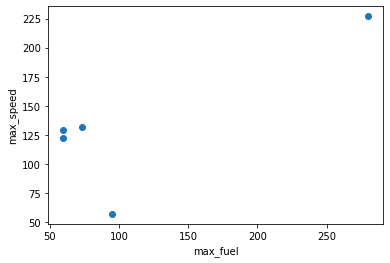

<Figure size 864x864 with 0 Axes>

In [252]:
plt.scatter(X, y)
plt.xlabel('max_fuel')
plt.ylabel('max_speed')
plt.figure(figsize=(12,12))
plt.show()

In [34]:
vehicles_data['vehicle1'].max_speed

129